In [1]:
# %run './model/corpus.py'
%run './model/multi_corpus.py'

from collections import defaultdict

import itertools

import networkx as nx
from networkx.algorithms import community

import numpy as np

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

import pandas as pd
from IPython import display as ICD

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})

img_path = '/Users/vladimirborel/Documents/Obsidian Vault/Dissertation/Images'

In [2]:
data_path = './data/Subcategory Data/'

corpora = Corpora(data_path)
corpora


Gender Studies
    DataFrame: (4834, 12)
    Citation: DiGraph with 4306 nodes and 11230 edges
    Co-Citation: Graph with 3812 nodes and 39908 edges
                    

Neurology
    DataFrame: (41569, 12)
    Citation: DiGraph with 40784 nodes and 355653 edges
    Co-Citation: Graph with 32992 nodes and 1940158 edges
                    

Artificial Intelligence
    DataFrame: (8545, 12)
    Citation: DiGraph with 8212 nodes and 36787 edges
    Co-Citation: Graph with 5692 nodes and 100346 edges
                    

Sociology
    DataFrame: (11525, 12)
    Citation: DiGraph with 11254 nodes and 78971 edges
    Co-Citation: Graph with 10139 nodes and 424106 edges
                    

Ethnic & Cultural Studies
    DataFrame: (3433, 12)
    Citation: DiGraph with 3107 nodes and 7308 edges
    Co-Citation: Graph with 2740 nodes and 20791 edges
                    

Law
    DataFrame: (2883, 12)
    Citation: DiGraph with 2575 nodes and 9299 edges
    Co-Citation: Graph with 2377 nod

## Utils

In [ ]:

def compute_Z(levels):

    comm_ids = defaultdict(dict)
    id = 0
    for (l, level) in enumerate(levels):
        temp = dict()
        for (c, comm) in enumerate(level):
            sorted_comm = tuple(sorted(comm))
            temp[sorted_comm] = id
            id += 1
        comm_ids[l] = temp

    last = len(levels)-1
    edges = []
    leaf_map = {}

    for (l, level) in enumerate(levels[1:]):

        current_level = l + 1
        previous_level = l

        for child_comm in level:
            
            parent_comm = next(filter(lambda parent_comm: child_comm.issubset(parent_comm), levels[l]))
            sorted_parent_comm = tuple(sorted(parent_comm))
            sorted_child_comm = tuple(sorted(child_comm))

            parent_comm_id = comm_ids[previous_level][sorted_parent_comm]
            child_comm_id = comm_ids[current_level][sorted_child_comm]

            edges.append((parent_comm_id, child_comm_id))

            if current_level == last:
                leaf_map[child_comm_id] = next(iter(child_comm))

    G_dendo = nx.DiGraph()
    G_dendo.add_edges_from(edges)

    d = nx.to_dict_of_lists(G_dendo, nodelist=None)

    G_dendo     = nx.DiGraph(d)
    nodes       = G_dendo.nodes()
    leaves      = set( n for n in nodes if G_dendo.out_degree(n) == 0 )
    inner_nodes = [ n for n in nodes if G_dendo.out_degree(n) > 0 ]

    subtree = dict( (n, [n]) for n in leaves )
    for u in inner_nodes:
        children = set()
        node_list = list(d[u])
        while len(node_list) > 0:
            v = node_list.pop(0)
            children.add( v )
            node_list += d[v]

        subtree[u] = sorted(children & leaves)

    inner_nodes.sort(key=lambda n: len(subtree[n]))

    leaves = sorted(leaves)
    index  = dict( (tuple([n]), i) for i, n in enumerate(leaves) )
    Z = []
    k = len(leaves)
    for i, n in enumerate(inner_nodes):
        children = d[n]
        x = children[0]
        for y in children[1:]:
            z = tuple(sorted(subtree[x] + subtree[y]))
            i, j = index[tuple(subtree[x])], index[tuple(subtree[y])]
            Z.append([i, j, float(len(subtree[n])), len(z)])
            index[z] = k
            subtree[z] = list(z)
            x = z
            k += 1

    leaves = [leaf_map[l] for l in leaves]

    return (Z, leaves)

## Simple Distance

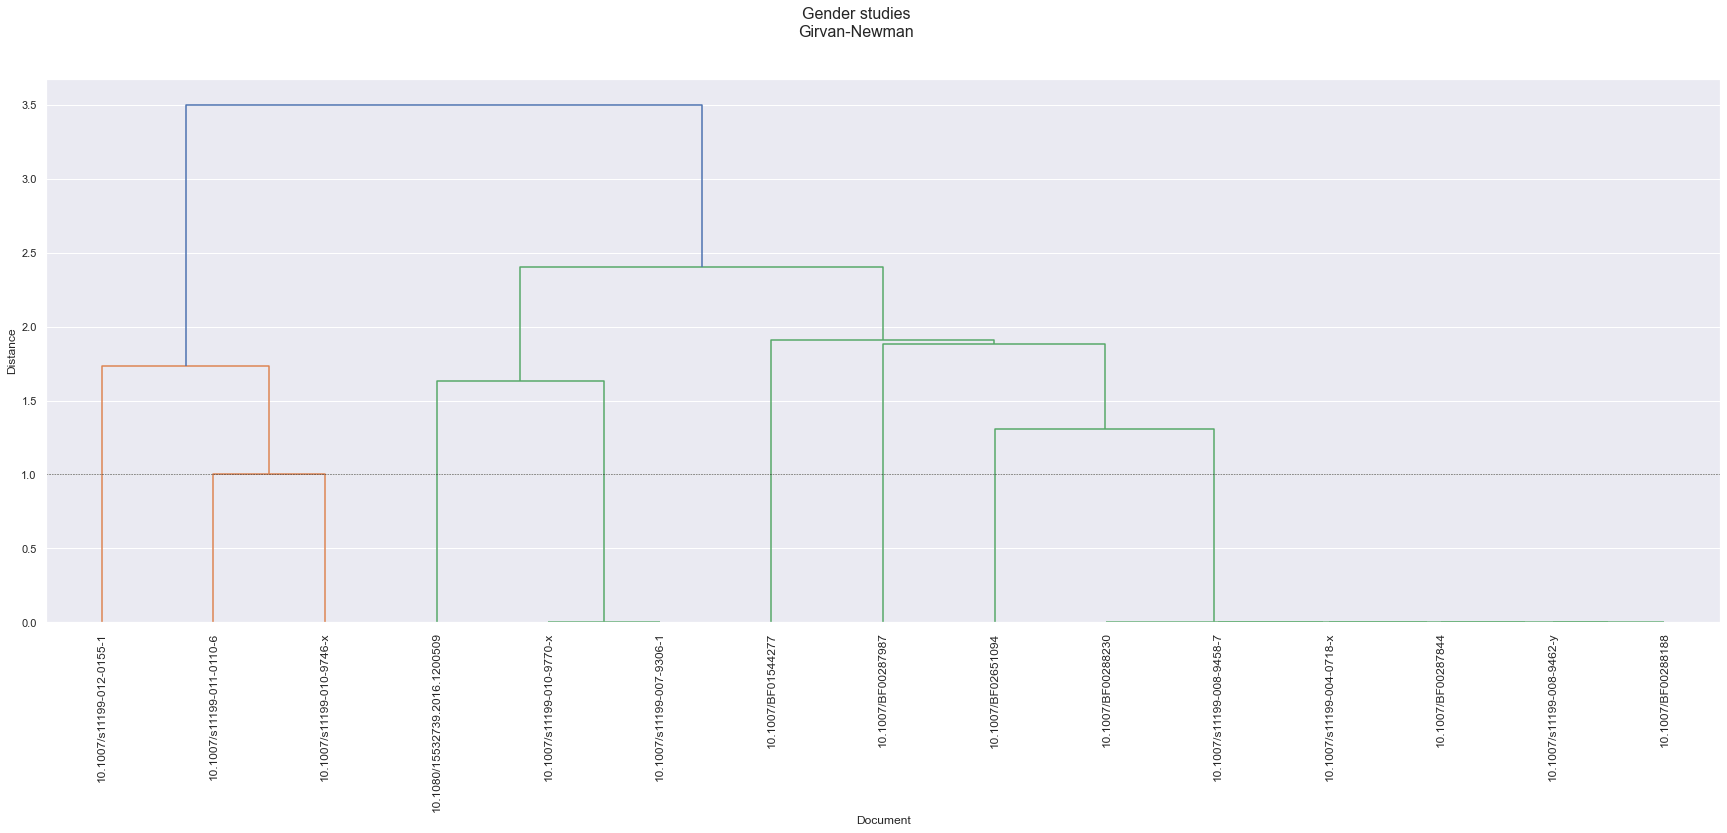

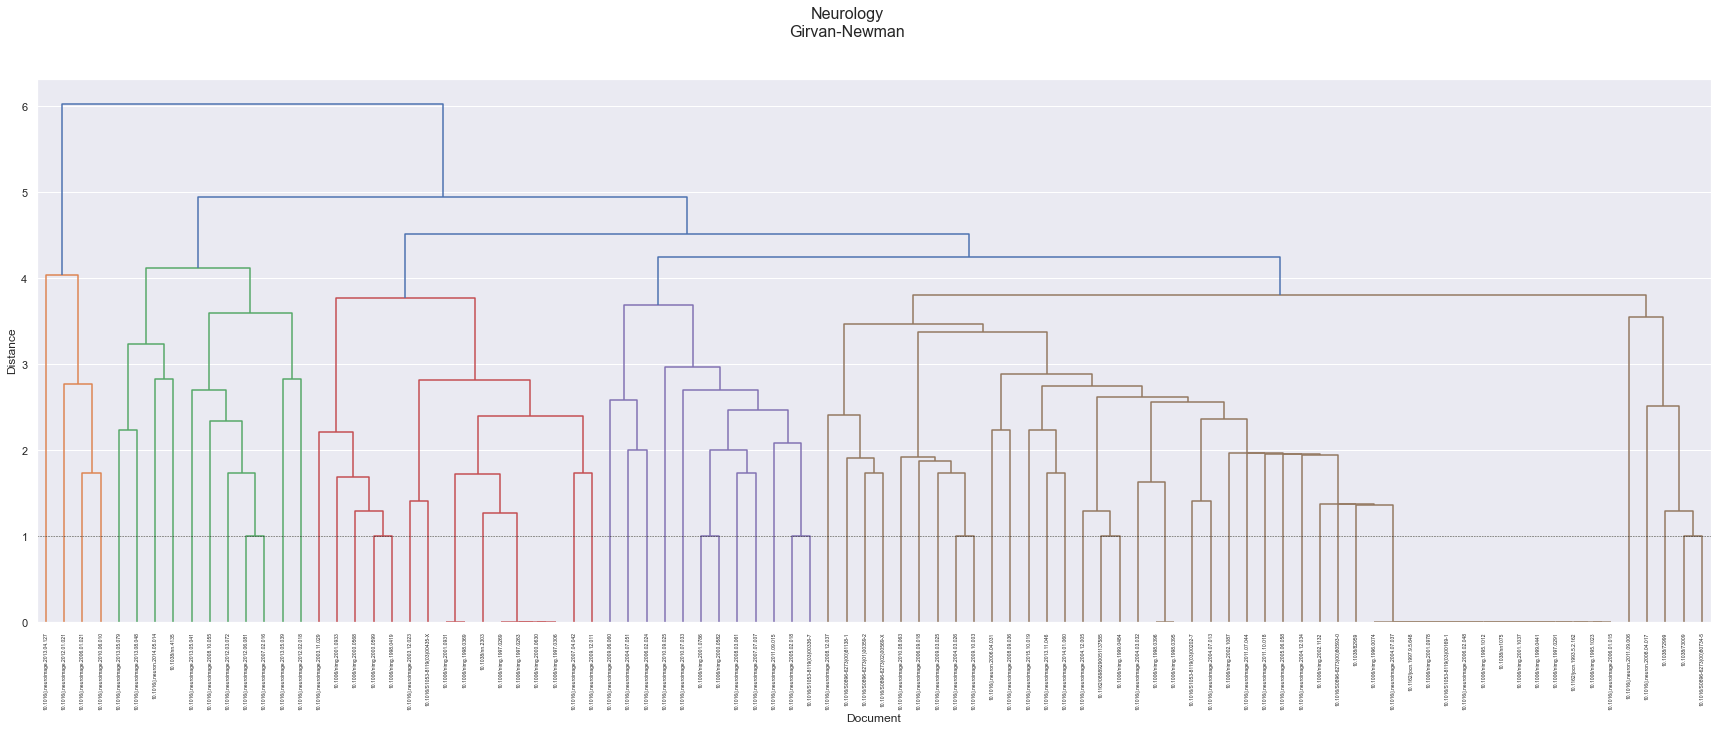

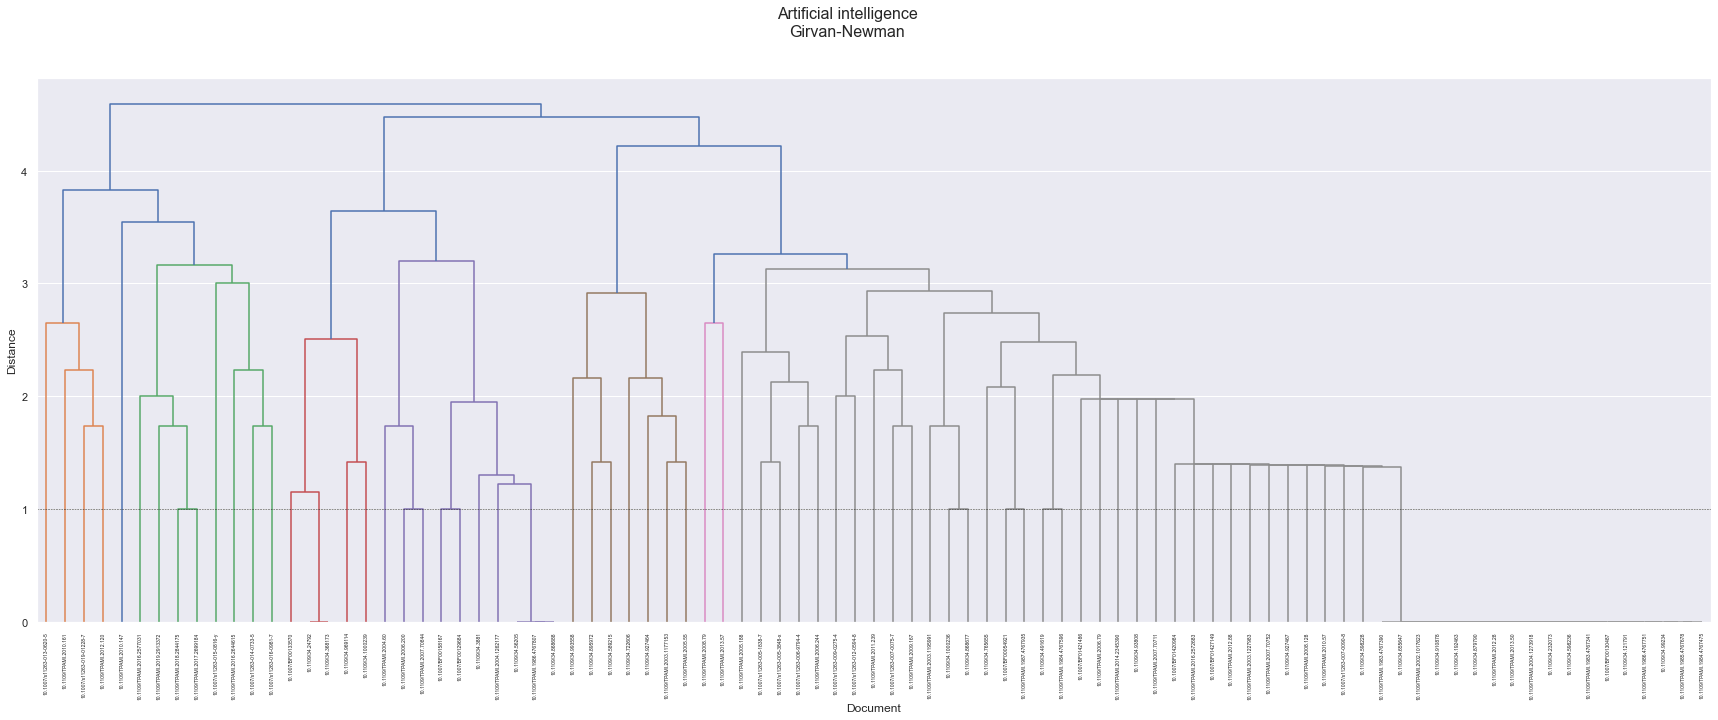

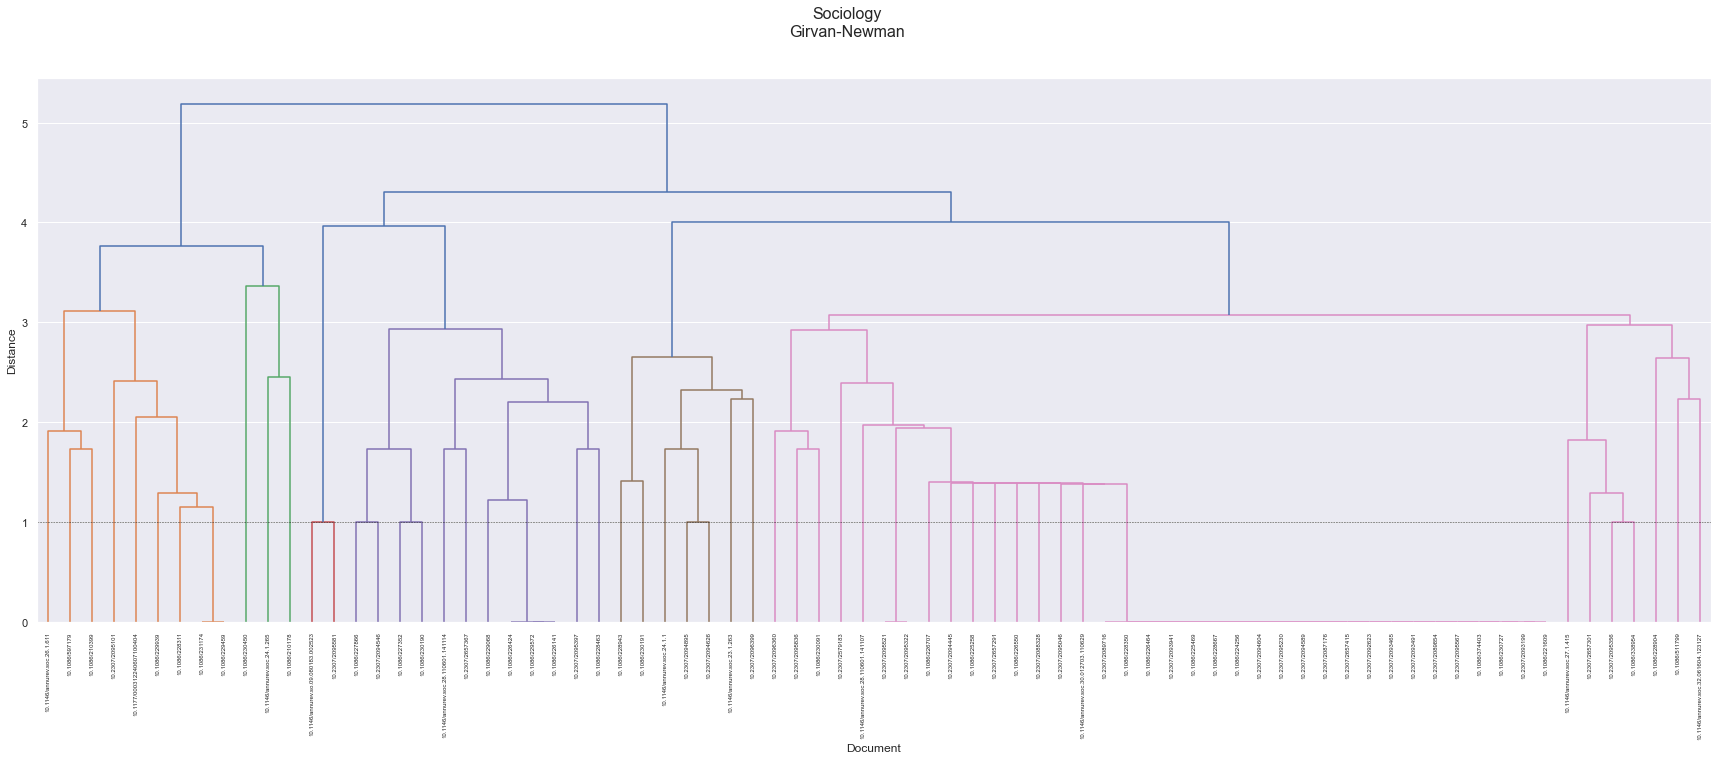

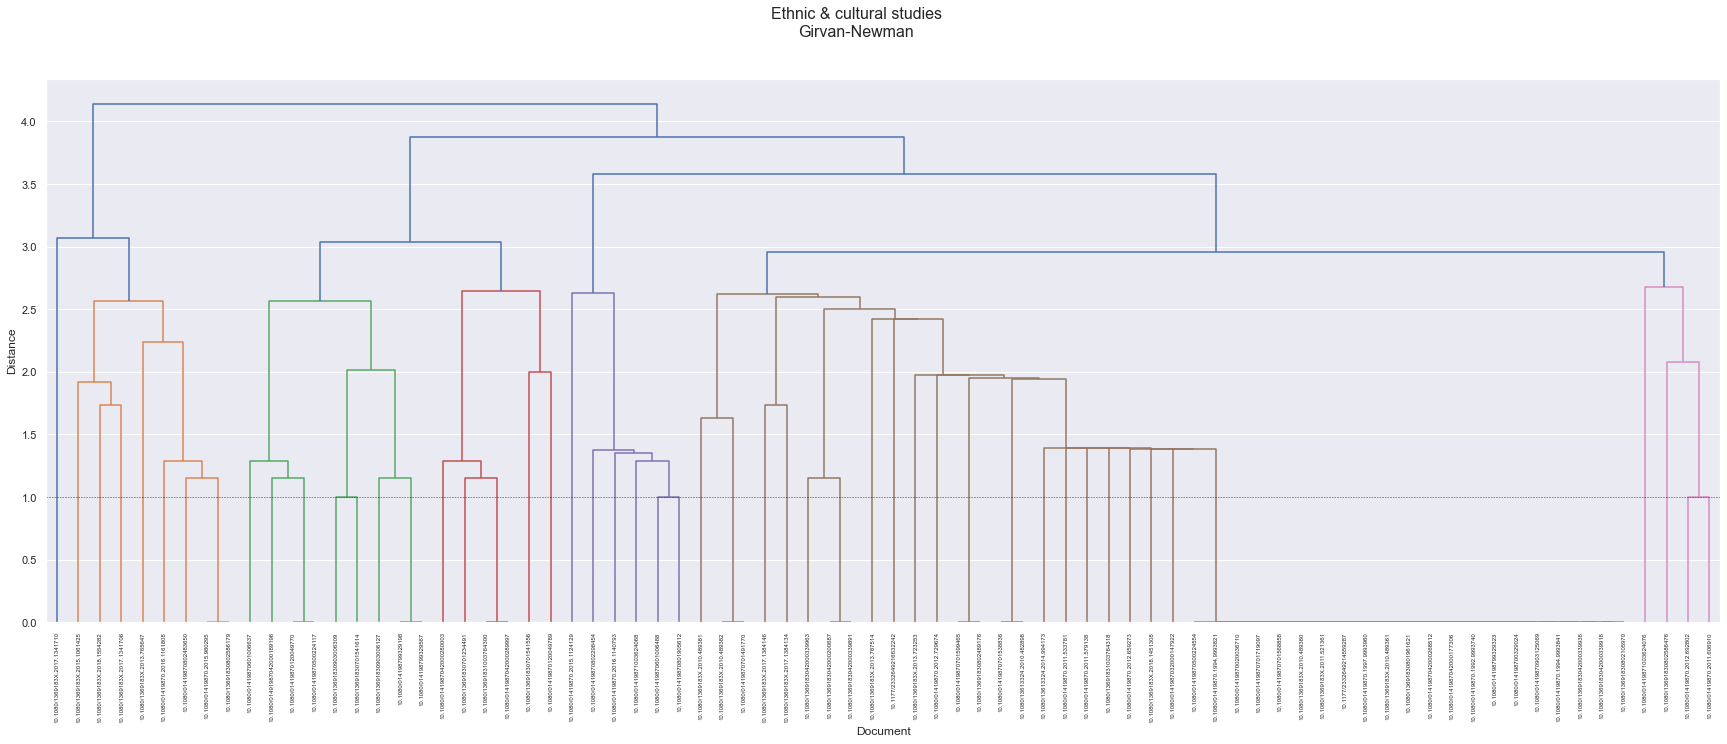

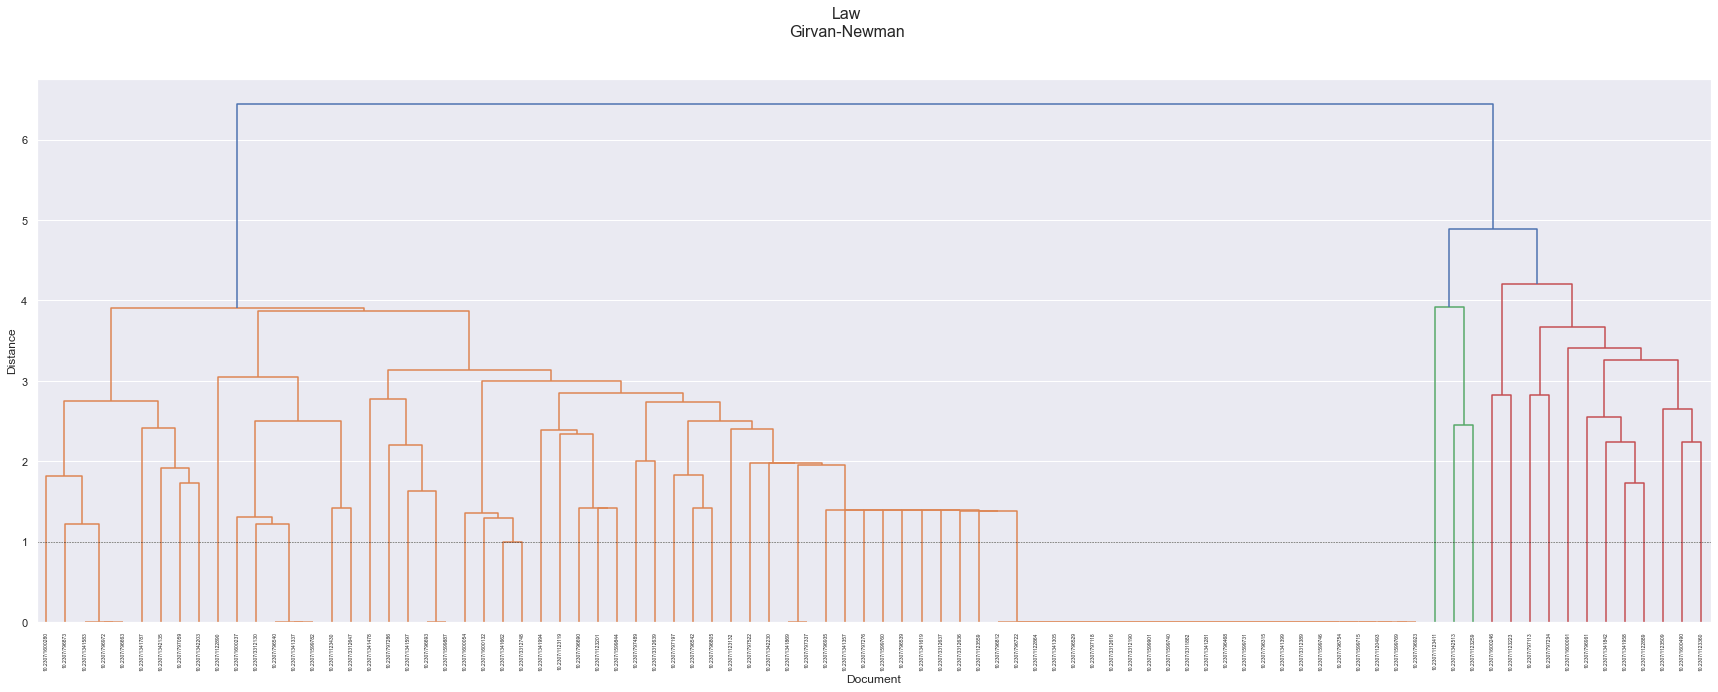

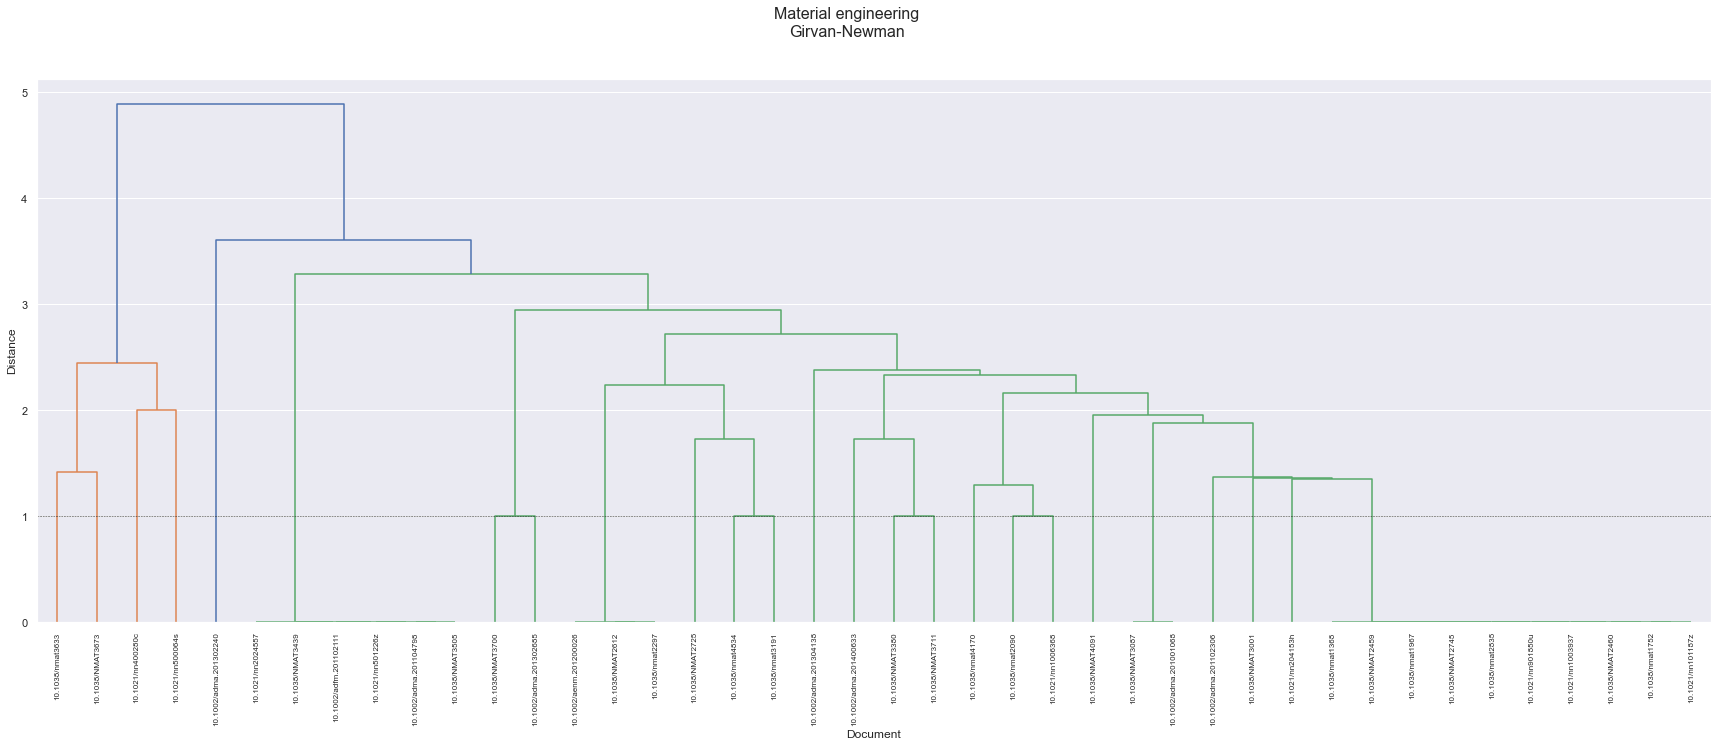

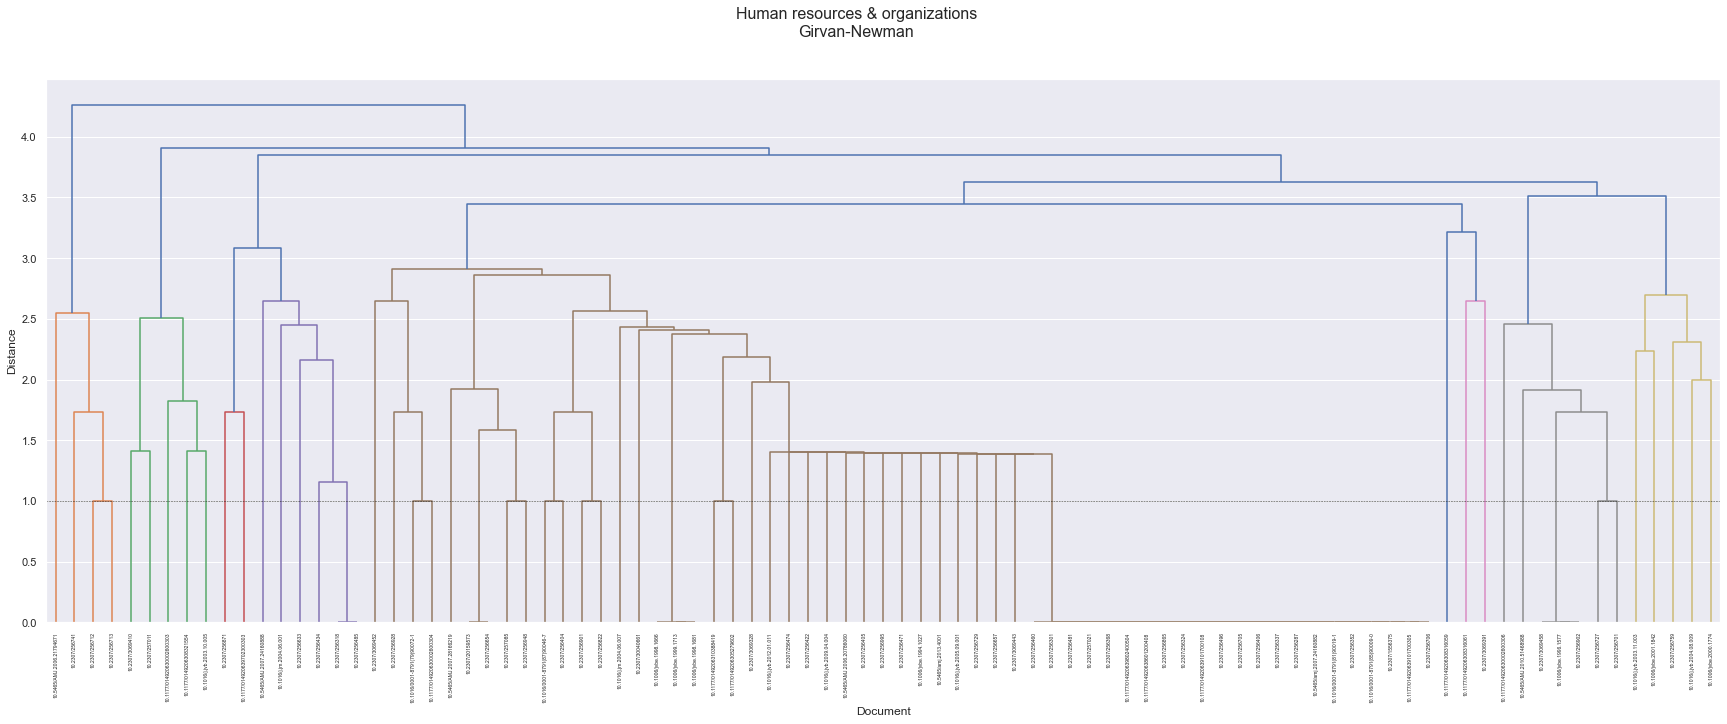

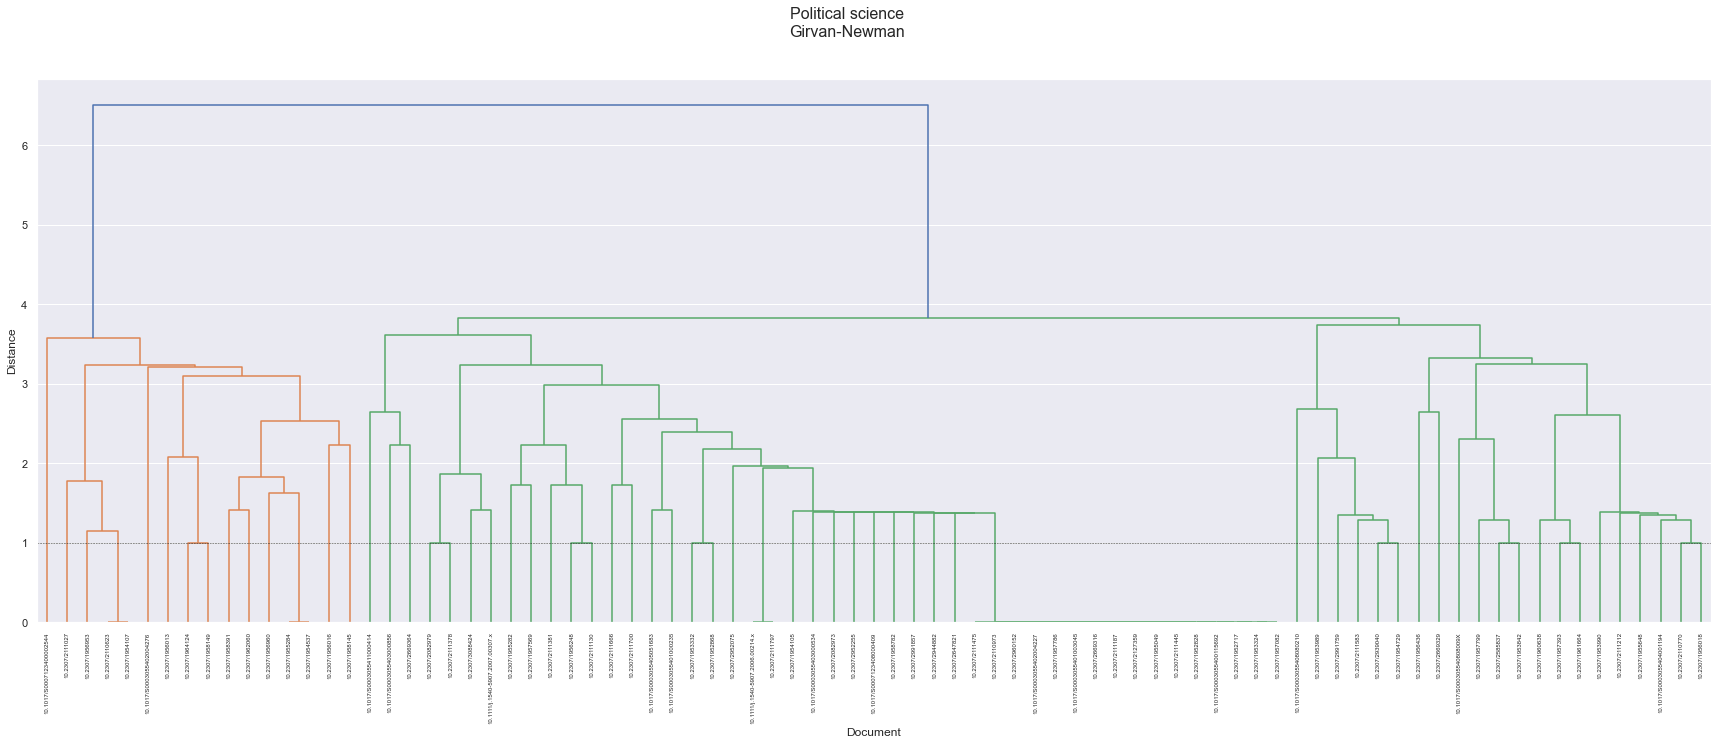

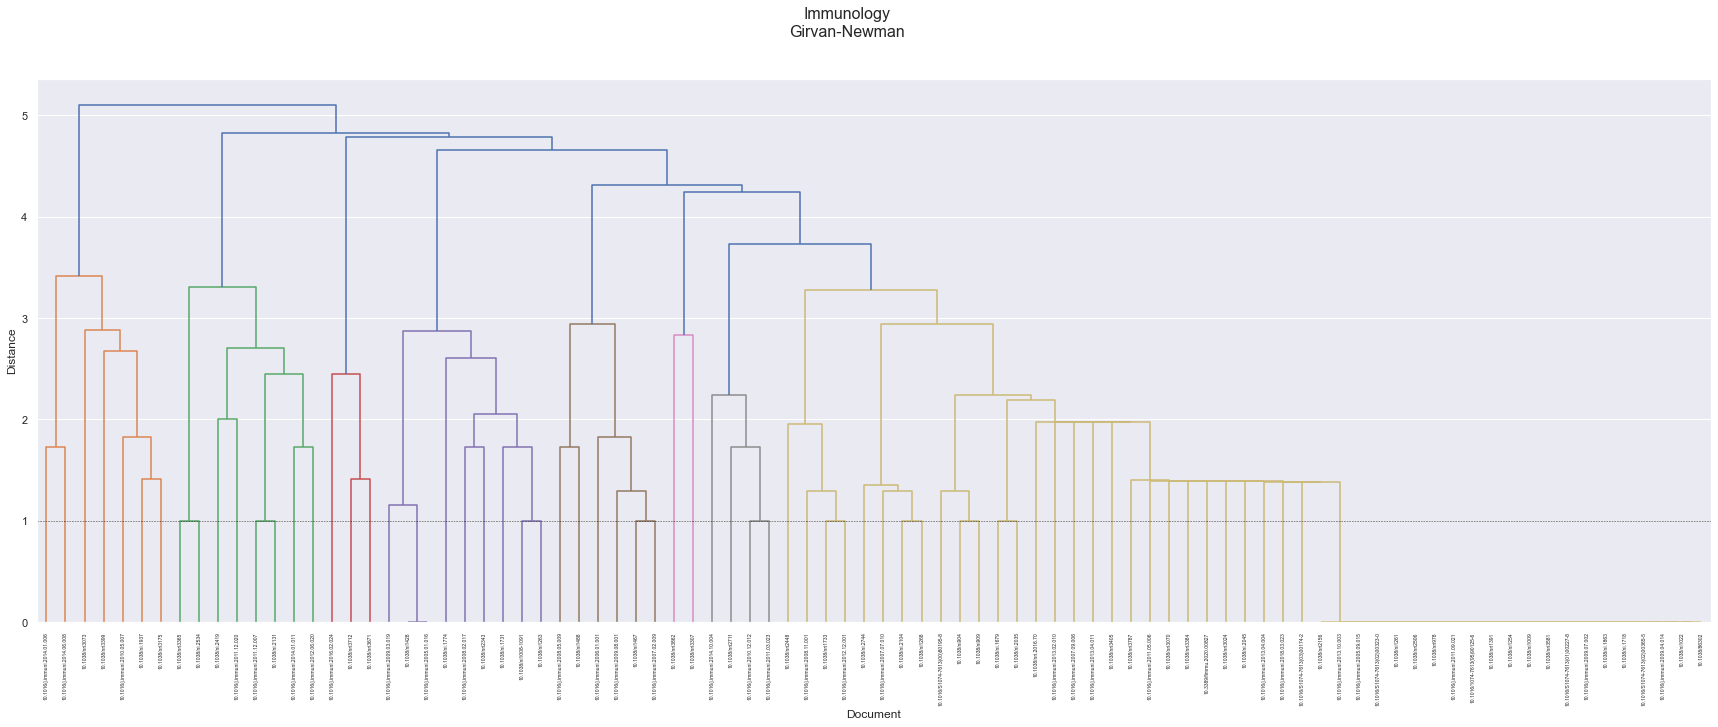

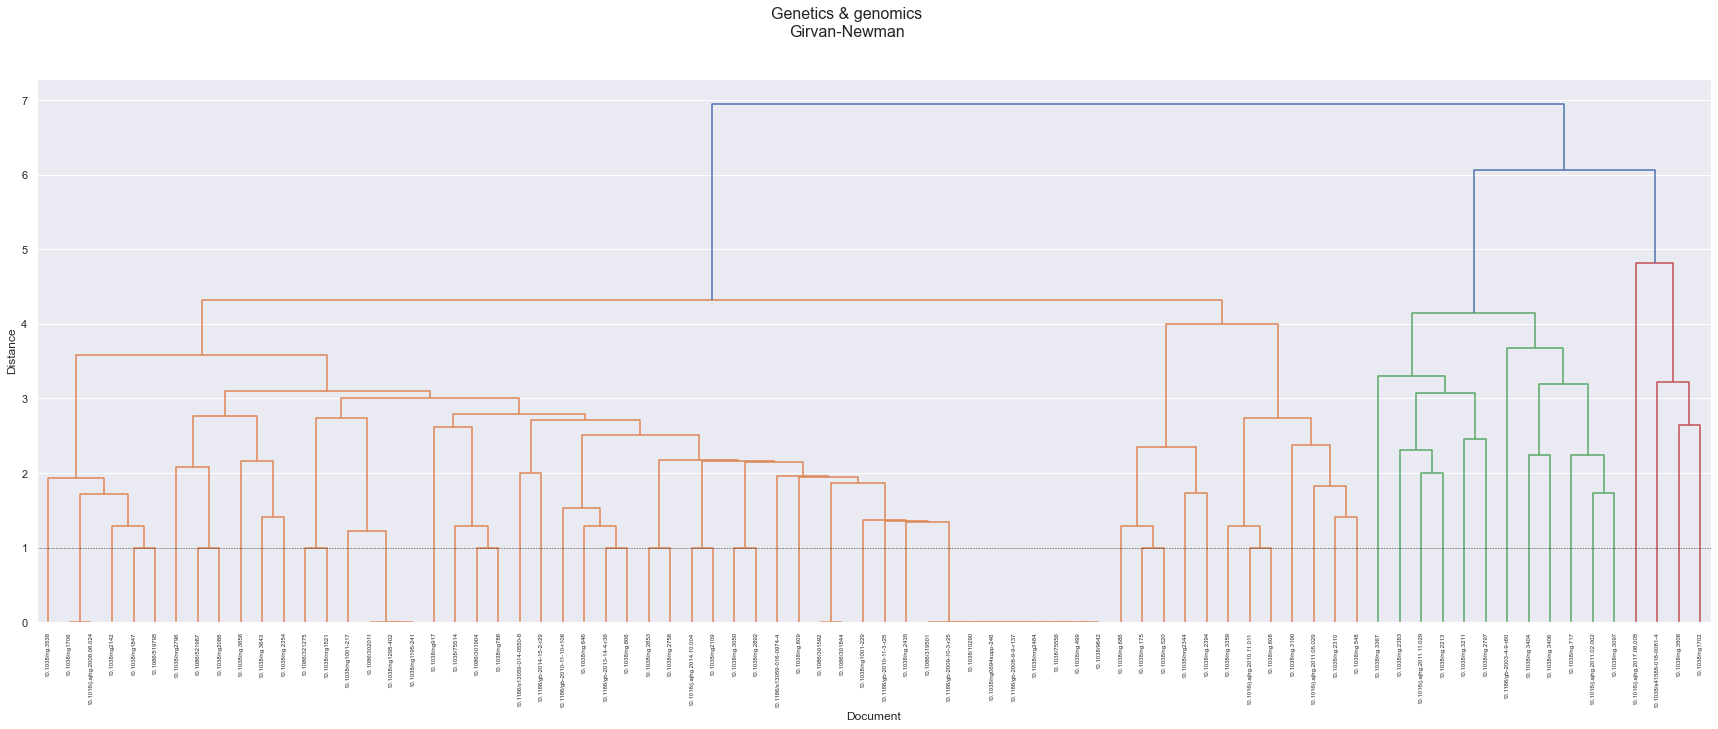

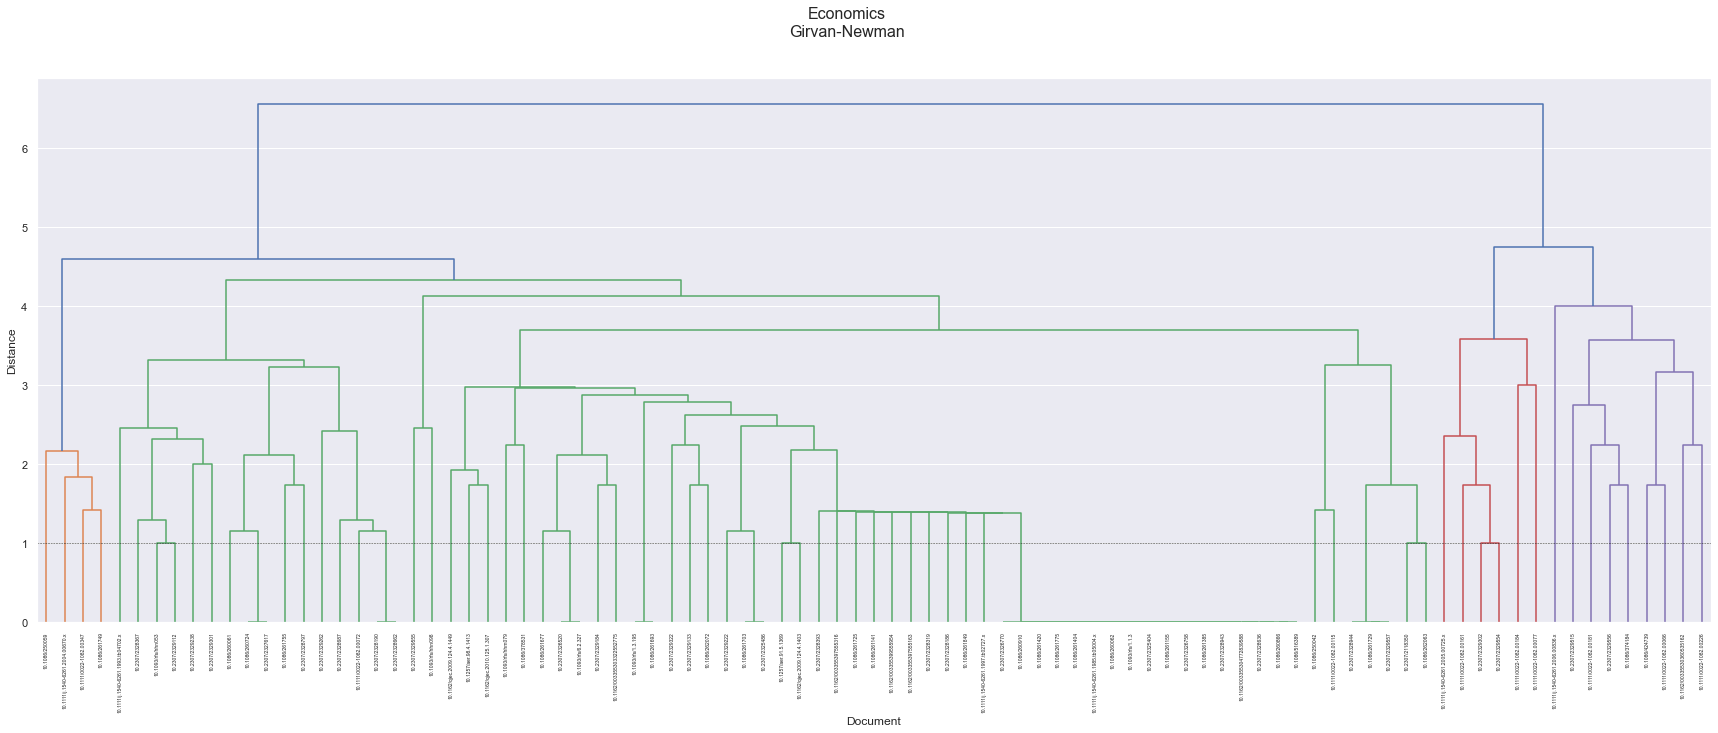

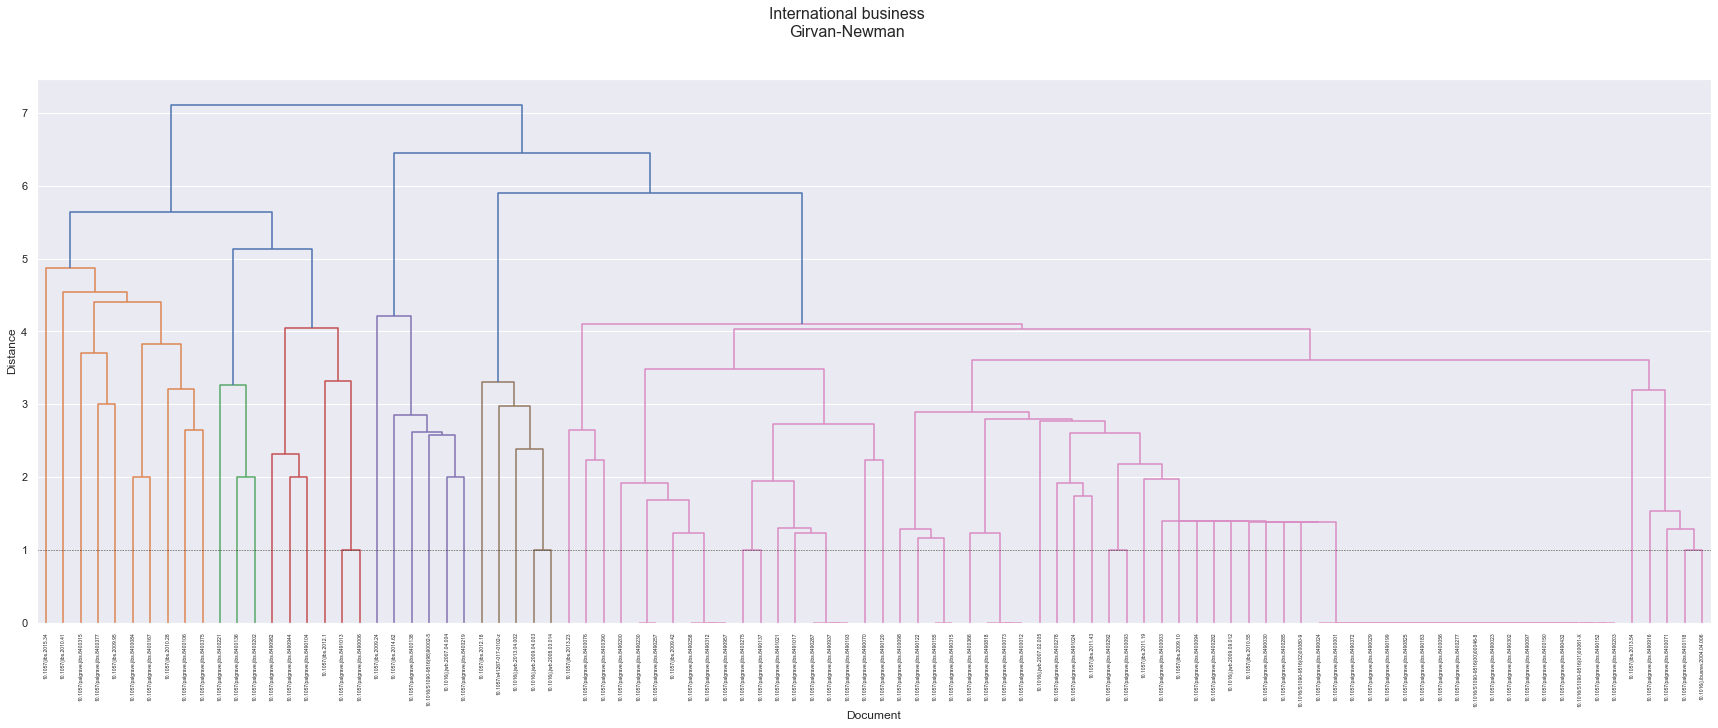

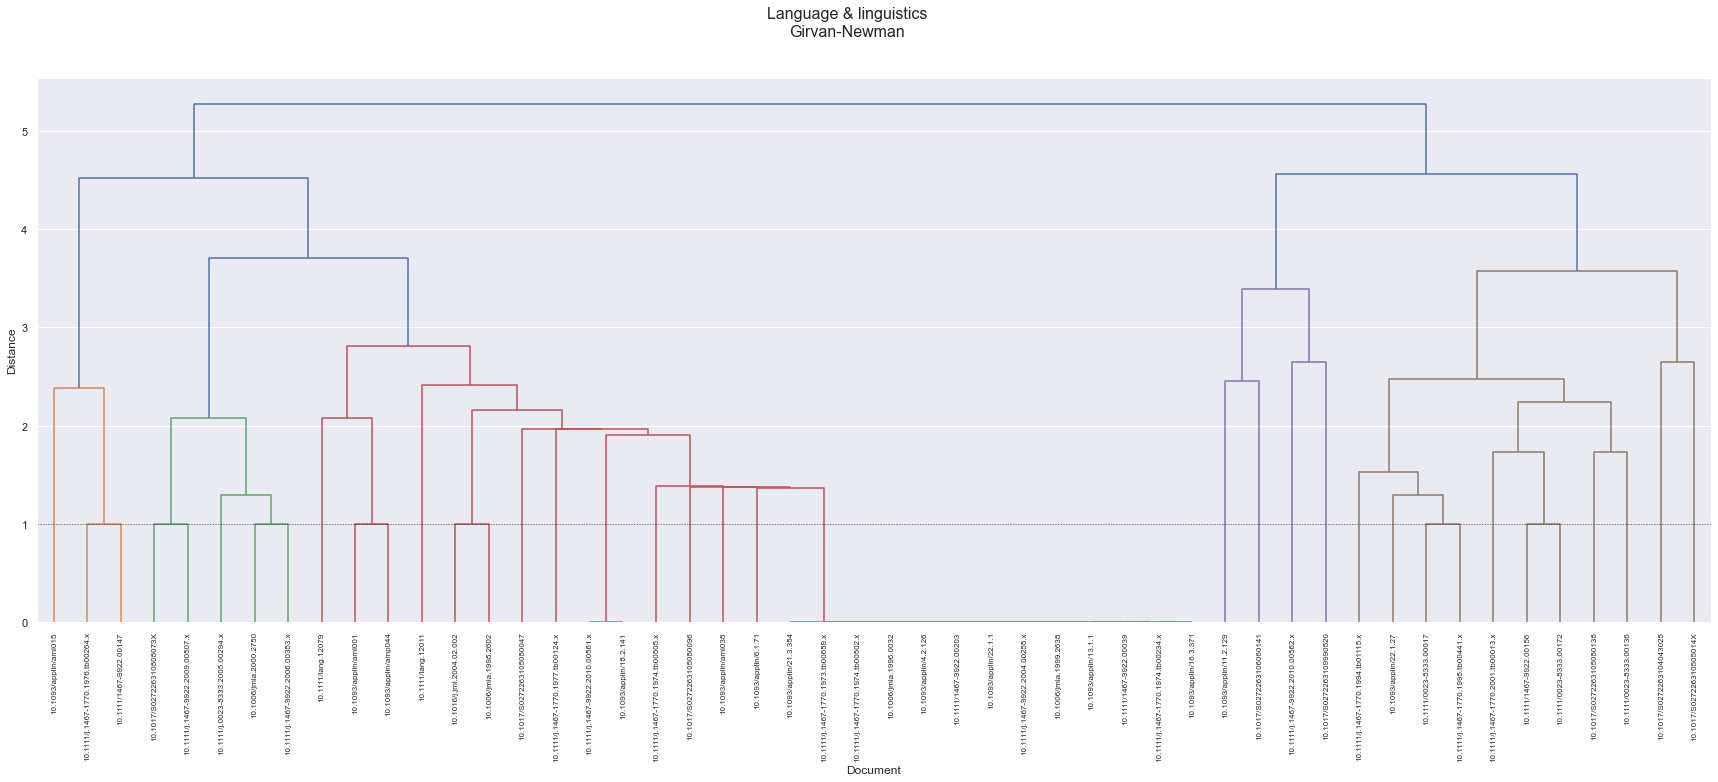

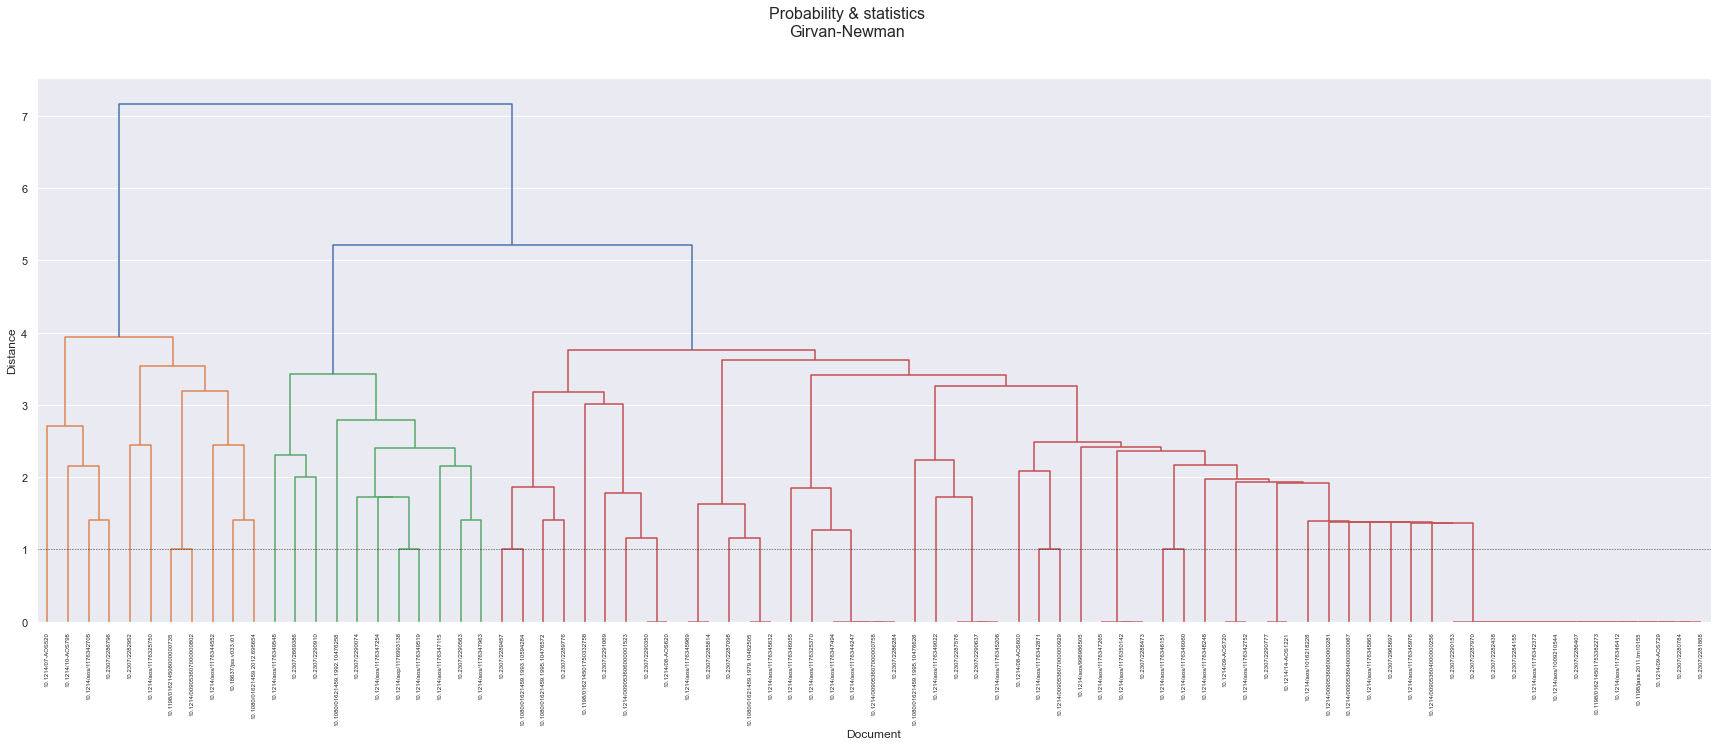

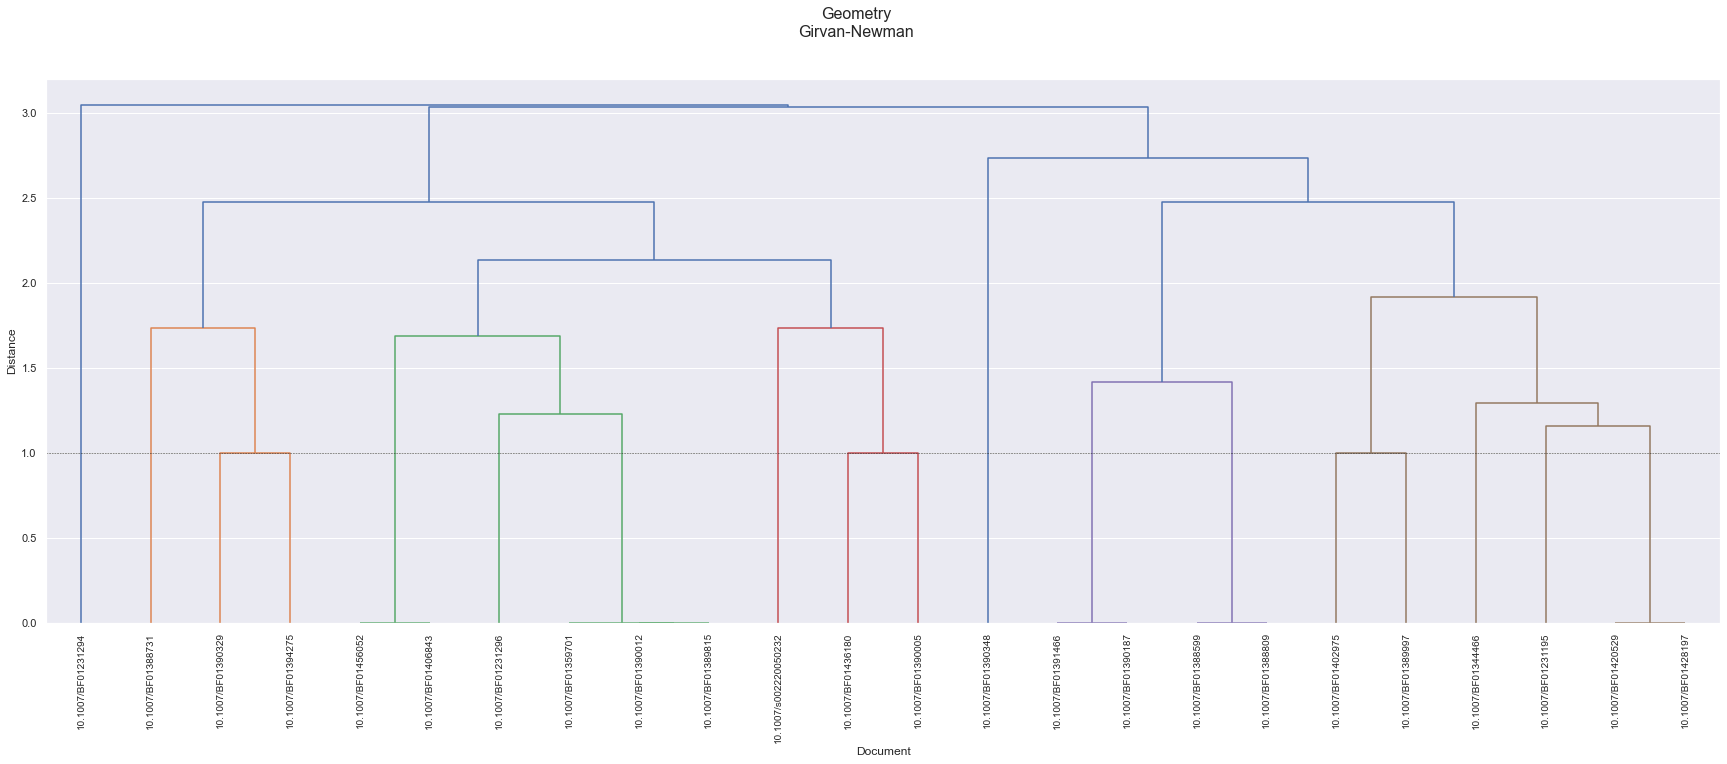

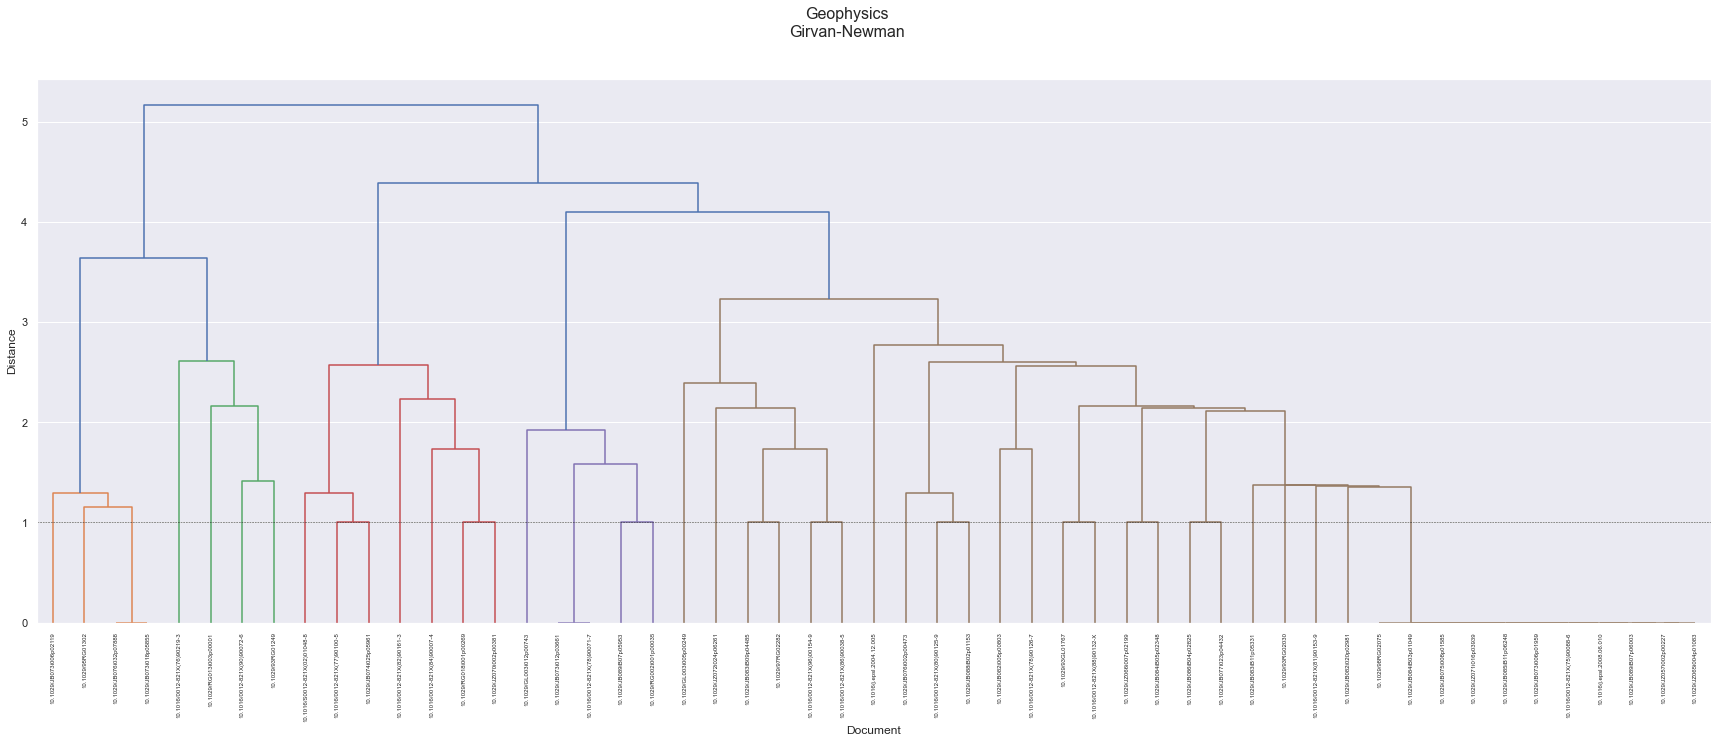

In [9]:
n = 100

for (field_name, corpus) in corpora.data.items():
    
    G = corpus['citation_graph']

    in_dgree_centrality_dict = nx.in_degree_centrality(G)
    sorted_first_n_centrality_dict = dict(sorted(in_dgree_centrality_dict.items(), key=lambda x: x[1], reverse=True)[:n])
    nodes = sorted_first_n_centrality_dict.keys()

    G = G.subgraph(nodes)
    nodes = list(max(nx.weakly_connected_components(G), key=len))
    G = G.subgraph(nodes)

    X = nx.to_numpy_array(G)
    Z = linkage(X, 'ward')

    sns.set()

    fig = plt.figure(figsize=(30, 10))
    axes = fig.subplots(1)
    plt.title('')
    plt.xlabel('Document')
    plt.ylabel('Distance')
    dendrogram(Z, labels=nodes)
    axes.yaxis.grid(True)
    axes.xaxis.grid(False)
    plt.axhline(y=1.0, c='k', ls='--', lw=0.5)
    fig.set_facecolor('w')
    fig.suptitle(f'{field_name}\nGirvan-Newman', fontsize=16)
    plt.xticks(rotation=90)

    plt.savefig(f'{img_path}/edge_distance_communities_{field_name}.png')
    plt.show()


## Girvan-Newman

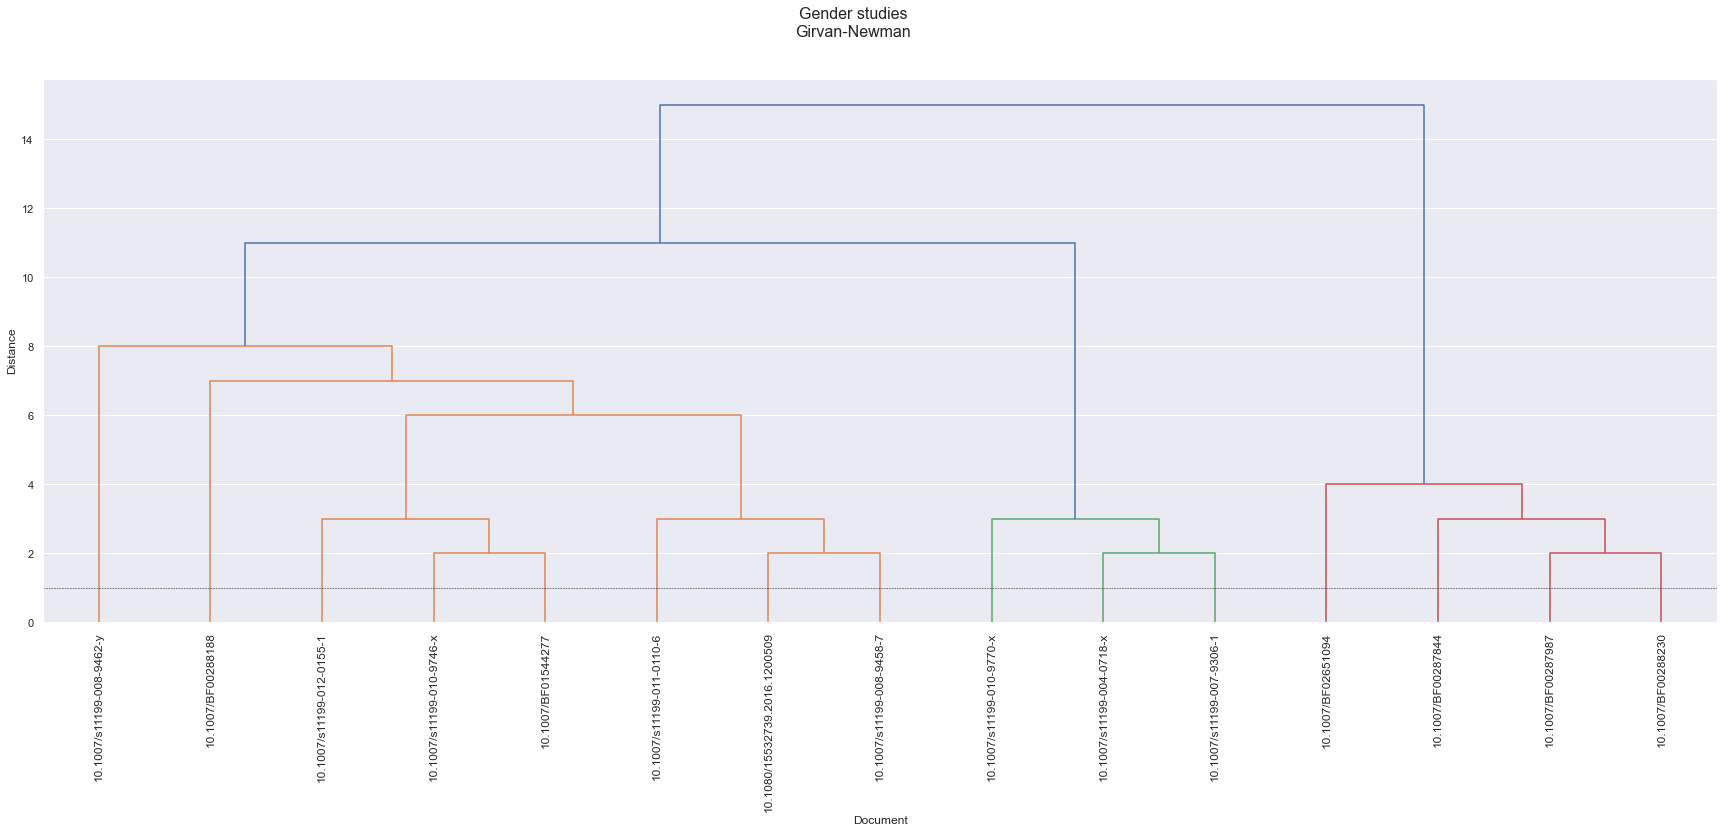

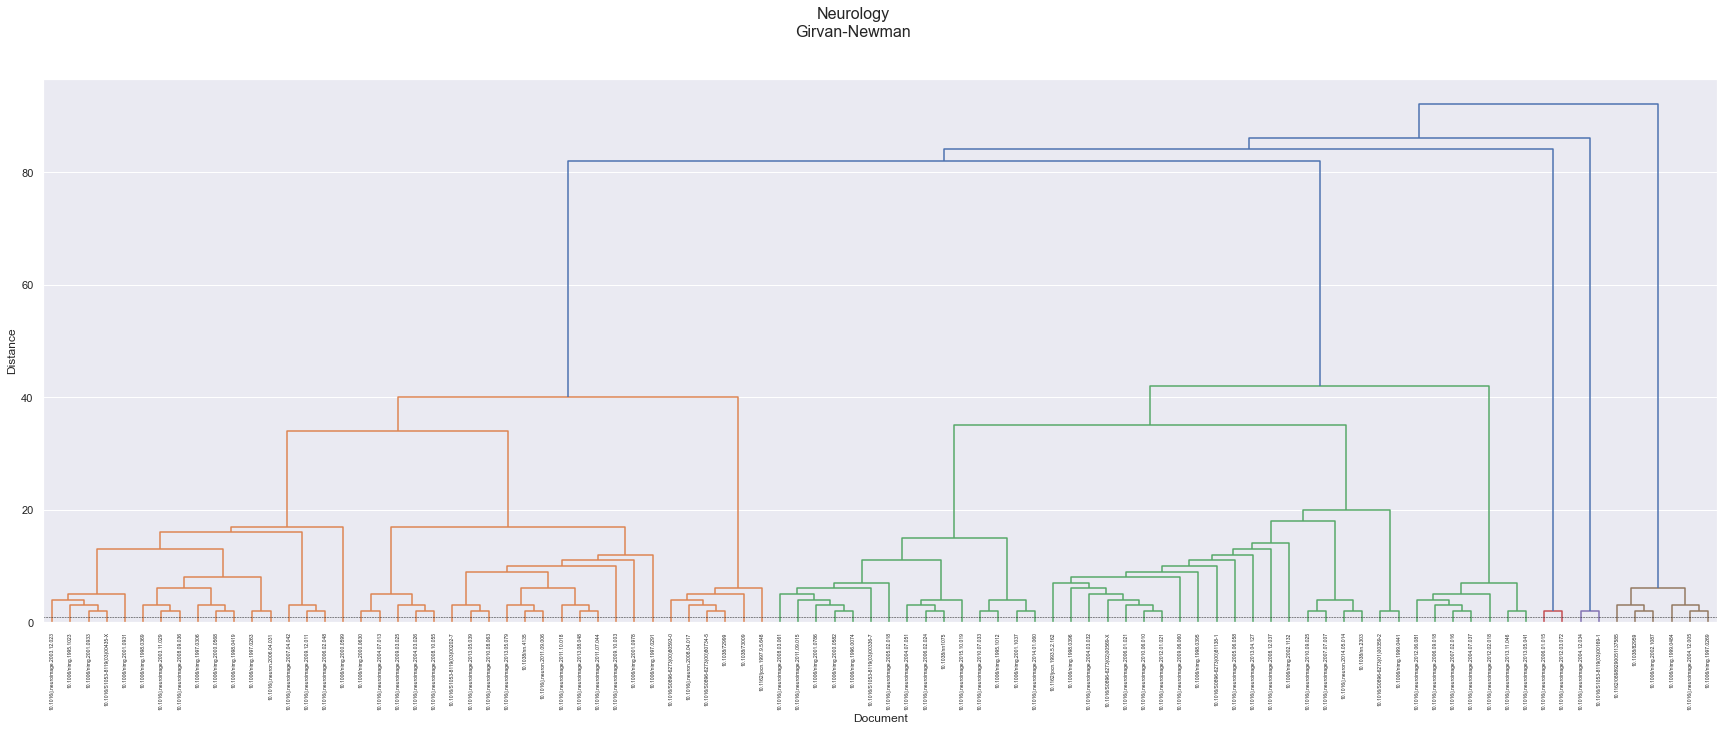

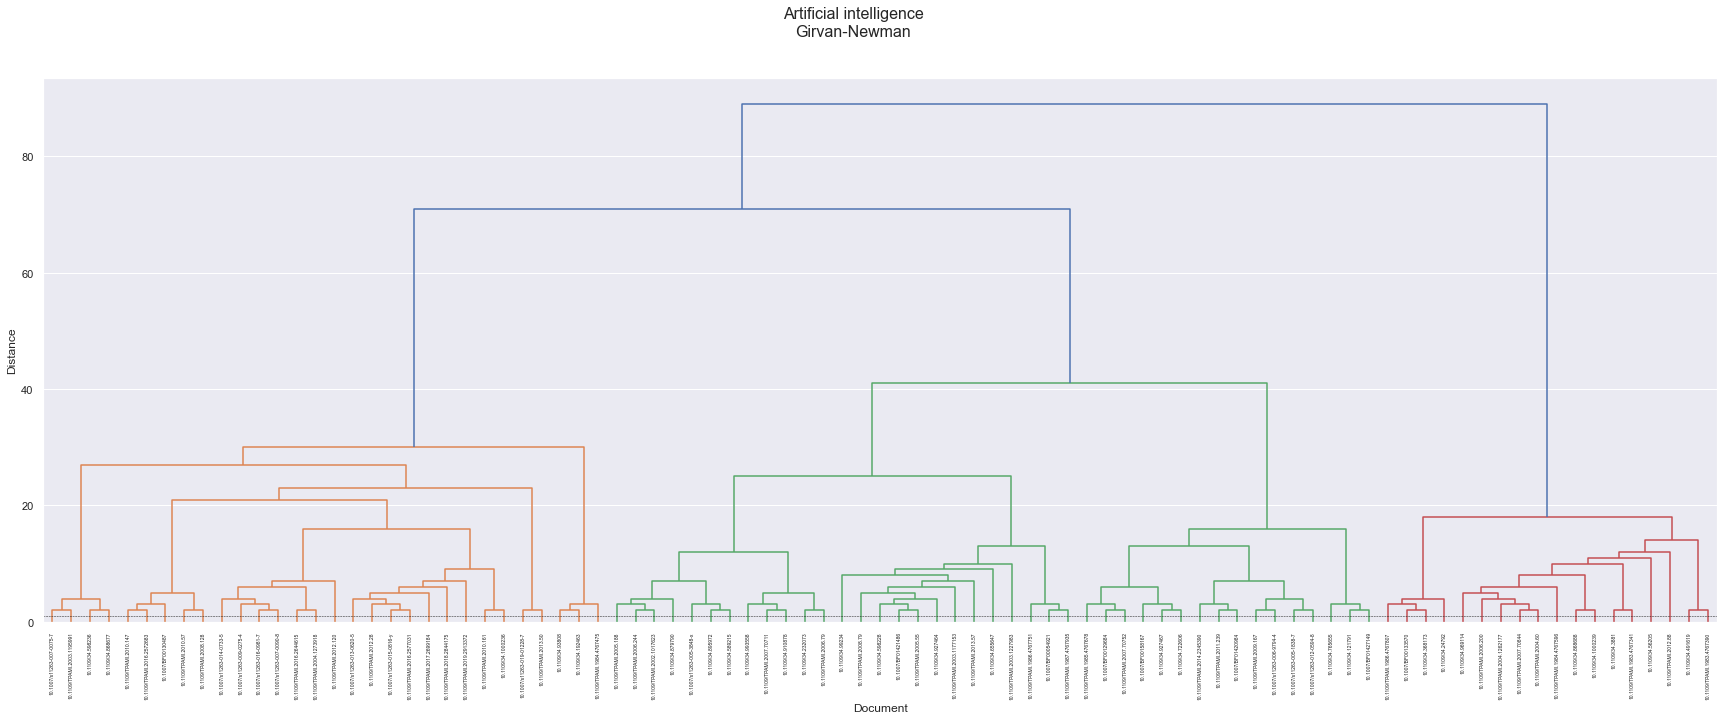

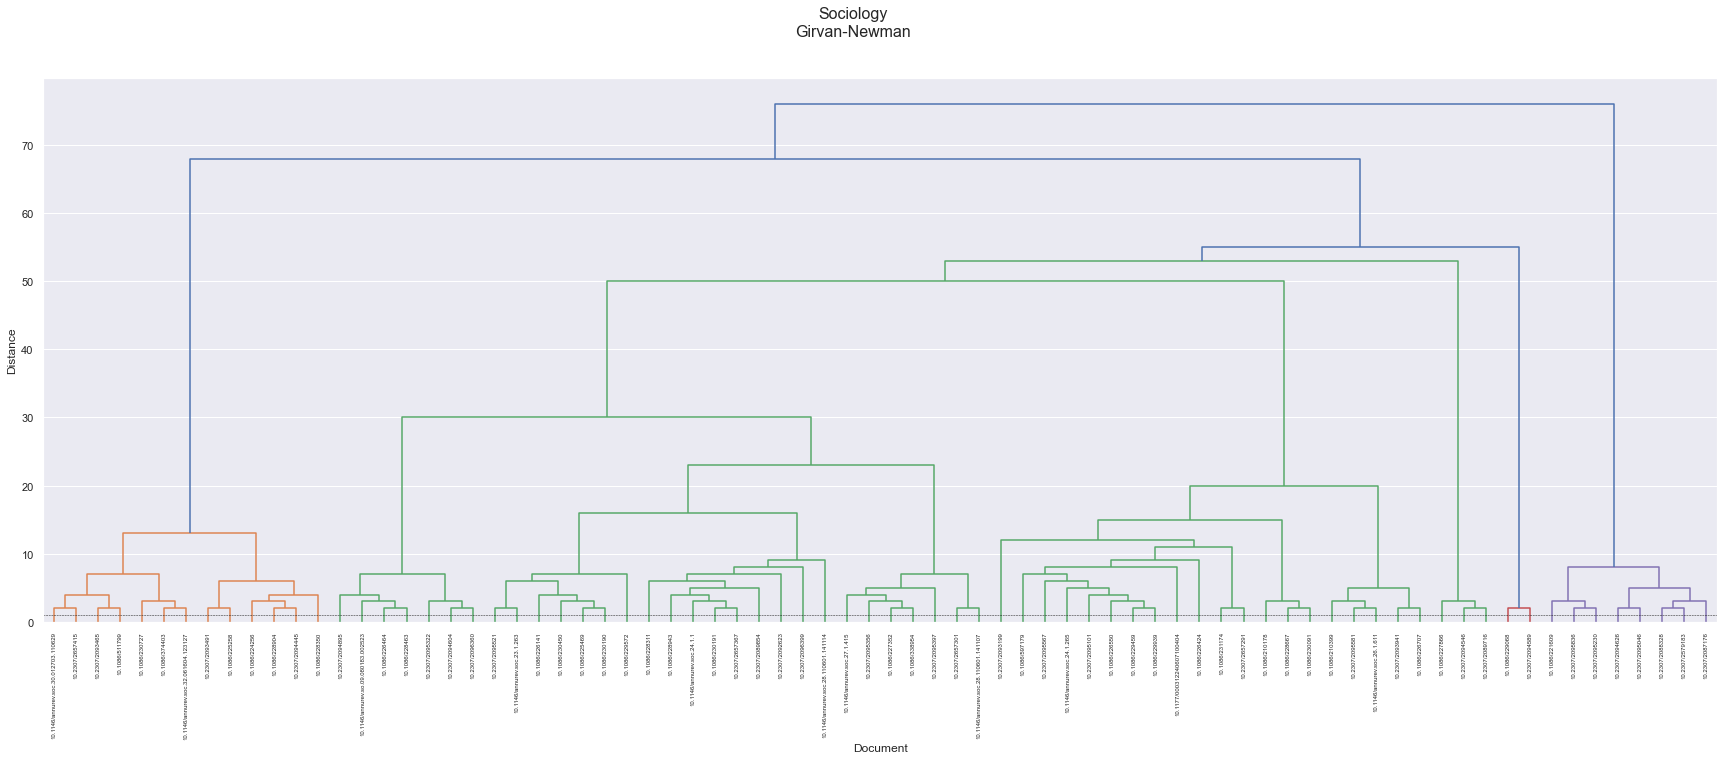

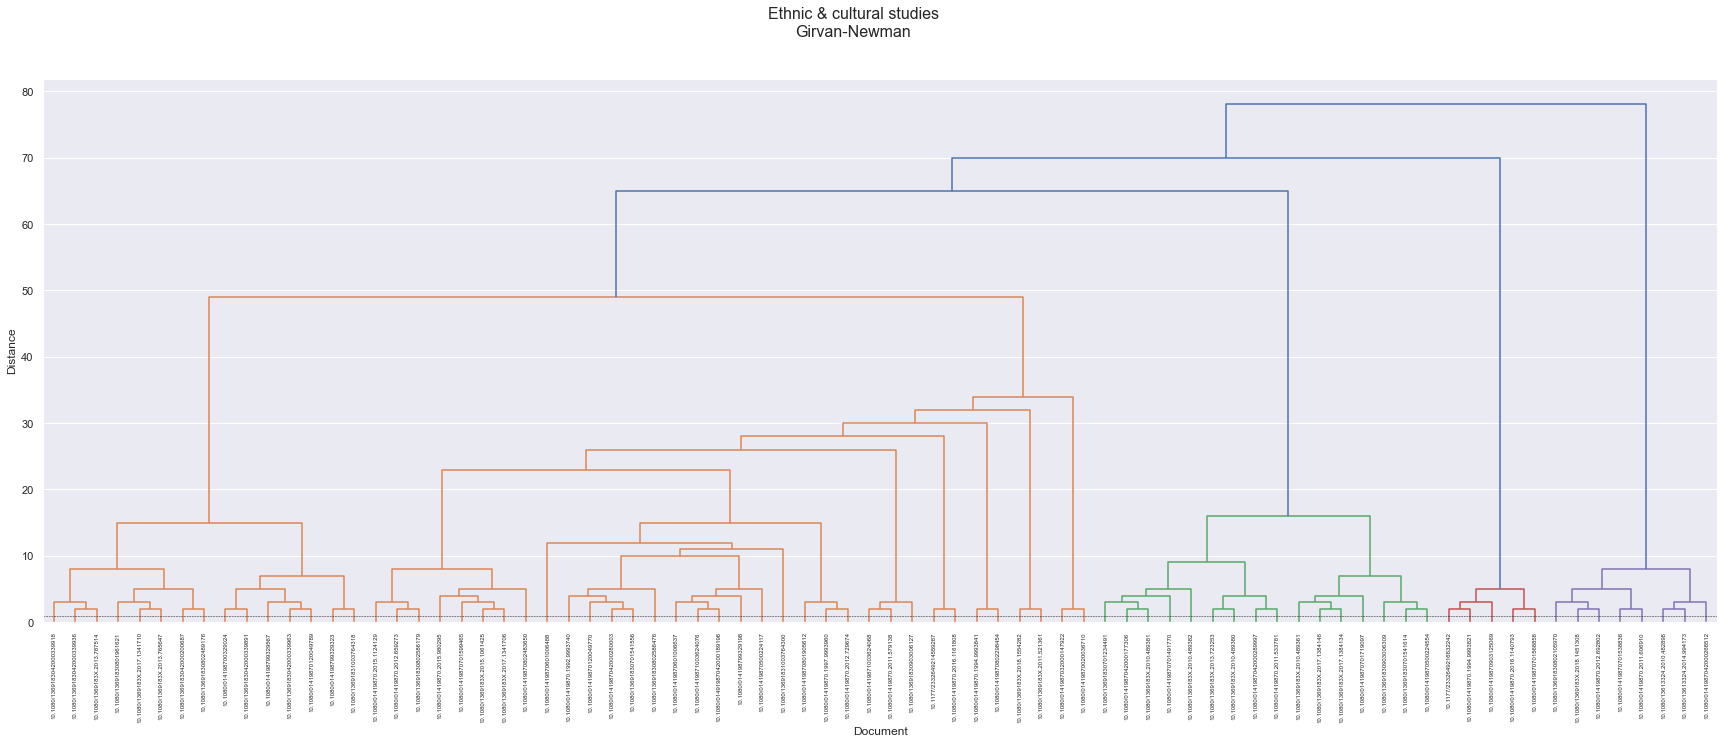

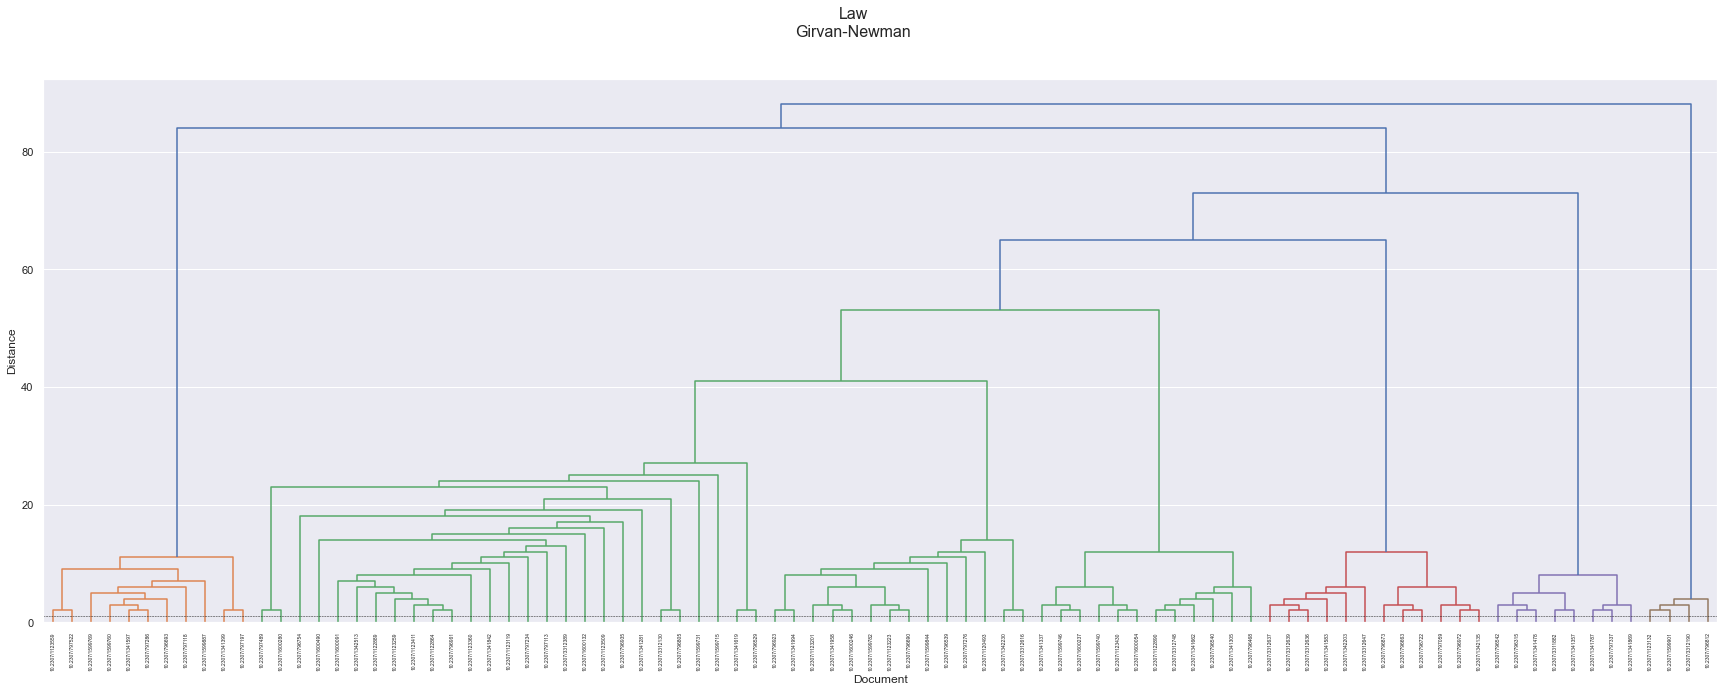

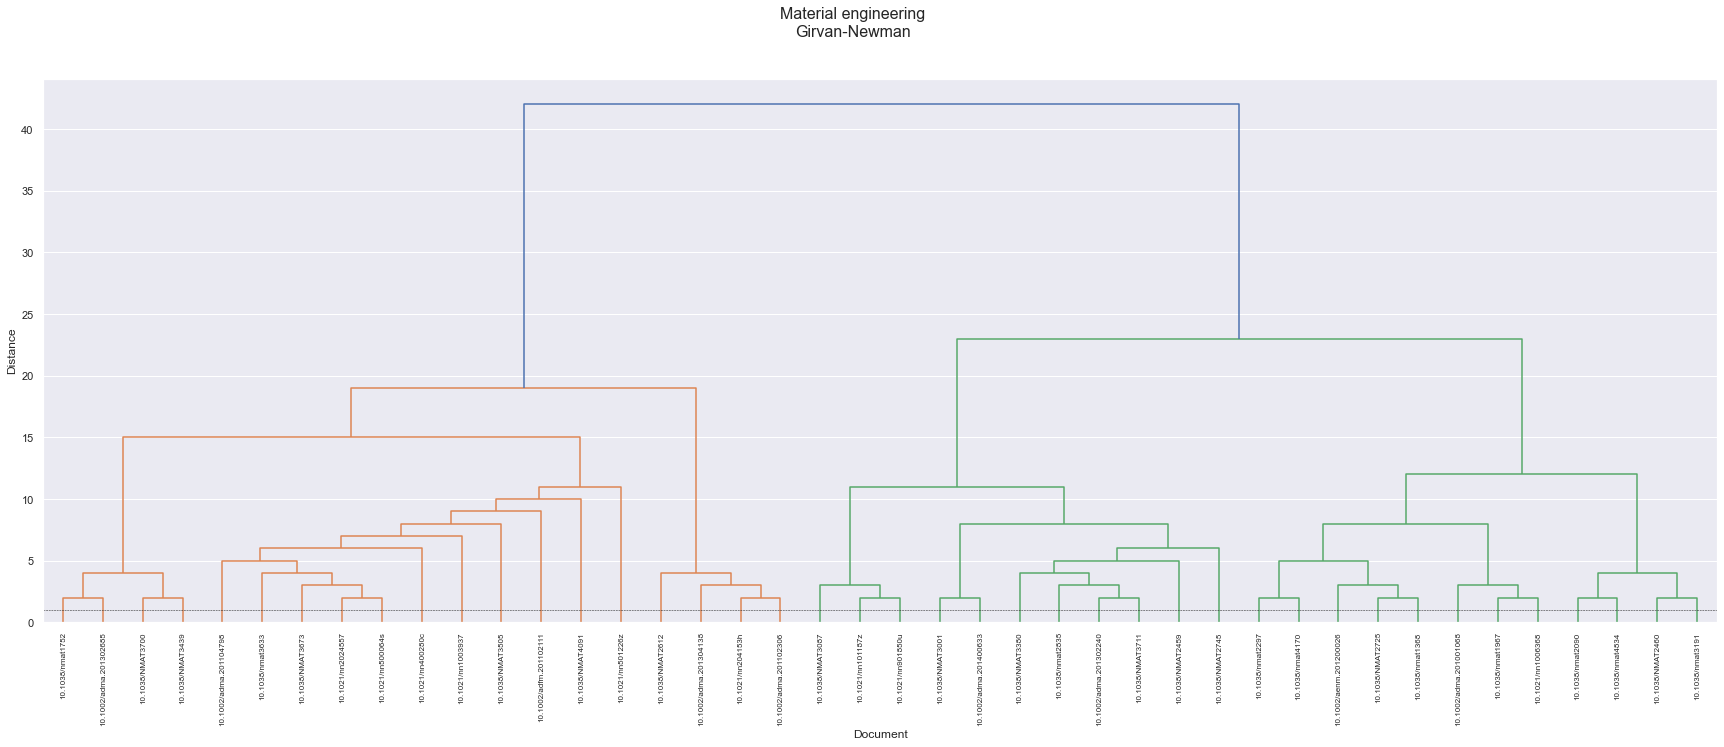

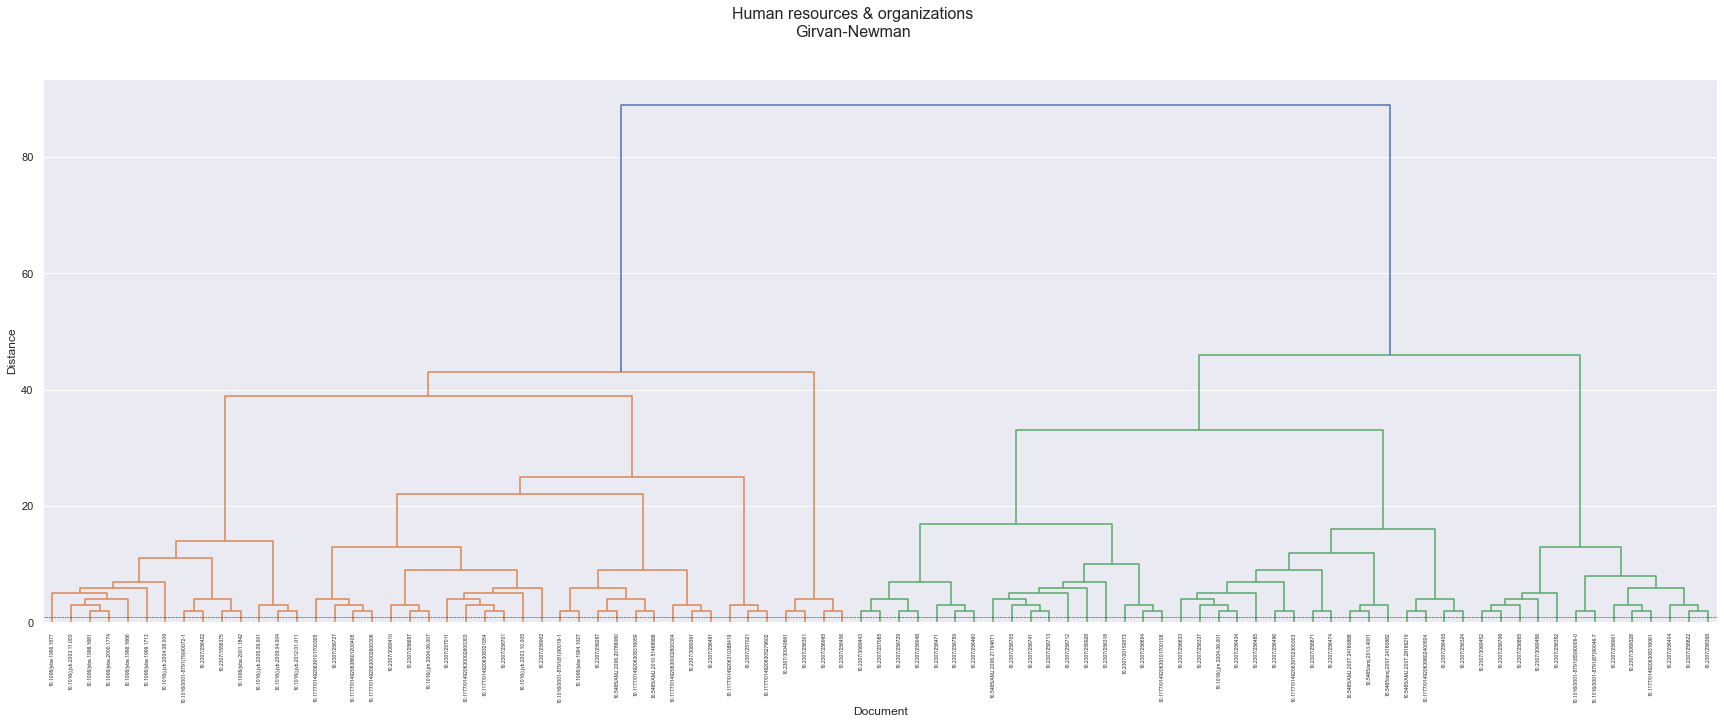

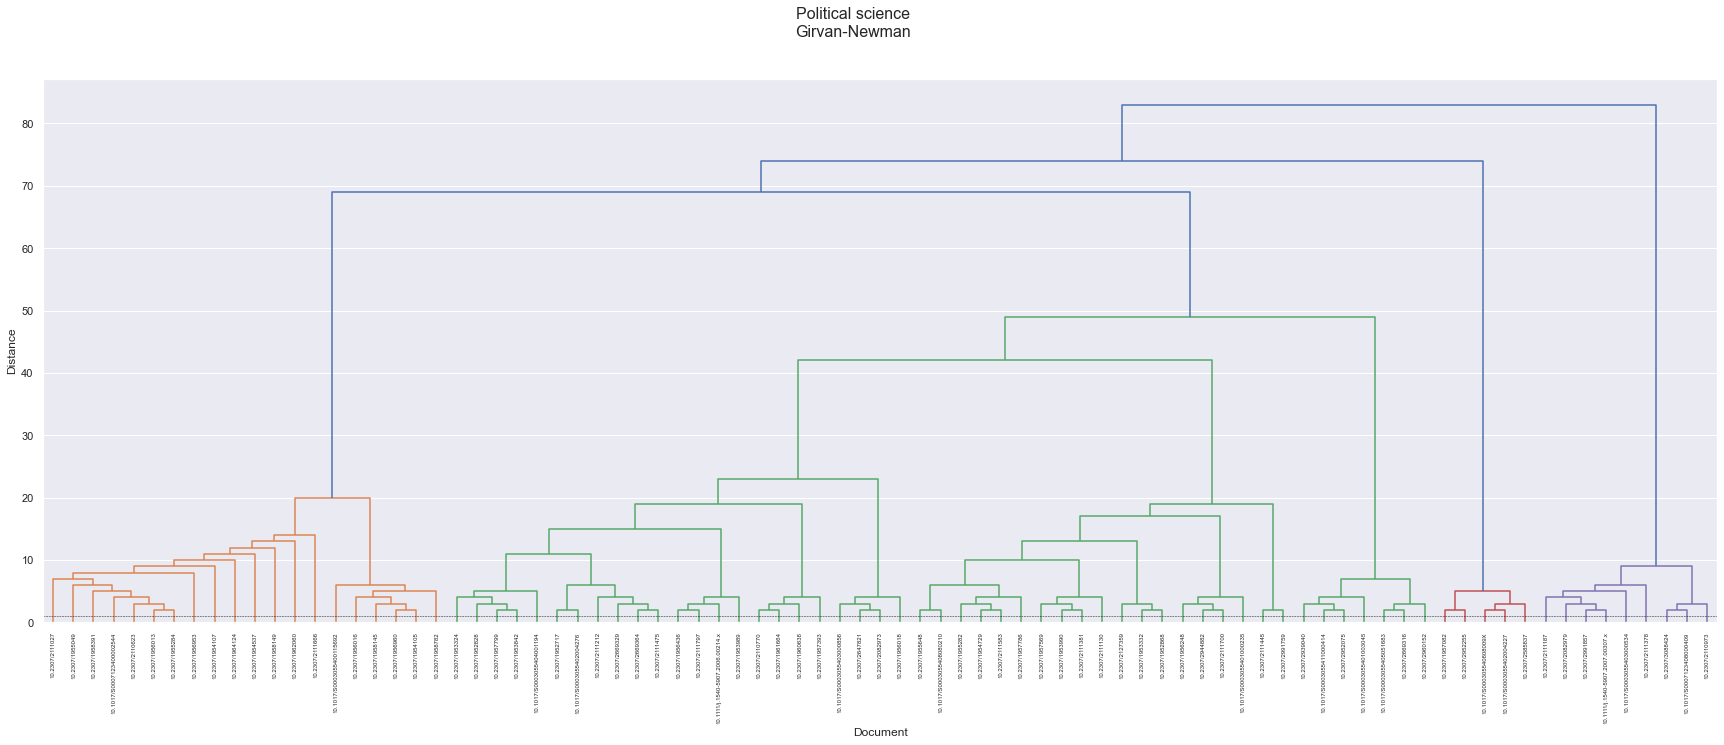

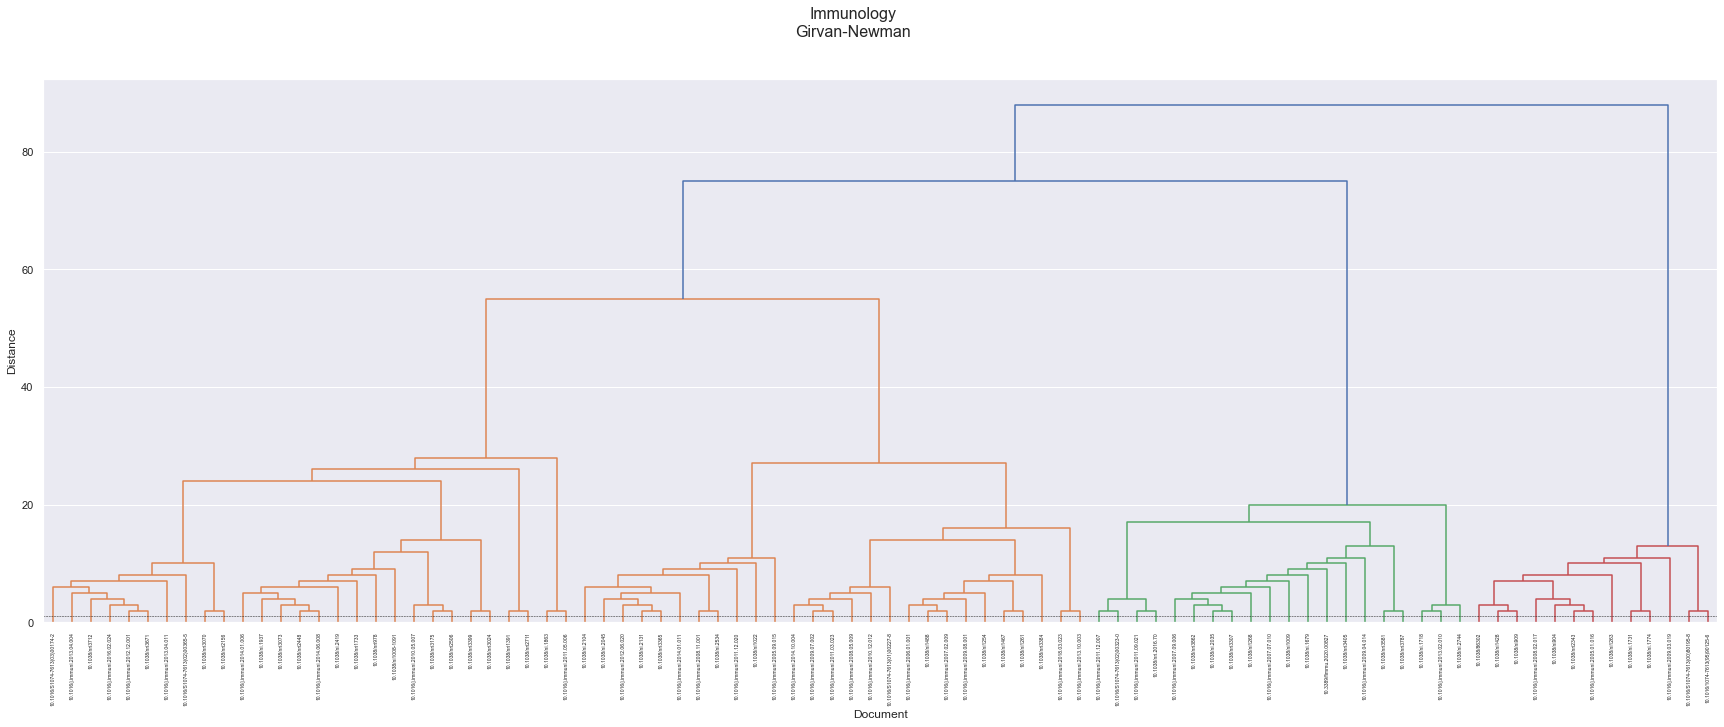

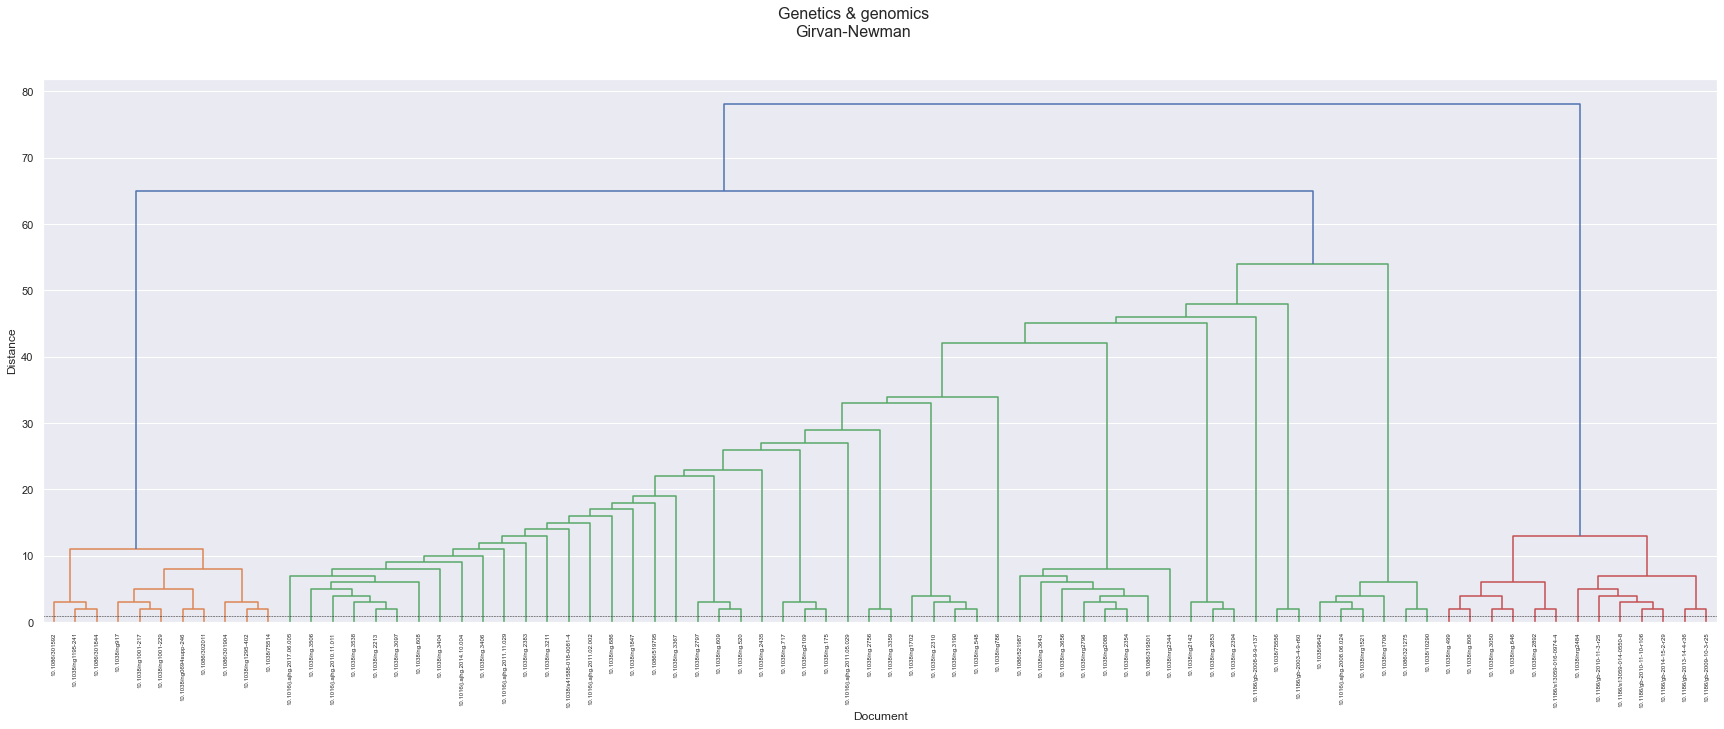

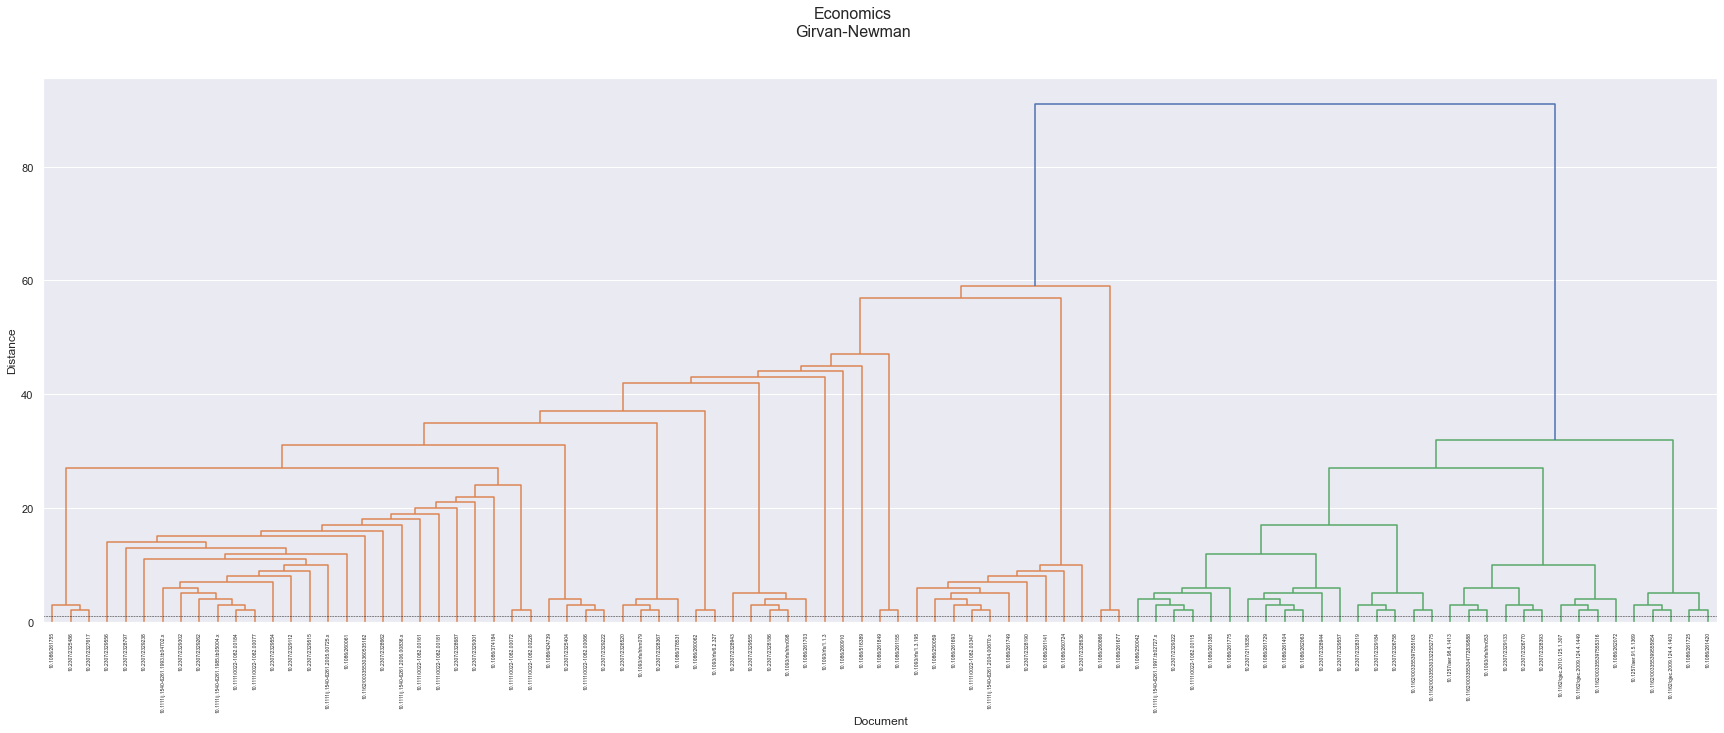

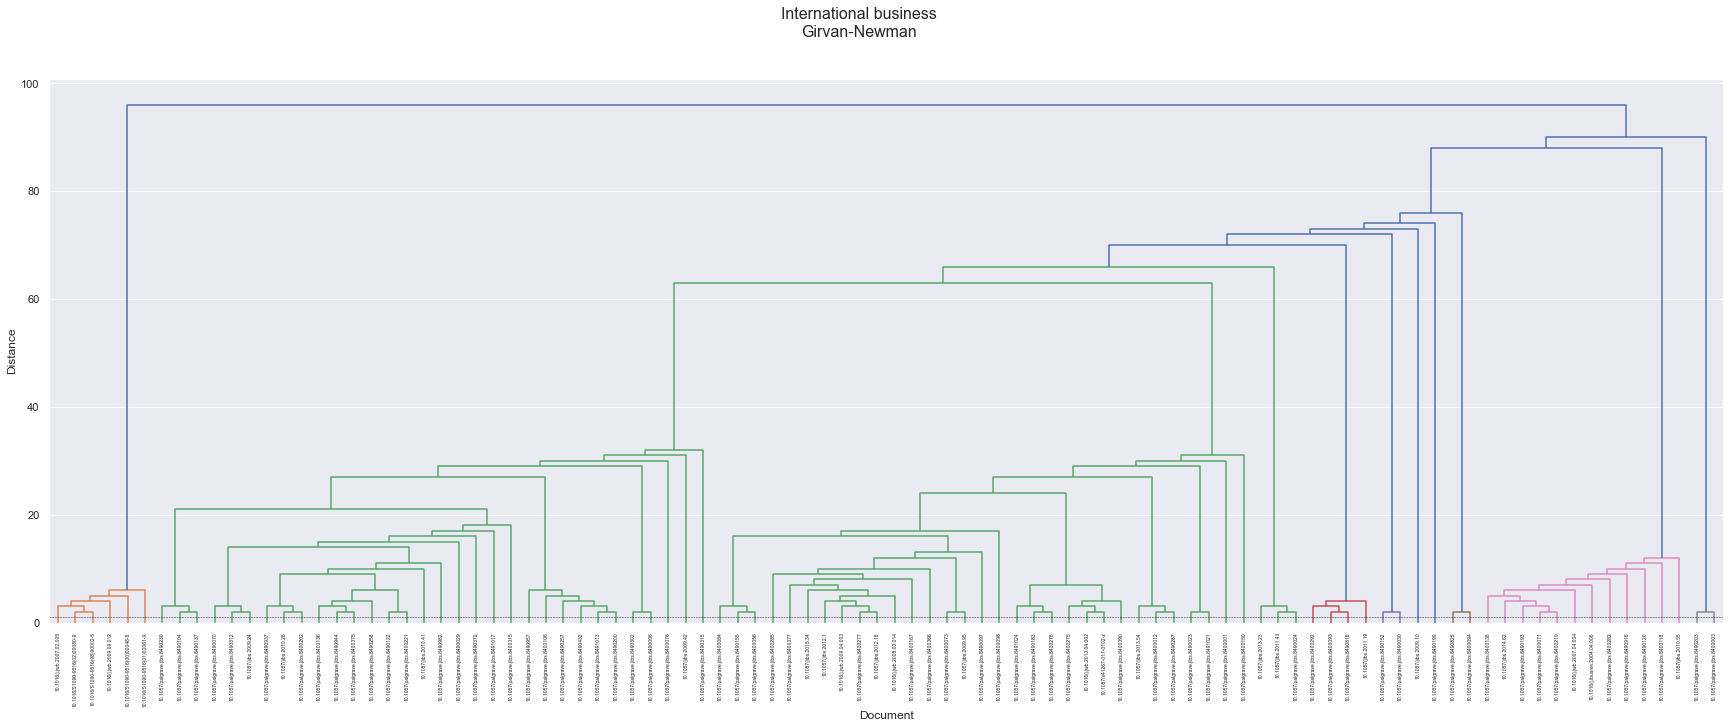

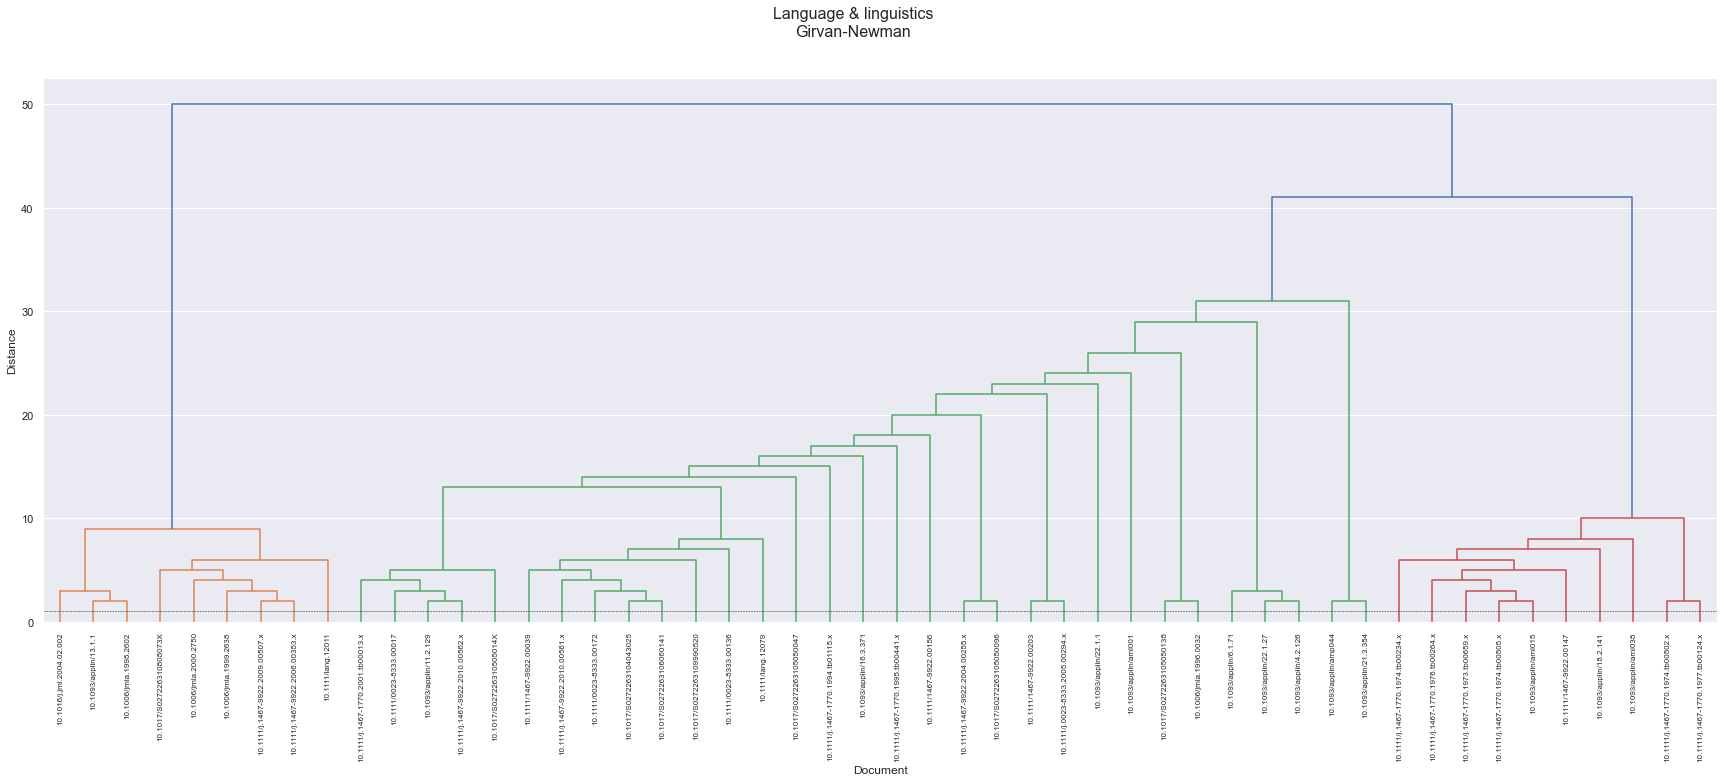

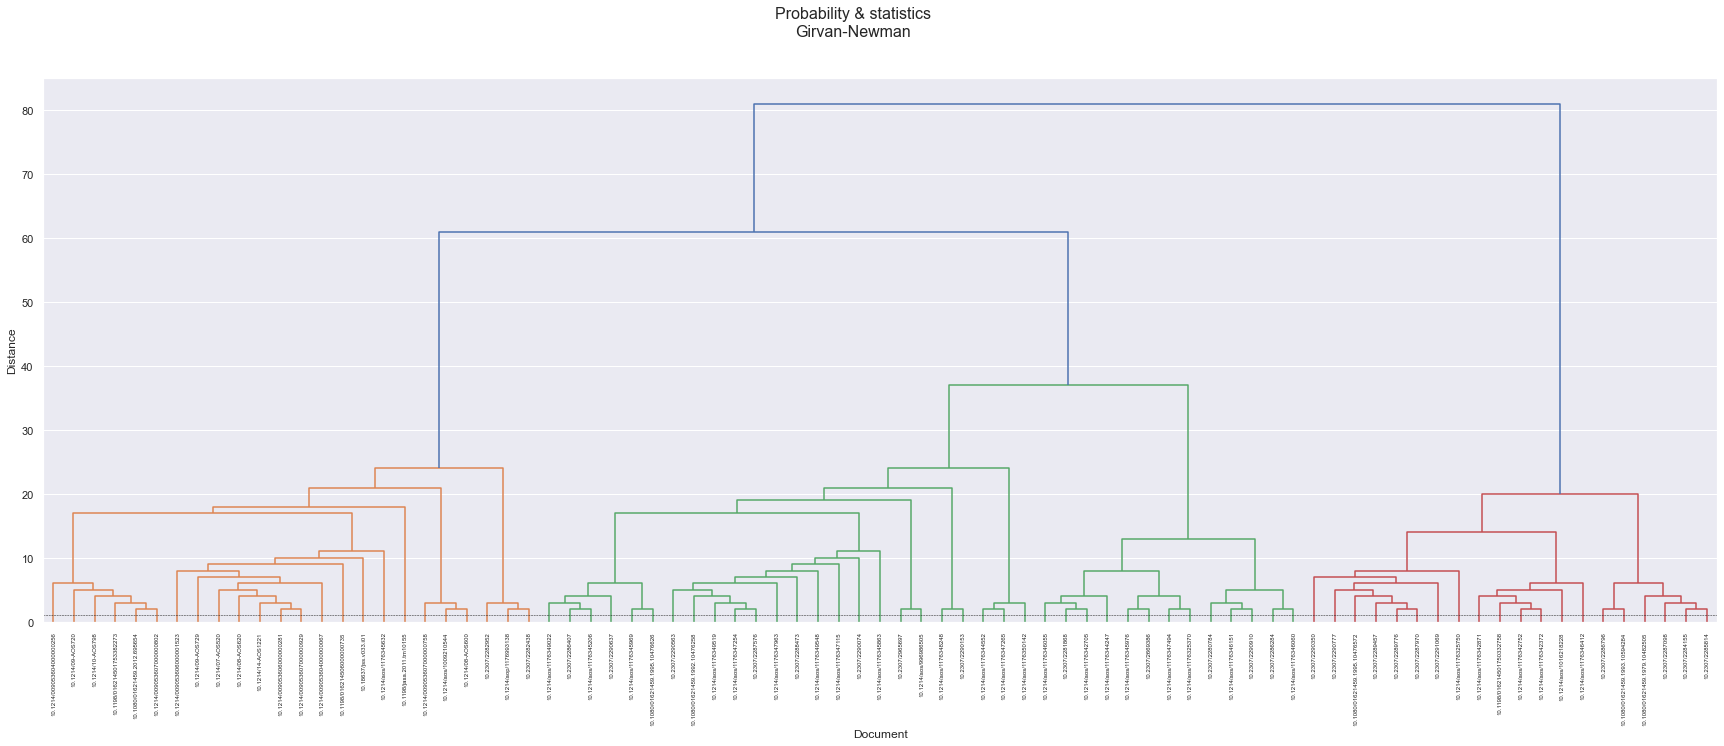

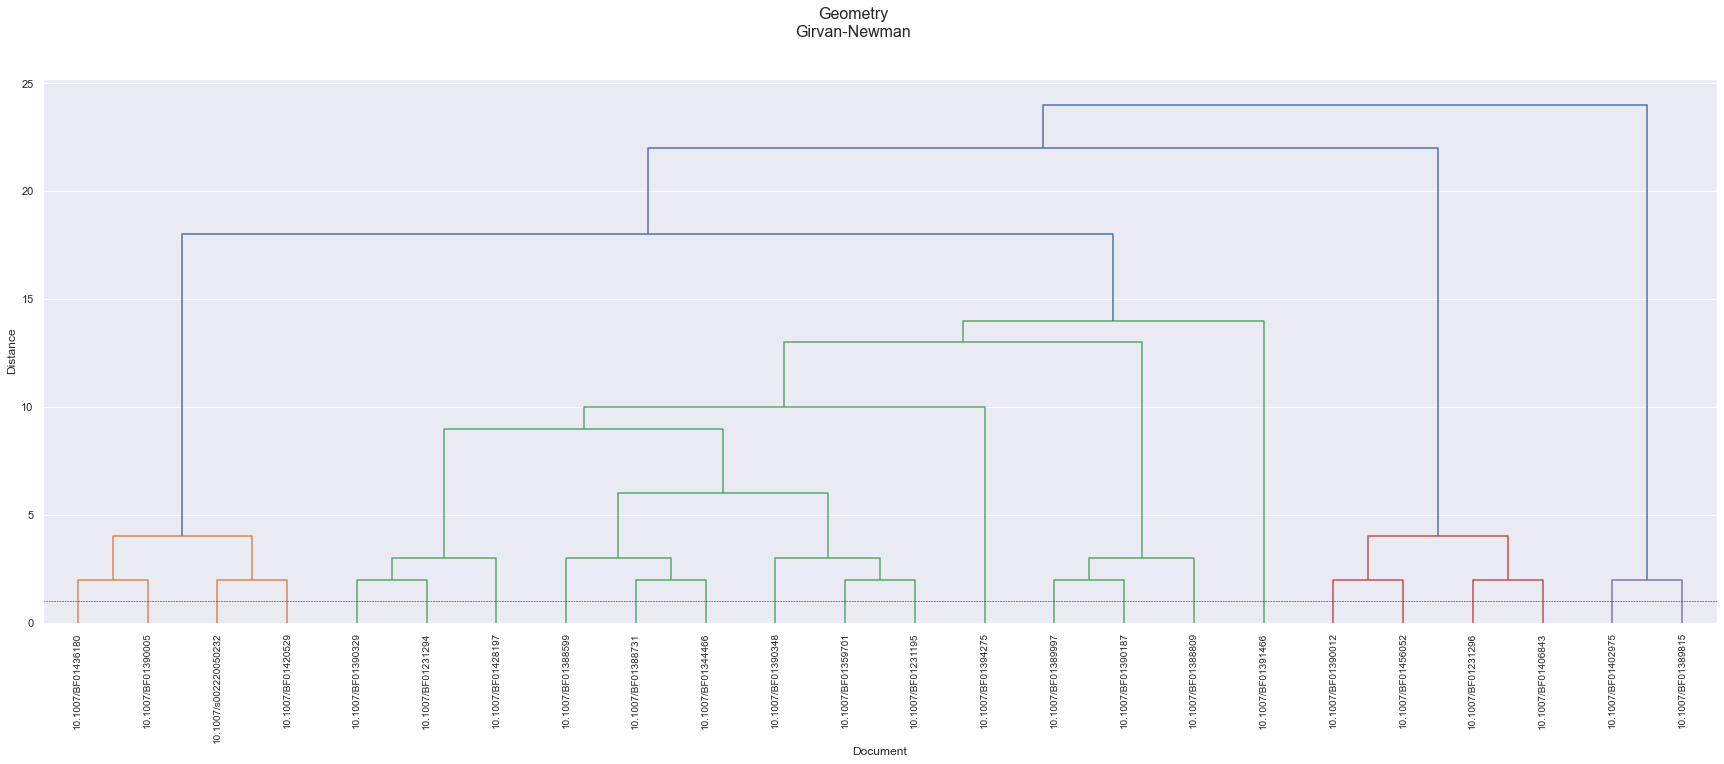

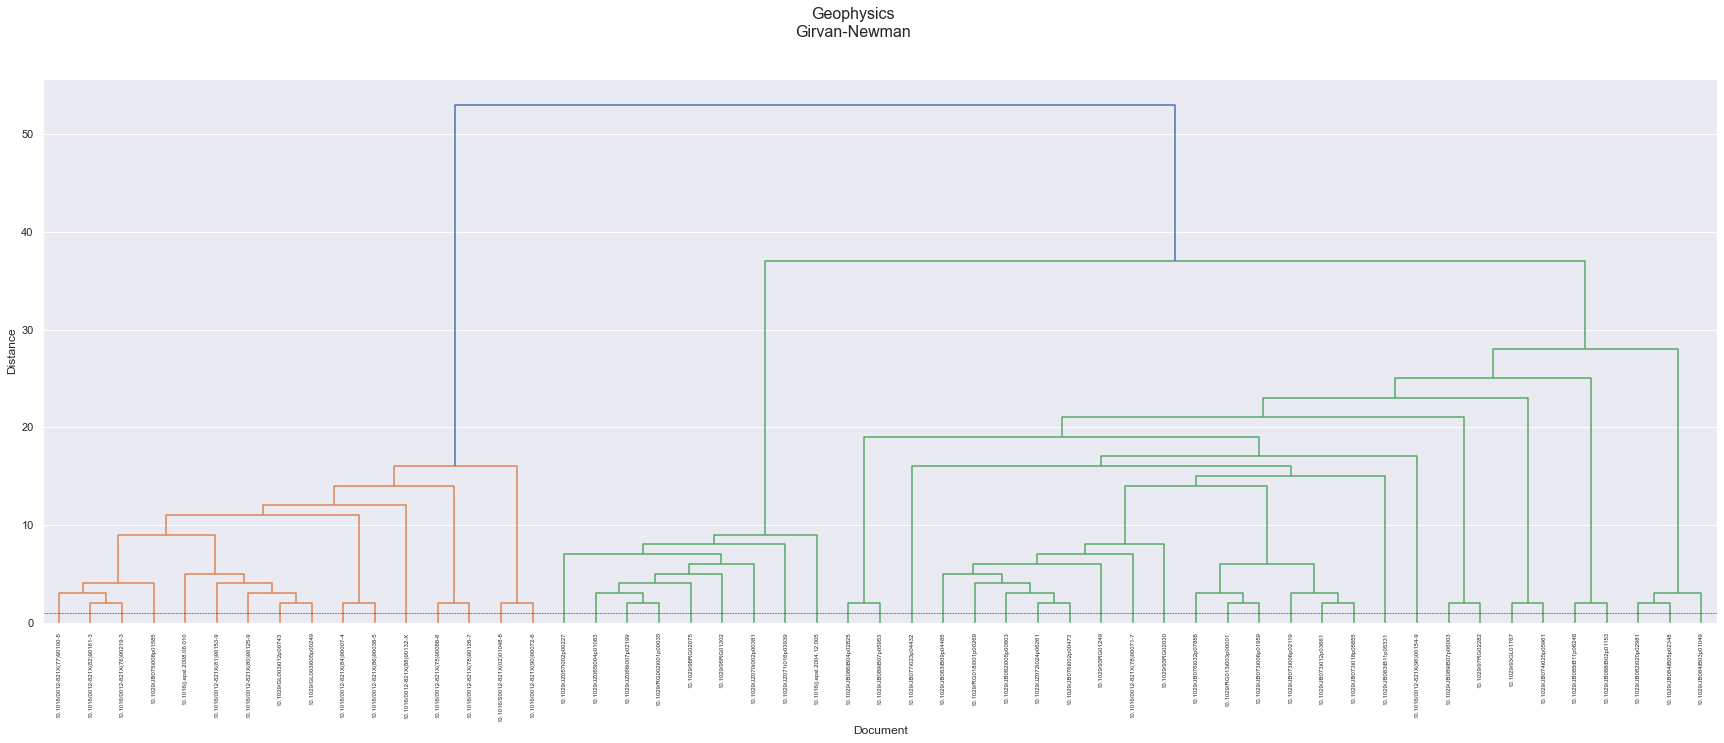

In [12]:
n = 100

girvan_newman_Z_leaves = {}

for (field_name, corpus) in corpora.data.items():
    
    G = corpus['citation_graph']

    in_dgree_centrality_dict = nx.in_degree_centrality(G)
    sorted_first_n_centrality_dict = dict(sorted(in_dgree_centrality_dict.items(), key=lambda x: x[1], reverse=True)[:n])
    nodes = sorted_first_n_centrality_dict.keys()

    G = G.subgraph(nodes)
    nodes = max(nx.weakly_connected_components(G), key=len)
    G = G.subgraph(nodes)

    levels = list(community.girvan_newman(G))
    levels.insert(0, (set(nodes),))

    Z_girvan_newman, leaves_girvan_newman = compute_Z(levels)

    girvan_newman_Z_leaves[field_name] = {
        'Z': Z_girvan_newman,
        'leaves': leaves_girvan_newman
    }

    sns.set()

    fig = plt.figure(figsize=(30, 10))
    axes = fig.subplots(1)
    plt.title('')
    plt.xlabel('Document')
    plt.ylabel('Distance')
    dendrogram(Z_girvan_newman, labels=leaves_girvan_newman)
    axes.yaxis.grid(True)
    axes.xaxis.grid(False)
    plt.axhline(y=1.0, c='k', ls='--', lw=0.5)
    fig.set_facecolor('w')
    fig.suptitle(f'{field_name}\nGirvan-Newman', fontsize=16)
    plt.xticks(rotation=90)

    # plt.savefig(f'{img_path}/girvan_newman_communities_{field_name}.png')
    plt.show()


## TfIdf - Cosine Similarity

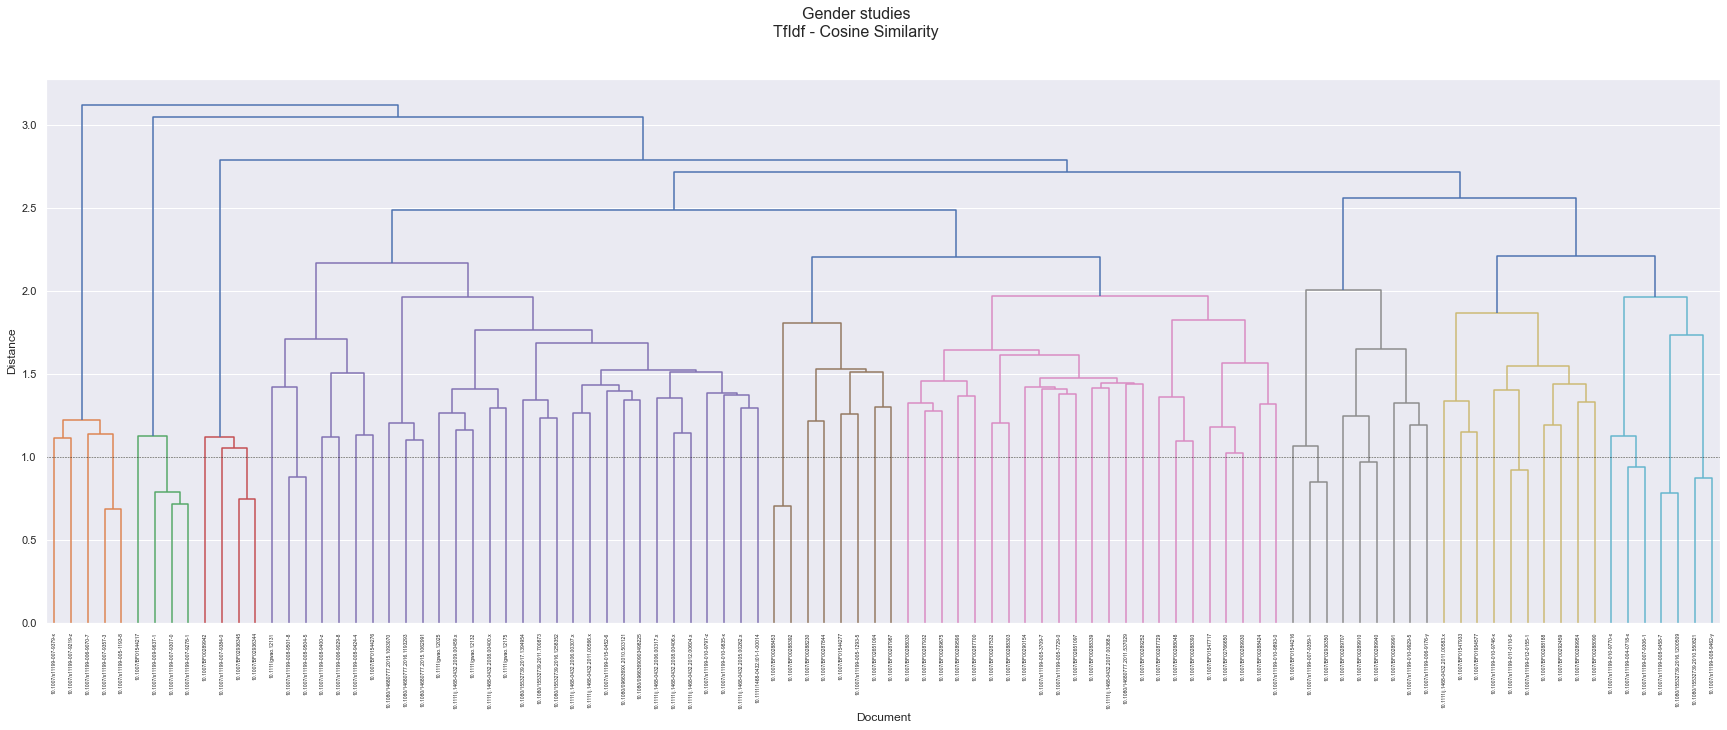

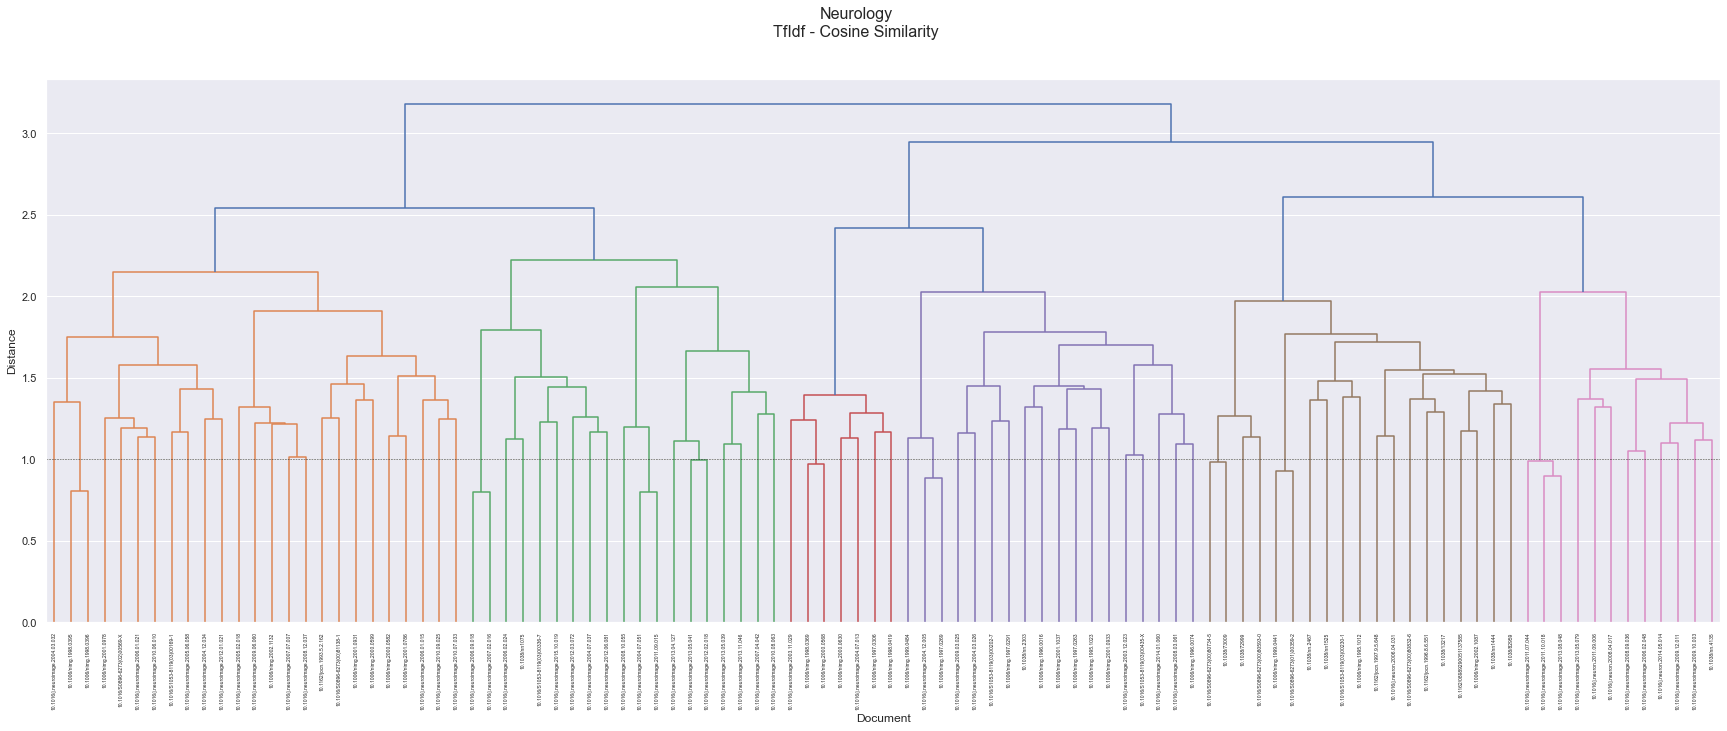

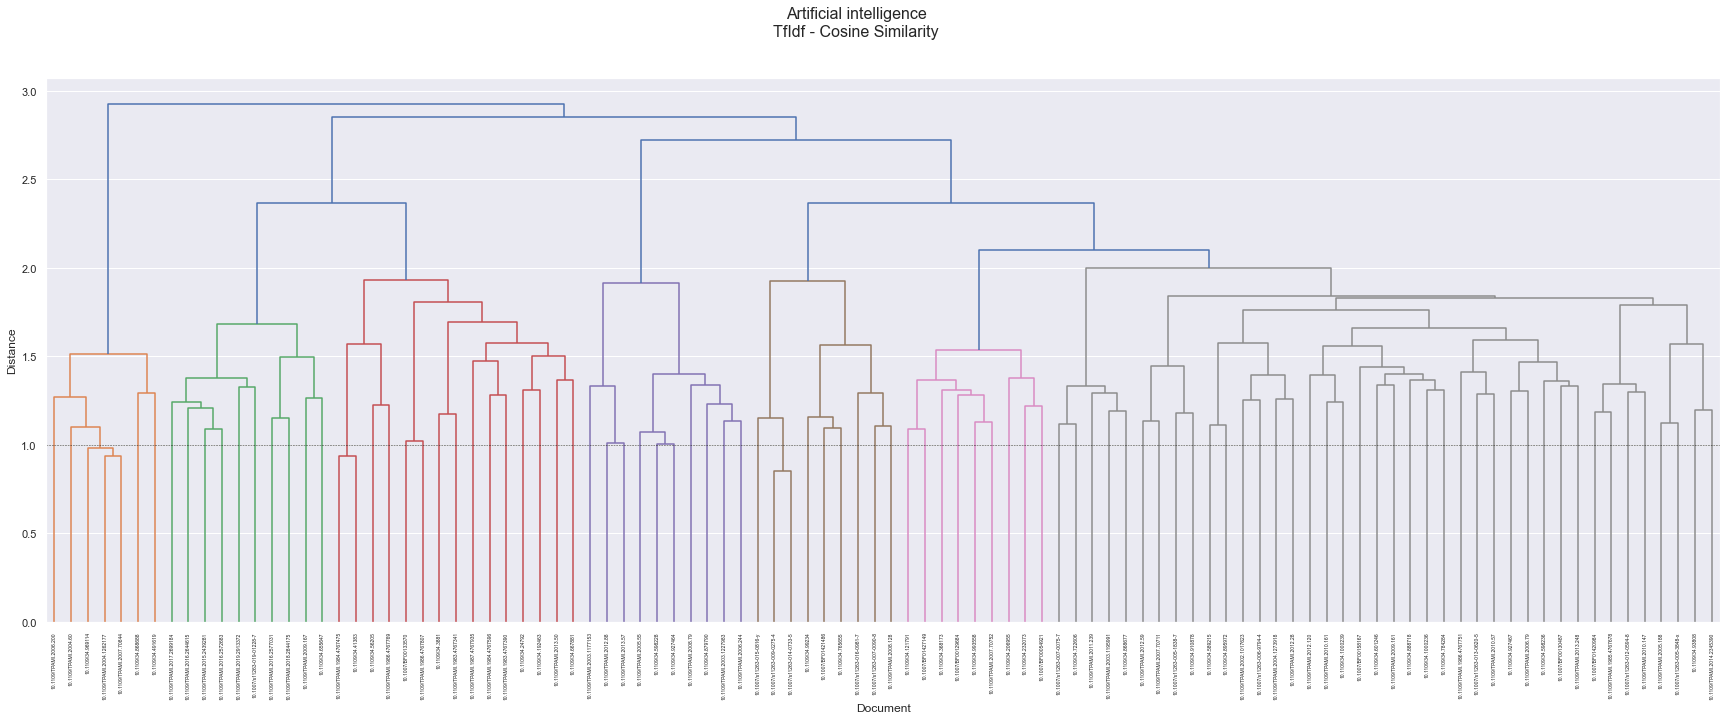

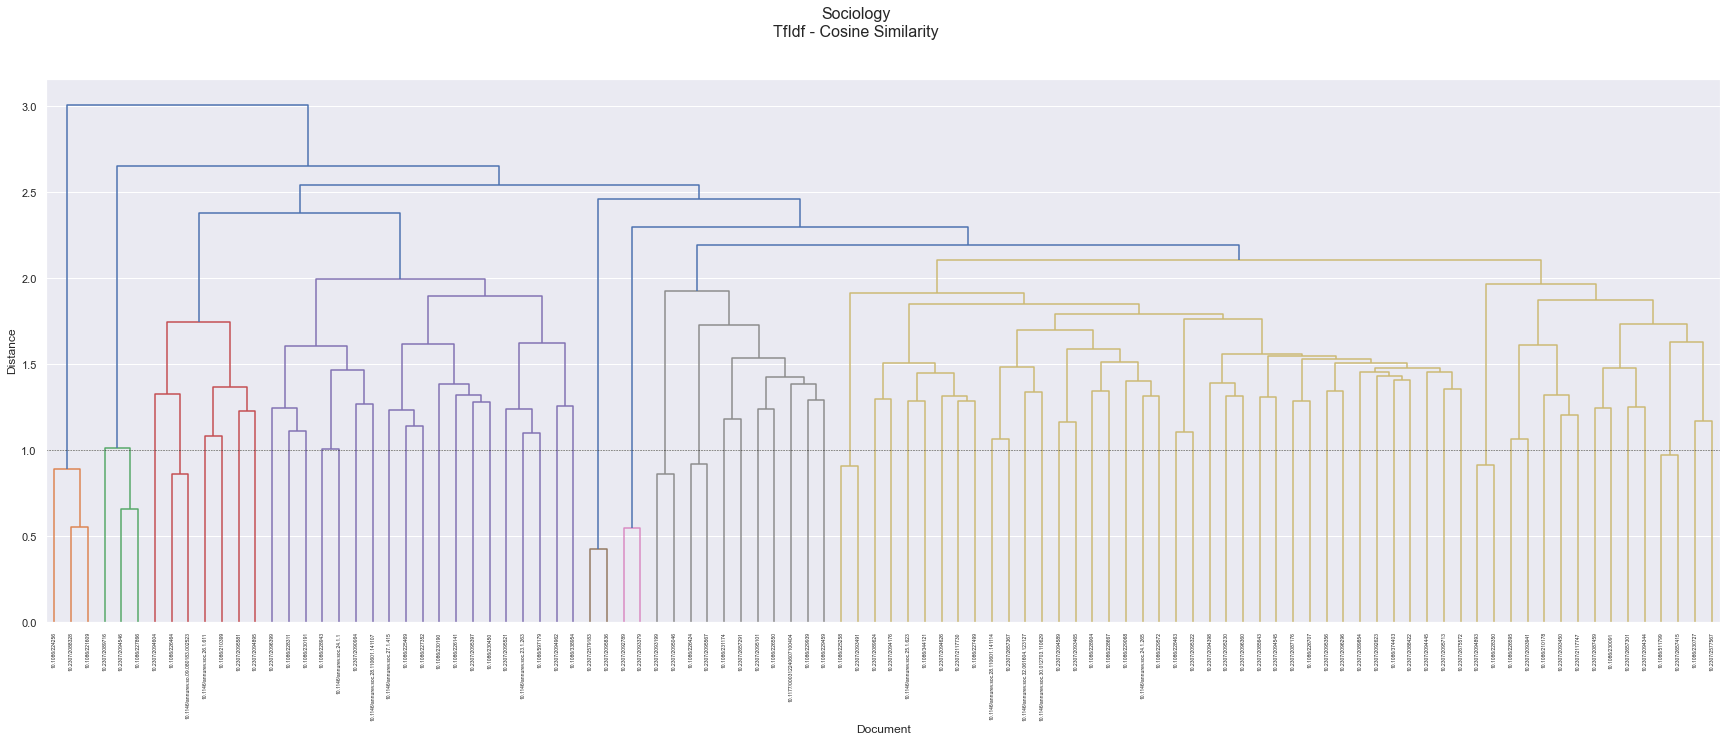

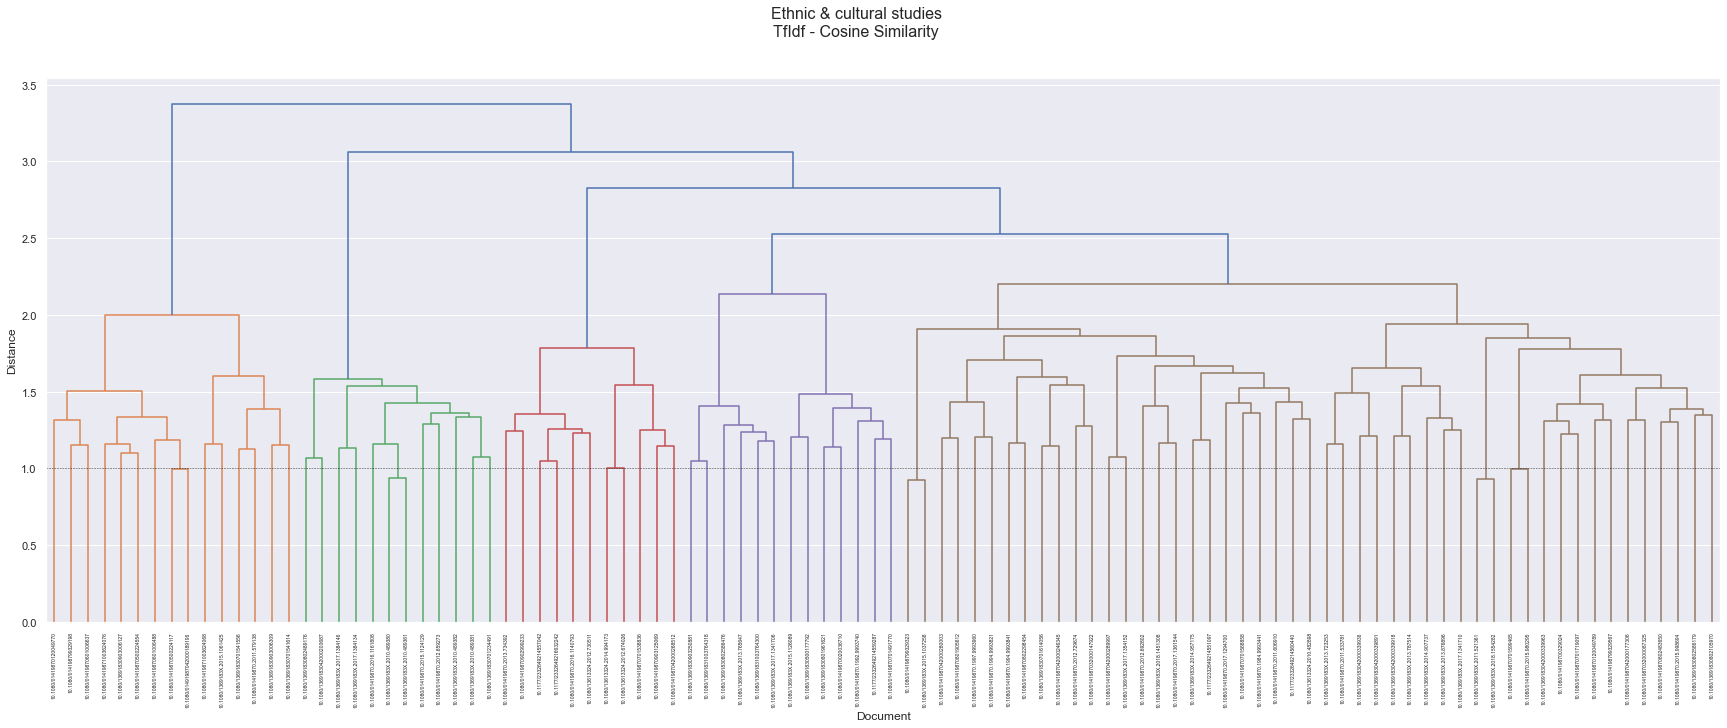

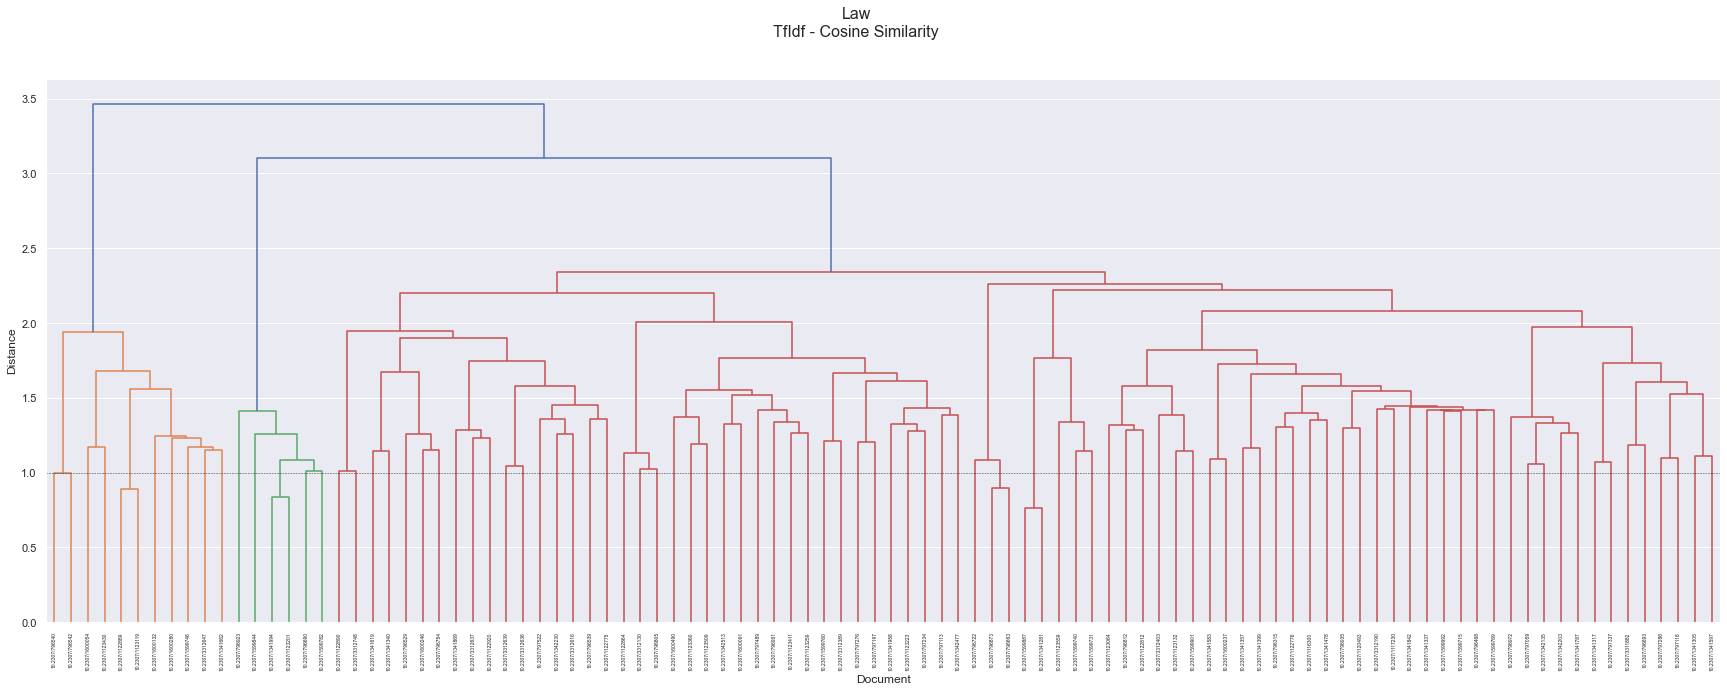

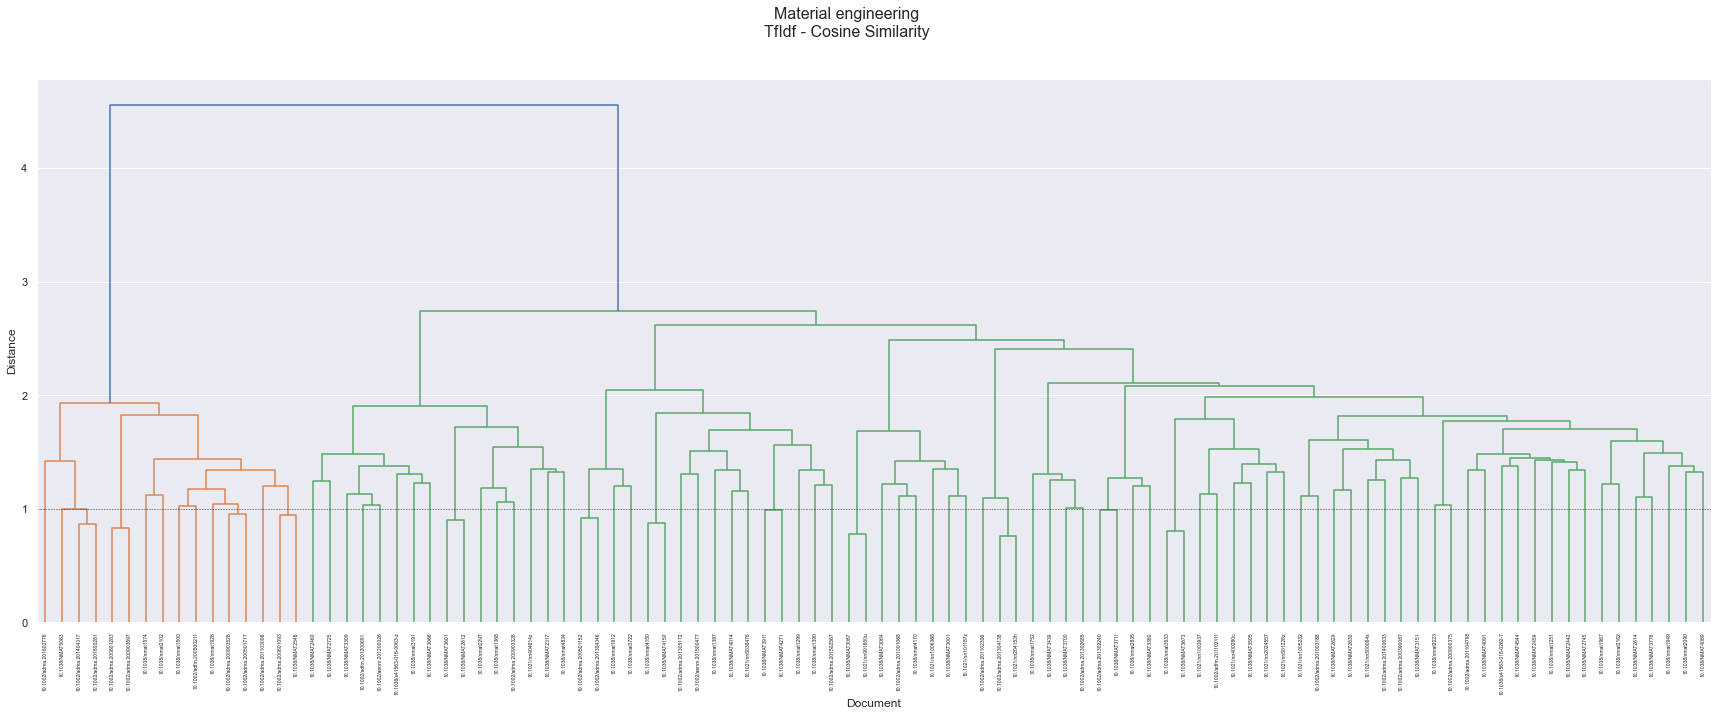

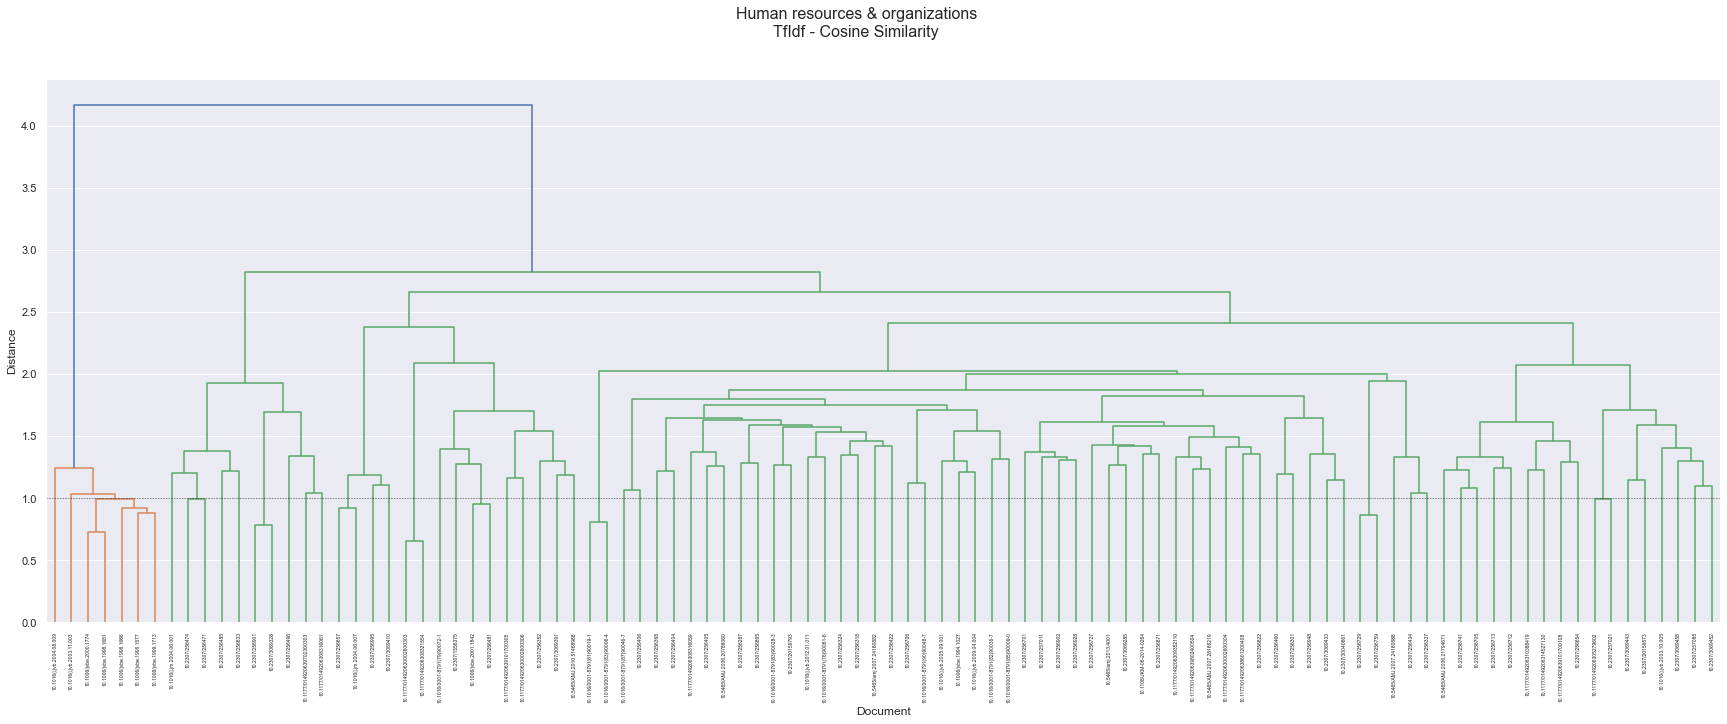

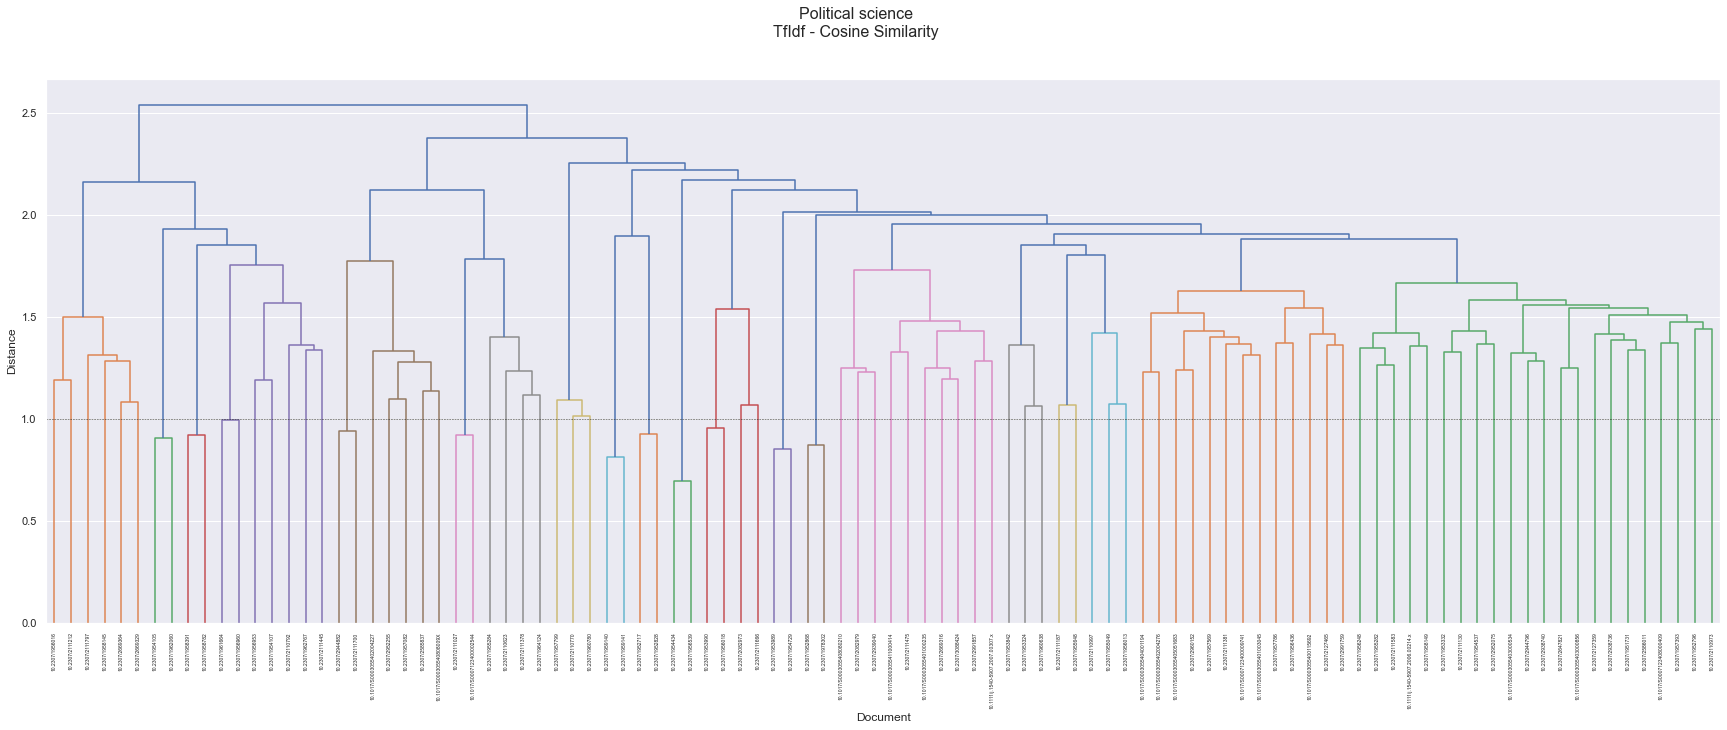

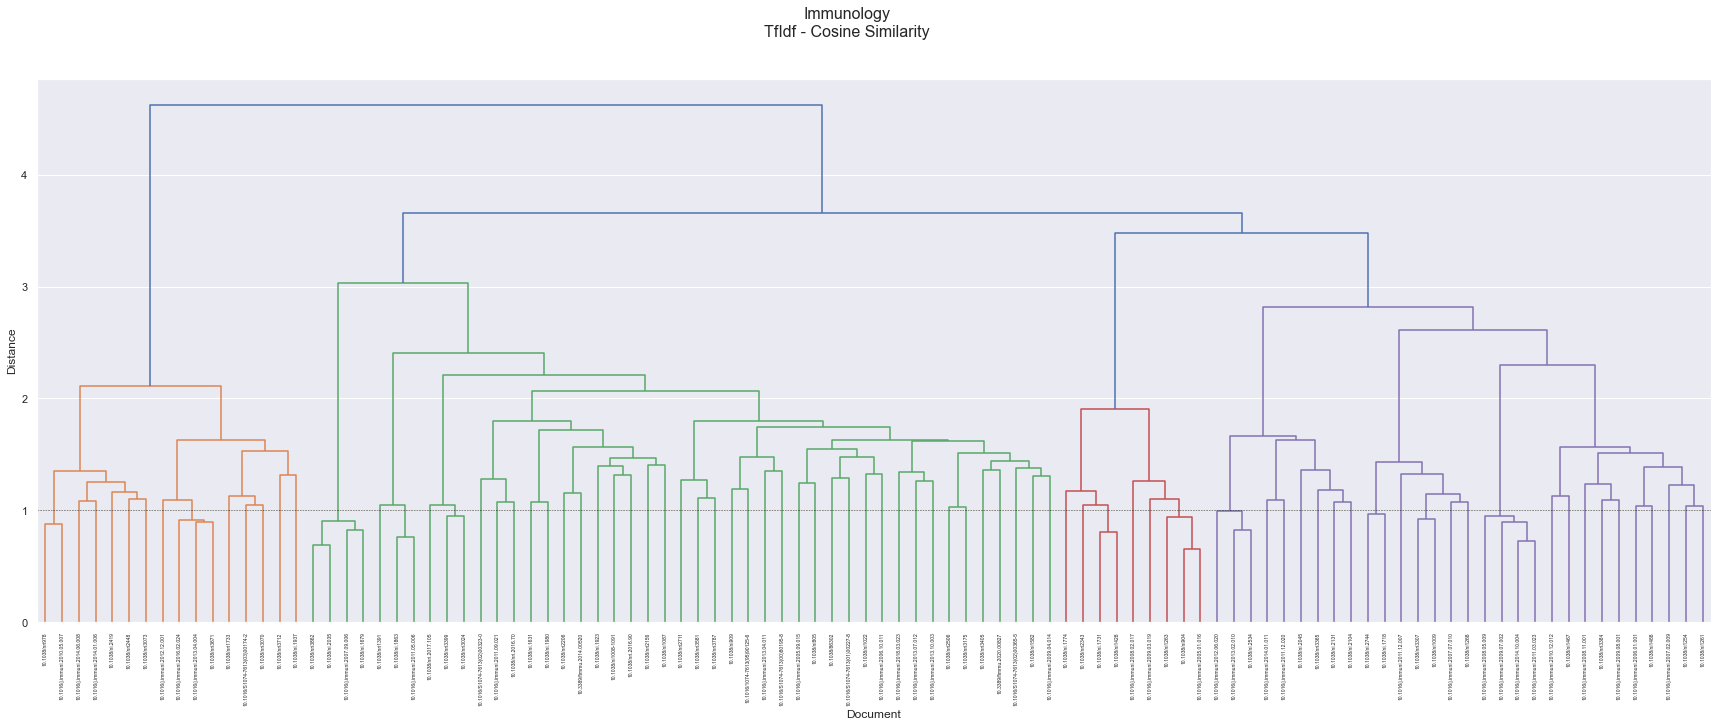

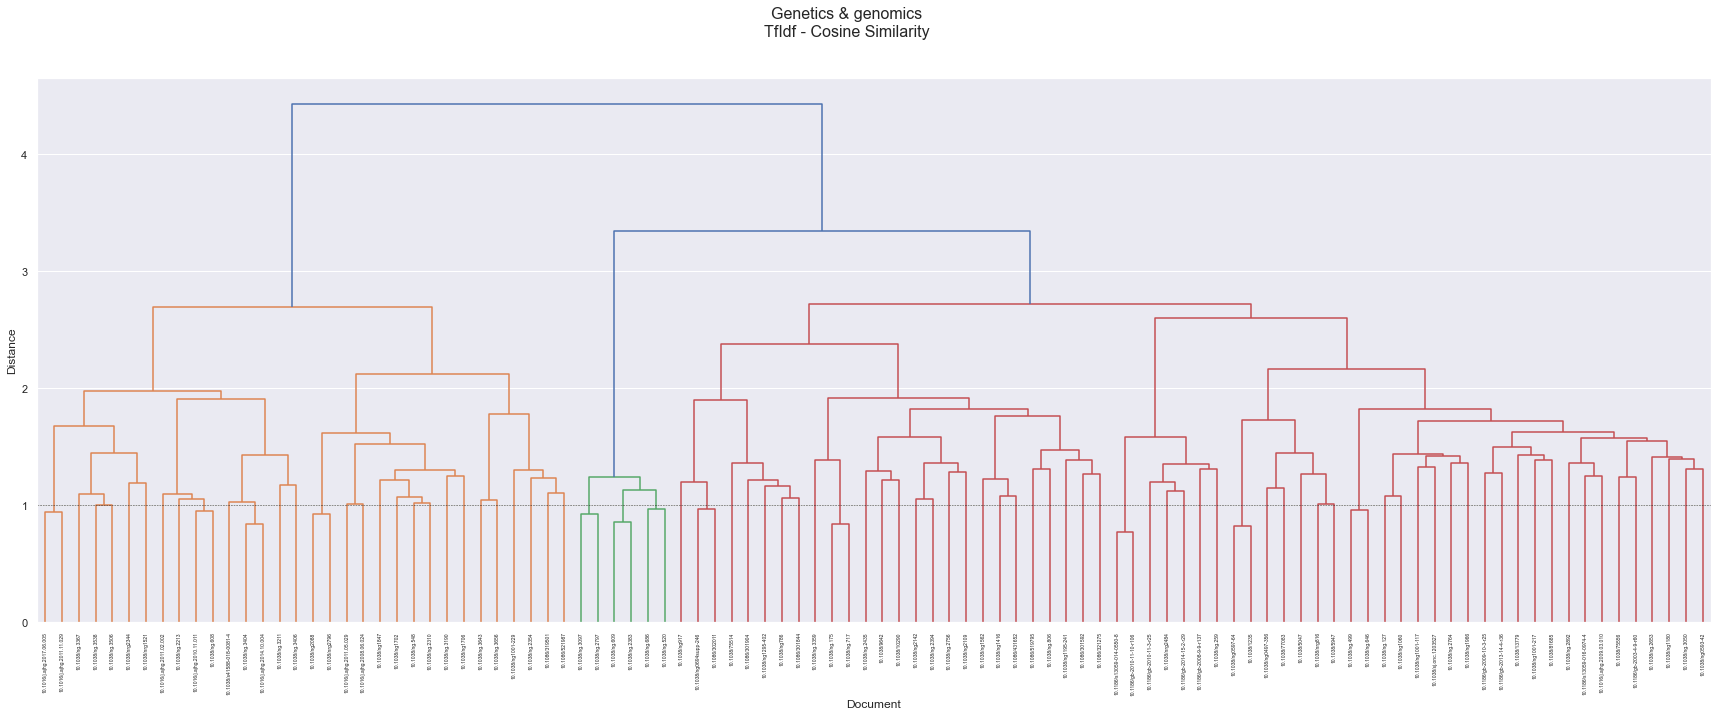

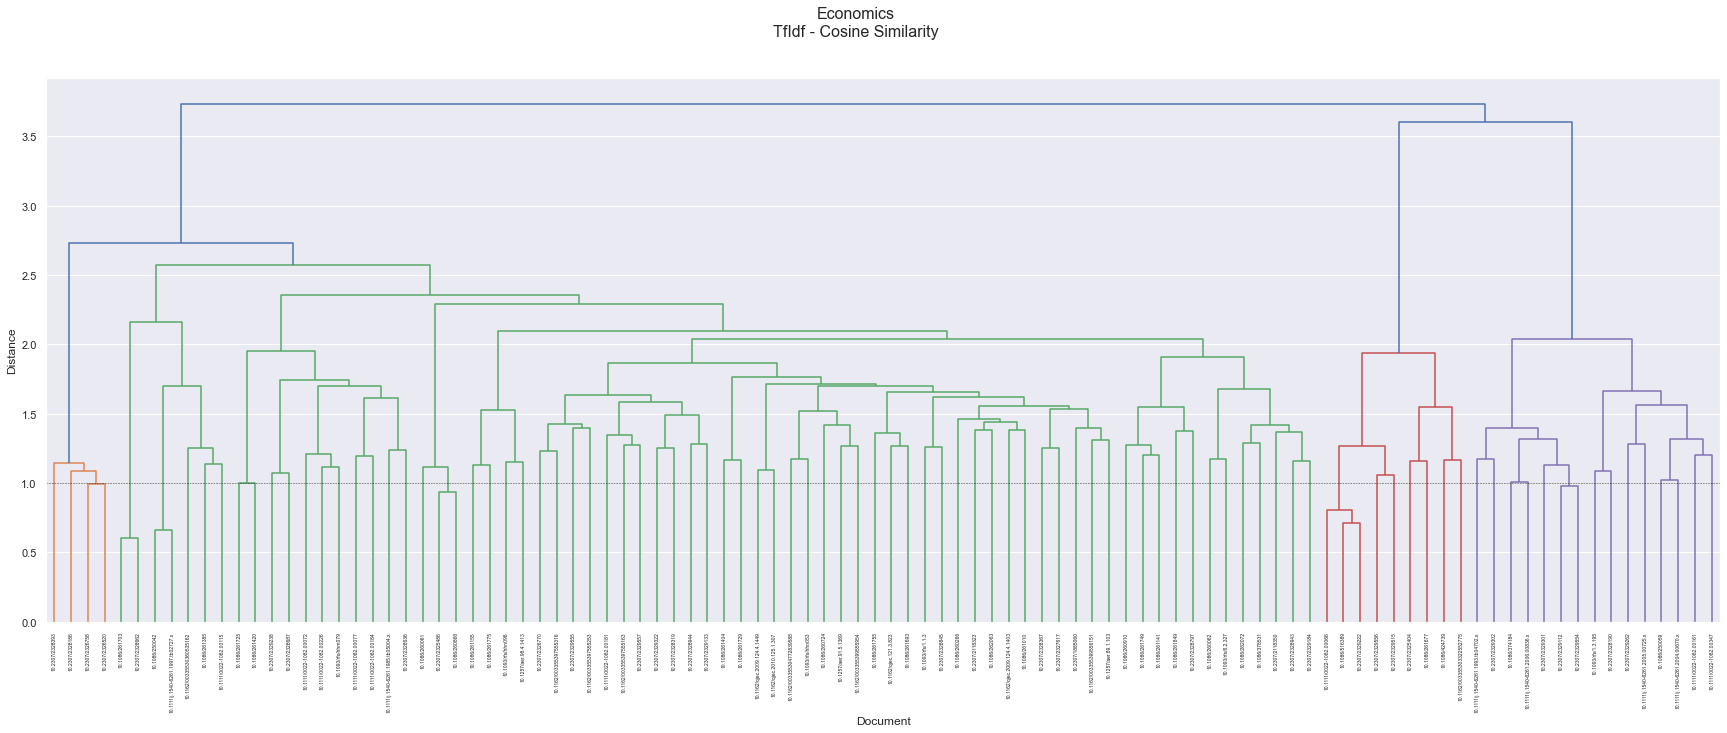

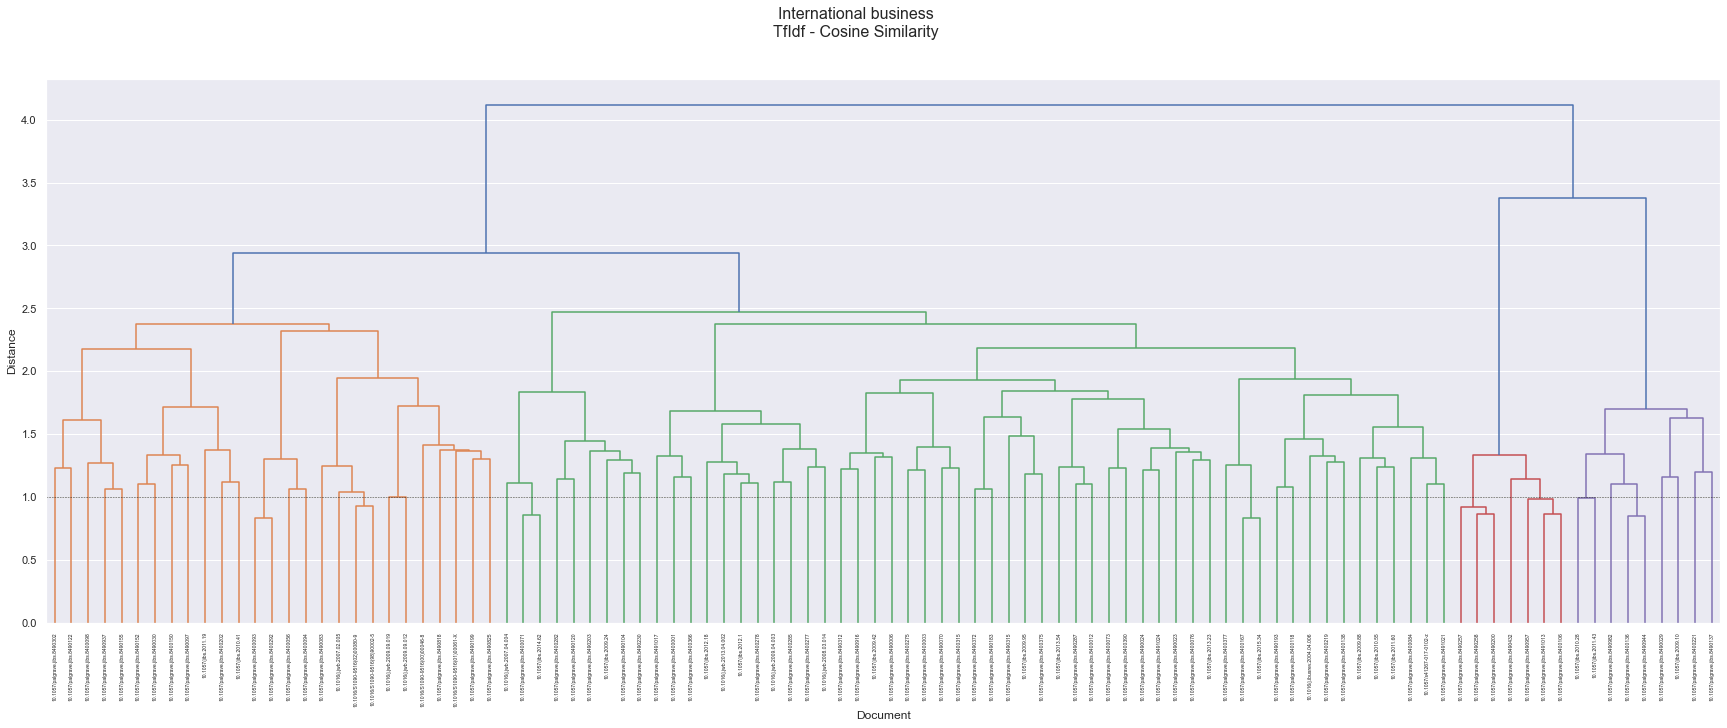

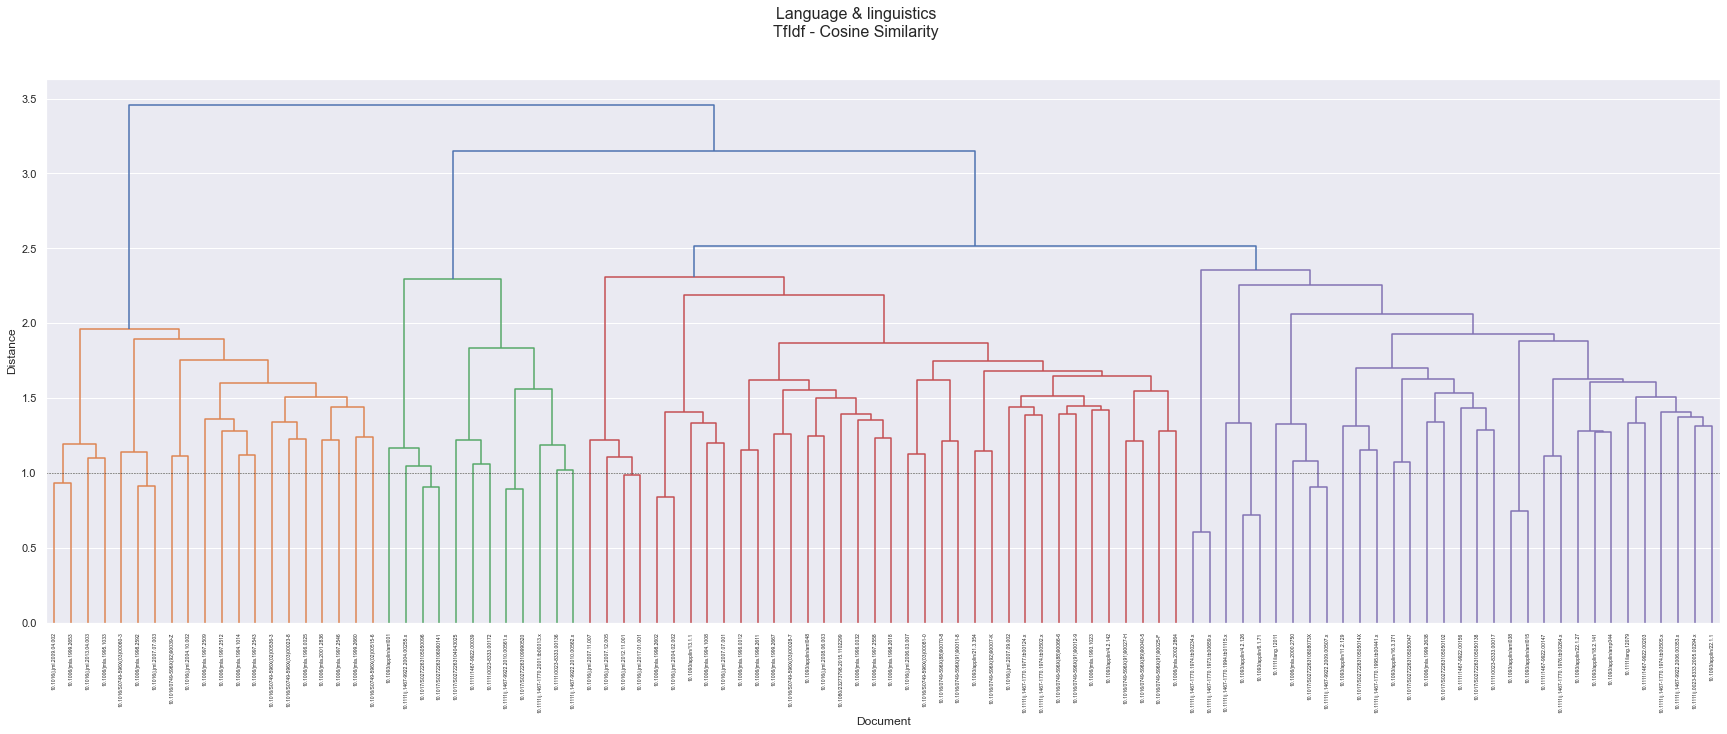

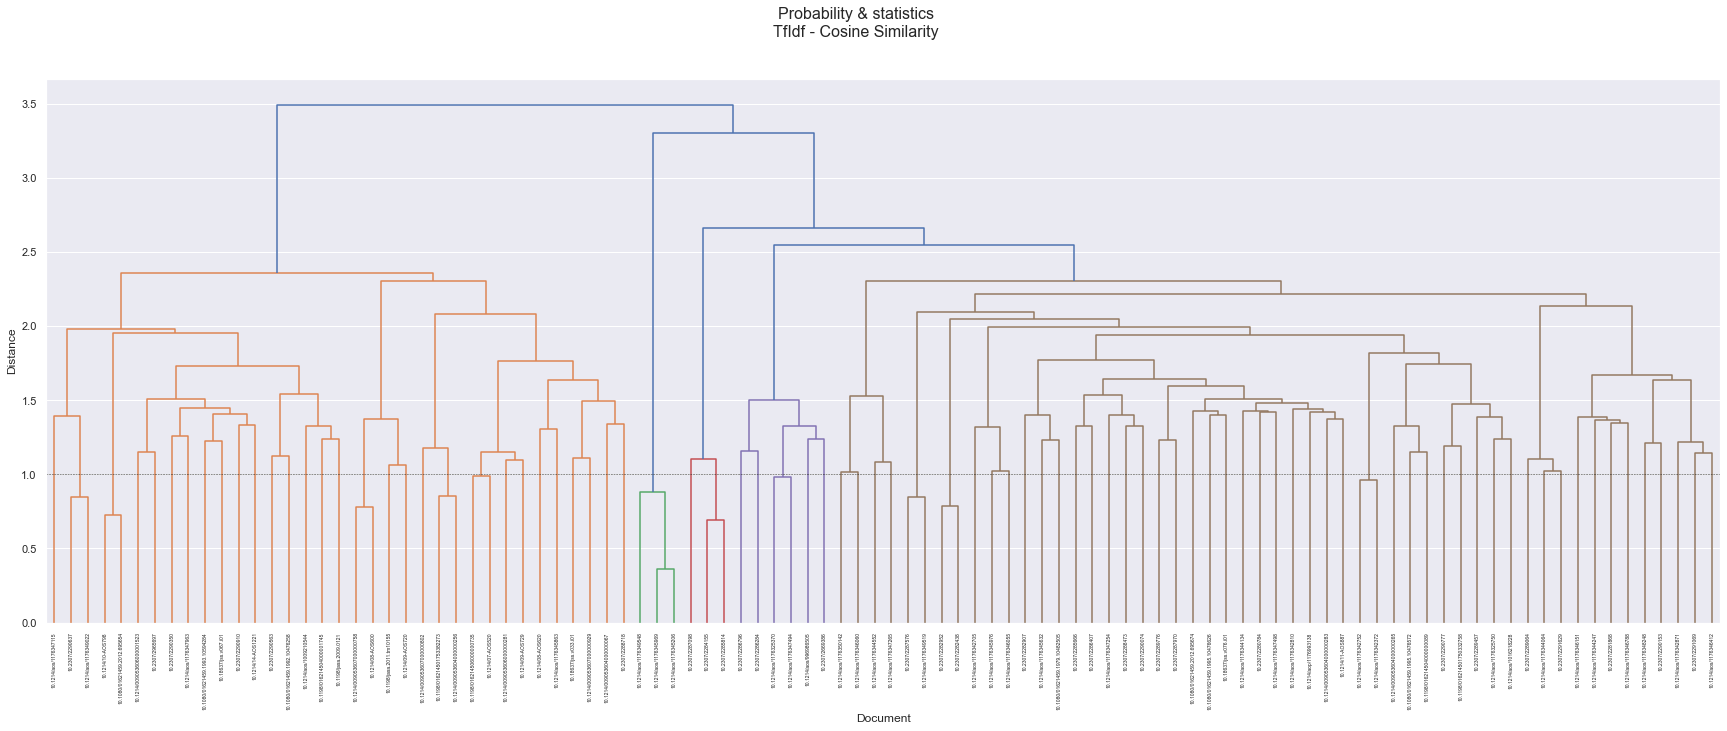

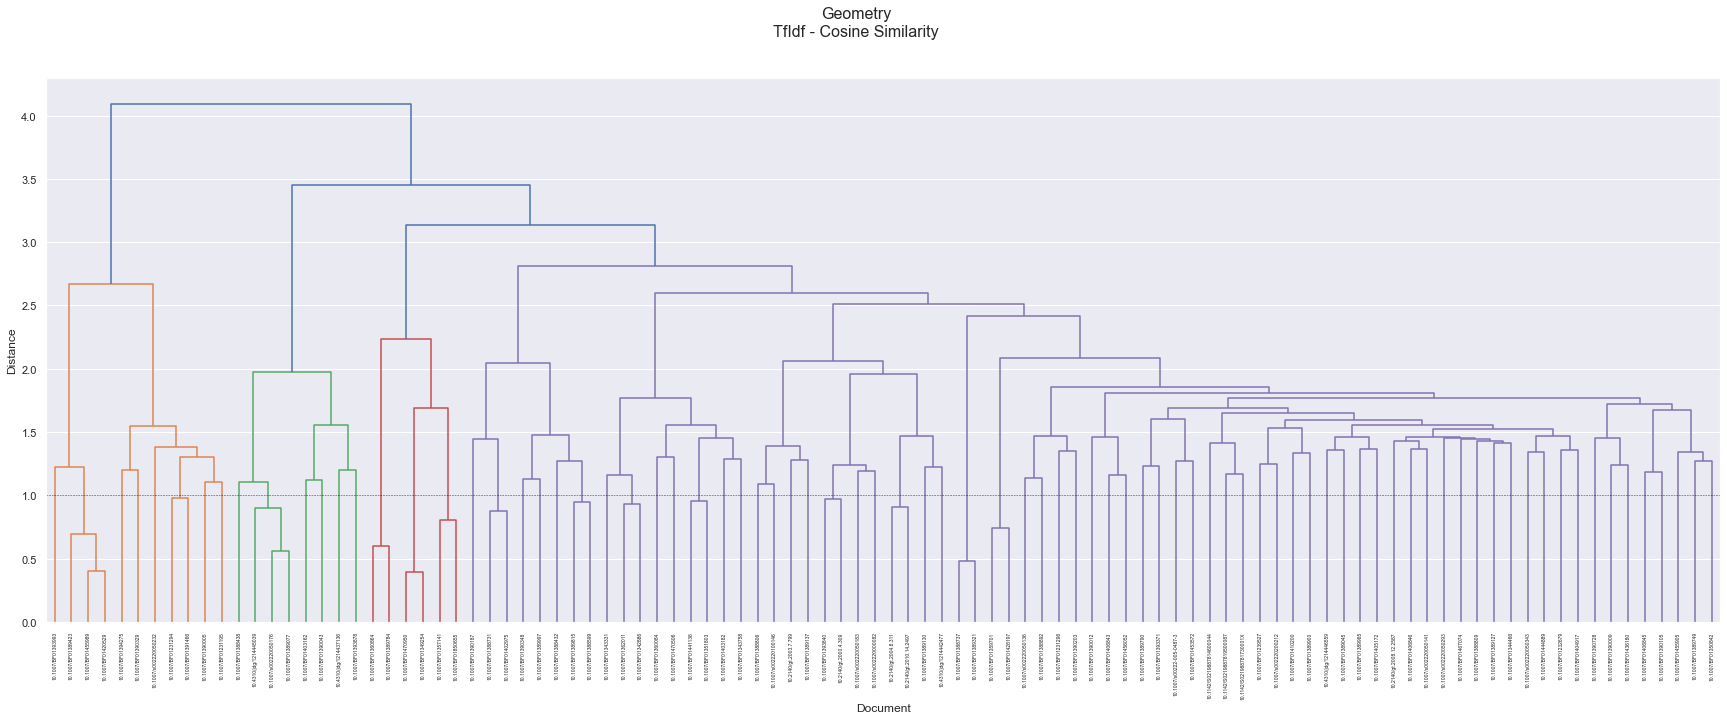

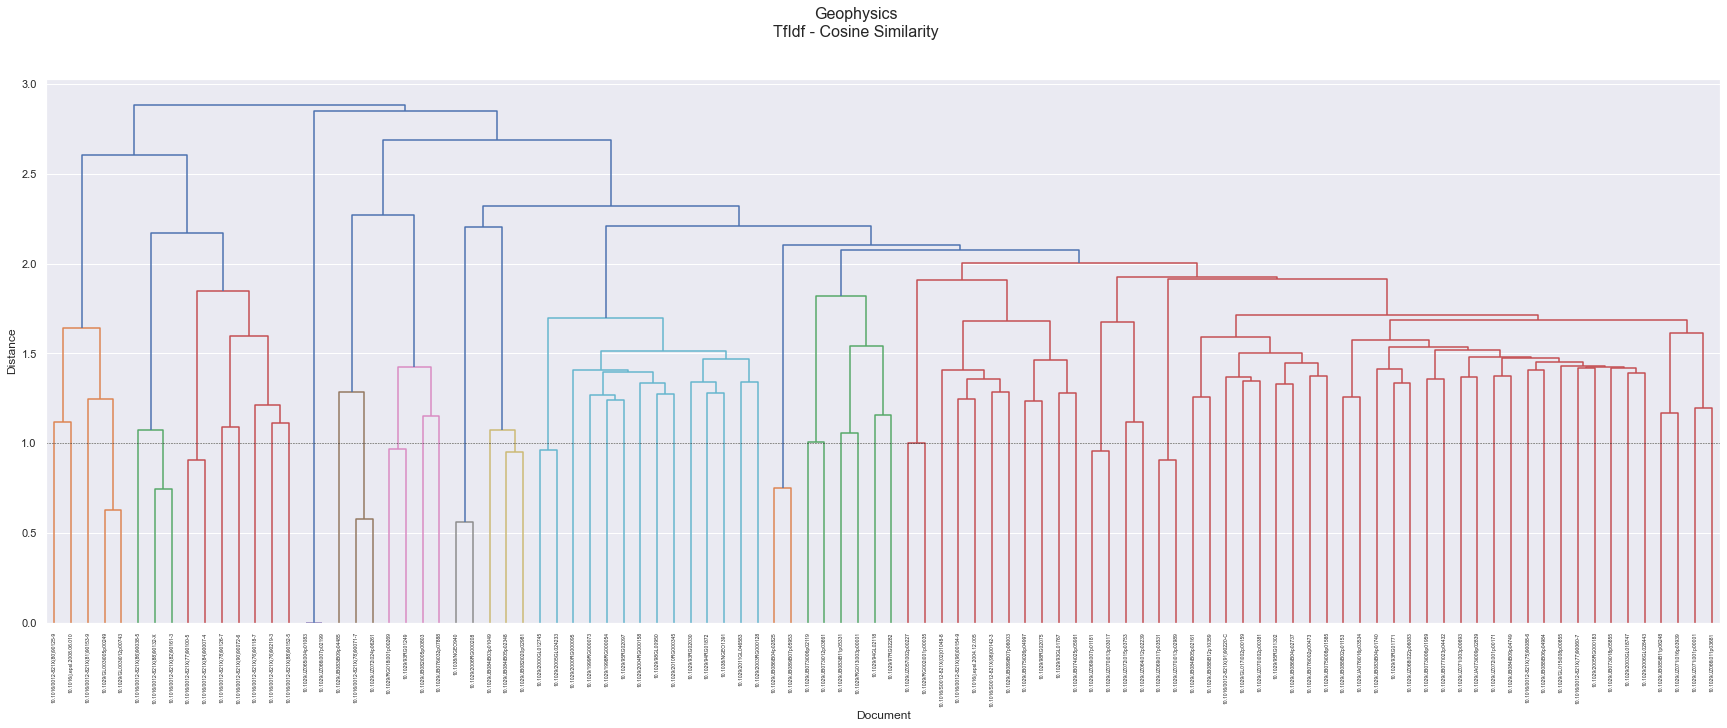

In [14]:
n = 100

tfidf_cossim_Z_leaves = {}

for (field_name, corpus) in corpora.data.items():
    df = corpus['citation_df']
    G = corpus['citation_graph']
    
    dois, texts = df.select(['Doi', 'Text'])
    dois = dois.to_list()

    tv = TfidfVectorizer()
    tv_matrix = tv.fit_transform(texts).toarray()
    vocab = tv.get_feature_names_out()

    in_dgree_centrality_dict = nx.in_degree_centrality(G)
    sorted_first_n_centrality_dict = dict(sorted(in_dgree_centrality_dict.items(), key=lambda x: x[1], reverse=True)[:n])
    leaves_tfidf_cossim = list(sorted_first_n_centrality_dict.keys())

    indices = [dois.index(doi) for doi in leaves_tfidf_cossim]
    m = tv_matrix[indices]

    similarity = cosine_similarity(m).round(3)
    Z_tfidf_cossim = linkage(similarity, 'ward')

    tfidf_cossim_Z_leaves[field_name] = {
        'Z': Z_tfidf_cossim,
        'leaves': leaves_tfidf_cossim,
    }

    fig = plt.figure(figsize=(30, 10))
    axes = fig.subplots(1)
    fig.suptitle(f'{field_name}\nTfIdf - Cosine Similarity', fontsize=16)
    plt.xlabel('Document')
    plt.ylabel('Distance')
    dendrogram(Z_tfidf_cossim, labels=leaves_tfidf_cossim)
    axes.yaxis.grid(True)
    axes.xaxis.grid(False)
    fig.set_facecolor('w')
    plt.axhline(y=1.0, c='k', ls='--', lw=0.5)

    # plt.savefig(f'{img_path}/tfidf_cossim_communities_{field_name}.png')
    plt.show()

## Louvain (Driected)

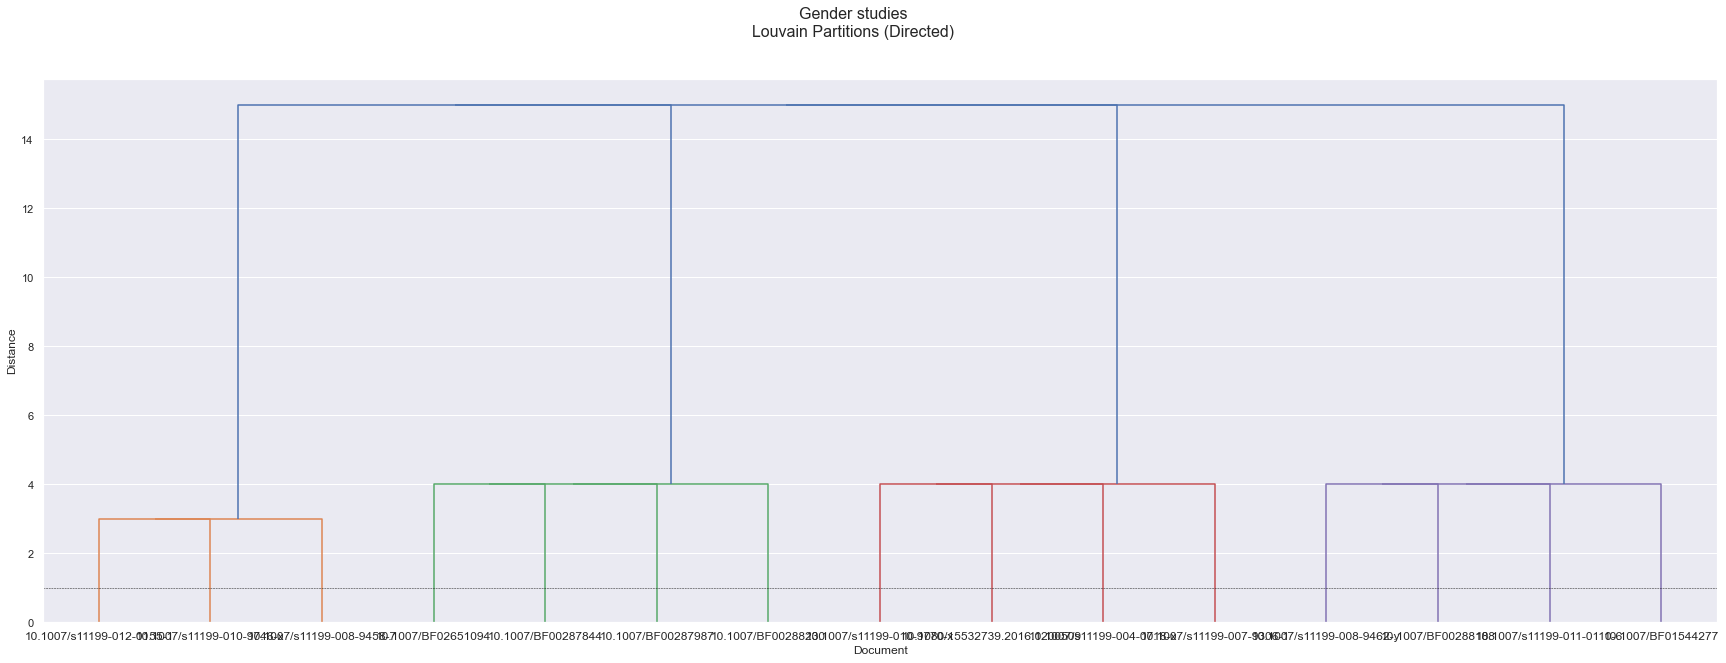

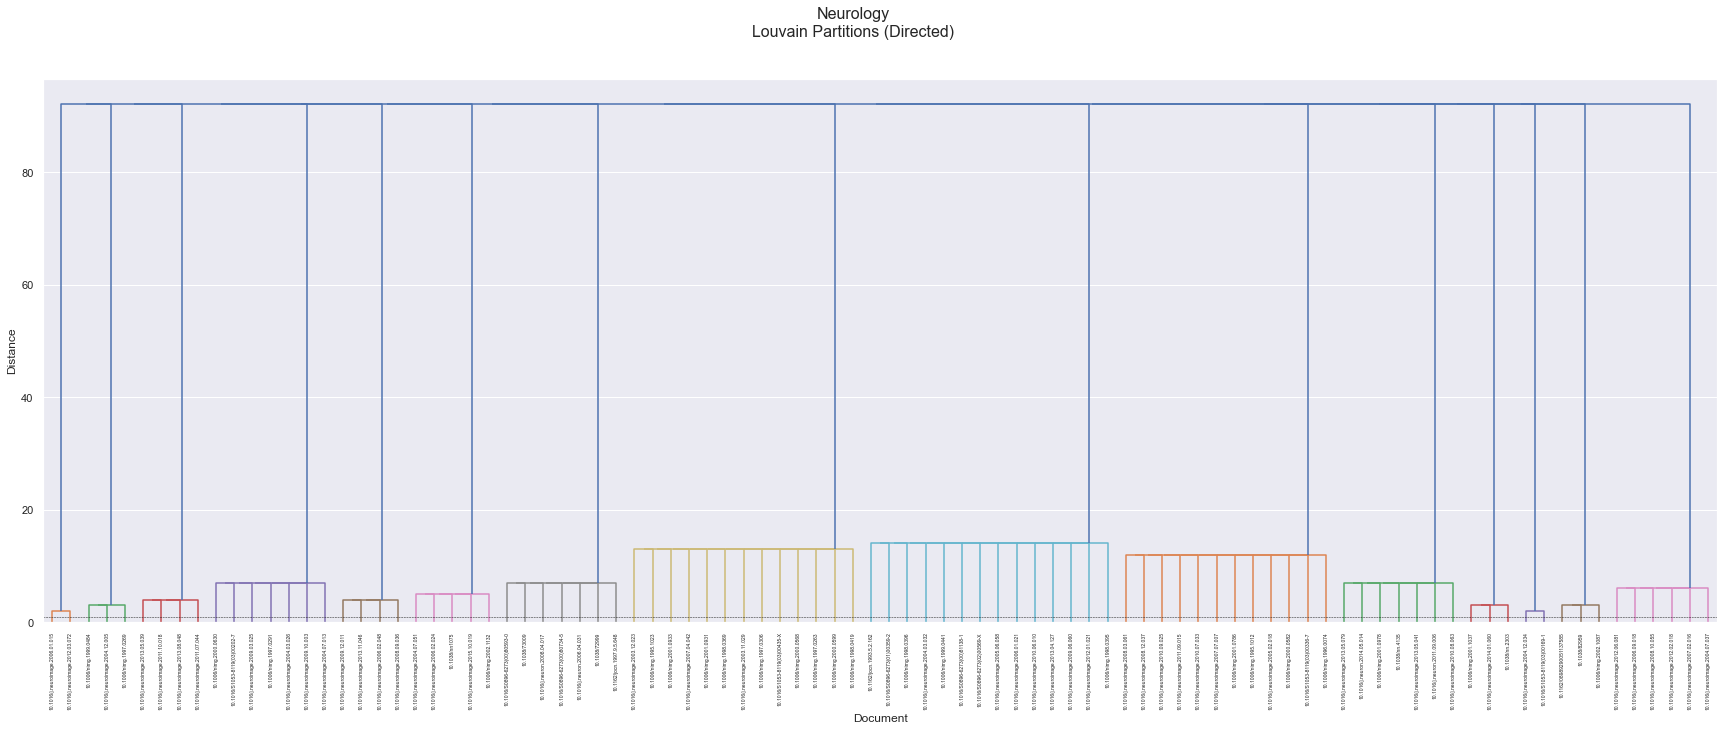

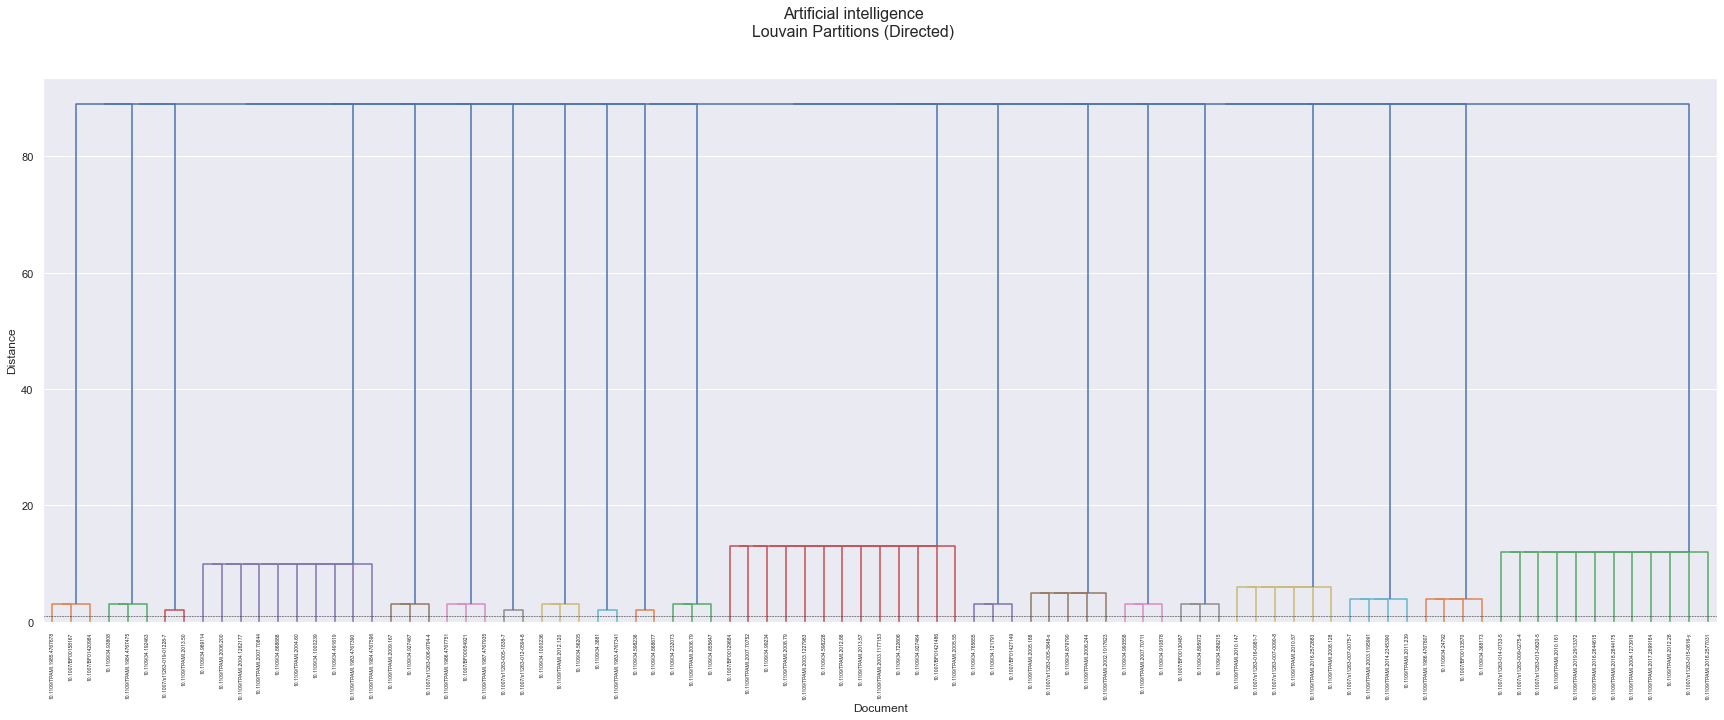

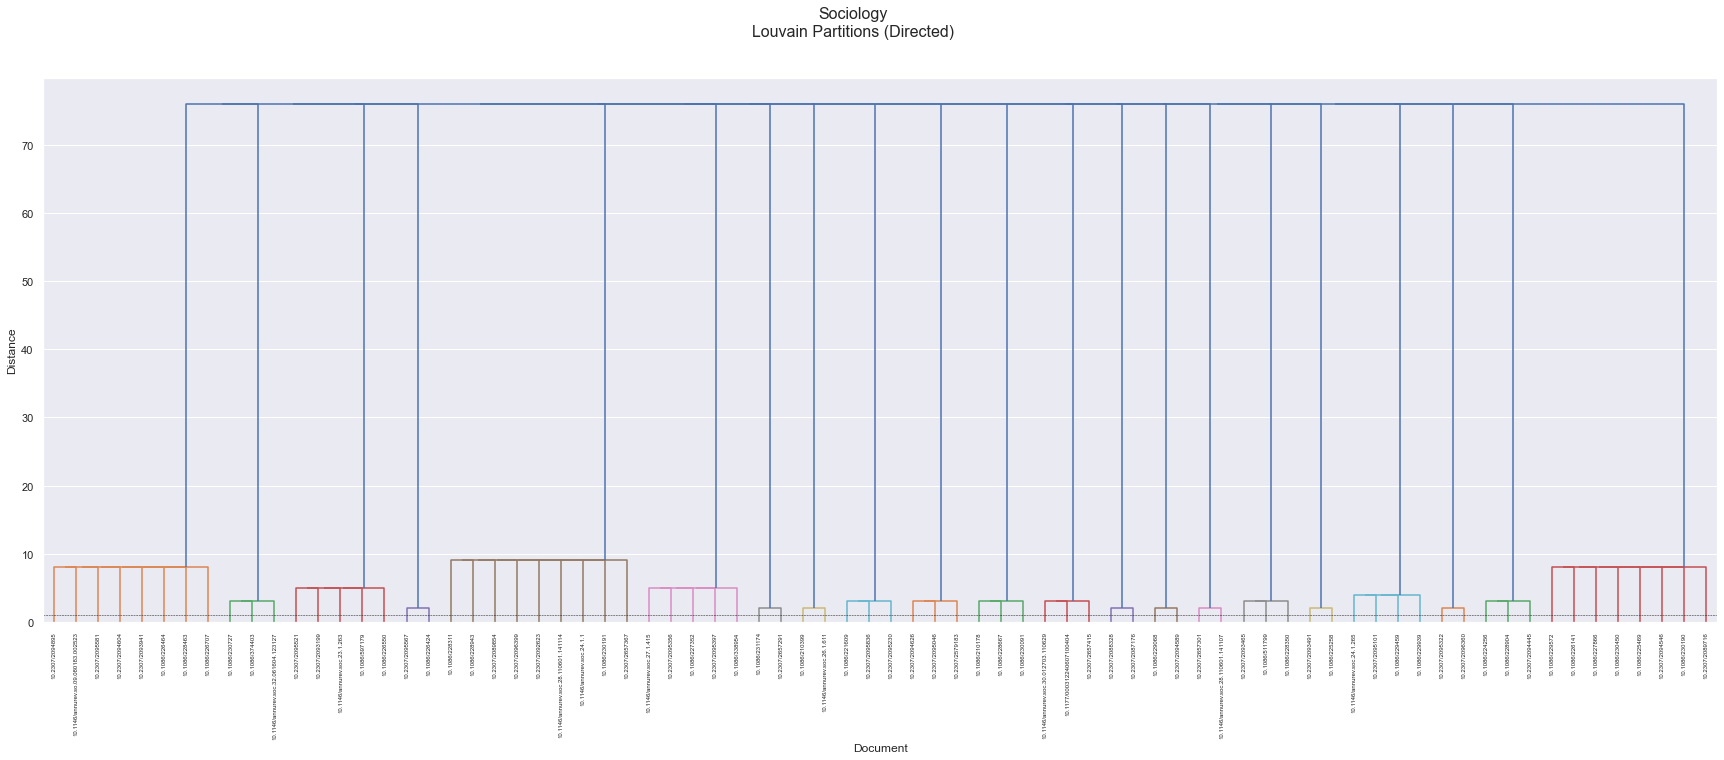

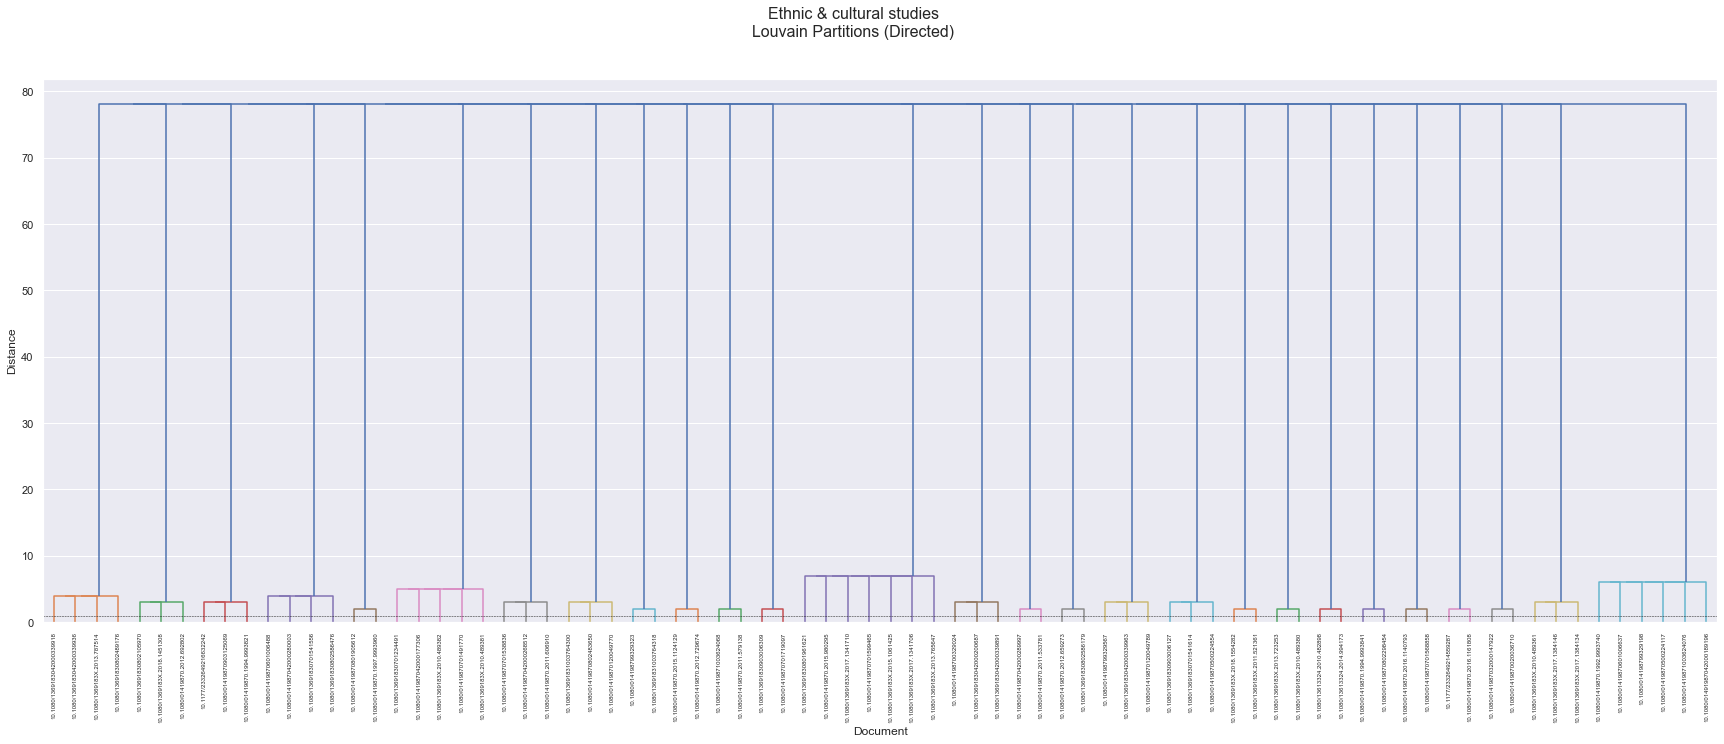

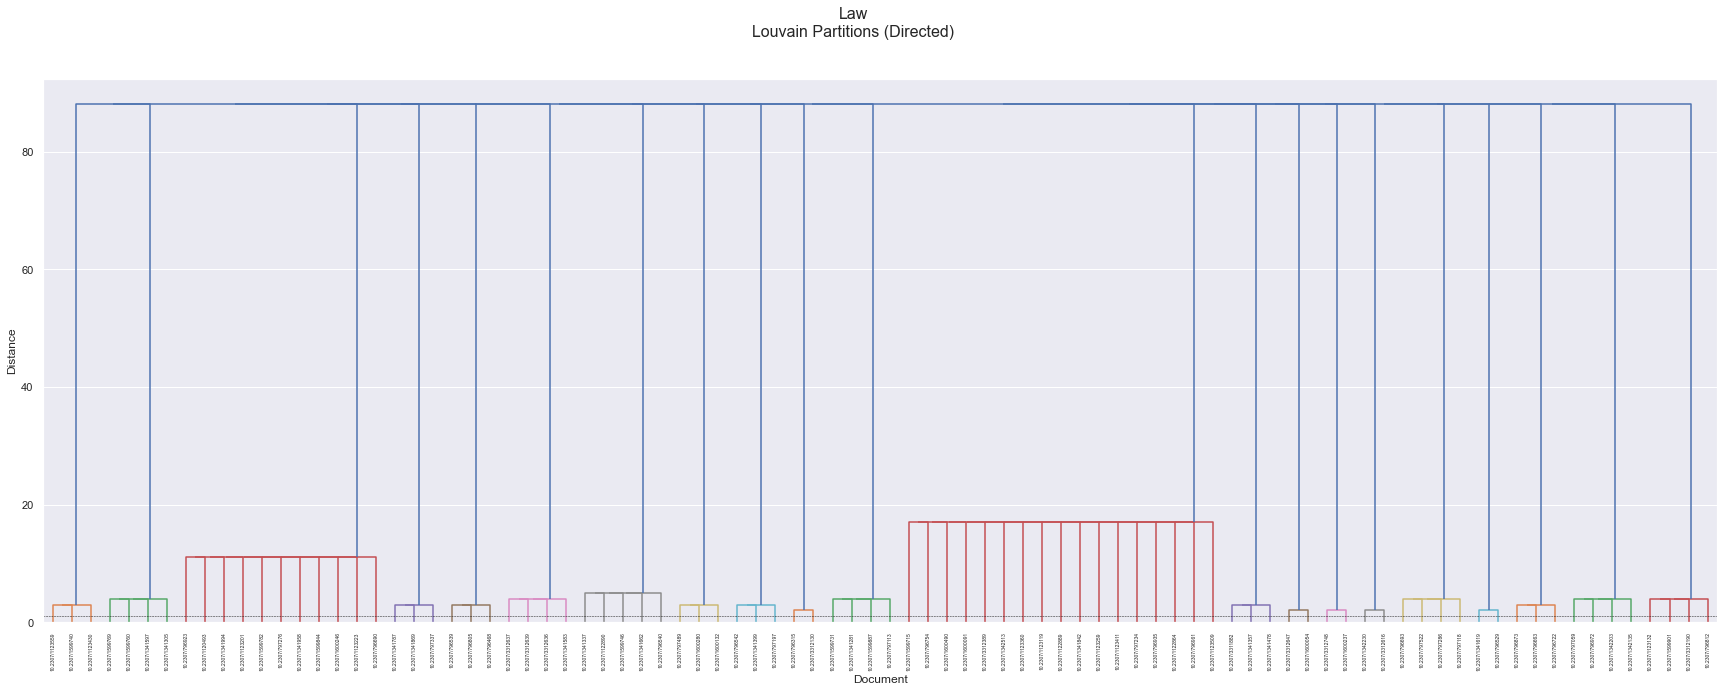

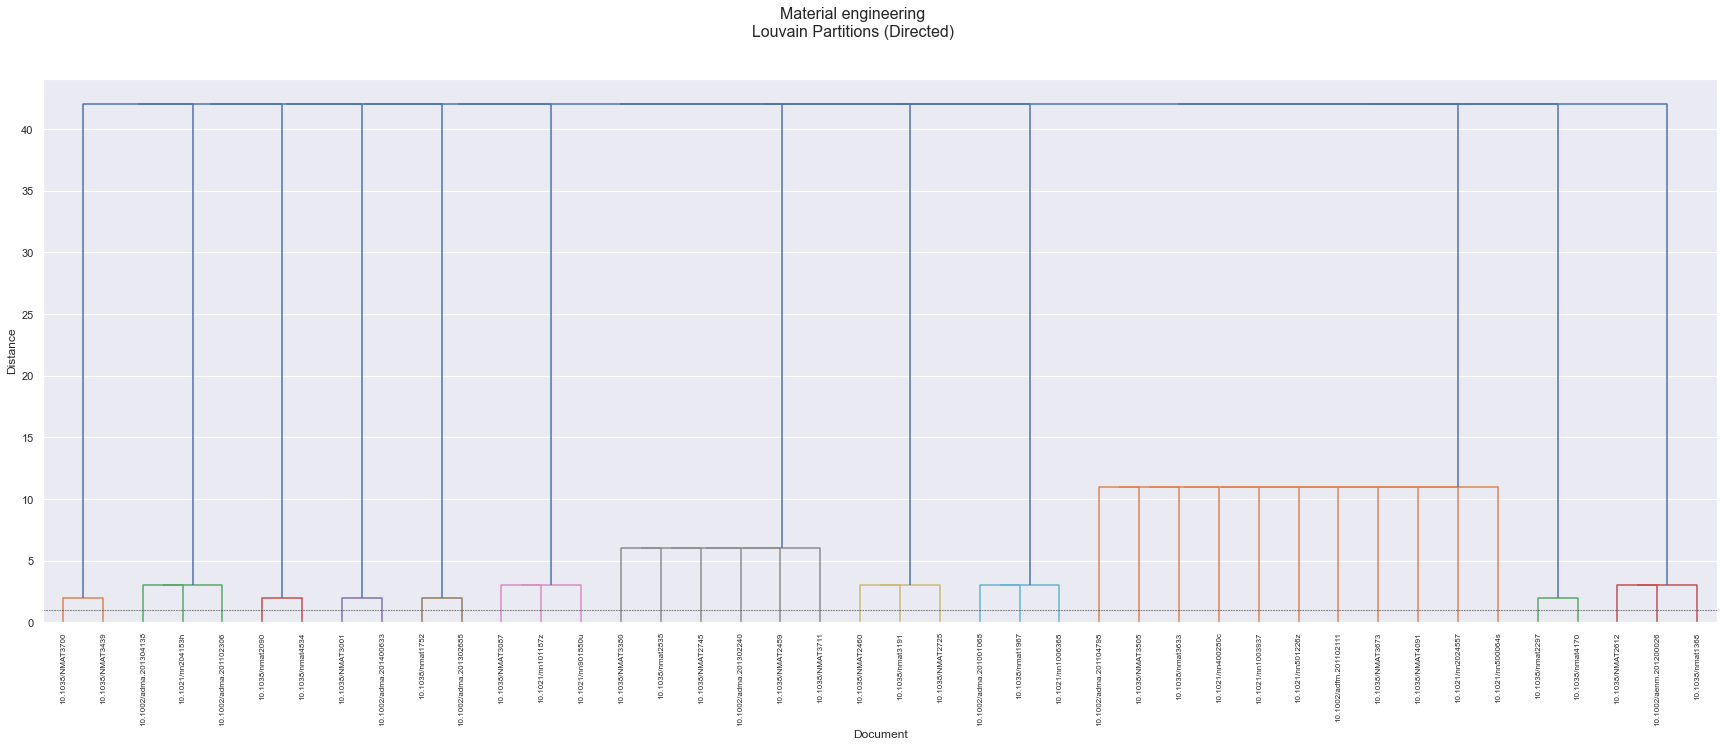

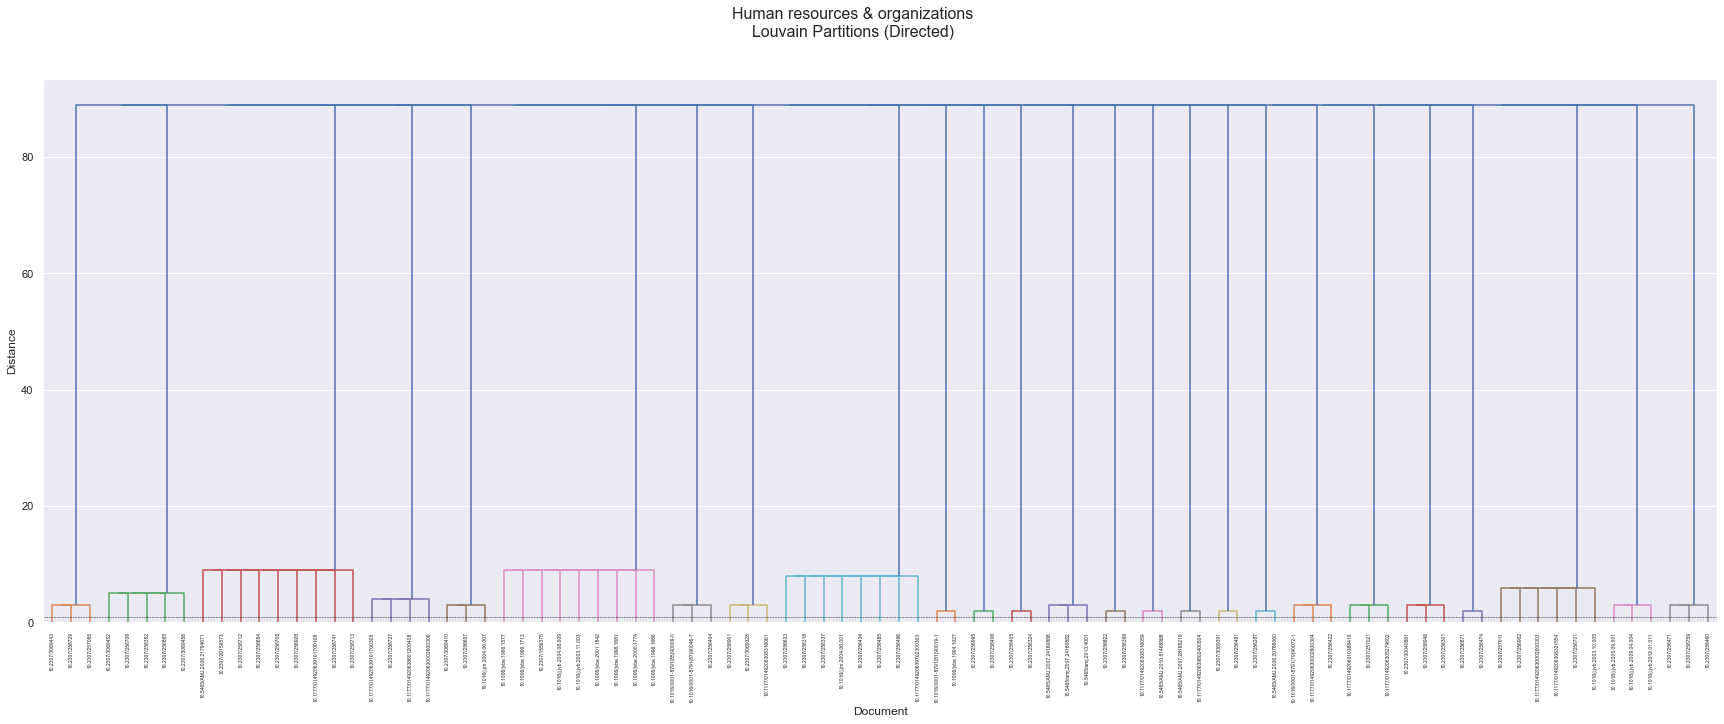

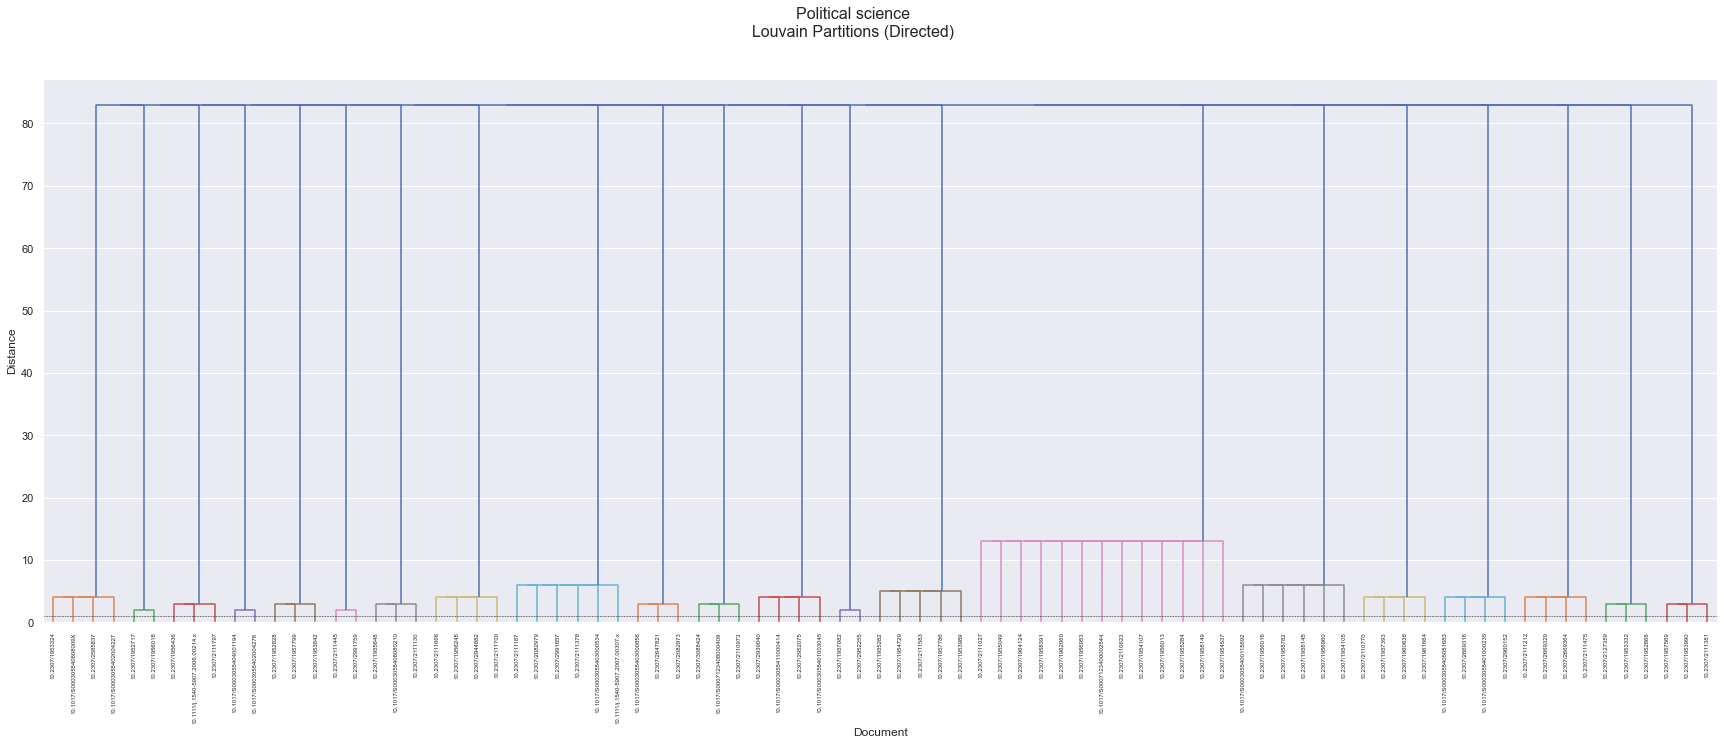

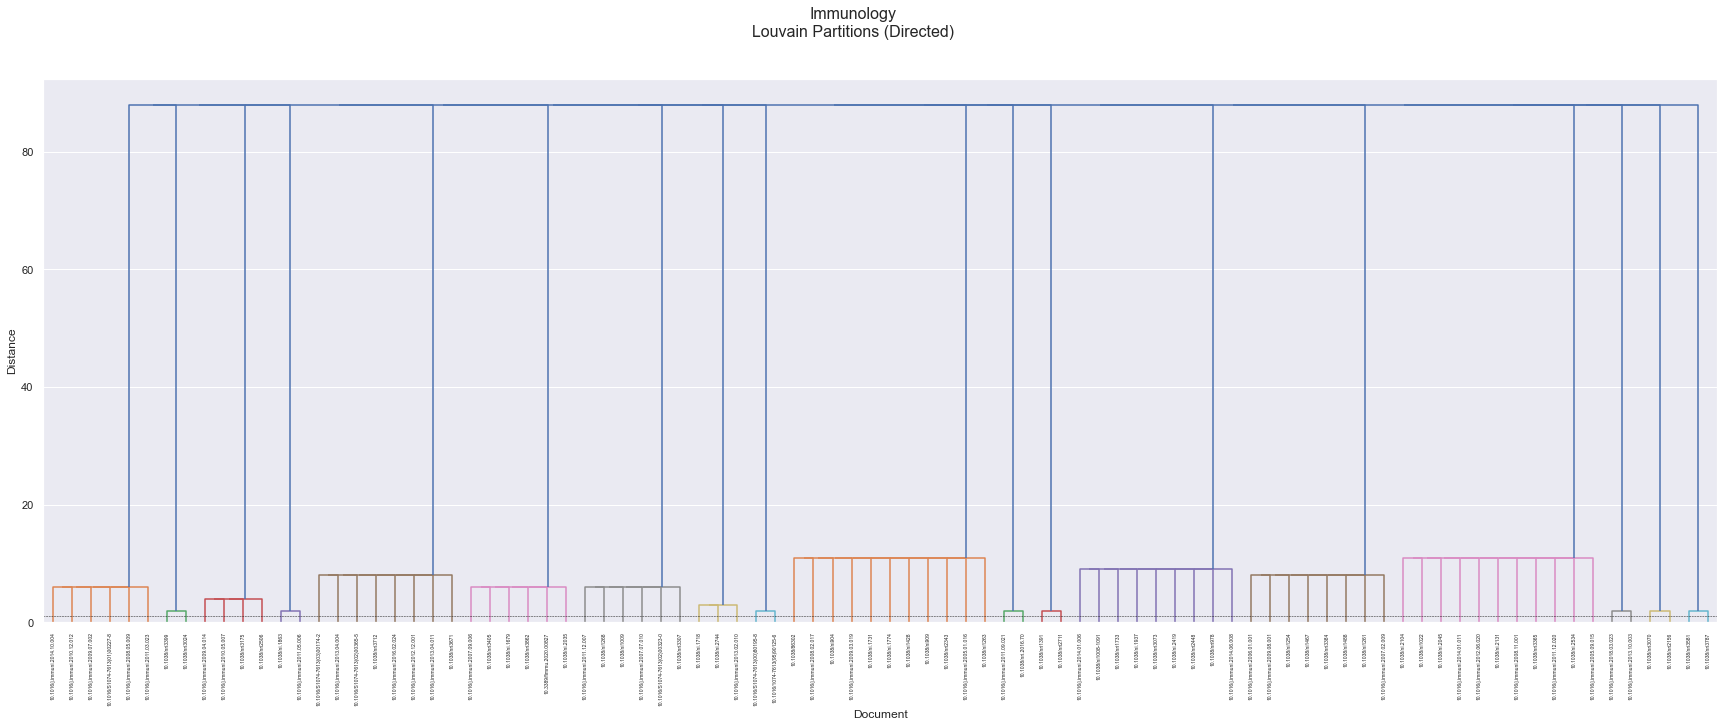

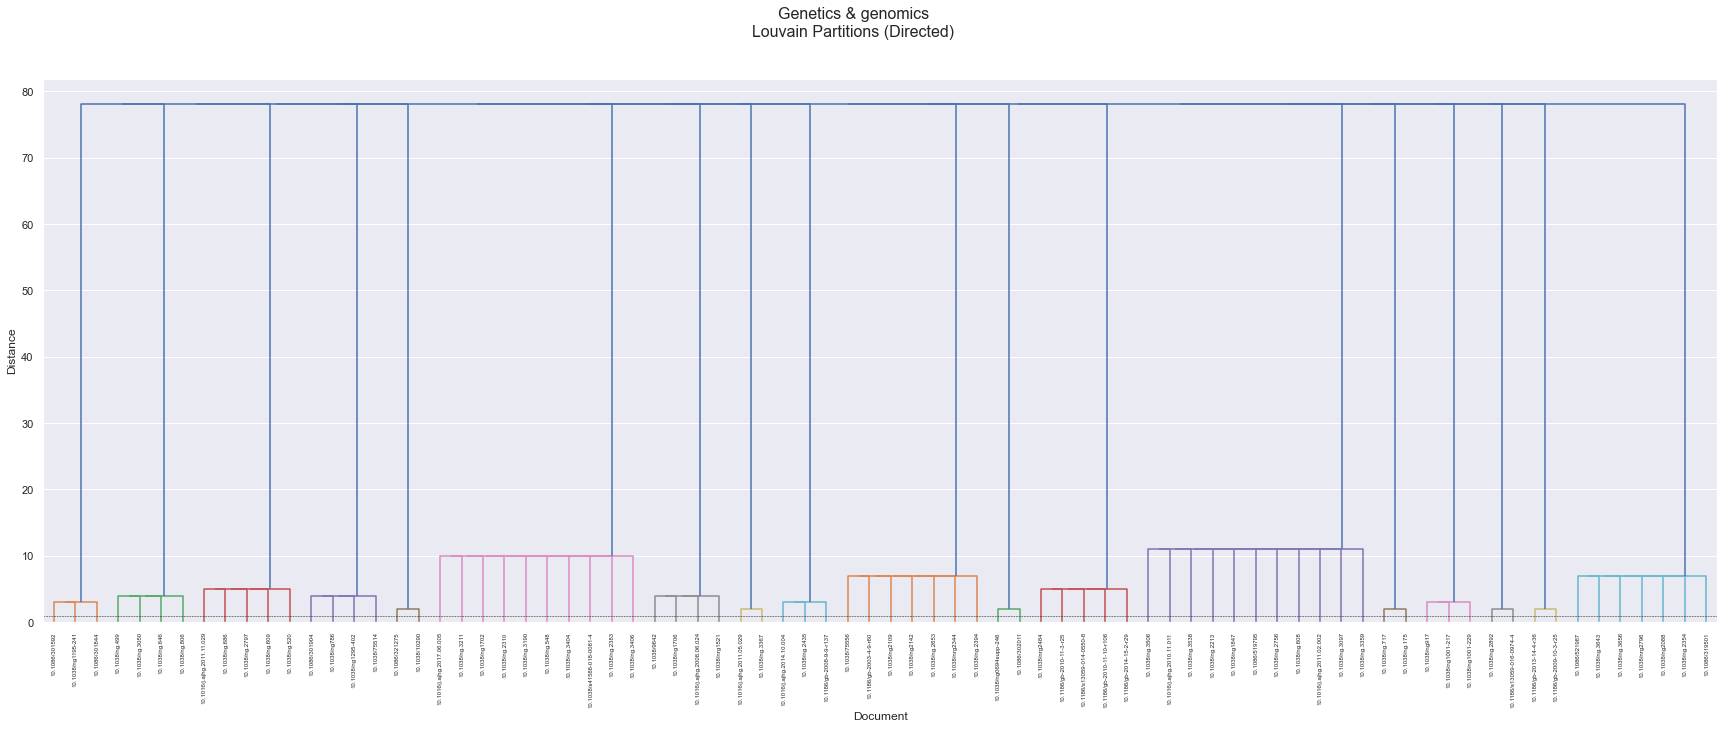

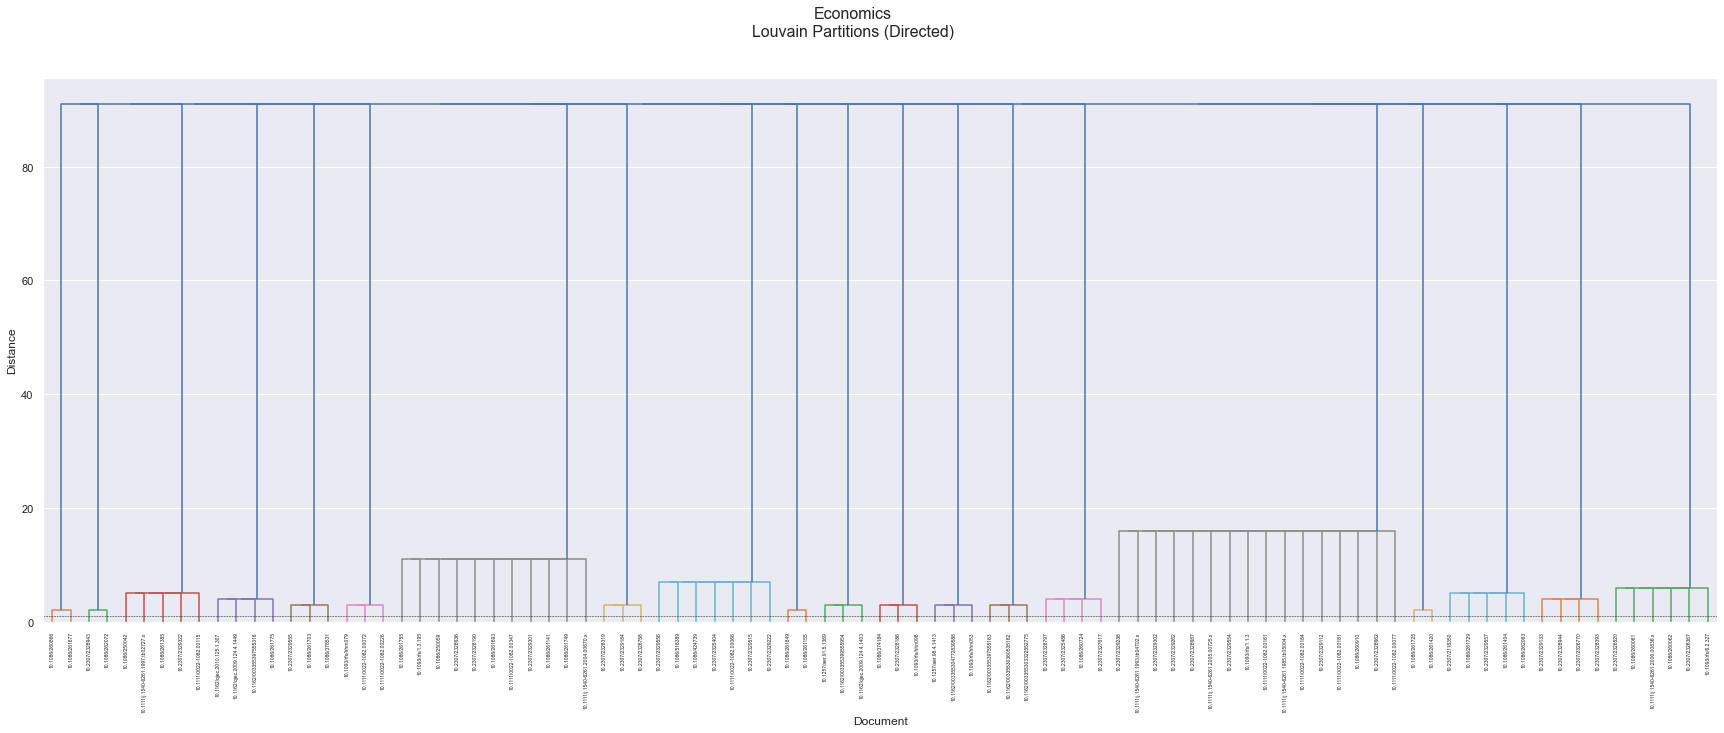

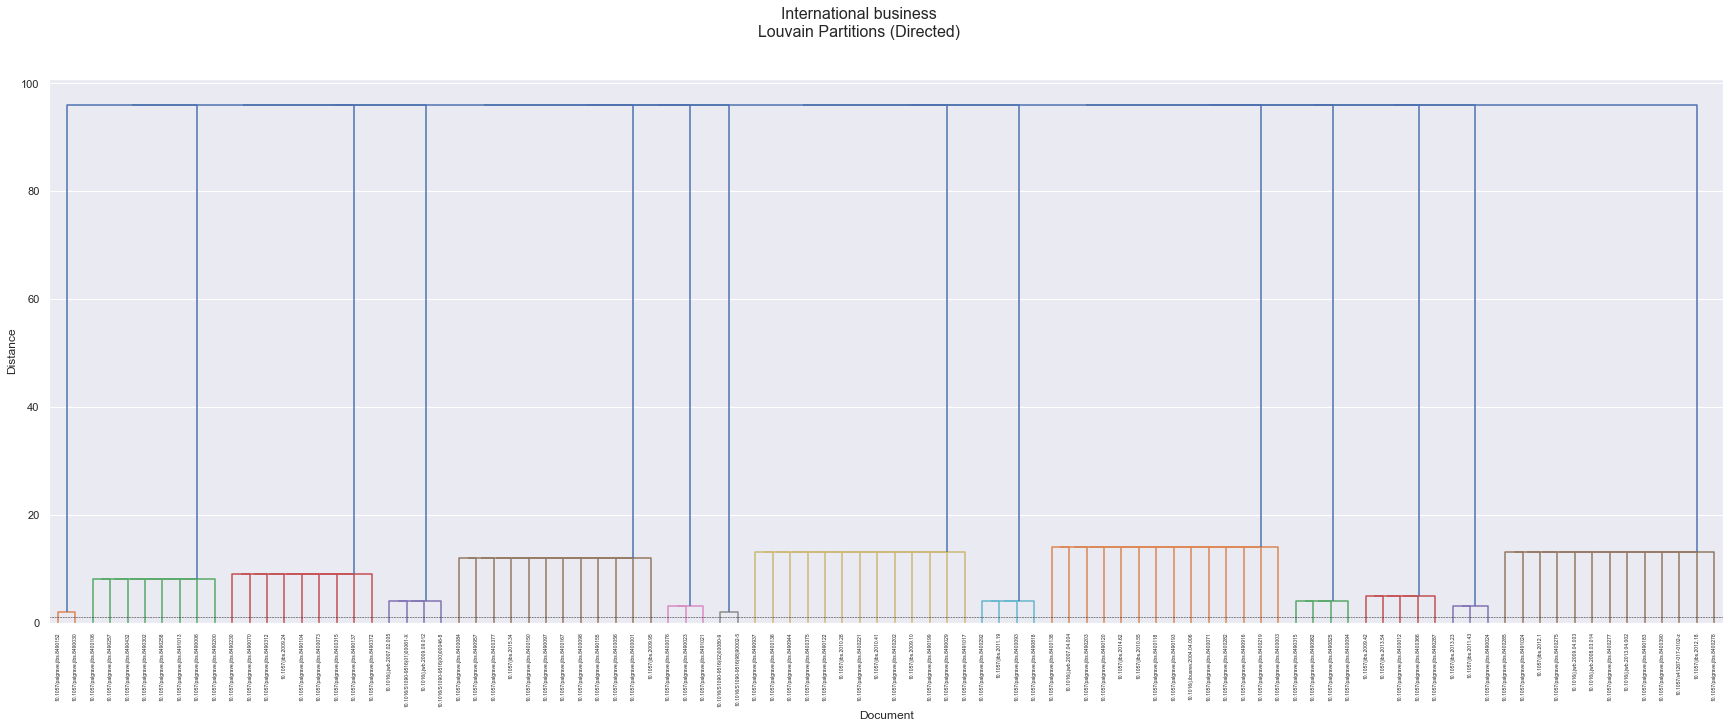

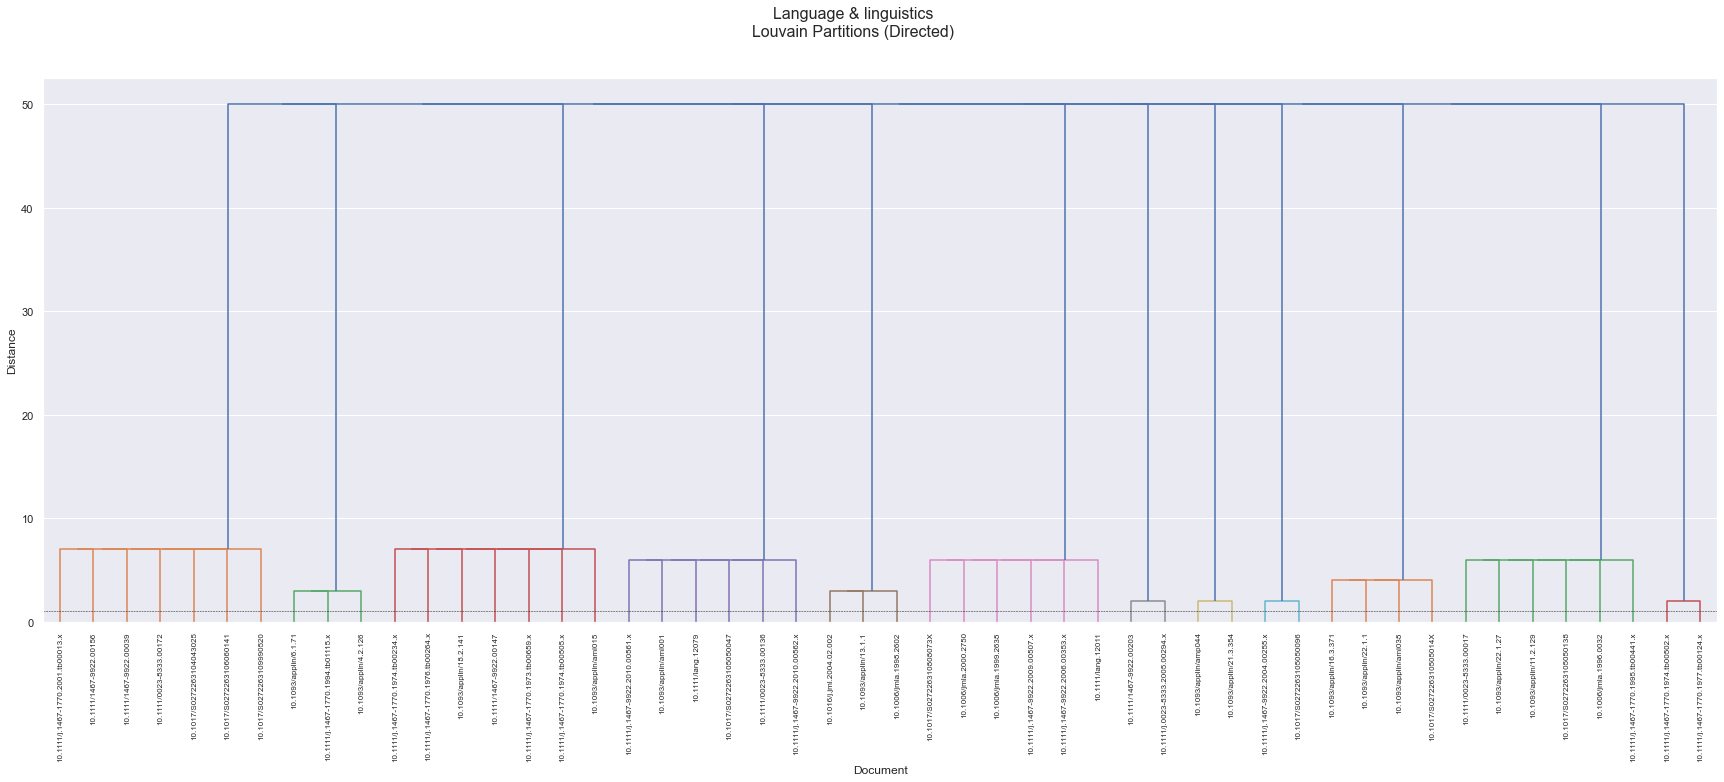

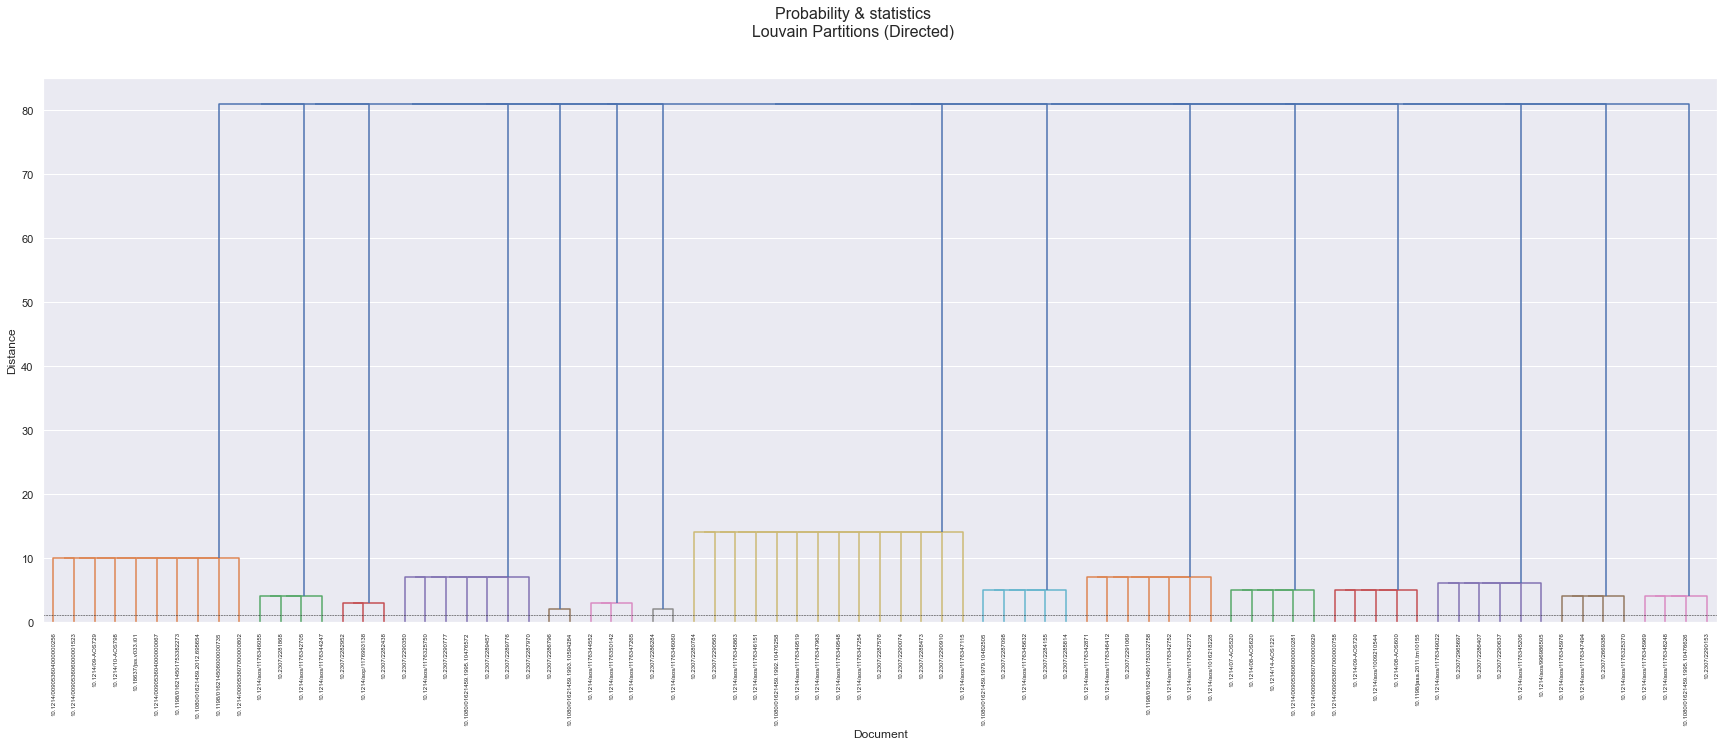

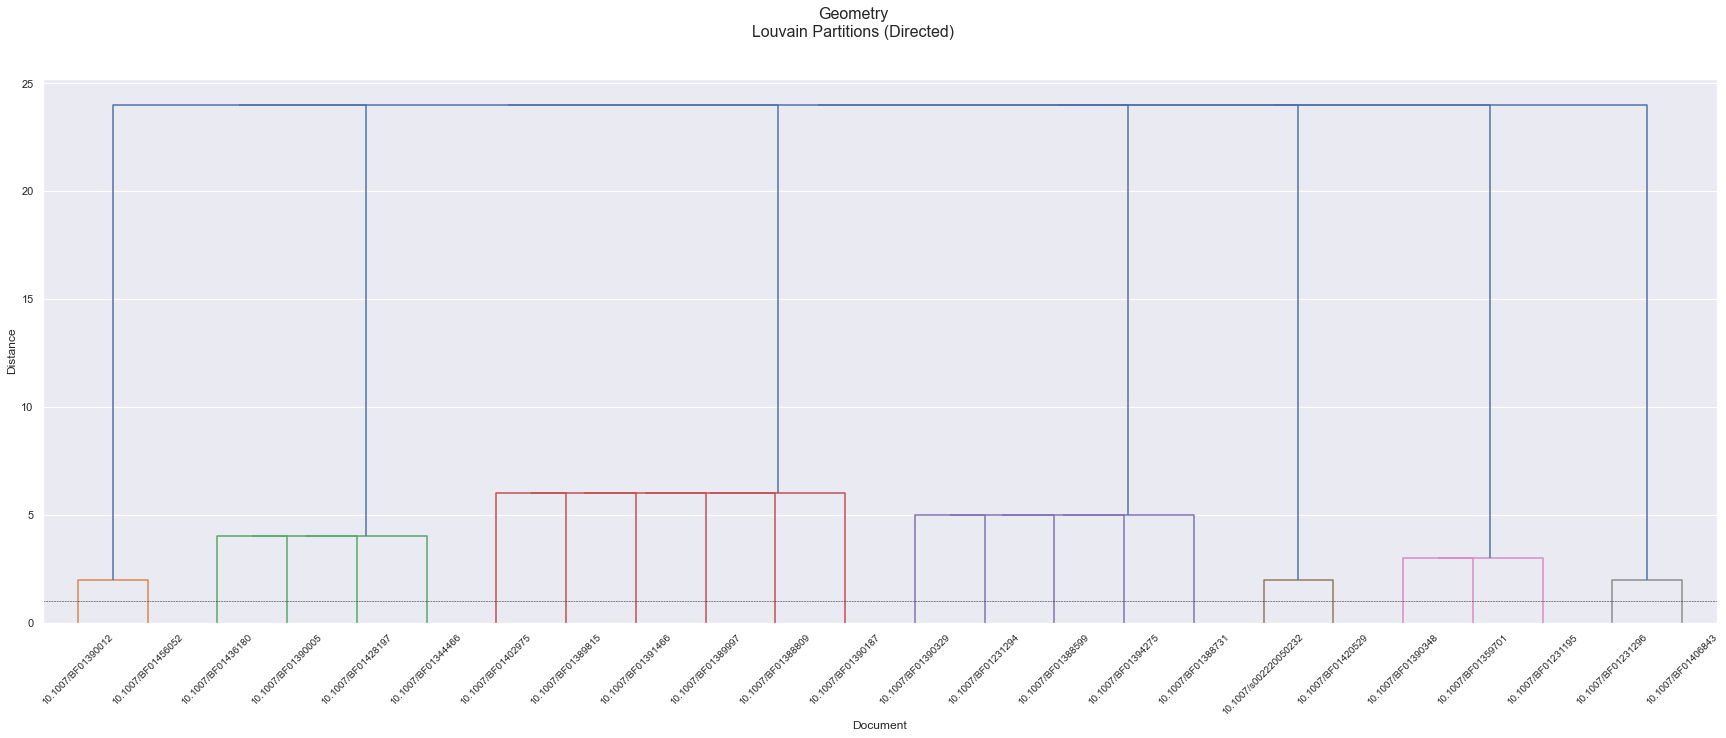

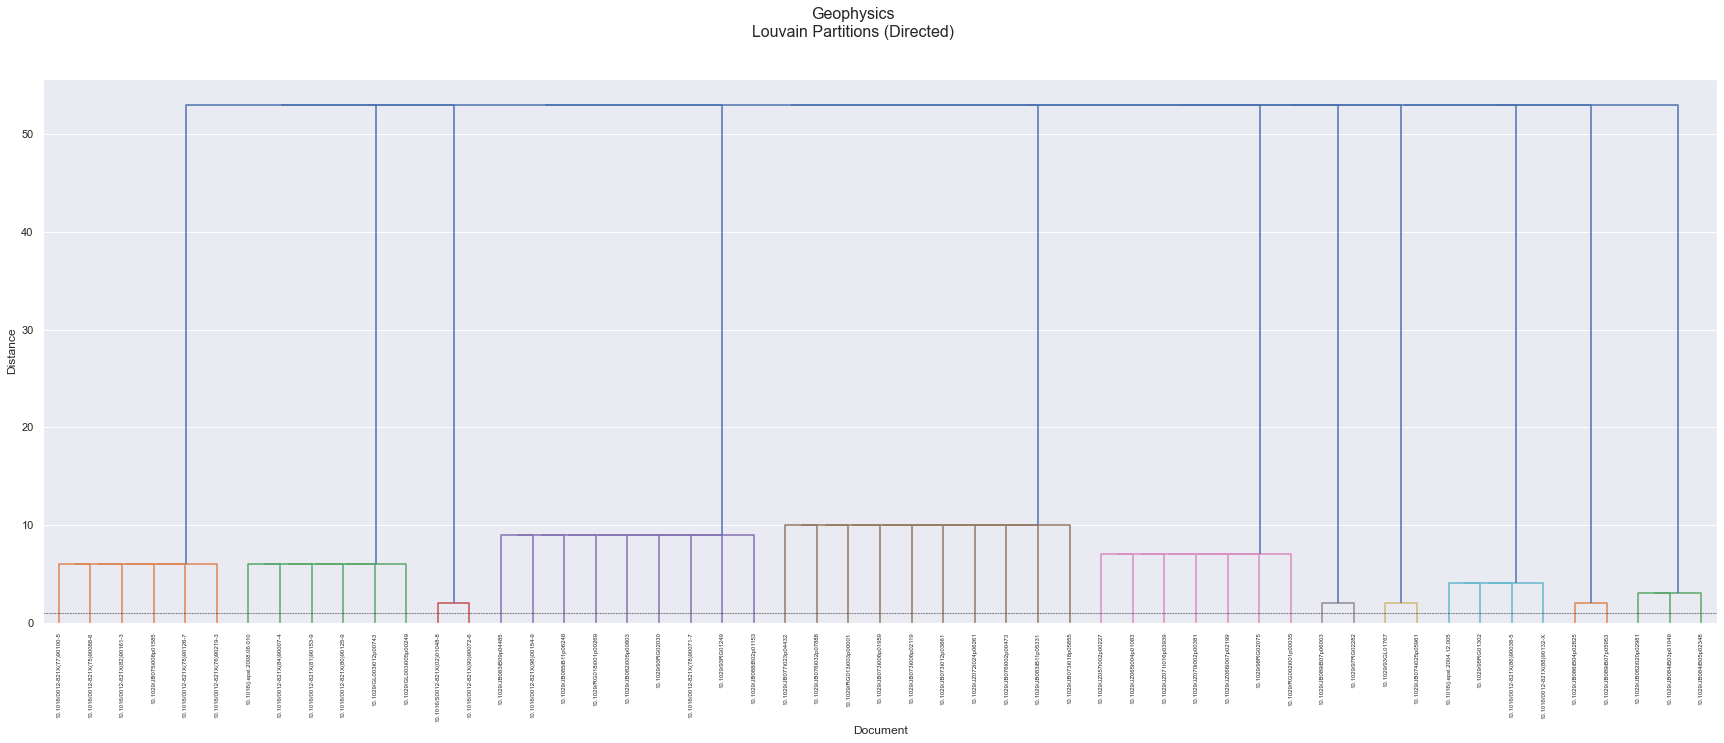

In [17]:
n = 100

louvain_directed_Z_leaves = {}

for (field_name, corpus) in corpora.data.items():

    df = corpus['citation_df']
    G = corpus['citation_graph']

    in_dgree_centrality_dict = nx.in_degree_centrality(G)
    sorted_first_n_centrality_dict = dict(sorted(in_dgree_centrality_dict.items(), key=lambda x: x[1], reverse=True)[:n])
    nodes = list(sorted_first_n_centrality_dict.keys())

    G = G.subgraph(nodes)
    nodes = max(nx.weakly_connected_components(G), key=len)
    G = G.subgraph(nodes)
    nodes = G.nodes()

    levels = list(community.louvain_partitions(G, weight=None, resolution=1, threshold=1e-07, seed=None))
    levels.insert(0, (set(nodes),))
    levels.append(tuple({n} for n in nodes))

    Z_louvain_directed, leaves_louvain_directed = compute_Z(levels)

    louvain_directed_Z_leaves[field_name] = {
        'Z': Z_louvain_directed,
        'leaves': leaves_louvain_directed
    }

    fig = plt.figure(figsize=(30, 10))
    axes = fig.subplots(1)
    fig.suptitle(f'{field_name}\nLouvain Partitions (Directed)', fontsize=16)
    plt.xlabel('Document')
    plt.ylabel('Distance')
    dendrogram(Z_louvain_directed, labels=leaves_louvain_directed)
    axes.yaxis.grid(True)
    axes.xaxis.grid(False)
    fig.set_facecolor('w')
    plt.axhline(y=1.0, c='k', ls='--', lw=0.5)

    # plt.savefig(f'{img_path}/louvain_directed_communities_{field_name}.png')
    plt.show()

## Louvain (Undirected)

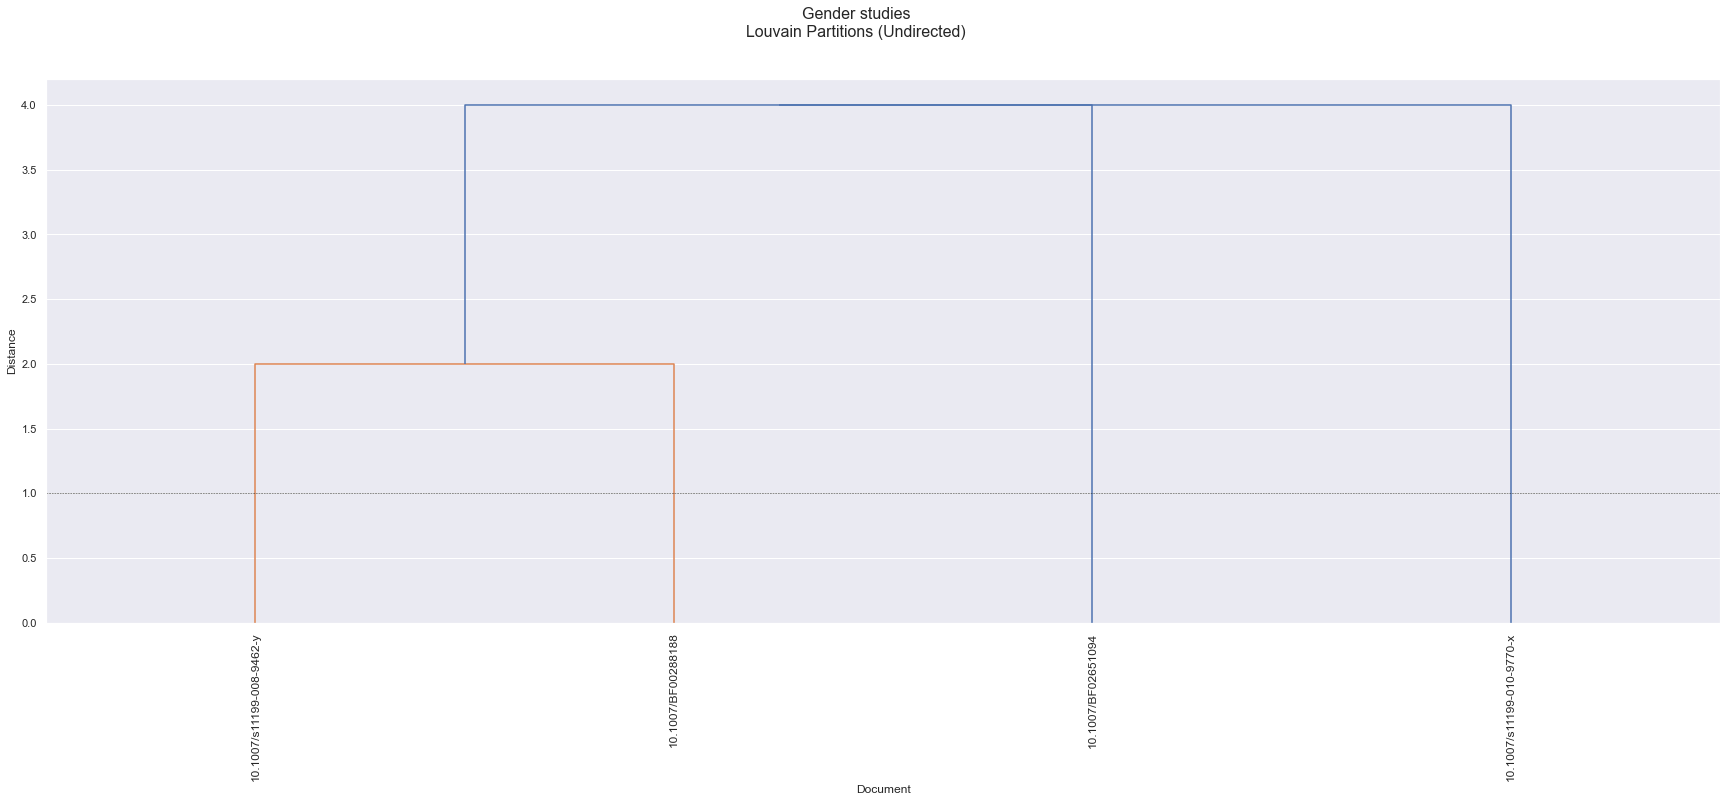

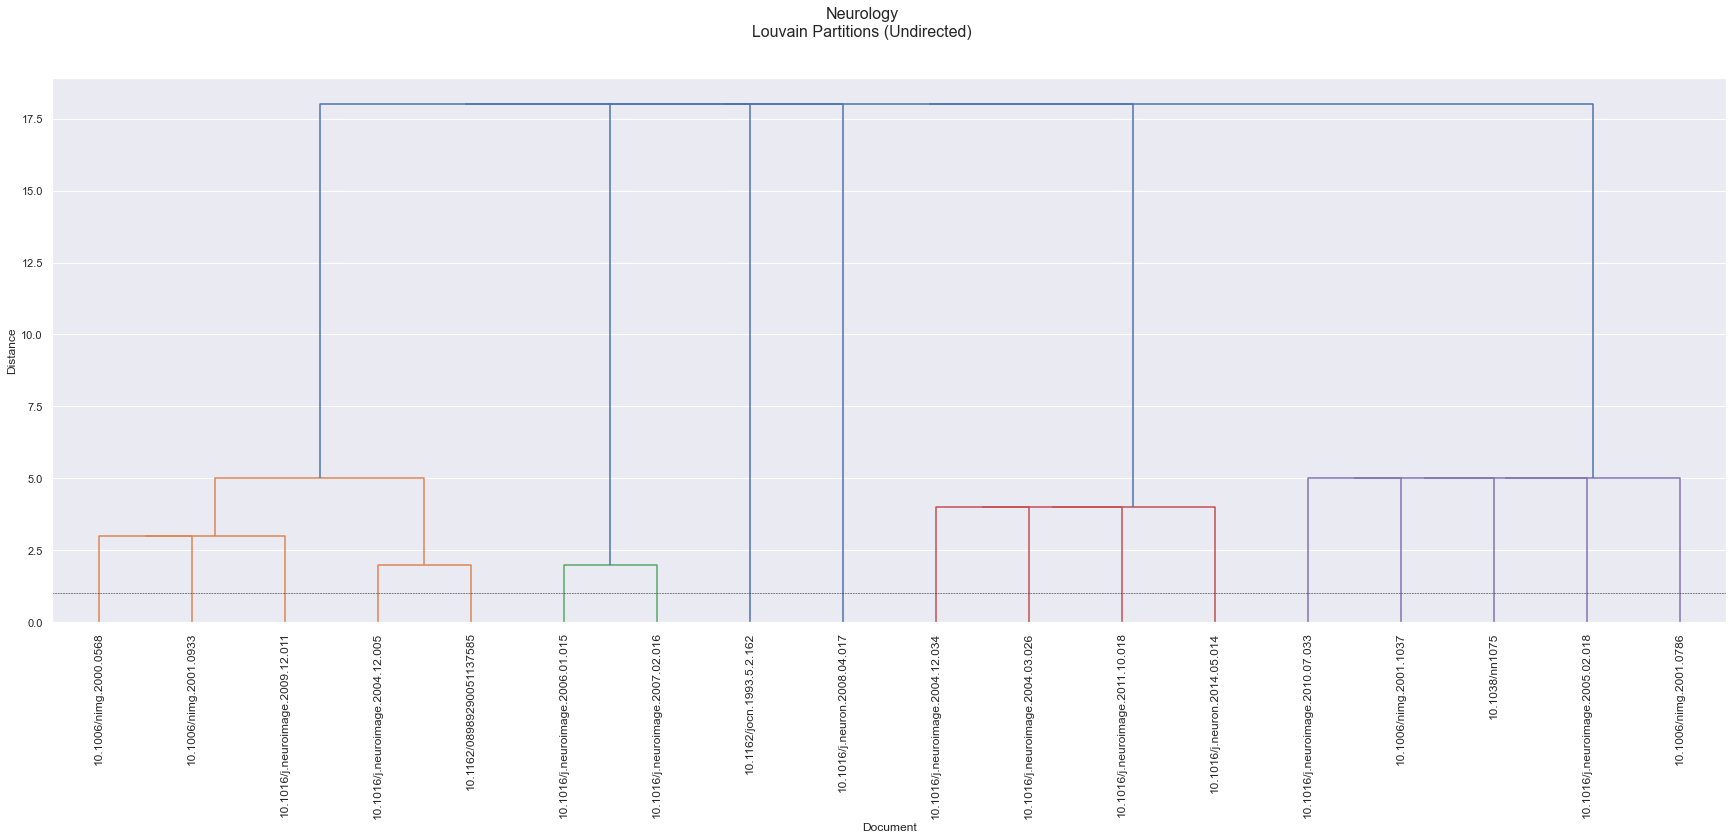

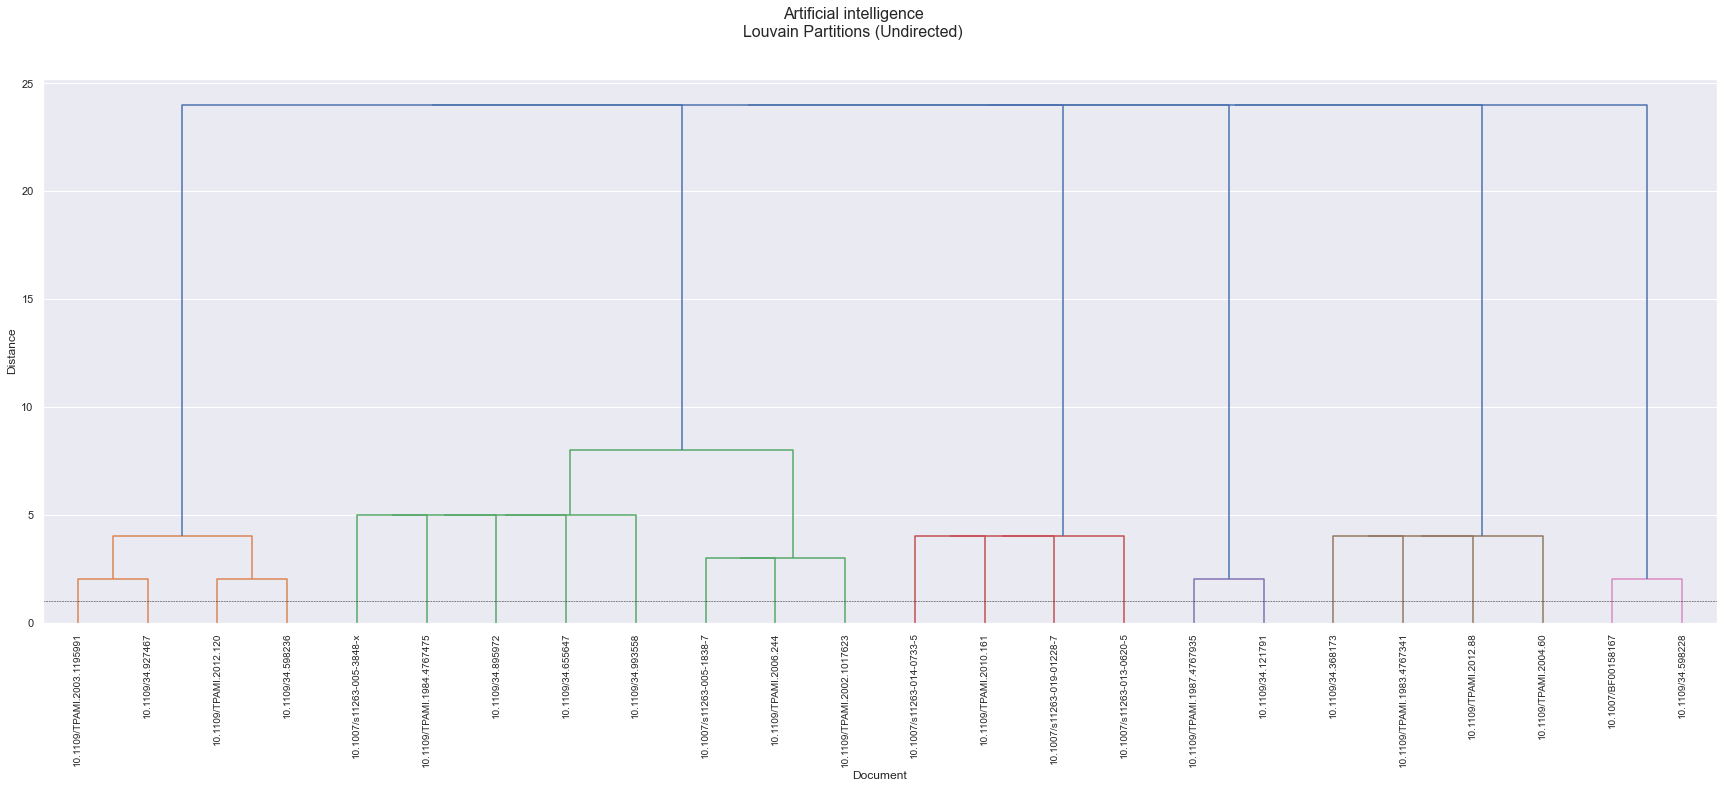

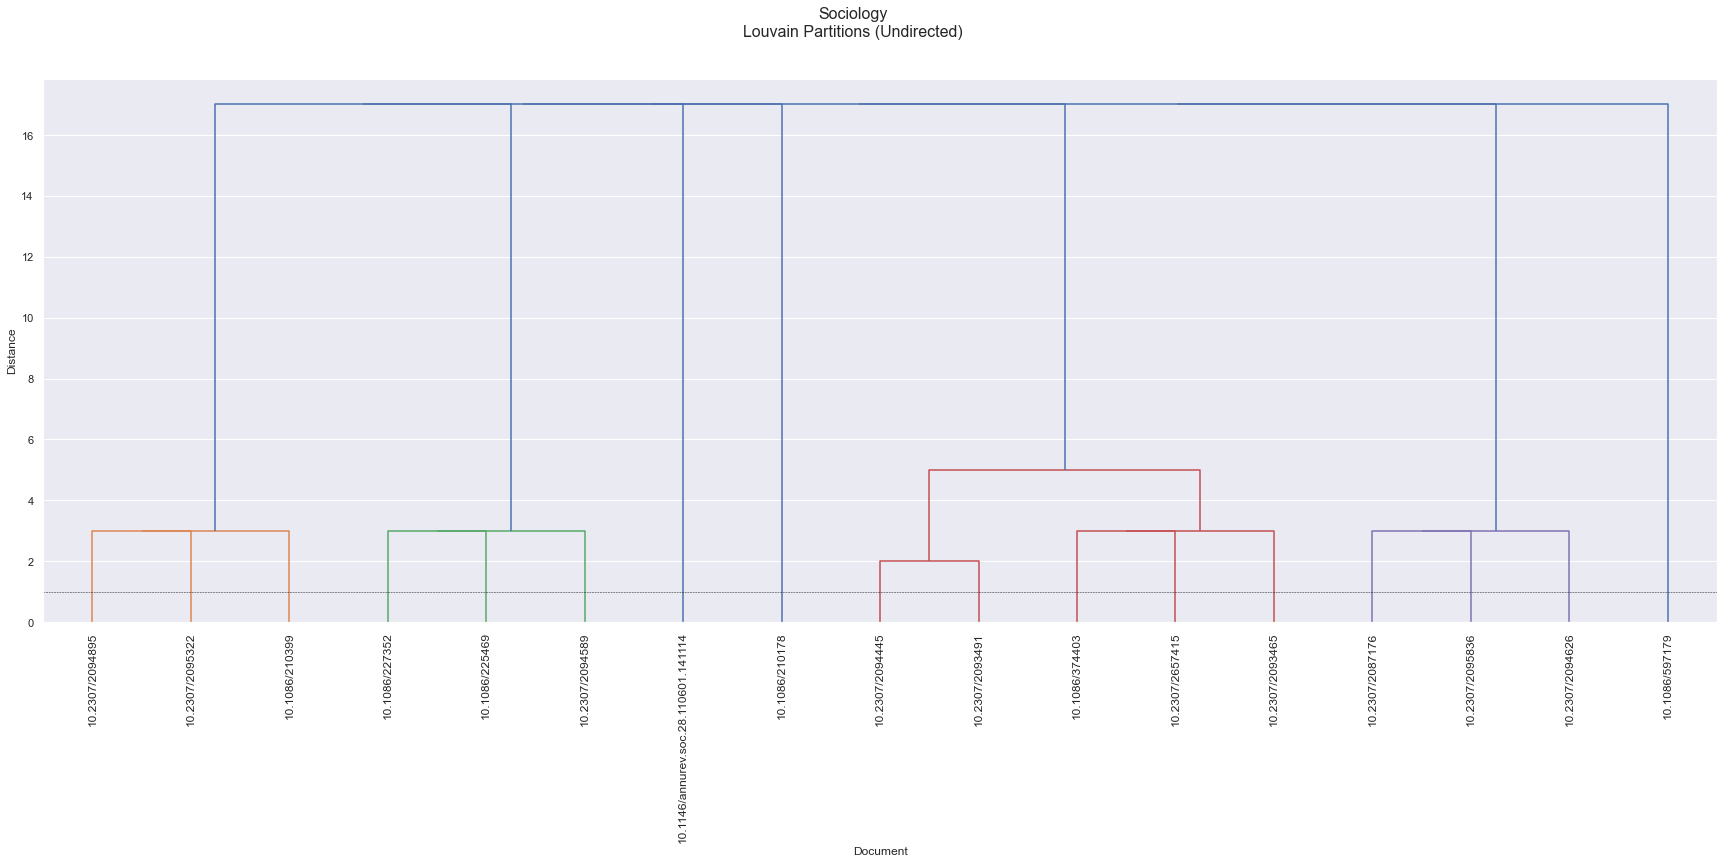

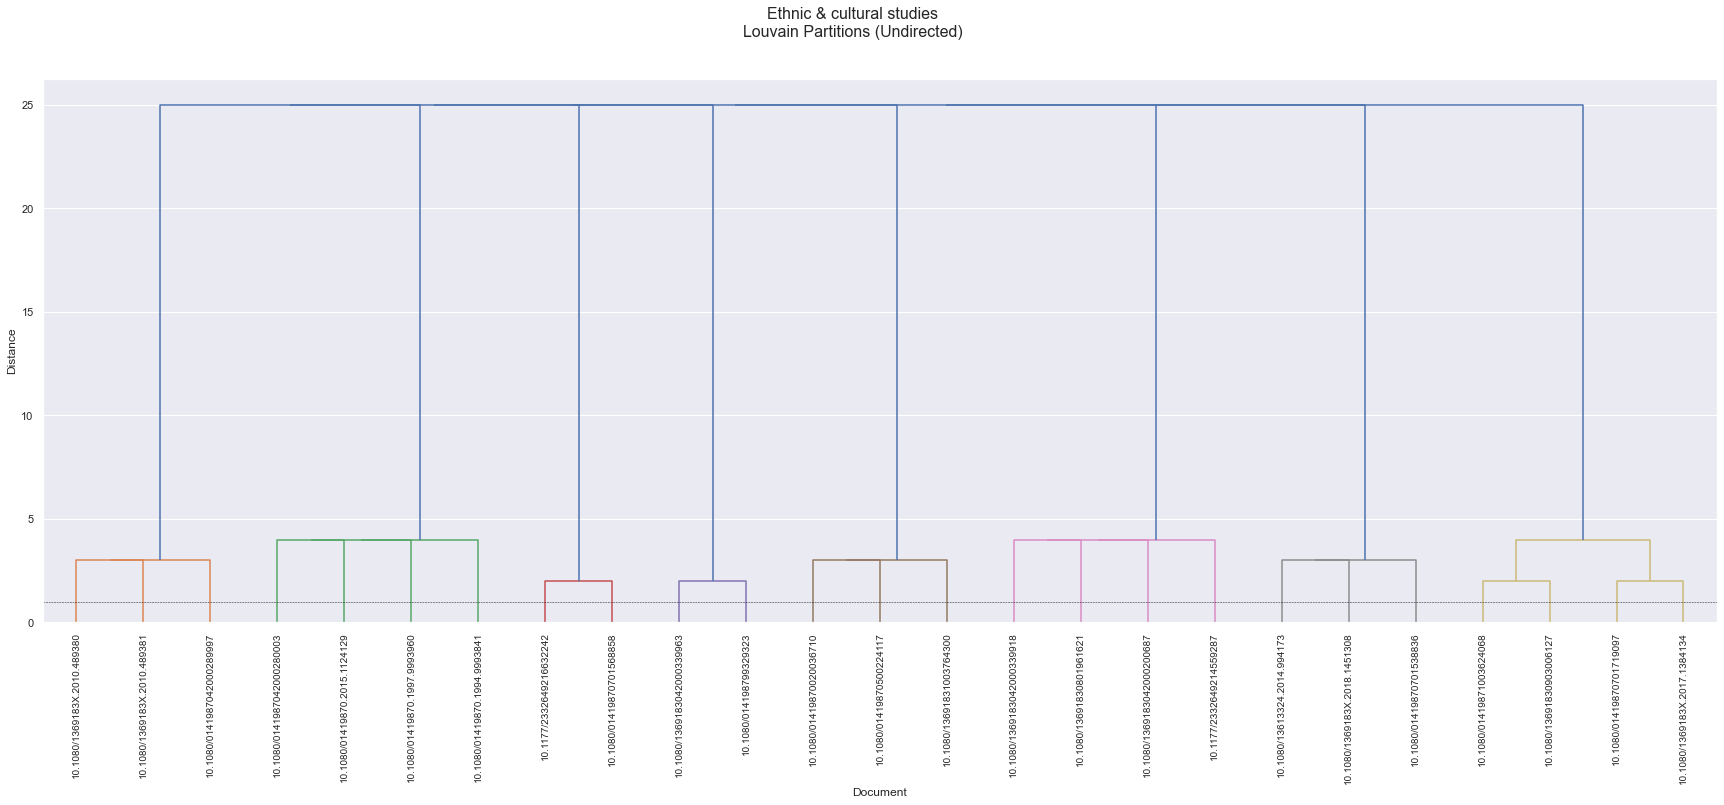

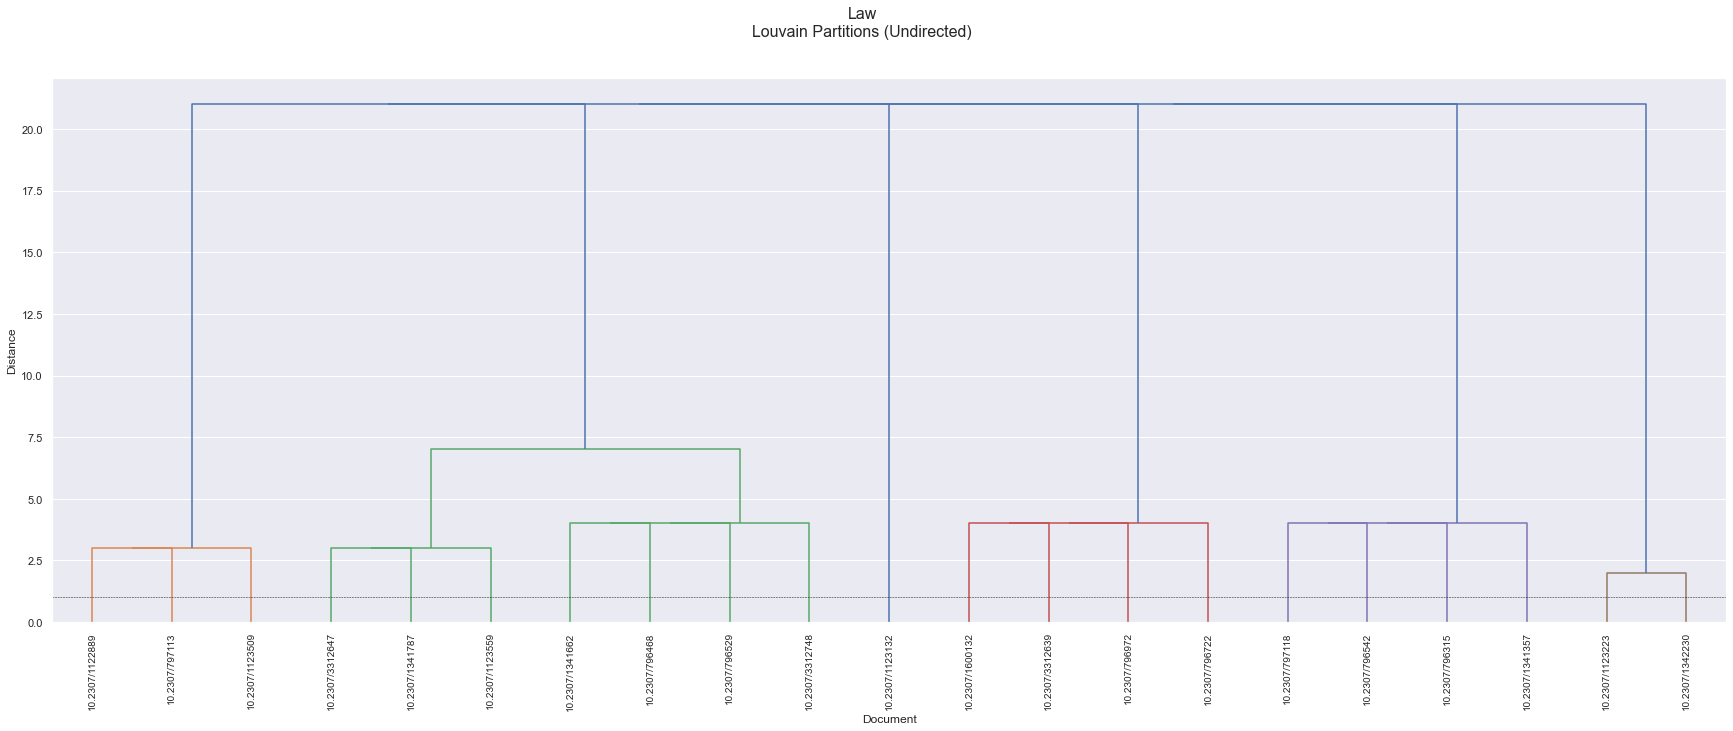

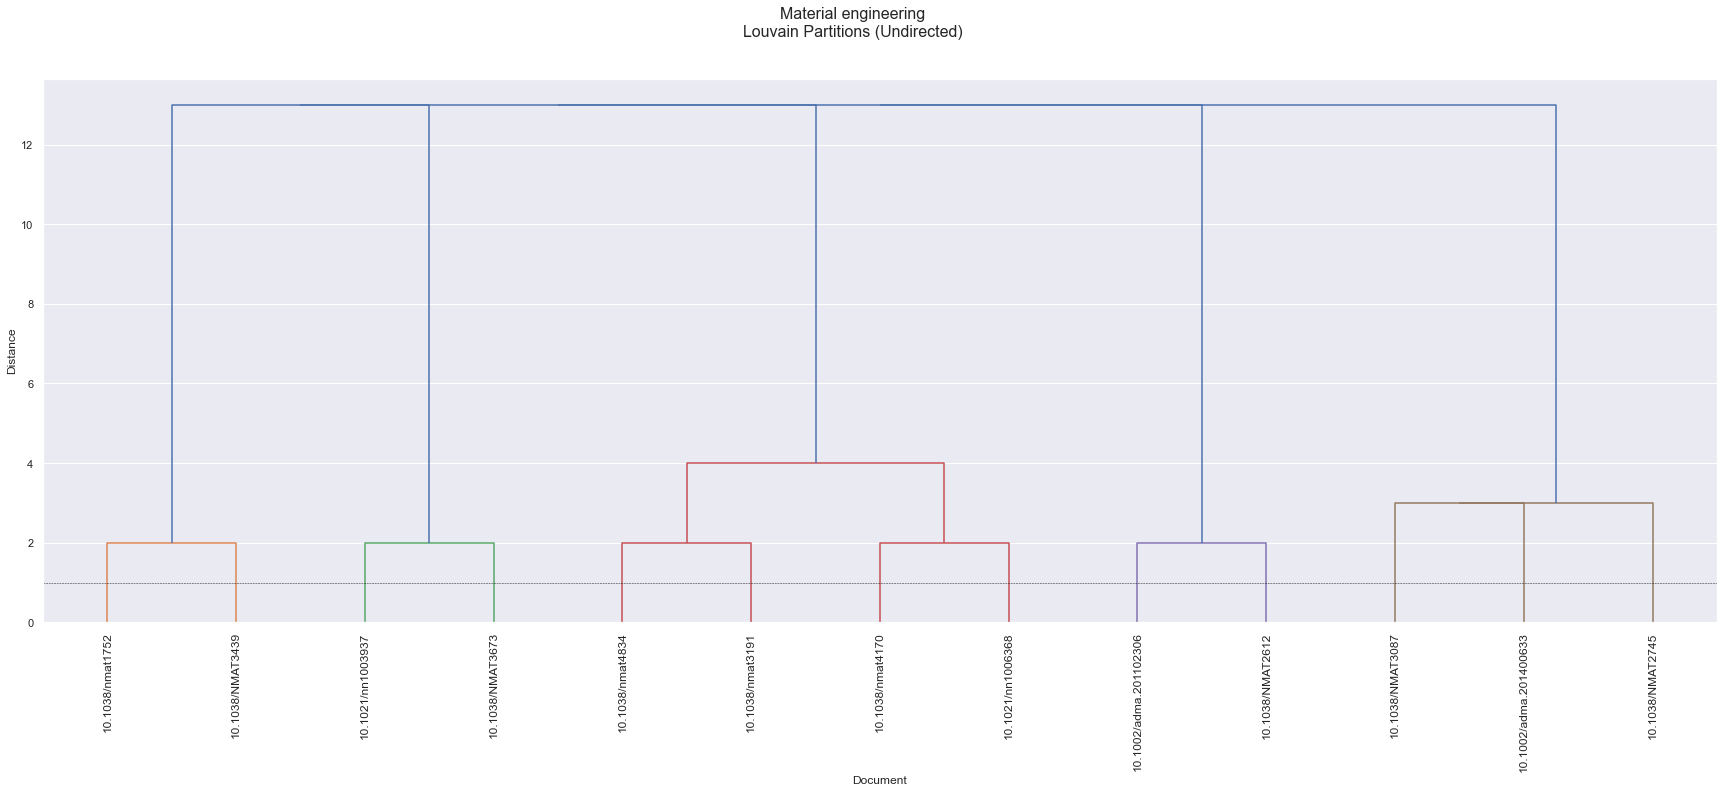

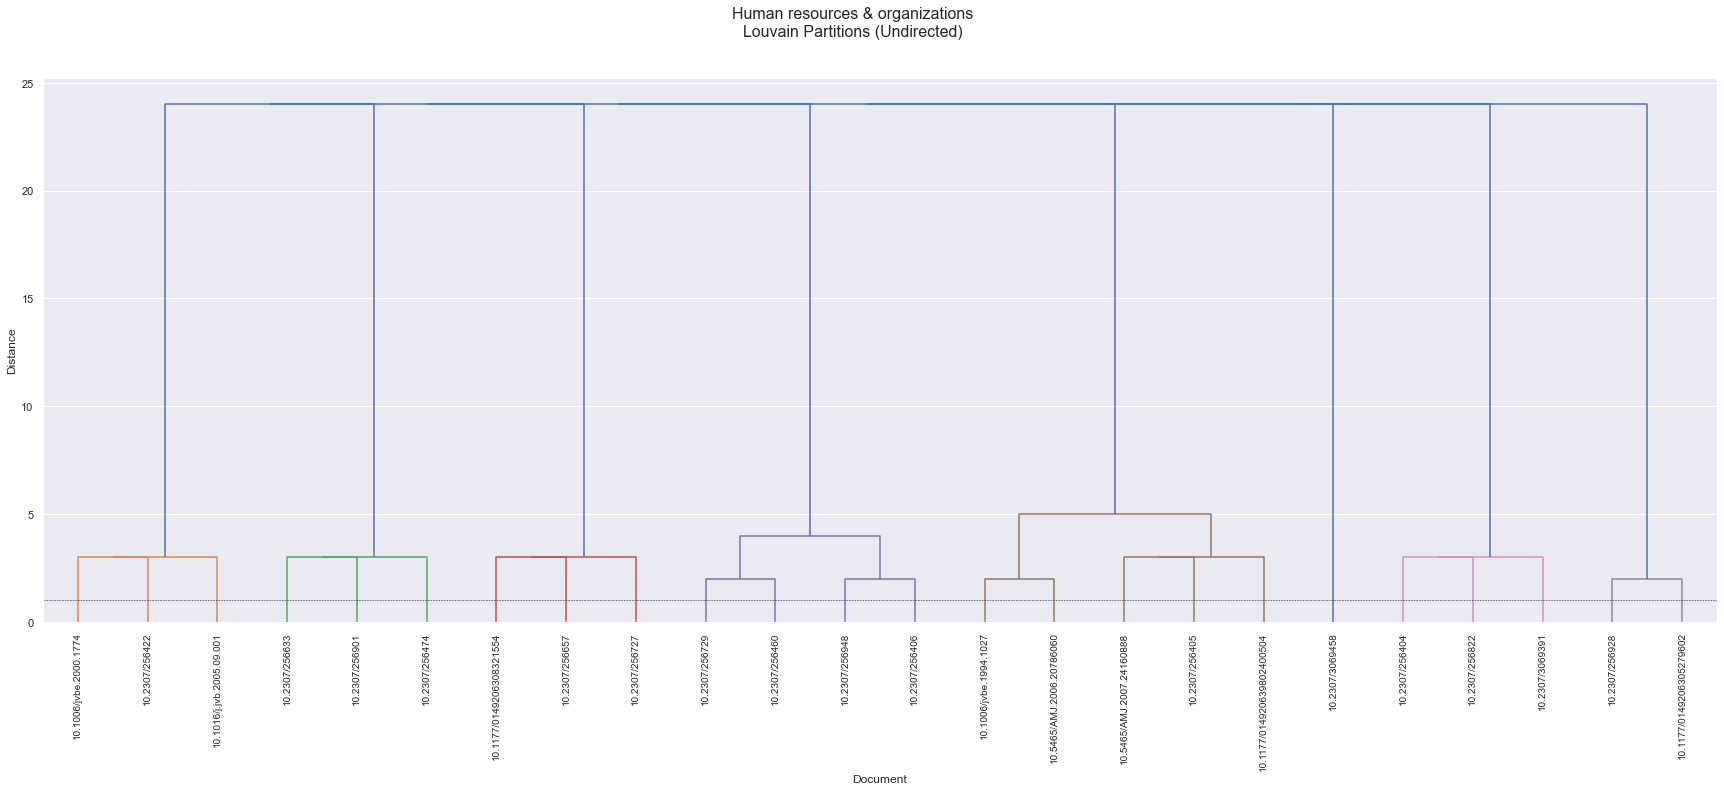

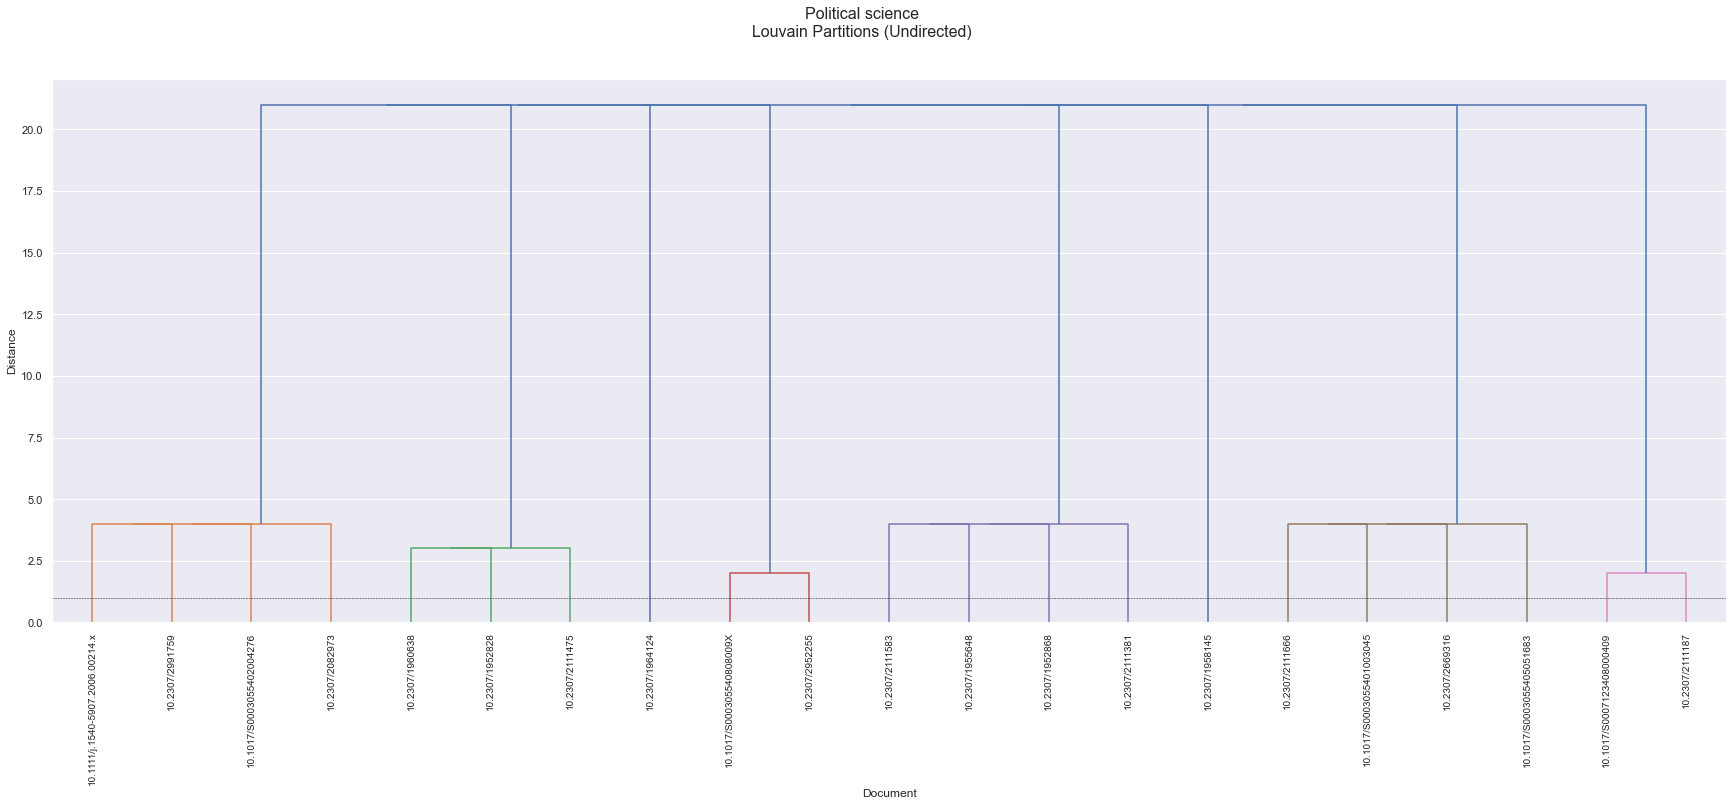

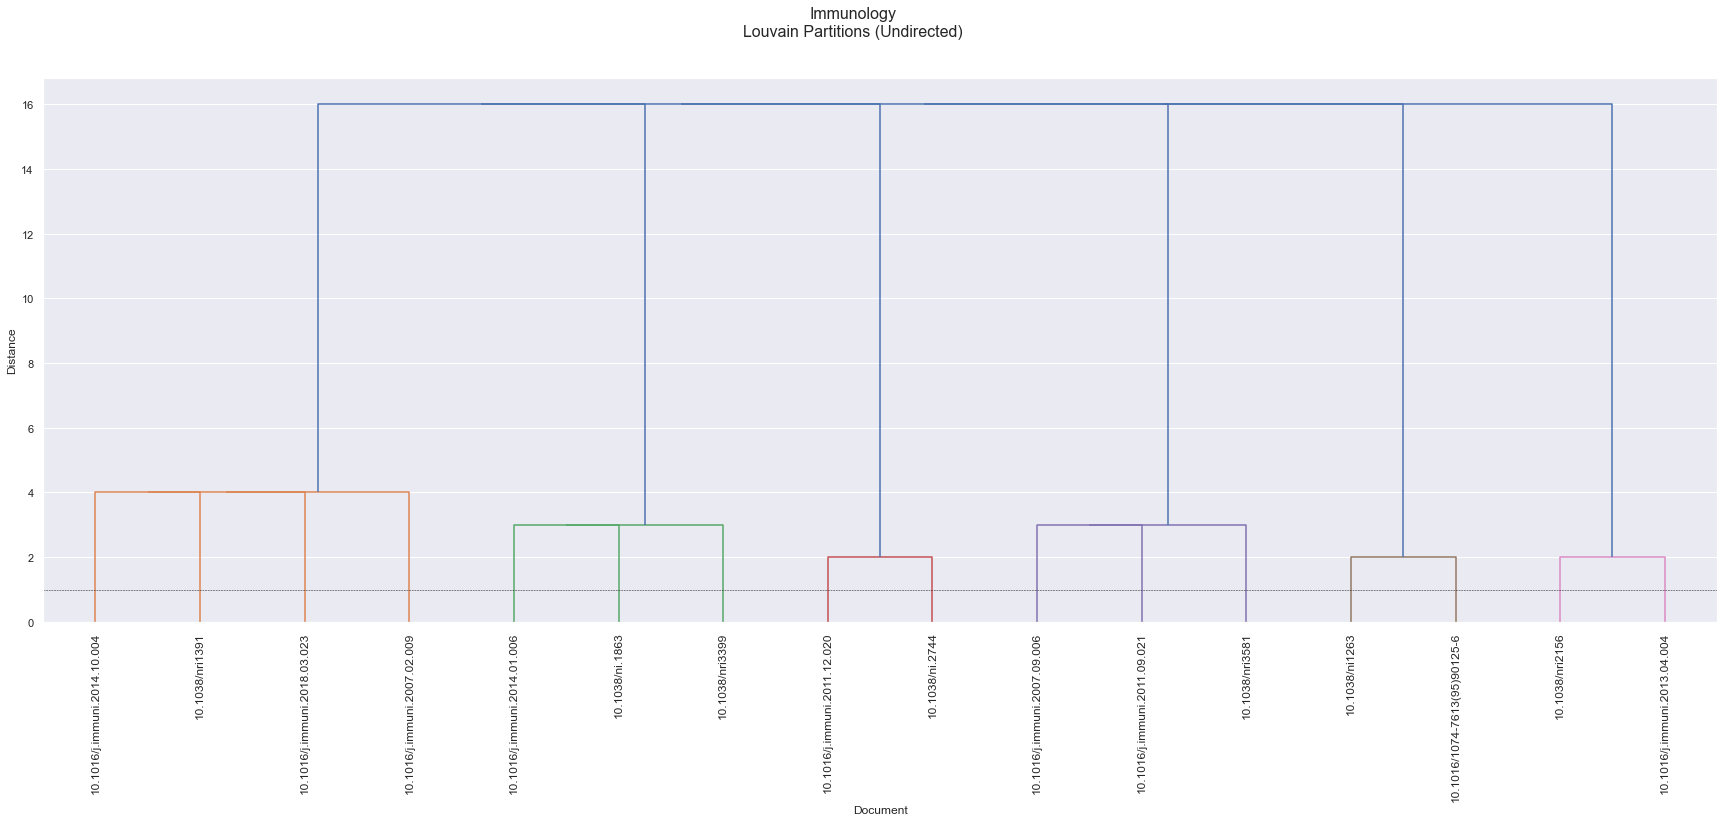

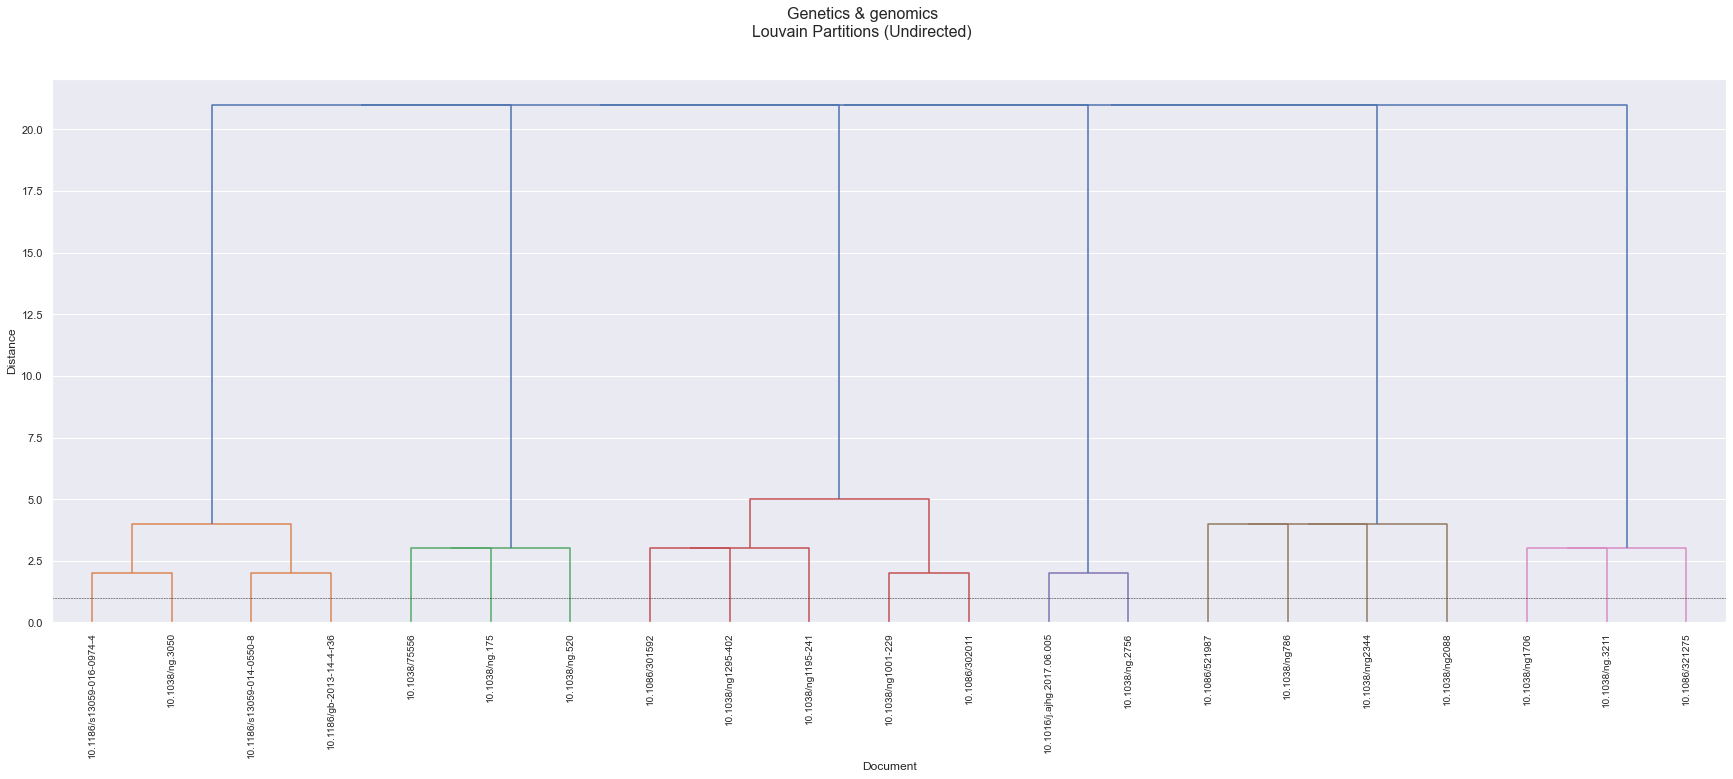

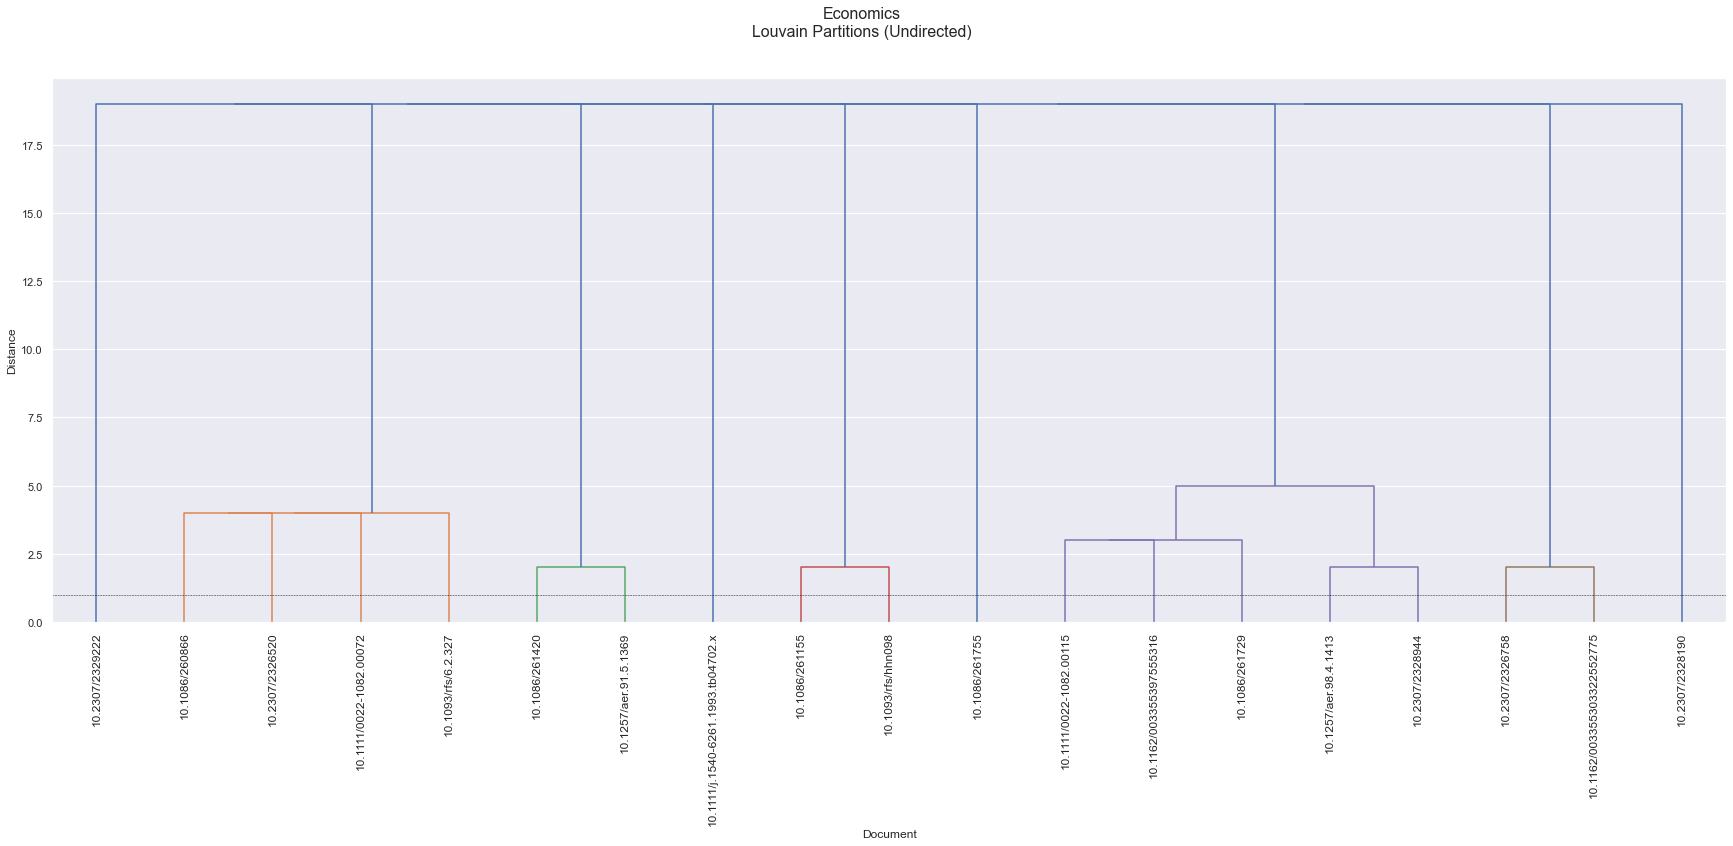

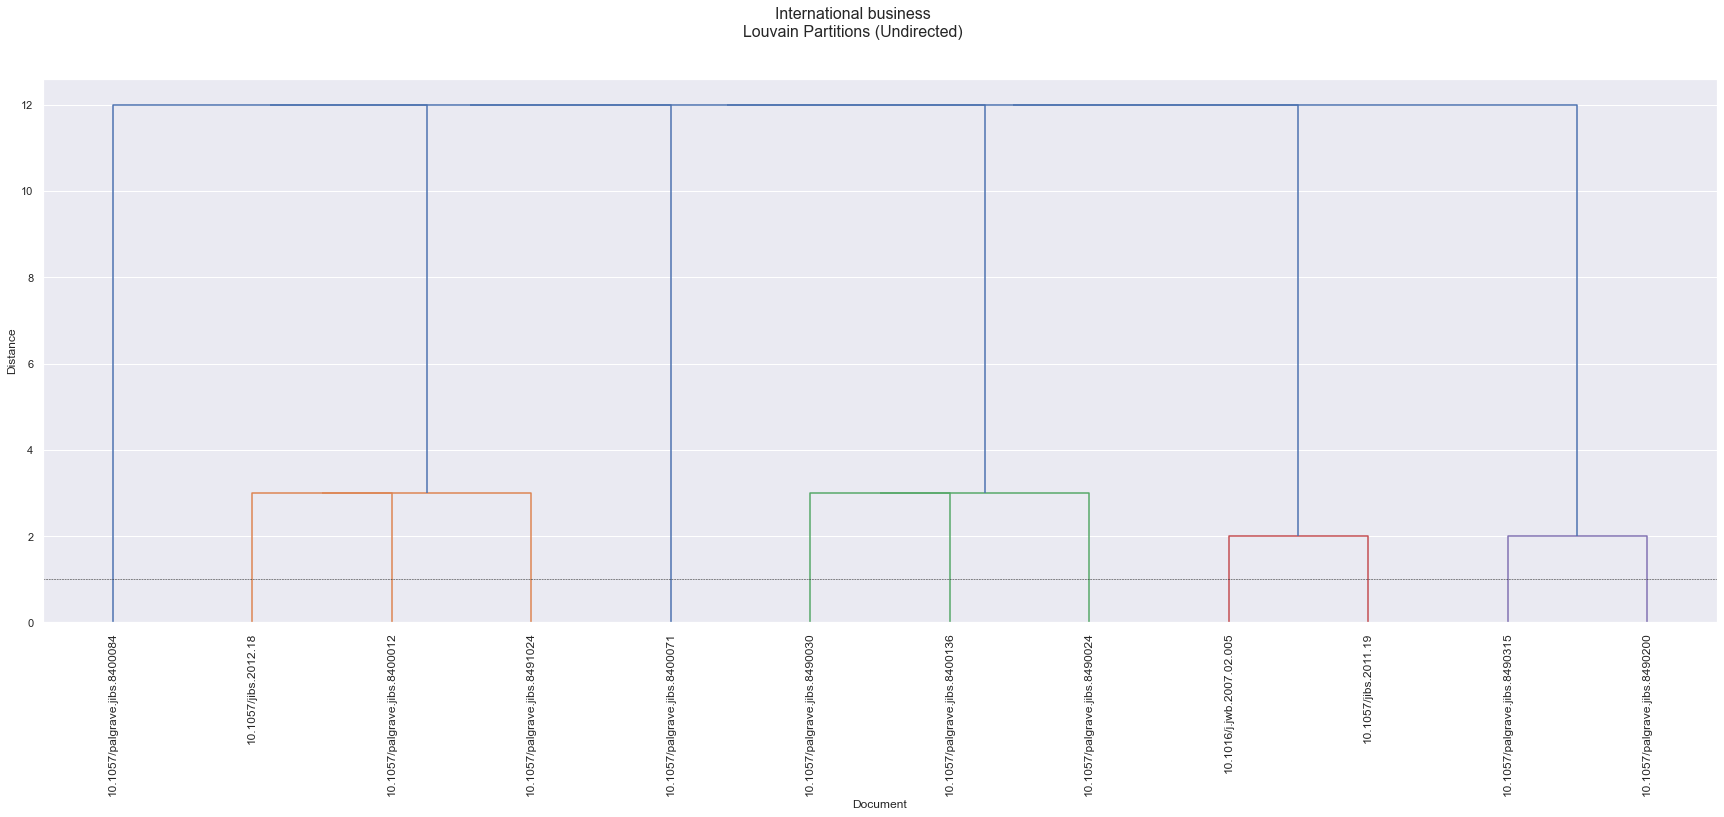

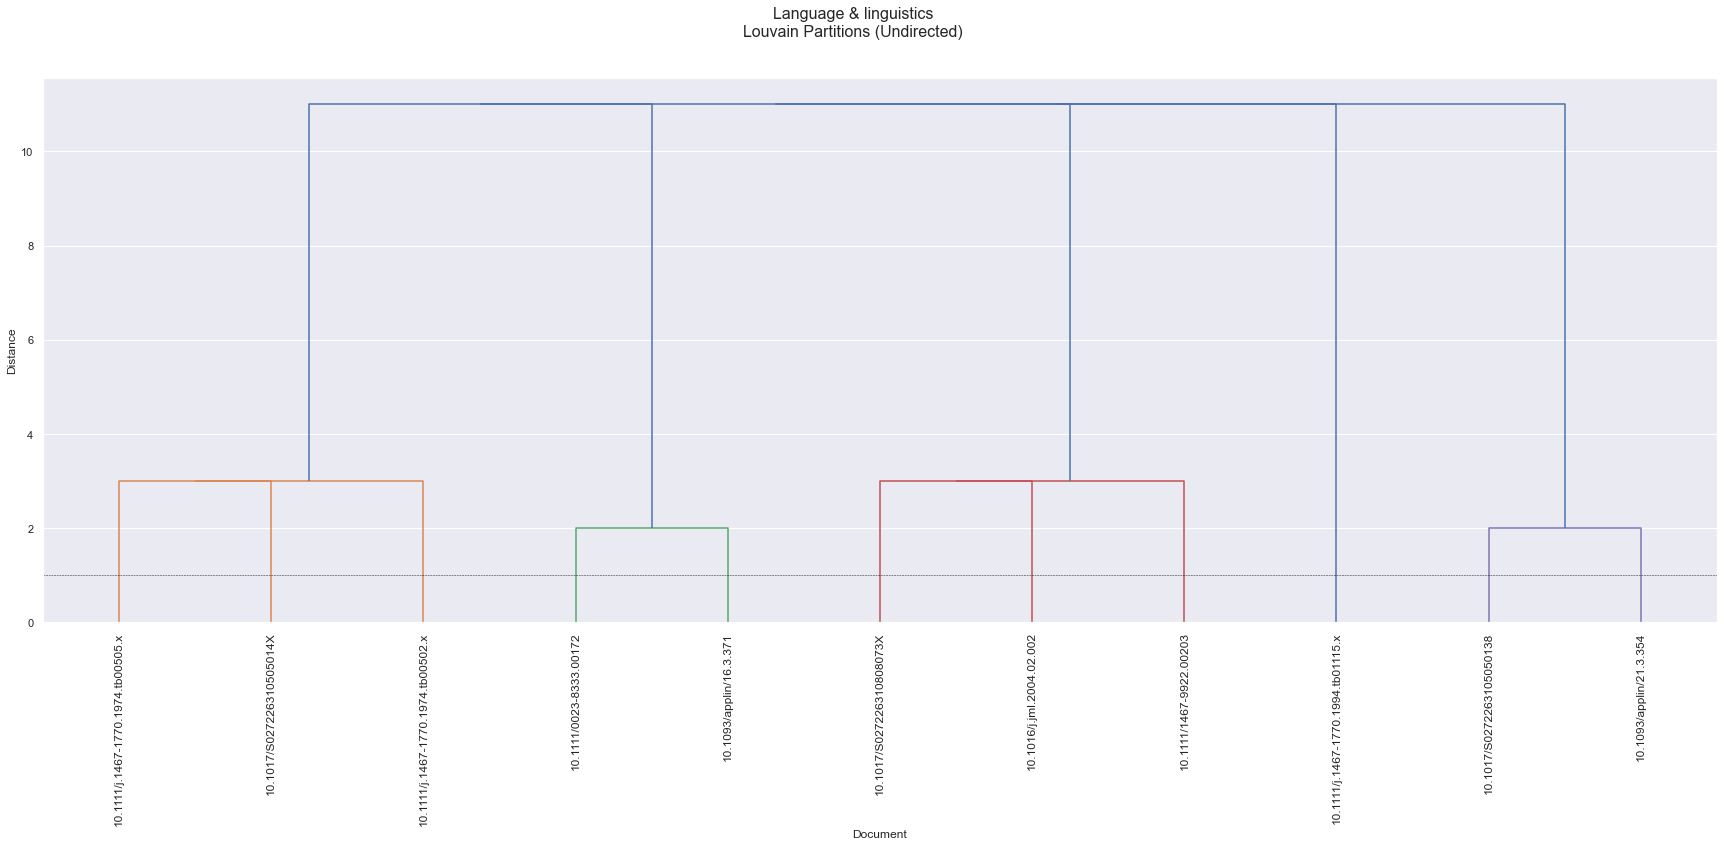

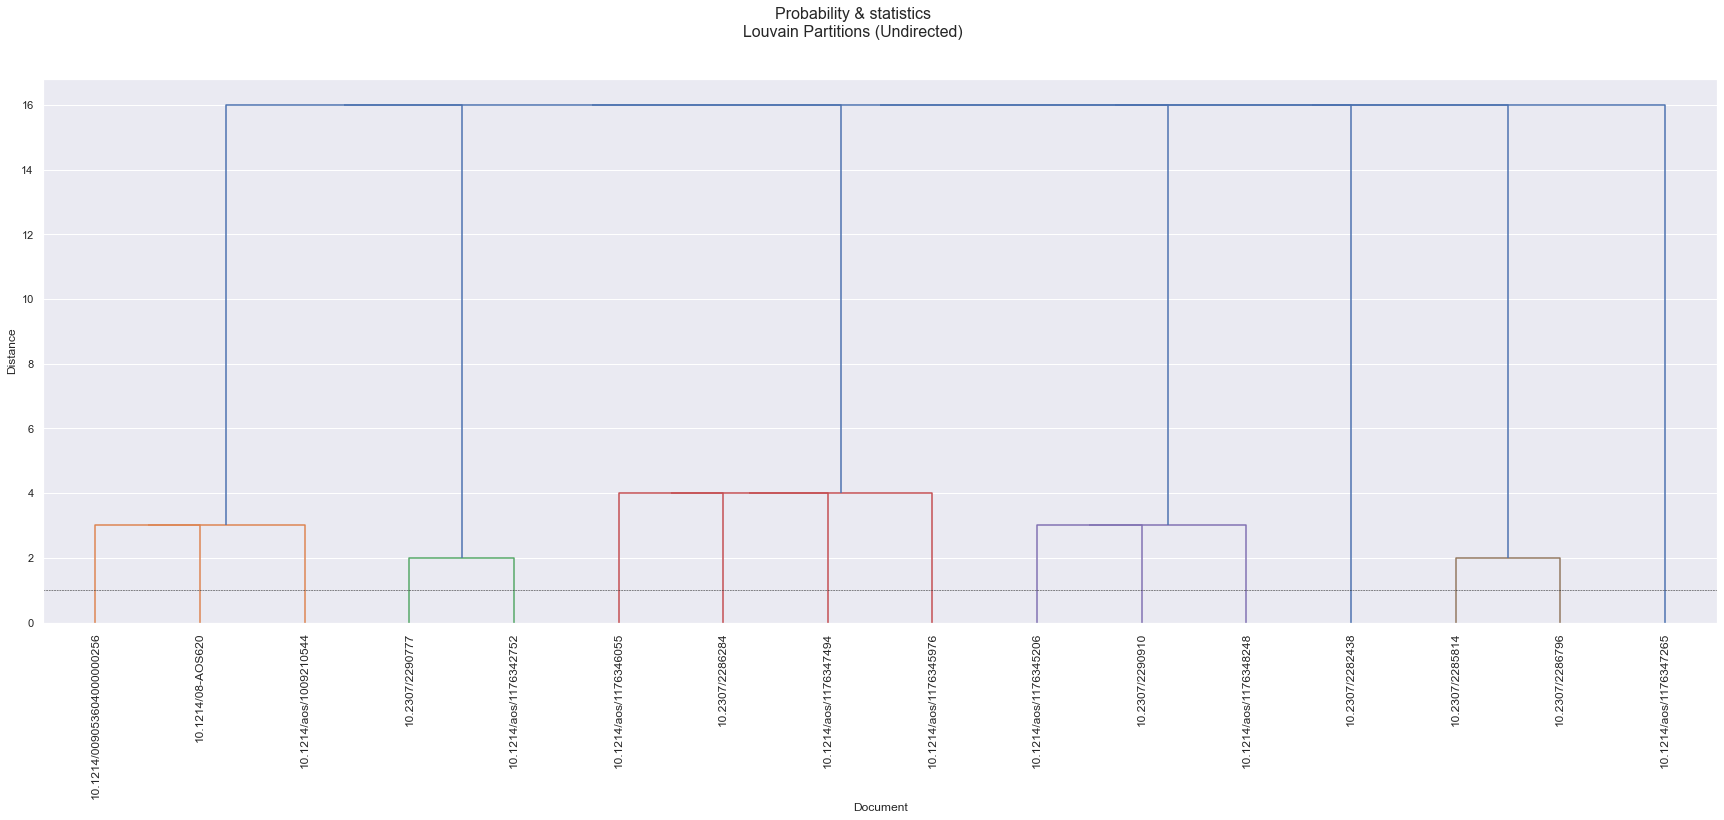

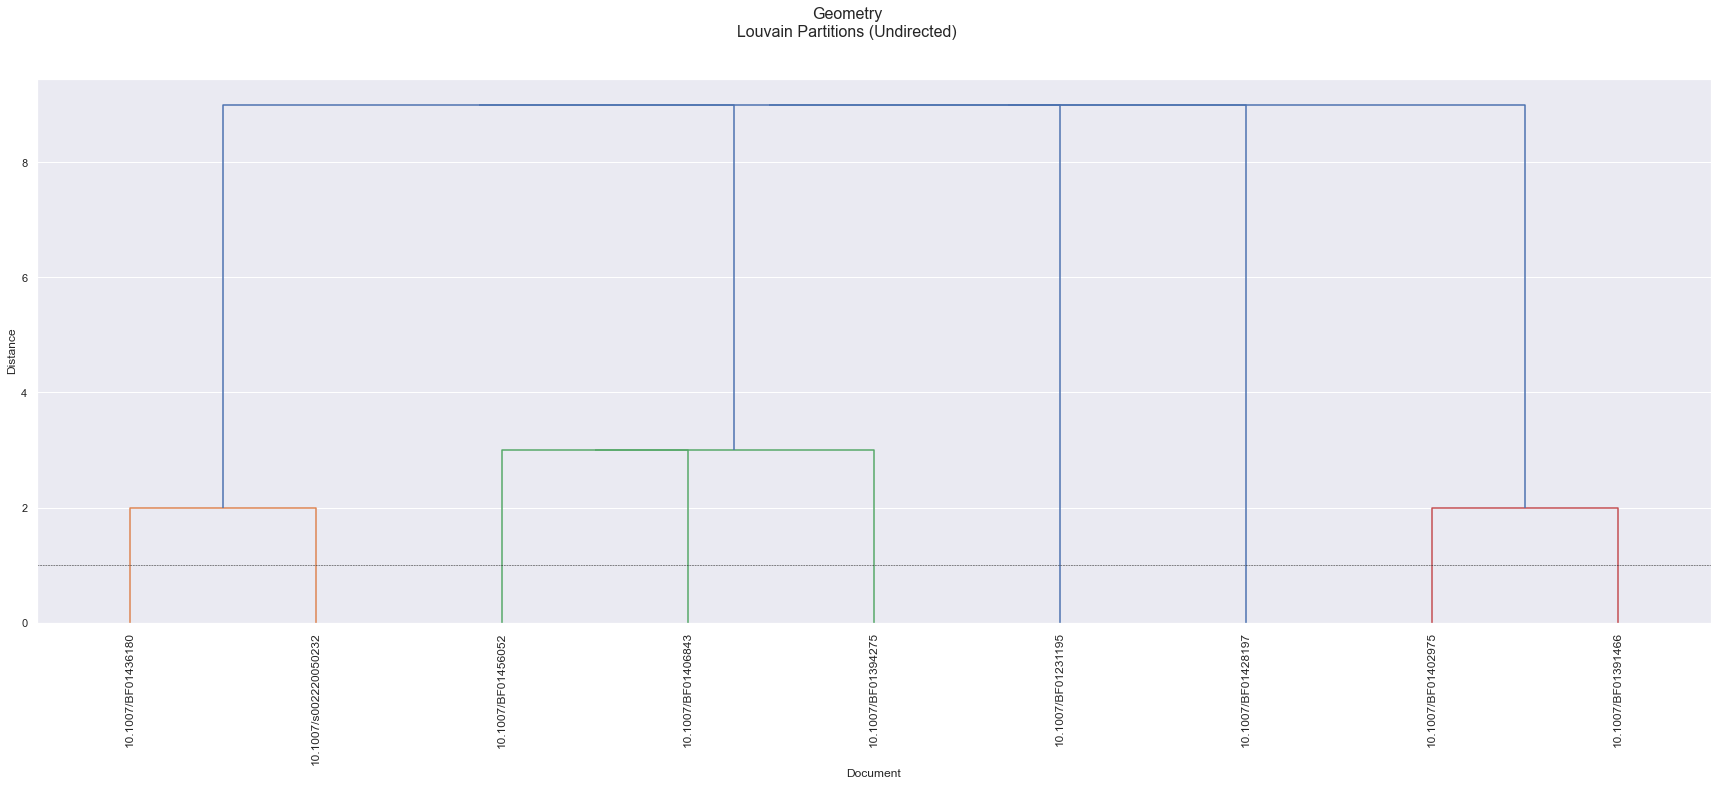

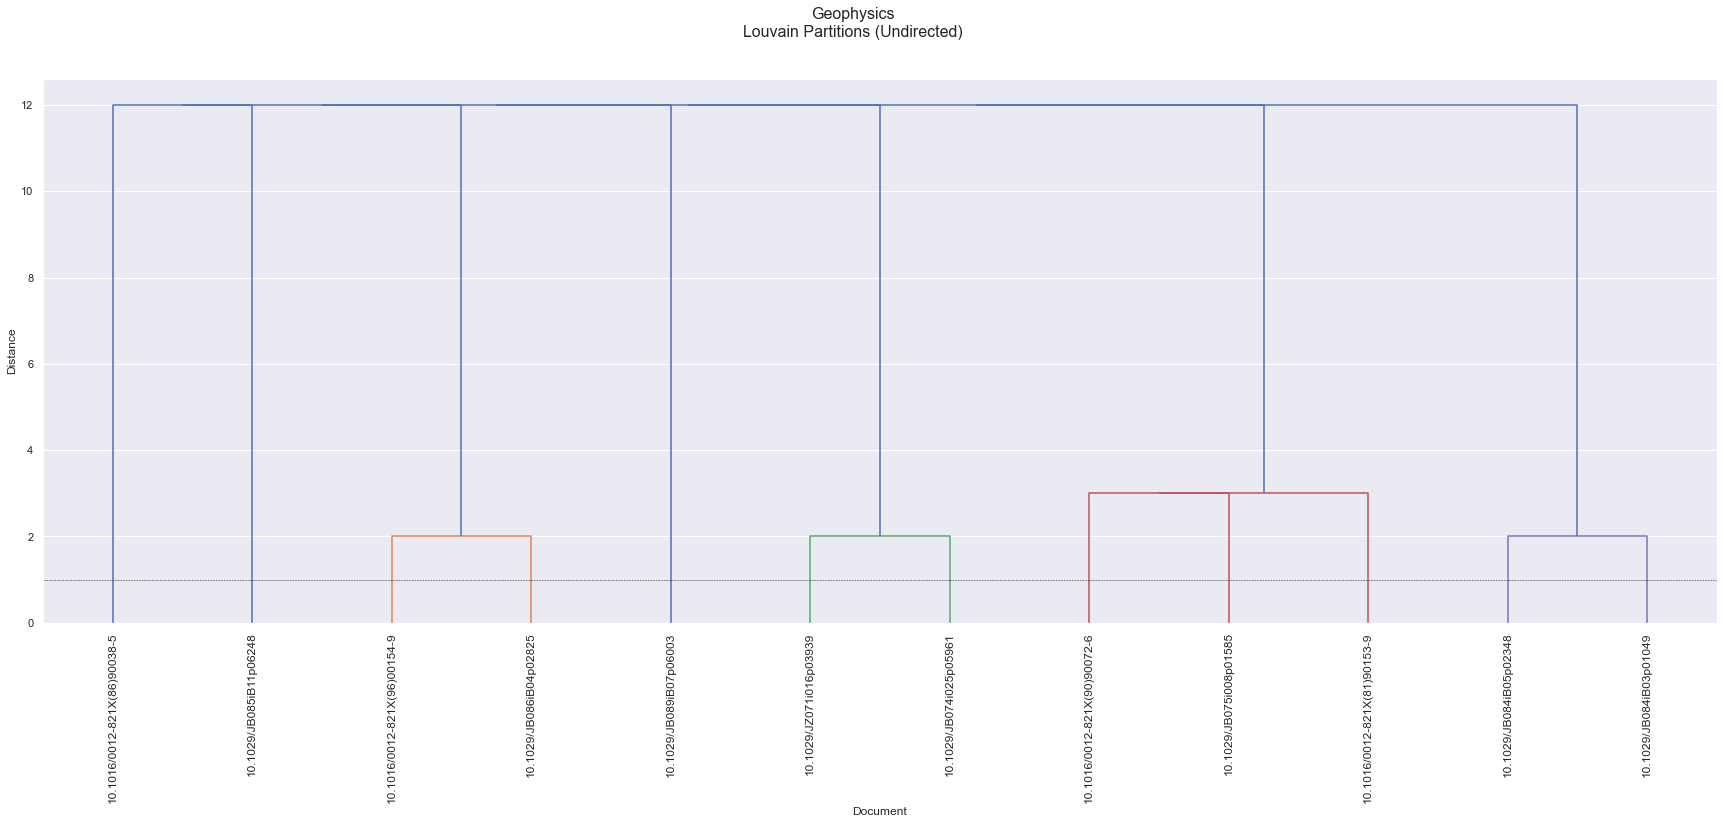

In [20]:
n = 100

louvain_undirected_Z_leaves = {}

for (field_name, corpus) in corpora.data.items():

    df = corpus['citation_df']
    G = corpus['citation_graph']

    in_dgree_centrality_dict = nx.in_degree_centrality(G)
    sorted_first_n_centrality_dict = dict(sorted(in_dgree_centrality_dict.items(), key=lambda x: x[1], reverse=True)[:n])
    nodes = list(sorted_first_n_centrality_dict.keys())

    G = G.subgraph(nodes).to_undirected()
    nodes = max(nx.connected_components(G), key=len)
    G = G.subgraph(nodes)

    levels = list(community.louvain_partitions(G, weight=None, resolution=1, threshold=1e-07, seed=None))
    levels.reverse()
    levels.insert(0, (set(nodes),))
    
    Z_louvain_undirected, leaves_louvain_undirected = compute_Z(levels)

    louvain_directed_Z_leaves[field_name] = {
        'Z': Z_louvain_undirected,
        'leaves': leaves_louvain_undirected
    }

    fig = plt.figure(figsize=(30, 10))
    axes = fig.subplots(1)
    fig.suptitle(f'{field_name}\nLouvain Partitions (Undirected)', fontsize=16)
    plt.xlabel('Document')
    plt.ylabel('Distance')
    dendrogram(Z_louvain_undirected, labels=leaves_louvain_undirected)
    axes.yaxis.grid(True)
    axes.xaxis.grid(False)
    fig.set_facecolor('w')
    plt.axhline(y=1.0, c='k', ls='--', lw=0.5)
    plt.xticks(rotation=90)

    # plt.savefig(f'{img_path}/louvain_undirected_communities_{field_name}.png')
    plt.show()

## Distance Correlation

In [60]:
df = corpora['organizations'].citation_df

n = 100
top_dois, = df.sort(pl.col('InCentrality'), reverse=True).select([pl.col('Doi')])[:n]
top_dois = top_dois.to_list()

all_dois, all_texts = df.select([pl.col('Doi'), pl.col('Text')])
all_dois = all_dois.to_list()

In [5]:
df = corpora.data['Geophysics']['citation_df']

dois, texts = df.select([pl.col('Doi'), pl.col('Text')])

tv = TfidfVectorizer()
tv_matrix = tv.fit_transform(texts) # .toarray()

vocab = tv.get_feature_names_out()

print(type(tv_matrix))

<class 'scipy.sparse._csr.csr_matrix'>


In [7]:
similarity = cosine_similarity(tv_matrix, dense_output=False)

In [ ]:
similarity.to_numpy().round(2)

In [81]:
tv = TfidfVectorizer()
tv_matrix = tv.fit_transform(all_texts).toarray()
vocab = tv.get_feature_names_out()

indices = [all_dois.index(doi) for doi in top_dois]
top_tv_matrix = tv_matrix[indices]

similarity = cosine_similarity(top_tv_matrix).round(3)

keys = np.array([[u, v] for u in top_dois for v in top_dois])
values = similarity.flatten()
values = values.reshape(len(values), 1)

d = np.append(keys, values, axis=1)

df = pl.DataFrame(d, columns=['u', 'v', 'dist'])
df = df.with_columns([
    pl.col('u').cast(pl.Utf8),
    pl.col('v').cast(pl.Utf8),
    pl.col('dist').cast(pl.Float32),
])

shape: (10000, 3)
┌────────────────────────────┬────────────────────────────┬───────┐
│ u                          ┆ v                          ┆ dist  │
│ ---                        ┆ ---                        ┆ ---   │
│ str                        ┆ str                        ┆ f32   │
╞════════════════════════════╪════════════════════════════╪═══════╡
│ 10.1177/014920639101700108 ┆ 10.1177/014920639101700108 ┆ 1.0   │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┤
│ 10.1177/014920639101700108 ┆ 10.2307/258557             ┆ 0.017 │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┤
│ 10.1177/014920639101700108 ┆ 10.2307/2095101            ┆ 0.038 │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┤
│ 10.1177/014920639101700108 ┆ 10.2307/2393553            ┆ 0.029 │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┤
│ ...                        ┆ ...                        ┆ ...   │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┤
│ 10.2307/2666981            ┆ 10.2307/2391211            ┆ 0.017 │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┤
│ 10.2307/2666981            ┆ 10.2307/2393314            ┆ 0.016 │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┤
│ 10.2307/2666981            ┆ 10.2307/2393372            ┆ 0.071 │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┤
│ 10.2307/2666981            ┆ 10.2307/2666981            ┆ 1.0   │
└────────────────────────────┴────────────────────────────┴───────┘

In [18]:
print(tv_matrix.shape)
print(len(dois), len(vocab))

(34164, 60193)
34164 60193


In [49]:
Z = np.array(community_structures['girvan_newman']['organizations']['Z'])
A = Z[:,:3]
df = pl.DataFrame(A, columns=['u', 'v', 'dist'])
df = df.with_columns([
    pl.col('u').cast(pl.Int32),
    pl.col('v').cast(pl.Int32),
    pl.col('dist').cast(pl.Float32),
])
df.select([pl.col('u').unique()])

shape: (96, 1)
┌─────┐
│ u   │
│ --- │
│ i32 │
╞═════╡
│ 0   │
├╌╌╌╌╌┤
│ 1   │
├╌╌╌╌╌┤
│ 2   │
├╌╌╌╌╌┤
│ 3   │
├╌╌╌╌╌┤
│ ... │
├╌╌╌╌╌┤
│ 188 │
├╌╌╌╌╌┤
│ 189 │
├╌╌╌╌╌┤
│ 190 │
├╌╌╌╌╌┤
│ 191 │
└─────┘

## Community Concepts

- Collect all Z matrices 

In [28]:
community_structures = {
    'girvan_newman': girvan_newman_Z_leaves,
    'tfidf_cossim': tfidf_cossim_Z_leaves,
    'louvain': louvain_directed_Z_leaves,
}
# distances = {
#     'genomics': 15,
#     'organizations': 50,
#     'english': 30,
# }

distances = 20

In [29]:
community_structures_name = 'girvan_newman'

for (field_name, corpus) in corpora.data.items():

    df = corpus['citation_df']
    
    Z = community_structures[community_structures_name][field_name]['Z']
    leaves = community_structures[community_structures_name][field_name]['leaves']
    
    df_comm = (
        pl.DataFrame({
            'Doi': leaves, 
            'Community': fcluster(Z, distances, criterion='distance')
        })
        .join(
            df
            .filter(
                pl.col('Doi').is_in(leaves)
            ), 
            on='Doi', 
            how='inner'
        )
        .groupby('Community')
        .agg([
            pl.col('Doi'),
            pl.col('Text'),
        ])
        .select([
            pl.col('Community'), 
            pl.col('Doi'), 
            pl.col('Text').arr.join(' ')]
        )
    )

    communities, dois, texts = df_comm

    communities = communities.to_list()
    dois = dois.to_list()
    texts = texts.to_list()

    tv = TfidfVectorizer()
    tv_matrix = tv.fit_transform(texts).toarray()
    vocab = tv.get_feature_names_out()

    comm_term_tfidf = defaultdict(dict)
    for (i, j) in zip(*np.where(tv_matrix != 0.0)):
        comm_term_tfidf[communities[i]][vocab[j]] = tv_matrix[i][j].round(3)

    comm_term_tfidf = {k: dict(sorted(v.items(), key=lambda x: x[1], reverse=True)) for (k, v) in comm_term_tfidf.items()}

    comm_ids = list(comm_term_tfidf.keys())

    num_cols = len(comm_term_tfidf) * 2
    num_rows = max(len(d) for d in comm_term_tfidf.values())

    tab = np.zeros([num_rows, num_cols], dtype='<U21')

    col = 0
    for comm_id in comm_term_tfidf.keys():

        terms = list(comm_term_tfidf[comm_id].keys())
        terms = np.array(terms).reshape(len(terms),)

        tfidfs = list(comm_term_tfidf[comm_id].values())
        tfidfs = np.array(tfidfs).reshape(len(tfidfs),)

        tab[:len(terms), col] = terms
        tab[:len(tfidfs), col+1] = tfidfs

        col += 2

    df = pd.DataFrame(tab)
    df.columns = pd.MultiIndex.from_product([comm_ids, ['Term', 'Tfidf']])
    df.to_csv(f'./output/tfidf/tfidf_{field_name}.csv')

    print(f'{field_name}')
    ICD.display(df.head(15))

Gender Studies


1       
           Term  Tfidf
0        gender  0.436
1      attitude  0.271
2        toward  0.261
3        sexual  0.232
4           men  0.213
5         woman  0.213
6        sexism  0.203
7    benevolent  0.174
8        female  0.174
9          male  0.165
10     ideology  0.136
11      hostile  0.126
12    prejudice  0.126
13  transphobia  0.126
14   homophobia  0.116

Neurology


6                    2                         8         \
             Term  Tfidf          Term  Tfidf               Term  Tfidf   
0           fiber  0.338         model  0.263  cytoarchitectonic  0.256   
1           fibre  0.338  connectivity  0.261               data  0.256   
2     orientation  0.234       network  0.229            toolbox  0.205   
3            data  0.233    functional  0.196              atlas  0.197   
4       diffusion  0.222        motion   0.19                map  0.189   
5    tractography  0.171          data  0.177               tool  0.189   
6       component  0.132   interaction  0.175               mask  0.182   
7           noise  0.116         brain  0.173             priori  0.182   
8        weighted  0.116          head  0.146               area   0.18   
9   deconvolution  0.114       subject  0.143         functional   0.18   
10            ica  0.114      response  0.139            testing  0.157   
11            fix  0.113          fmri  0.129           analysis  0.154   
12            mri  0.106         bayes   0.11              based  0.154   
13            hcp  0.099      coupling   0.11               fmri  0.154   
14           fmri  0.096        change  0.108         hypothesis  0.142   

              9                    4                    5                   3  \
           Term  Tfidf          Term  Tfidf          Term  Tfidf         Term   
0   conjunction  0.458       cluster  0.315       surface  0.329       visual   
1     cognitive  0.319     inference  0.244  registration  0.242         task   
2    activation  0.234     threshold  0.194         brain  0.194     decrease   
3       emotion  0.217           age  0.178         image  0.178    attention   
4        memory  0.217     diffusion  0.178      cortical   0.16     location   
5          task  0.169         image  0.168      semantic  0.139      network   
6        region  0.132        matter  0.168     algorithm  0.138       cortex   
7     emotional  0.128         voxel  0.168         based   0.13     inferior   
8      analysis   0.12          data  0.144        method  0.125     parietal   
9       subject  0.112         level  0.144          task  0.123     stimulus   
10       reward  0.109       imaging  0.124        fischl  0.118      passive   
11        study  0.108         based  0.123         atlas  0.115       active   
12   prefrontal  0.096          gray  0.119        cortex  0.111     activity   
13       effect  0.092      analysis  0.117          data  0.111      frontal   
14        fixed  0.092  thresholding  0.113      labeling   0.11  attentional   

                         1                    7         
    Tfidf             Term  Tfidf          Term  Tfidf  
0   0.274         response  0.258         shell  0.313  
1   0.259             fmri   0.23      clinical  0.307  
2   0.244             bold   0.16    dispersion  0.261  
3   0.213             time   0.16       neurite  0.209  
4     0.2      hemodynamic   0.15         noddi  0.209  
5   0.187         analysis   0.14   orientation  0.203  
6   0.185           region  0.138         index  0.176  
7   0.177          subject  0.138  segmentation  0.169  
8   0.167           signal  0.135          snap  0.157  
9   0.167           linear   0.13      protocol  0.135  
10  0.158         temporal  0.129     optimized  0.132  
11  0.154           across  0.123       density  0.121  
12  0.137             task  0.123           two  0.111  
13  0.136             data  0.122   feasibility  0.104  
14  0.135  autocorrelation  0.118         hardi  0.104

Artificial Intelligence


4                  8                     2         \
              Term  Tfidf        Term  Tfidf           Term  Tfidf   
0             grad  0.367      object  0.274          image  0.314   
1              cam   0.31       shape  0.221           sift  0.251   
2         learning  0.237      motion  0.212        network  0.193   
3      explanation  0.229       point  0.205          scene  0.193   
4          network  0.208      method   0.18  convolutional  0.191   
5            model  0.194       image  0.149       neighbor  0.189   
6       captioning  0.184       based  0.135         object  0.174   
7    visualization  0.184       model  0.135           flow  0.164   
8             deep  0.169    tracking   0.13      histogram  0.145   
9   representation  0.156         set  0.129        nearest  0.145   
10            help  0.135      latent  0.124       semantic  0.137   
11            cnns  0.116   algorithm   0.12         search  0.126   
12        question  0.116    temporal   0.12          fully  0.121   
13           image  0.106  descriptor  0.117          large   0.11   
14          design  0.101    estimate  0.115          dense  0.109   

               9                    5                    7         \
            Term  Tfidf          Term  Tfidf          Term  Tfidf   
0          graph  0.421        filter  0.543          face  0.386   
1         energy  0.381   orientation  0.376         image    0.3   
2            cut  0.327     steerable  0.288   recognition  0.266   
3      algorithm  0.257      adaptive  0.216        object  0.234   
4   minimization  0.184        design  0.188          pose  0.184   
5         markov   0.14         steer  0.171      subspace  0.183   
6          image  0.125         phase  0.144   dimensional  0.164   
7       function  0.102       control  0.111        sparse  0.162   
8        problem  0.102           one  0.108        linear  0.156   
9   segmentation  0.097          edge  0.099  illumination  0.141   
10        vision  0.095        useful  0.089         model  0.141   
11         chain  0.093       adelson  0.085     algorithm   0.12   
12           lrr  0.093  analytically  0.085        method  0.106   
13        stereo  0.079     angularly  0.085         space  0.104   
14        ddmcmc  0.078     calculate  0.085    lambertian    0.1   

                 1                     3                   6         
              Term  Tfidf           Term  Tfidf         Term  Tfidf  
0         tracking  0.572         object  0.323        image  0.249  
1           target  0.211          image  0.259    invariant  0.212  
2         activity  0.205      challenge  0.192    retrieval   0.21  
3           motion  0.171        network  0.179        shape  0.207  
4             site  0.164   segmentation  0.179     detector   0.19  
5           system  0.149     annotation  0.152     rotation  0.177  
6           object  0.135            cnn  0.151   descriptor  0.169  
7          pfinder  0.123        dataset   0.14        local  0.163  
8            model  0.122      detection  0.136        point  0.158  
9       appearance  0.119     objectness  0.124       method  0.142  
10          camera  0.104         segnet   0.11  recognition  0.128  
11          change  0.104   relationship  0.105        feret  0.124  
12  representation  0.104         search  0.105       action  0.123  
13            time  0.096          state  0.104       binary  0.123  
14           based  0.087  convolutional  0.101     category  0.121

Sociology


1                    6                     4         \
              Term  Tfidf          Term  Tfidf           Term  Tfidf   
0           mother  0.311       emerson  0.566     friendship  0.315   
1             wage  0.311         power  0.474         gender  0.315   
2              job  0.237          cook  0.316         social  0.244   
3          penalty  0.213      exchange  0.239      homophily  0.225   
4        important  0.198       network  0.212         school  0.189   
5       motherhood   0.17    commitment  0.189       boundary  0.188   
6            child  0.166    dependence  0.189     inequality  0.167   
7      segregation  0.143        equity  0.189    segregation  0.163   
8            woman  0.143      gillmore  0.189           race   0.15   
9    establishment  0.142     yamagishi  0.189        network  0.148   
10           model  0.126  distribution  0.158        process  0.143   
11       advantage  0.119  experimental  0.136   organization  0.136   
12      occupation  0.119      relation   0.12  interactional  0.126   
13        criminal  0.113        result  0.106        science  0.113   
14  discrimination  0.113        theory  0.084            tie  0.109   

               3                    8                     2         \
            Term  Tfidf          Term  Tfidf           Term  Tfidf   
0         social  0.435        duncan  0.452         medium  0.426   
1        capital  0.259   residential  0.339       coverage  0.317   
2   neighborhood  0.232   segregation  0.292        protest  0.317   
3         action  0.227        denton  0.269  demonstration  0.254   
4        network  0.195        massey  0.269          issue  0.213   
5   embeddedness  0.193          blau  0.226     washington   0.19   
6        culture  0.146    inequality  0.171       movement  0.161   
7       economic  0.146       allison  0.135      attention  0.138   
8        concept   0.14         asian  0.135      comparing  0.127   
9      structure  0.135          berk  0.135          cycle  0.127   
10           tie  0.126   correlation  0.135     insurgency  0.127   
11        effect  0.123      hispanic  0.135        jenkins  0.127   
12           one  0.116         index  0.135     likelihood  0.127   
13      analysis  0.087  introduction  0.135         mcadam  0.127   
14       control  0.084  metropolitan  0.135       mccarthy  0.127   

                 5                       7         
              Term  Tfidf             Term  Tfidf  
0     organization  0.319            crime  0.463  
1          process  0.245  disorganization  0.276  
2          framing  0.184           felson  0.276  
3   organizational  0.184            grove  0.276  
4            state   0.17           social  0.276  
5        diversity  0.147          testing  0.276  
6    environmental  0.147            cohen  0.231  
7            model   0.14          routine  0.231  
8         movement   0.14          sampson  0.231  
9      environment  0.139            trend  0.231  
10          market  0.139           change    0.2  
11         society  0.139         activity  0.175  
12          social  0.138        community  0.175  
13           world  0.133             rate  0.175  
14  responsibility   0.11         approach  0.155

Ethnic & Cultural Studies


6                        1                        11         \
             Term  Tfidf              Term  Tfidf              Term  Tfidf   
0     religiosity  0.419     transnational  0.388             white  0.271   
1       religious  0.402         migration   0.22            racism  0.261   
2          gender  0.326            london    0.2            polish  0.237   
3        symbolic  0.233       citizenship  0.199              race  0.224   
4        equality  0.163  transnationalism  0.188          violence  0.222   
5          german   0.14       integration  0.184            racial  0.214   
6           among  0.137           migrant  0.184           migrant   0.21   
7          ethnic  0.127           network  0.157             color  0.146   
8           group  0.126            family  0.156            racist  0.142   
9        attitude   0.11         immigrant  0.155         whiteness  0.142   
10      ethnicity   0.11            social  0.155  microaggressions  0.111   
11    behavioural  0.109            highly  0.142            safety  0.111   
12    egalitarian  0.109           skilled  0.114            people  0.107   
13     explaining  0.109             socio  0.113          dialogue  0.095   
14  acculturation  0.099              term  0.113         discourse  0.084   

                   7                      10         ...             5   \
                 Term  Tfidf            Term  Tfidf  ...           Term   
0          remittance  0.743            race   0.38  ...      migration   
1           political  0.328          racial  0.312  ...  racialization   
2            practice   0.12        identity    0.3  ...      immigrant   
3              social  0.115           white  0.292  ...           race   
4              affect   0.11          latino  0.248  ...         racism   
5            capacity  0.109       dimension  0.186  ...          study   
6          collective  0.109  categorization  0.177  ...      continues   
7         communicate  0.109          racism  0.166  ...           nexi   
8         influencing  0.109          racist  0.121  ...          focus   
9   conceptualisation  0.093       framework  0.117  ...    immigration   
10     organisational  0.093   comprehensive  0.106  ...           call   
11              scale  0.093         latinas  0.106  ...          major   
12         individual   0.09          social  0.105  ...          nexus   
13            article  0.078         article  0.101  ...   contemporary   
14          narrative  0.073         process  0.098  ...        neglect   

                      9                      4                     8          \
    Tfidf           Term  Tfidf            Term  Tfidf           Term  Tfidf   
0   0.414      migration  0.615      generation  0.314      immigrant  0.389   
1   0.374  transnational  0.168          second  0.239        capital  0.253   
2   0.344     aspiration  0.164     integration  0.228     employment  0.229   
3   0.336         theory  0.142       religious  0.209          model  0.206   
4   0.168       internal   0.14            city  0.174            job  0.172   
5   0.157        migrant  0.112         context  0.167            low  0.172   
6   0.125        dynamic   0.11        predicts  0.155      formation  0.154   
7   0.125  international   0.11  secularization  0.155  incorporation  0.154   
8   0.114         social  0.107        vitality  0.155        pattern  0.154   
9   0.114        ability  0.104          europe  0.133          human  0.139   
10  0.107       diaspora  0.104   participation  0.133      financial  0.131   
11  0.107    theoretical  0.098     religiosity  0.133        society  0.126   
12  0.107       mobility   0.09        strongly  0.133        economy  0.115   
13  0.103         agency  0.089          theory   0.13  neighbourhood  0.115   
14  0.094        examine  0.089       belonging  0.126     trajectory  0.115   

              3          
            Term  Tfidf  

Law


12                      3                      7          \
          Term  Tfidf             Term  Tfidf            Term  Tfidf   
0        class  0.454            power  0.245  constitutional  0.455   
1         tort  0.303           agency  0.235             law   0.31   
2       action   0.26         doctrine  0.221             age    0.3   
3     attorney  0.151      legislative  0.169      aleinikoff    0.3   
4   bankruptcy  0.151   administration  0.154       balancing    0.3   
5       coffee  0.151            court  0.154          fallon    0.3   
6    corporate  0.151       separation  0.147         meltzer    0.3   
7   derivative  0.151         judicial  0.143             non    0.3   
8      dilemma  0.151   administrative  0.137   retroactivity    0.3   
9     hansmann  0.151    nondelegation  0.137          remedy  0.258   
10    kraakman  0.151        executive  0.132                          
11     lopucki  0.151          article  0.127                          
12       macey  0.151          chevron   0.12                          
13        mass  0.151  experimentalism   0.12                          
14      miller  0.151   constitutional  0.117                          

             10                    1          ...            5          \
           Term  Tfidf           Term  Tfidf  ...          Term  Tfidf   
0      property  0.443         siegel   0.24  ...        sherry  0.574   
1          rule  0.328           wife   0.24  ...     unwritten  0.574   
2   anticommons  0.203         status  0.234  ...  constitution  0.435   
3          land  0.153          right  0.213  ...       founder  0.391   
4       default  0.152            law  0.195  ...                        
5       tragedy  0.152  modernization  0.171  ...                        
6         right  0.144          woman  0.147  ...                        
7    bargaining  0.131          state   0.14  ...                        
8   contracting  0.127        marital  0.137  ...                        
9     efficient  0.127     nineteenth  0.137  ...                        
10    strategic  0.127    prerogative  0.137  ...                        
11         many  0.125        century   0.13  ...                        
12         cost  0.115          civil   0.13  ...                        
13    liability  0.115          claim   0.13  ...                        
14     resource  0.109       feminist  0.118  ...                        

              9                    2                   6                   11  \
            Term  Tfidf          Term  Tfidf         Term  Tfidf         Term   
0       sunstein  0.375       benefit   0.44      neutral  0.529       sexual   
1         social   0.34          cost  0.324  restriction  0.529   harassment   
2       anderson  0.275      analysis  0.263        stone  0.529         work   
3         pildes  0.236       project  0.256      content  0.401  environment   
4         theory  0.155    preference  0.194                          hostile   
5     analogical  0.138         adler  0.171                          schultz   
6          arrow  0.138  unrestricted  0.171                       supervisor   
7         berger  0.138        agency  0.147                        workplace   
8         beyond  0.138    evaluation  0.147                              sex   
9          cover  0.138        health  0.147                            woman   
10  interference  0.138        posner  0.147                        professor   
11         kahan  0.138       welfare  0.147                          account   
12     pluralism  0.138       defense  0.129                            based   
13   restatement  0.138     aggregate  0.085                             male   
14     rubenfeld  0.138     appealing  0.085                        masculine   

           
    Tfidf  
0   0.444  
1     0.4  
2   0.229  
3   0.222  
4   0.222  
5   0.222  
6   0.133  
7   0.133  
8   0.114  
9   0.114  
10    

Material Engineering


1                       3                   2       
           Term  Tfidf             Term  Tfidf         Term  Tfidf
0         layer  0.236         material  0.306         skin  0.327
1      material  0.205          battery  0.296     graphene  0.264
2        atomic    0.2              ion  0.282       sensor  0.196
3    transition  0.173           energy  0.262   electronic  0.173
4   dimensional  0.162         graphene   0.23         high  0.142
5        single  0.162        capacitor  0.148        array  0.138
6      hydrogen   0.16        electrode  0.141     pressure  0.138
7     evolution  0.152           method  0.131       device  0.132
8      boundary  0.147  electrochemical  0.127       matrix   0.12
9           two  0.134          storage  0.127    reduction   0.12
10   molybdenum  0.133          lithium  0.099  stretchable   0.12
11         edge   0.12      application  0.098      network  0.118
12  phosphorene   0.12           device  0.098       oxygen  0.118
13         high   0.11              gas  0.093  application  0.112
14          alc  0.107           hummer  0.093  integration  0.105

Human Resources & Organizations


3                    1                  4         \
              Term  Tfidf          Term  Tfidf        Term  Tfidf   
0   identification   0.36        family  0.712    exchange  0.401   
1              job  0.341          work  0.345   signaling  0.316   
2       commitment  0.227      conflict  0.201      theory  0.252   
3         identity  0.205          life  0.133  conceptual  0.212   
4       engagement  0.179    commitment   0.13         lmx   0.19   
5           career  0.159        career  0.122       party   0.19   
6         turnover  0.156       benefit  0.111  management  0.142   
7     embeddedness  0.143       country  0.109      social  0.141   
8             meta   0.12       related  0.088   ambiguity  0.126   
9   organizational  0.115         model  0.087      choose  0.126   
10            self  0.114         scale  0.087     despite  0.126   
11     performance  0.112           job  0.077        must  0.126   
12           cycle  0.108     affective  0.061      signal  0.126   
13          theory    0.1  construction  0.061         set   0.12   
14      antecedent  0.096       culture  0.061      leader  0.106   

              8                       2                  7         \
           Term  Tfidf             Term  Tfidf        Term  Tfidf   
0     diversity  0.305        proactive  0.367        team  0.355   
1          team  0.252         behavior   0.36  management  0.277   
2       success  0.214       creativity  0.287       level  0.259   
3        career  0.213              job  0.186         top  0.256   
4       network  0.205         employee  0.171    decision  0.211   
5   empowerment  0.183         research  0.156       group  0.185   
6     mentoring  0.183   organizational  0.127  multilevel  0.179   
7       surface  0.183           taking  0.123    research   0.17   
8         level  0.177            trust  0.123      change  0.146   
9         group  0.174           charge  0.122     process  0.142   
10      related  0.137            voice  0.122   strategic  0.128   
11       social  0.136     organization  0.109       study   0.12   
12         time  0.135             self  0.109      making  0.113   
13     equation  0.132       innovative  0.102       board  0.112   
14         deep  0.128  dissatisfaction  0.098       power  0.112   

                  6                    5         
               Term  Tfidf          Term  Tfidf  
0              firm   0.38    creativity  0.341  
1          resource  0.244    innovation  0.294  
2       performance  0.243           low  0.205  
3          alliance  0.217          high  0.183  
4              unit  0.199         scale  0.177  
5          business  0.181        search  0.177  
6             human   0.17         cause  0.163  
7   diversification  0.167  discriminate  0.163  
8         advantage  0.145        launch  0.163  
9       competitive  0.145          risk  0.163  
10        knowledge  0.137  shipbuilding  0.163  
11          product  0.118         slack  0.163  
12         practice  0.115   performance  0.145  
13        interfirm  0.109     assessing  0.136  
14        sustained  0.109     intensity  0.136

Political Science


1                   7                      3         \
             Term  Tfidf         Term  Tfidf            Term  Tfidf   
0        economic  0.379         data  0.238  representation  0.494   
1        spending  0.317   multilevel  0.235          policy    0.3   
2          public  0.247        cross  0.206     descriptive  0.217   
3          policy  0.235          war  0.206         context   0.18   
4     expectation  0.191     economic  0.188       criterion   0.18   
5      preference  0.144         time  0.181          public  0.175   
6   congressional  0.141        btscs  0.177      promissory  0.162   
7        election  0.127     analysis   0.16           group  0.154   
8          change  0.123         show  0.146         opinion  0.154   
9       component  0.114       series  0.127            form  0.115   
10       consumer  0.114  statistical  0.127       mechanism  0.115   
11         domain  0.114        model  0.123          global  0.108   
12  retrospective  0.114    political  0.123      historical  0.108   
13          short  0.114        civil  0.122      mansbridge  0.108   
14         voting  0.109      analyst  0.118        recently  0.108   

             5                   2                     6                   4  \
          Term  Tfidf         Term  Tfidf           Term  Tfidf         Term   
0        party  0.273    candidate  0.442        turnout  0.674       survey   
1      machine  0.268  legislative  0.208          voter  0.291        voter   
2       causal  0.238        model  0.174       habitual  0.169     informed   
3       medium  0.179     argument  0.172        unequal  0.135  information   
4        order  0.149         roll  0.172     experiment  0.112    political   
5        group  0.148        party  0.144     canvassing  0.101        state   
6        voter  0.129       voting  0.141  developmental  0.101        issue   
7    mechanism  0.127        issue  0.128         direct  0.101        fully   
8         news  0.124     election  0.127           mail  0.101   processing   
9     exposure  0.119       member  0.123       resource  0.101     shortcut   
10       frame  0.119         bias  0.119      telephone  0.101     ideology   
11     present  0.119     district  0.119        citizen  0.096         data   
12   tolerance  0.119      support  0.105       election  0.096         vote   
13  assumption   0.11    electoral  0.099          field  0.096     multiple   
14    politics   0.11         call  0.096            low  0.084       choice   

           
    Tfidf  
0   0.262  
1    0.24  
2   0.239  
3   0.198  
4   0.197  
5   0.167  
6   0.161  
7   0.152  
8   0.131  
9   0.131  
10   0.13  
11  0.127  
12  0.127  
13  0.111  
14  0.109

Immunology


4                 5                       6                   3  \
           Term  Tfidf       Term  Tfidf             Term  Tfidf         Term   
0   recognition  0.409       cell  0.494             cell  0.672    molecular   
1      receptor  0.392        ilc  0.319              tfh  0.366       immune   
2          prrs  0.293       ilcs  0.254             cxcr  0.149         tlrs   
3          like  0.274   lymphoid  0.239           helper  0.146   signalling   
4          toll  0.212       lung  0.161            gamma  0.141         toll   
5     crosstalk  0.195     airway  0.159             beta  0.136    mechanism   
6         kawai  0.195     innate  0.156  differentiation  0.115     specific   
7        innate  0.174   allergen  0.127       follicular  0.115      pattern   
8         akira  0.164     papain  0.127        producing  0.113    different   
9          tlrs  0.164   receptor  0.127            delta  0.105         gene   
10         role  0.156  influenza   0.12              tgf  0.096         like   
11          tlr  0.141      gamma  0.116       expression  0.089     recently   
12      pattern  0.124     helper  0.111              bcl  0.084       answer   
13     immunity  0.117        lnh  0.111         effector  0.082      binding   
14     pathogen  0.117        nkp  0.111            naive  0.079  epigenetics   

                    1                  2                     8         \
    Tfidf        Term  Tfidf        Term  Tfidf           Term  Tfidf   
0   0.308    monocyte   0.51  macrophage   0.61           cell  0.573   
1   0.243  macrophage  0.376        cell   0.24           foxp  0.445   
2   0.204      tissue  0.223  neutrophil  0.228            reg  0.277   
3   0.176        cell  0.203  activation  0.217     regulatory  0.222   
4   0.176      steady  0.162    function  0.165           ctla  0.193   
5   0.163    resident  0.117     myeloid   0.13          mouse  0.181   
6   0.163  population  0.114      immune  0.108           treg  0.172   
7   0.154       blood  0.103    response  0.108           self  0.101   
8   0.136       state  0.103      tissue  0.107       function   0.09   
9   0.136   dendritic  0.102   different  0.098         factor  0.086   
10  0.136     ginhoux  0.101    monocyte  0.098  transcription  0.075   
11  0.136       mouse  0.101  population  0.098      deficient  0.074   
12  0.121    ontogeny  0.101  plasticity  0.097      selection  0.071   
13  0.121      subset  0.101      discus  0.086     thymocytes  0.071   
14  0.121    adhesion  0.085      system  0.086     autoimmune   0.07   

                  7         
               Term  Tfidf  
0              cell  0.625  
1            memory  0.293  
2        exhaustion  0.234  
3         infection  0.166  
4         metabolic   0.16  
5          effector  0.155  
6        inhibitory  0.149  
7           pathway  0.101  
8          receptor  0.095  
9        expression  0.086  
10            covid  0.085  
11        exhausted  0.085  
12         response  0.077  
13  intraepithelial  0.075  
14          chronic  0.074

Genetics & Genomics


11                  12                  14         \
           Term  Tfidf         Term  Tfidf         Term  Tfidf   
0    expression  0.425          mac  0.543        stage  0.298   
1        tissue  0.277          seq  0.377      variant  0.224   
2         trans  0.242         chip  0.337  association  0.208   
3     variation  0.236        model  0.167         gene  0.207   
4          gene  0.235          liu  0.153        study  0.195   
5    regulatory  0.154     analyzer  0.109       common  0.194   
6         least  0.138     analyzes  0.109      disease  0.184   
7       variant  0.122      compare  0.109        human  0.176   
8   dermitzakis  0.119    eeckhoute  0.109       marker  0.154   
9        effect  0.109  effectively  0.109       genome   0.14   
10      genetic  0.083  empirically  0.109       method  0.128   
11        human  0.081    favorably  0.109         data  0.126   
12         gtex   0.08     nussbaum  0.109   collapsing  0.125   
13        ingle   0.08      poisson  0.109          snp  0.117   
14       koller   0.08    sequencer  0.109   population  0.104   

                13                   15         ...           8          \
              Term  Tfidf          Term  Tfidf  ...         Term  Tfidf   
0         ontology  0.275      mutation  0.288  ...        mixed  0.328   
1       biological  0.254           seq  0.254  ...  association  0.326   
2            david  0.237           rna  0.242  ...       method  0.271   
3          protein  0.204          novo  0.234  ...        model  0.232   
4             gene  0.175    sequencing  0.182  ...       sample  0.213   
5        knowledge  0.167         count  0.175  ...    structure  0.176   
6           shared  0.167        tophat  0.175  ...  relatedness  0.164   
7       accessible  0.158       variant   0.16  ...       cohort  0.146   
8         organism  0.158          read  0.135  ...    efficient  0.145   
9         datasets  0.137        method   0.13  ...         wide  0.119   
10       eukaryote  0.137     alignment  0.117  ...        exact  0.117   
11             web  0.137  differential  0.117  ...        power  0.116   
12      annotation  0.123      presence  0.117  ...         bolt  0.113   
13  interpretation  0.111      syndrome  0.117  ...         emma  0.113   
14            role  0.111          gene  0.108  ...          lmm  0.113   

             3                   9                   10                   2   \
           Term  Tfidf         Term  Tfidf         Term  Tfidf          Term   
0         locus  0.231     pedigree  0.369    haplotype  0.387  heritability   
1           van  0.191         tree   0.34   imputation  0.367          gwas   
2       fasting  0.173       sparse  0.255       method  0.276         trait   
3       glucose  0.173          map  0.202     genotype  0.192   association   
4      diabetes  0.139        dense  0.198  association  0.184           snp   
5         lipid  0.129        rapid  0.198        study  0.173        genome   
6          homa  0.123     analysis  0.188    reference  0.165          data   
7       insulin  0.123       marker  0.187        panel  0.163          gene   
8    associated   0.11         flow   0.17       genome  0.146       disease   
9       elliott  0.107  haplotyping   0.17      phasing  0.141          wide   
10       palmer  0.107       merlin   0.17         data  0.138    enrichment   
11        level  0.095     solution   0.17    inference  0.102       summary   
12       signal  0.088   likelihood  0.148        phase  0.094       variant   
13         type  0.088  calculation  0.132         wide  0.092     explained   
14  association  0.087   multipoint  0.132          set  0.084         study   

           
    Tfidf  
0   0.204  
1     0.2  
2   0.179  
3   0.172  
4   0.147  
5    0.14  
6   0.133  
7   0.133  
8   0.129  
9   0.125  
10  0.124  
11  0.124  
12  0.124  
13  0.121  
14  0.121  

[15 rows x 30 columns]

Economics


7                   5                   14                    13  \
           Term  Tfidf         Term  Tfidf         Term  Tfidf           Term   
0        bubble  0.325      trading  0.344  consumption  0.478        cascade   
1     attention  0.284   investment  0.246     dividend  0.282  informational   
2         stock   0.28        stock  0.246        ratio  0.271       behavior   
3         price   0.23     investor  0.242        stock  0.242     individual   
4         asset  0.197      percent   0.23         rate   0.21          ahead   
5         agent  0.187       common  0.189       return  0.189   bikhchandani   
6       trading  0.187  performance  0.172        model  0.181     conformity   
7         buyer  0.171       annual   0.16         real  0.177       cultural   
8        volume  0.171    hazardous   0.16     discount  0.172         custom   
9      investor  0.164    household   0.16       market  0.126        deposit   
10  equilibrium  0.153   individual  0.147        asset  0.114         dybvig   
11       belief   0.13       return  0.143        price  0.114            fad   
12  speculative   0.13     discount   0.14         data  0.113        fashion   
13   individual   0.12    motivated   0.14       future  0.112      fragility   
14   volatility   0.12        odean   0.14         long  0.112      insurance   

                    15         ...              2                   11         \
    Tfidf         Term  Tfidf  ...            Term  Tfidf         Term  Tfidf   
0   0.443       murphy  0.374  ...          return  0.366         rate  0.397   
1   0.388       agency  0.327  ...           stock  0.334     exchange  0.346   
2   0.254       jensen  0.327  ...  characteristic    0.2      forward  0.346   
3   0.181          top  0.327  ...            book  0.199  econometric  0.303   
4   0.148         fama  0.294  ...          market  0.187       hansen  0.303   
5   0.148    incentive  0.294  ...        strategy  0.171      hodrick  0.303   
6   0.148   management  0.294  ...            firm  0.156         spot  0.303   
7   0.148          pay  0.294  ...      investment  0.145    predictor  0.273   
8   0.148         firm  0.247  ...            fund  0.132     analysis  0.249   
9   0.148      problem  0.214  ...        momentum  0.127       future  0.229   
10  0.148       theory  0.214  ...          equity  0.117      optimal  0.213   
11  0.148  performance  0.201  ...         average  0.114                       
12  0.148                      ...            risk  0.112                       
13  0.148                      ...       portfolio  0.107                       
14  0.148                      ...          mutual    0.1                       

              12                1                   9          
            Term  Tfidf       Term  Tfidf         Term  Tfidf  
0           fund  0.653  efficient  0.475    liquidity   0.39  
1         mutual  0.323        ask  0.237    arbitrage  0.324  
2      incentive  0.259        bid  0.237      funding  0.318  
3        company  0.194     ferson  0.237       market  0.309  
4       maximize  0.164     harvey  0.237        asset  0.214  
5      riskiness  0.164   implicit  0.237       trader  0.167  
6          shape  0.164     review  0.237      capital  0.134  
7       increase  0.129       roll  0.237    financial   0.13  
8   relationship  0.118     market  0.213     shleifer  0.125  
9           flow  0.109     spread  0.208        model  0.114  
10        growth  0.101  effective  0.187        value  0.114  
11   performance  0.088       fama  0.187     capacity  0.106  
12     portfolio  0.088       work  0.187      leading  0.106  
13      investor  0.083   economic   0.17  liquidation  0.106  
14         alter  0.082     simple   0.17       margin  0.106  

[15 rows x 36 columns]

International Business


17                     13                    11         \
            Term  Tfidf            Term  Tfidf           Term  Tfidf   
0        culture  0.495             fdi  0.391           cost  0.311   
1       practice  0.385  infrastructure  0.328    transaction  0.291   
2       national  0.228           legal  0.289     management  0.256   
3   compensation  0.214      governance  0.261     capability  0.207   
4     management  0.204         receive  0.246            mne  0.194   
5           unit  0.165         country  0.214         theory  0.189   
6     congruence  0.162          amount  0.164  multinational  0.181   
7       hofstede  0.143       estimated  0.164    perspective  0.161   
8           work  0.137        received  0.164       bartlett  0.152   
9      financial  0.129       recipient  0.164        ghoshal  0.152   
10   proposition  0.129           stage  0.156     enterprise  0.146   
11         human  0.119          system  0.156      strategic  0.143   
12   performance  0.116     determinant  0.147        dynamic  0.138   
13          find   0.11      government  0.112  international  0.129   
14     dimension  0.103      investment  0.098          based  0.121   

                      22                    12         ...             1   \
                    Term  Tfidf           Term  Tfidf  ...           Term   
0              expansion  0.328    flexibility  0.407  ...     assignment   
1                service  0.197         agenda  0.325  ...     expatriate   
2       multinationality  0.193       research  0.278  ...         career   
3            reliability  0.193       flexible  0.203  ...  international   
4                 sector  0.193         sought  0.203  ...       function   
5            performance  0.185            end  0.179  ...    development   
6                 degree  0.184       business  0.154  ...      corporate   
7          international  0.175        product  0.149  ...            gtm   
8   internationalization  0.173         market  0.139  ...         talent   
9                 shaped   0.17     government  0.138  ...           role   
10                  firm   0.16        buckley  0.129  ...         abroad   
11             measuring  0.154  multinational  0.121  ...     management   
12              negative  0.154  international   0.11  ...          issue   
13                 stage  0.123         future  0.108  ...           bear   
14                  data  0.115    achievement  0.102  ...            bee   

                      15                     8                     20         \
    Tfidf           Term  Tfidf            Term  Tfidf           Term  Tfidf   
0   0.519       distance  0.389       diversity  0.525      knowledge  0.283   
1   0.376        spatial   0.26       interfirm  0.357       transfer  0.277   
2   0.294       location  0.249        alliance  0.315     subsidiary  0.257   
3   0.181         border  0.229       longevity  0.238  socialisation  0.251   
4   0.156       crossing  0.156  organizational  0.213           mncs   0.24   
5   0.151  heterogeneity  0.156         partner   0.19      mechanism  0.225   
6   0.129    subnational  0.156       dimension  0.151     expatriate  0.201   
7   0.118         effect  0.149        learning  0.142         impact  0.201   
8   0.118      construct  0.132       strategic  0.134          inter  0.201   
9   0.116         within  0.132          global  0.127            mnc  0.201   
10  0.104     enterprise  0.125     cooperation  0.119           unit  0.171   
11  0.104           mnes  0.124       correctly  0.119    corporation   0.16   
12  0.099  international  0.113     dynamically  0.119     management  0.127   
13  0.088  discontinuity  0.104     maintenance  0.119         barner  0.126   
14  0.088       operates  0.104          parkhe  0.119   boyacigiller  0.126   

              16         
            Term  Tfidf  
0     subsidiary  0.637  
1            mnc  0.277  
2          pow

Language & Linguistics


4                   9                  5                   1  \
            Term  Tfidf         Term  Tfidf        Term  Tfidf         Term   
0    involvement  0.408  acquisition  0.324        test  0.455     language   
1      construct  0.313     language  0.251       taker  0.351    bilingual   
2     vocabulary   0.29     learning   0.22    elicited  0.263    switching   
3           task  0.224        order  0.195   knowledge  0.228      learner   
4     evaluation  0.193        chaos  0.192   imitation  0.222          age   
5        induced  0.193      science  0.192    implicit  0.171   nativelike   
6     literature  0.193  contingency  0.154     measure  0.171  proficiency   
7   motivational  0.193      natural  0.154    sentence  0.171  acquisition   
8         search  0.193   phenomenon  0.154    language  0.168       period   
9           need  0.188     rational  0.154       focus  0.148     critical   
10          word  0.163     salience  0.154   presented  0.148     aptitude   
11      learning  0.151   complexity   0.15   utterance  0.148         high   
12     cognitive  0.125          cue   0.13     meaning  0.114       native   
13     empirical  0.125       second  0.126    baseline  0.088       korean   
14    broadening  0.097     analysis  0.125  explicitly  0.088       second   

                     2                     7                   8         \
    Tfidf         Term  Tfidf           Term  Tfidf         Term  Tfidf   
0   0.366     explicit  0.317           task  0.444         unit  0.701   
1   0.265     feedback  0.305     difficulty  0.324          caf  0.206   
2    0.23         form  0.231        version   0.27         data  0.187   
3   0.193  instruction  0.197     complexity  0.249     analysis  0.161   
4   0.179      learner  0.185     production  0.222   complexity  0.161   
5   0.177    knowledge  0.184  significantly  0.216   definition  0.139   
6   0.164      recasts  0.173     sequencing  0.192       spoken  0.124   
7   0.149       effect  0.165         affect  0.188         case  0.105   
8   0.149     analysis  0.158    interaction  0.162      example  0.105   
9   0.143     implicit  0.152         simple  0.162     identify  0.105   
10  0.134     language  0.136        complex  0.148    different  0.091   
11  0.134        study  0.133         native  0.148  measurement  0.091   
12  0.133         test  0.125            non  0.141     approach  0.083   
13  0.124    classroom  0.122        speaker  0.133    challenge  0.083   
14  0.124       output   0.12   conversation  0.128   instructed  0.083   

                 6                       3         
              Term  Tfidf             Term  Tfidf  
0             word  0.397        vanpatten   0.31  
1              cue  0.298           review  0.301  
2             noun  0.248         research   0.29  
3         boundary  0.176       processing  0.269  
4           choice  0.176      instruction  0.261  
5       determiner  0.176         cadierno  0.155  
6   distributional  0.176            close  0.155  
7      probability  0.176          contain  0.155  
8         language  0.158    contradictory  0.155  
9         learning  0.153  counterevidence  0.155  
10    segmentation  0.149             date  0.155  
11         animacy  0.117         drawback  0.155  
12      connection  0.117           follow  0.155  
13     correlation  0.117       introduced  0.155  
14        prosodic  0.117            study  0.145

Probability & Statistics


1                     5                    8                   3  \
          Term  Tfidf           Term  Tfidf          Term  Tfidf         Term   
0        lasso  0.321  deconvolution  0.535         model  0.322   inequality   
1    selection  0.305          error  0.309         bayes  0.246          sum   
2        model  0.242        optimal  0.271     posterior  0.246  probability   
3      penalty  0.231    convergence   0.24         prior  0.246      bennett   
4    penalized  0.193           rate   0.24         gibbs  0.229         gine   
5       linear  0.184        density  0.232      bayesian   0.18    hoeffding   
6     variable   0.17        problem   0.18        factor  0.154     variable   
7     property   0.16   distribution   0.16          data  0.147         zinn   
8       sparse  0.151        epsilon  0.155        normal  0.137       random   
9       oracle   0.13  nonparametric   0.12  distribution  0.131      bounded   
10   screening   0.13      according  0.107      approach  0.125      theorem   
11  regression  0.124          arise  0.107     dirichlet  0.115  independent   
12  likelihood  0.121   deconvolving  0.107        latent  0.115        limit   
13   condition  0.116     difficulty  0.107       sampler  0.115    empirical   
14      method   0.11       examined  0.107         using  0.114      process   

                        7                    2                     4         \
    Tfidf            Term  Tfidf          Term  Tfidf           Term  Tfidf   
0   0.426      likelihood  0.368    covariance  0.444     regression  0.465   
1   0.426       estimator  0.311        matrix   0.38          model  0.217   
2   0.322  semiparametric  0.209      gaussian  0.181      direction  0.203   
3   0.254      estimation  0.163       largest  0.168       function  0.175   
4   0.254      asymptotic  0.158        result  0.168         method  0.166   
5   0.254     information  0.158       banding   0.15  nonparametric  0.165   
6   0.254       empirical   0.14    eigenvalue   0.15         linear  0.163   
7   0.254           model   0.14         rootn   0.15       smoother  0.139   
8   0.227       parameter   0.14         rootp   0.15           beta   0.12   
9   0.184           class  0.132      approach  0.127    generalized   0.12   
10  0.184        function  0.132          show  0.127            sir   0.11   
11  0.161         missing  0.124  distribution  0.125      dimension  0.108   
12  0.161      regressors  0.124    consistent  0.108          local  0.107   
13  0.143           score  0.124  thresholding  0.108        unknown  0.105   
14  0.143           theta  0.124        banded    0.1           data  0.103   

             6         
          Term  Tfidf  
0    bootstrap  0.568  
1    jackknife  0.568  
2       kunsch  0.189  
3      lecture  0.189  
4       method  0.189  
5        rietz  0.189  
6   stationary  0.189  
7          cfj  0.159  
8   discussion  0.159  
9         look  0.159  
10  resampling  0.159  
11     another  0.137  
12       efron  0.137  
13    analysis  0.106  
14  regression  0.106

Geometry


1                  2                  3       
              Term  Tfidf        Term  Tfidf        Term  Tfidf
0             form  0.527  cohomology  0.382      coates  0.325
1          modular  0.439       etale  0.382       tower  0.325
2             adic   0.22      theory  0.382     variety  0.325
3      automorphic  0.176   algebraic  0.191     abelian  0.247
4         function  0.176    bokstedt  0.191       birch  0.247
5      singularity  0.176  continuous  0.191  conjecture  0.247
6            mazur  0.134  cyclotomic  0.191        dyer  0.247
7    grassmannians  0.132    homology  0.191       mazur  0.247
8   representation  0.132      hsiang  0.191       point  0.247
9            atkin  0.088     jannsen  0.191    rational  0.247
10       construct  0.088      madsen  0.191  swinnerton  0.247
11  correspondence  0.088    relation  0.191       value  0.247
12           curve  0.088        ring  0.191        wile  0.247
13            cusp  0.088       soule  0.191       field  0.192
14         example  0.088       space  0.191      number  0.192

Geophysics


5                   3                  7                   2  \
             Term  Tfidf         Term  Tfidf        Term  Tfidf         Term   
0    anelasticity  0.403         heat  0.362    kanamori  0.647        crust   
1     temperature  0.334        water  0.291         arc  0.216         wave   
2      derivative  0.322        ocean  0.172        back  0.216         rock   
3   anharmonicity  0.242      plateau  0.166      energy  0.216   anisotropy   
4            wave  0.229       uplift  0.166        hank  0.216    splitting   
5         anomaly  0.201         flow  0.162   magnitude  0.216       mantle   
6   significantly  0.201       global  0.155        mode  0.216      crustal   
7          mantle  0.174  lithosphere  0.155      moment  0.216     velocity   
8             due  0.171       mantle  0.146     opening  0.216  composition   
9             low  0.161      olivine  0.133     release  0.216          dmm   
10         single  0.161       source  0.133       scale  0.216    granulite   
11       velocity  0.149      oceanic  0.128       uyeda  0.216      average   
12          alone  0.134      monsoon  0.104  earthquake  0.153  deformation   
13     correction  0.134  observation  0.104       great  0.153      element   
14        crystal  0.134        tibet  0.104  subduction  0.153        mafic   

                       4                    6                      1         
    Tfidf           Term  Tfidf          Term  Tfidf            Term  Tfidf  
0   0.332          plate  0.522  accretionary  0.263        isotopic  0.408  
1   0.249         motion  0.417        dahlen  0.263       chondrite  0.302  
2   0.216          model  0.292         davis  0.263     composition  0.214  
3   0.187  heterogeneity  0.195    experiment  0.263          mantle  0.204  
4   0.187           slab  0.176       imposed  0.263         hotspot  0.189  
5   0.177       toroidal  0.176    laboratory  0.263       evolution  0.188  
6   0.175       poloidal  0.147         limit  0.263         oceanic  0.163  
7   0.173       cenozoic  0.146         suppe  0.263          basalt  0.157  
8   0.166        dynamic  0.146        thrust  0.263            chur  0.151  
9   0.164         mantle  0.127         wedge  0.263  unequilibrated  0.151  
10  0.164       observed  0.122          belt  0.218          system  0.134  
11  0.155          force  0.118         brace  0.218         depaolo  0.113  
12  0.136       boundary  0.109          fold  0.218      hemisphere  0.113  
13  0.136         global  0.098     kohlstedt  0.218         hofmann  0.113  
14  0.117     especially  0.088      mechanic  0.218          origin  0.113

## Distance that maximizes sum of TfIDf

In [32]:
sum(comm_term_tfidf[1].values())

10.991000000000021

## TfIdf-tSNE

- Find better clustering algo than K-Means

In [35]:
n = 500

for (field_name, corpus) in corpora.data.items():

    df = corpus['citation_df']
    G = corpus['citation_graph']

    in_dgree_centrality_dict = nx.in_degree_centrality(G)
    sorted_first_n_centrality_dict = dict(sorted(in_dgree_centrality_dict.items(), key=lambda x: x[1], reverse=True)[:n])
    nodes = list(sorted_first_n_centrality_dict.keys())

    df = df.filter(pl.col('Doi').is_in(nodes))

    dois = df.get_column('Title').to_list()
    corpus_ = df.get_column('Text').to_list()

    tv = TfidfVectorizer(min_df=0.,
                        max_df=1.,
                        norm='l2',
                        use_idf=True,
                        smooth_idf=True)

    tv_matrix = tv.fit_transform(corpus_)
    tv_matrix = tv_matrix.toarray()

    vocab = tv.get_feature_names_out()

    X_embedded = TSNE(
        n_components=2, 
        learning_rate='auto',
        init='random', 
        perplexity=50
    )

    emb = X_embedded.fit_transform(tv_matrix)

    kmeans = KMeans(n_clusters=10, random_state=0).fit(emb[:,0:2])

    cluster = kmeans.labels_

    print(f'{field_name}')

    fig = go.Figure(
        data=go.Scatter(
            x=emb[:,0], 
            y=emb[:,1], 
            mode='markers',
            text=dois,
            marker=dict(
                    color=cluster
            )
        )
    )

    fig.update_layout(
        margin=dict(l=20, r=20, t=20, b=20),
        width=500,
        height=500,
    )

    fig.show()

Gender Studies


Neurology


Artificial Intelligence


Sociology


Ethnic & Cultural Studies


Law


Material Engineering


Human Resources & Organizations


Political Science


Immunology


Genetics & Genomics


Economics


International Business


Language & Linguistics


Probability & Statistics


Geometry


Geophysics


## Temporal Citations

## Descendants

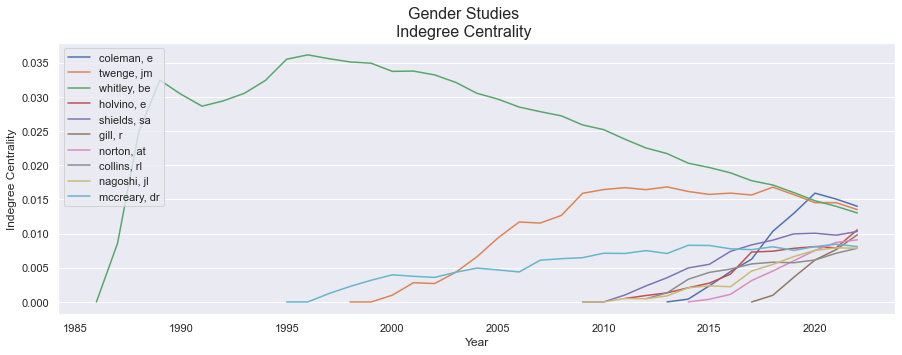

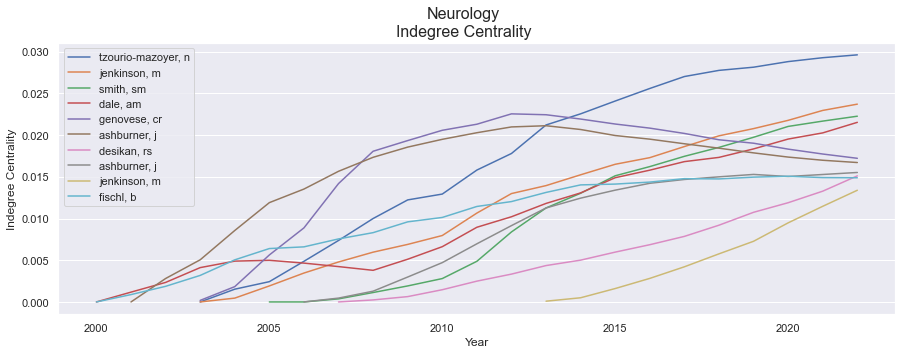

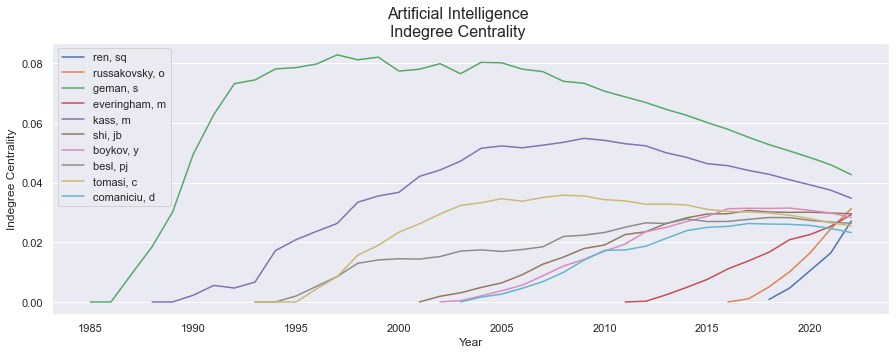

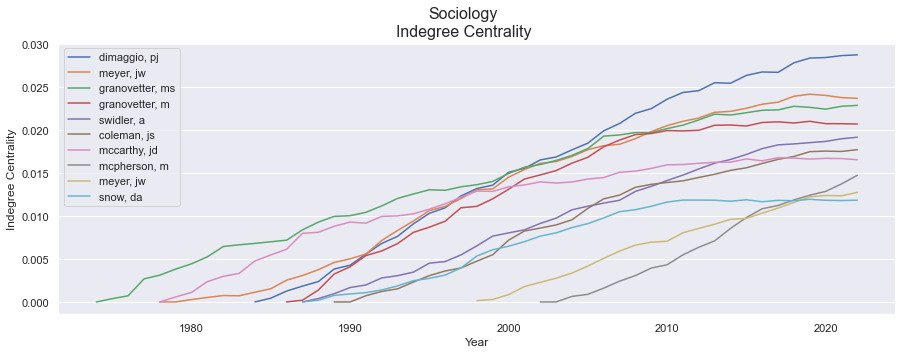

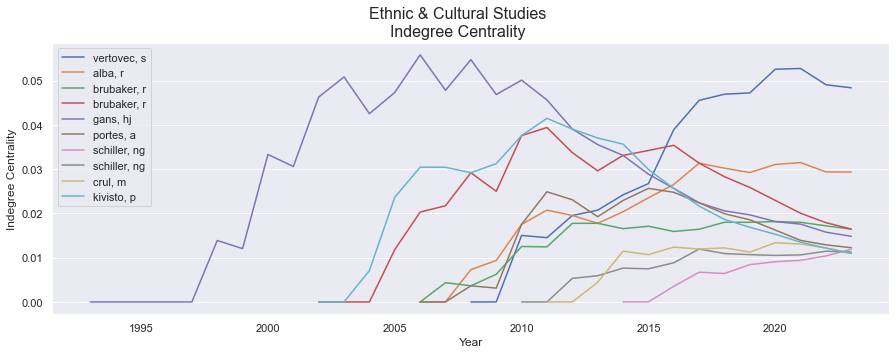

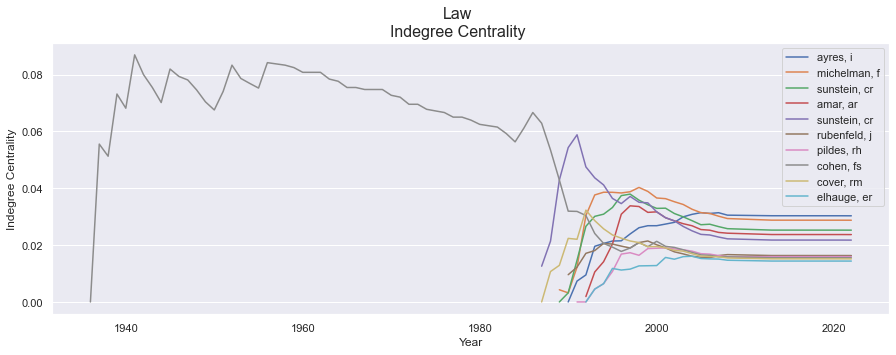

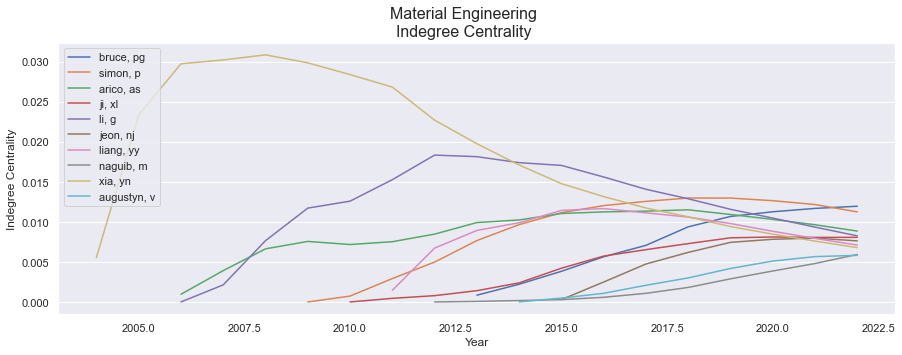

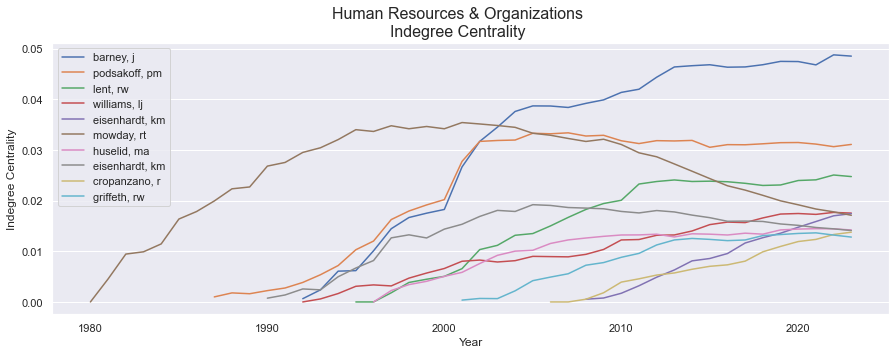

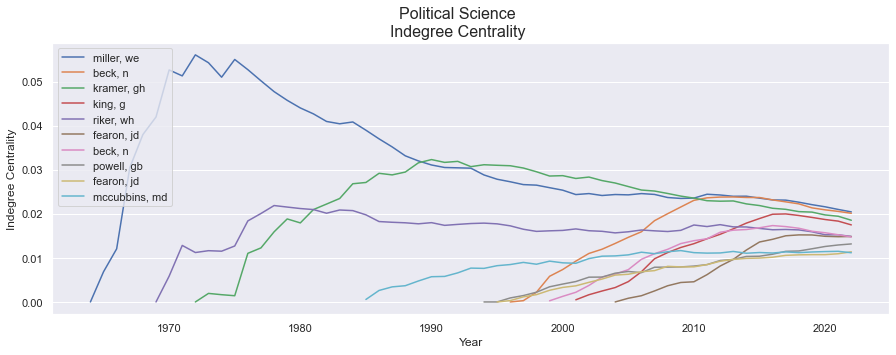

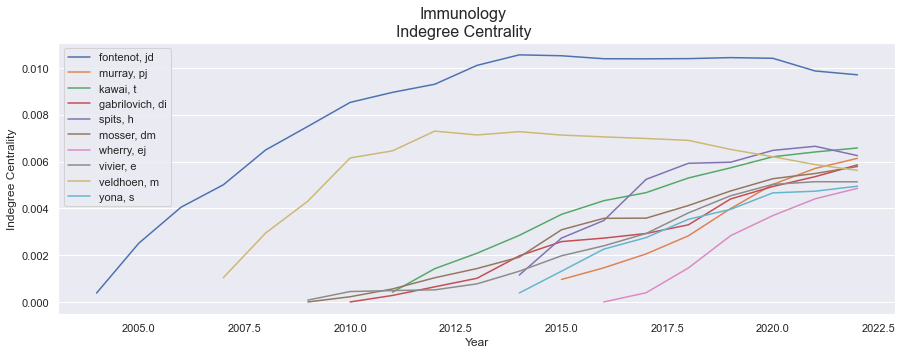

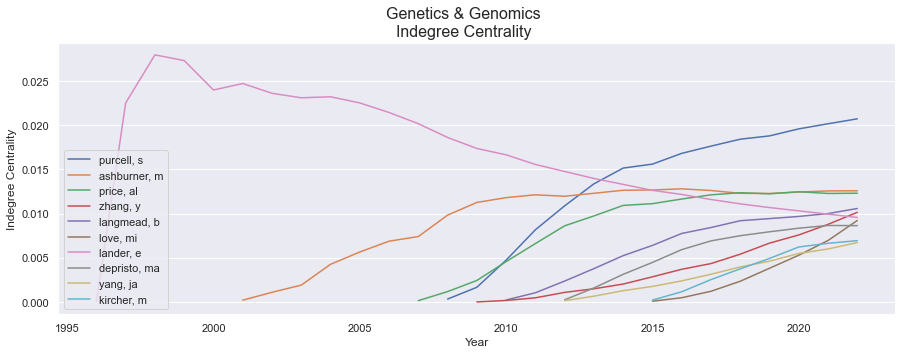

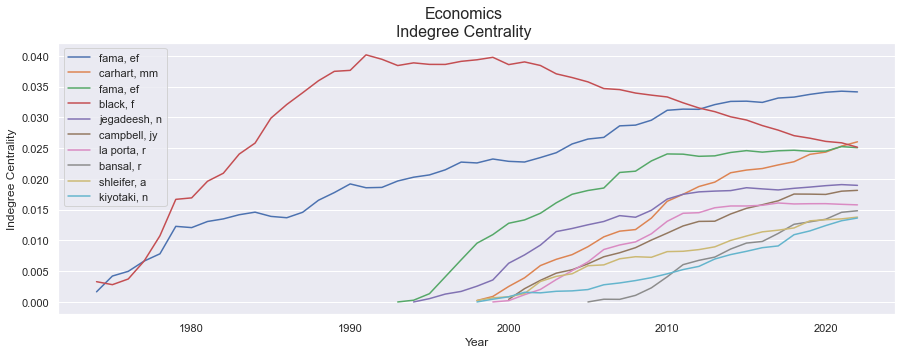

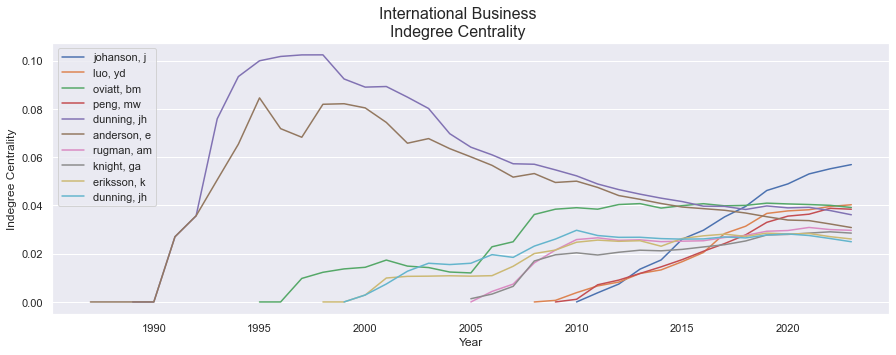

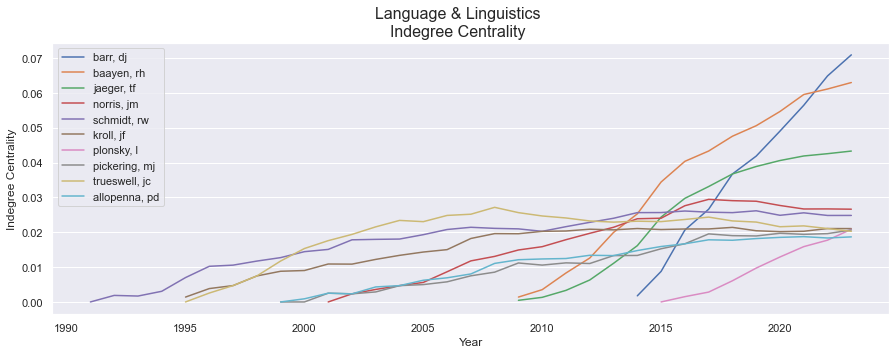

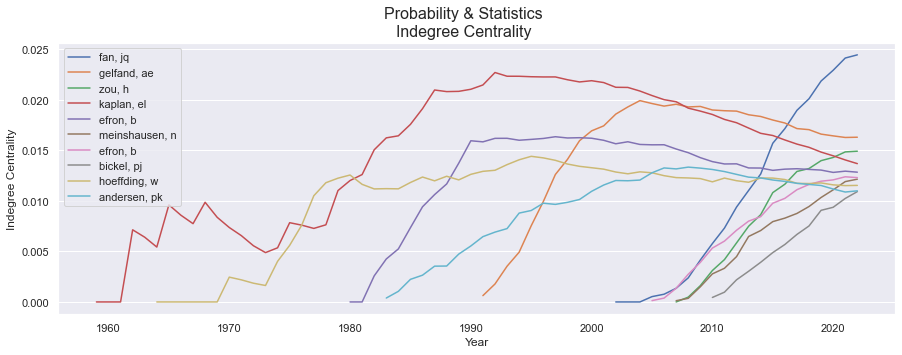

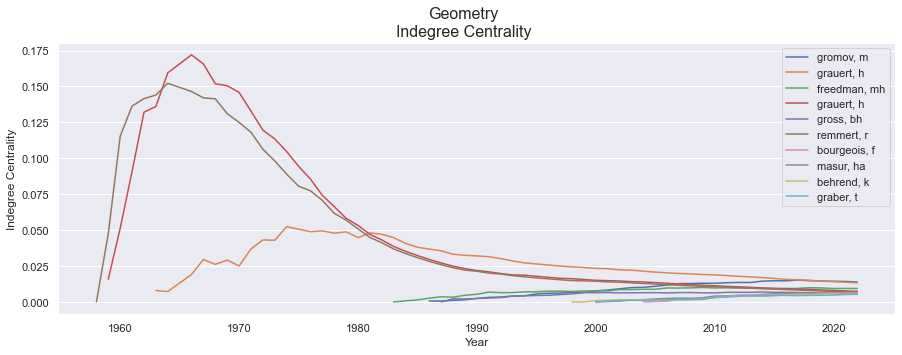

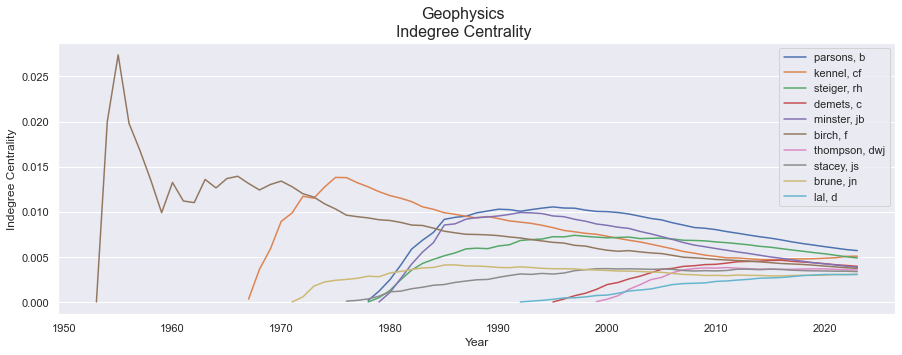

In [41]:
n = 10

for (field_name, corpus) in corpora.data.items():

    df = corpus['citation_df']
    G = corpus['citation_graph']

    years, yearly_dois = (
        df
        .groupby(pl.col('Date').dt.year())
        .agg(pl.col('Doi'))
        .sort('Date')
    )

    all_dois, = (
        df
        .select('Doi')
    )

    all_nodes = {doi: None for doi in all_dois}

    years = years.to_list()
    yearly_dois = yearly_dois.to_list()

    yearly_centralities = {}
    for i in range(len(years)):
        nodes = itertools.chain.from_iterable(yearly_dois[:i])
        G_sub = G.subgraph(nodes)
        year_i_centralities = nx.in_degree_centrality(G_sub)
        yearly_centralities[years[i]] = {**all_nodes, **year_i_centralities}

    years, centralities = yearly_centralities.keys(), yearly_centralities.values()

    df_pd = pd.DataFrame(centralities)
    df_centrality = pl.from_pandas(df_pd)

    c = dict(nx.in_degree_centrality(G))
    nodes = dict(sorted(c.items(), key=lambda kv: kv[1], reverse=True))
    nodes = list(nodes.keys())[:n]
    

    df_centrality = df_centrality[nodes]

    fig = plt.figure(figsize=(15, 5))
    axes = fig.subplots(1)

    for col in df_centrality.columns:

        authors = (
            df
            .filter(pl.col('Doi') == col)
            .get_column('Authors')
        )
        
        plt.plot(years, df_centrality[col], label=authors[0][0])

    plt.xlabel('Year')
    plt.ylabel('Indegree Centrality')

    axes.yaxis.grid(True)
    axes.xaxis.grid(False)

    fig.set_facecolor('w')

    fig.suptitle(f'{field_name}\nIndegree Centrality', fontsize=16)
    plt.xticks(rotation=0)
    plt.legend()

    plt.savefig(f'{img_path}/temporal_indegree_centrality_{field_name}.png')
    plt.show()

## Genealogy

In [71]:
field_name = 'Sociology'
corpus = corpora.data[field_name]

df = corpus['citation_df']
G = corpus['citation_graph']

centrality = sorted(nx.in_degree_centrality(G).items(), key=lambda kv: kv[1], reverse=True)

n = 6200
root = centrality[n][0]
print(root)

10.2307/1519771


In [72]:
term = "firm"

ancestors = nx.ancestors(G, root)
shortest_paths = [nx.shortest_path(G, ancestor, root) for ancestor in ancestors]
edges = set((shortest_path[i+1], shortest_path[i]) for shortest_path in shortest_paths for i in range(len(shortest_path)-1))
G_sub = nx.DiGraph(edges)

df_sub = (
    df
    .filter(pl.col('Doi').is_in(list(G_sub.nodes())))
    .groupby(pl.col('Text').str.split(' ').arr.contains(term))
    .agg(pl.col('Doi'))
)

nodes_with_term = (
    df_sub
    .filter(pl.col('Text') == True)
    .explode('Doi')
    .filter(pl.col('Doi') != root)
    .get_column('Doi')
    .to_list()
)

nodes_without_term = (
    df_sub
    .filter(pl.col('Text') == False)
    .explode('Doi')
    .filter(pl.col('Doi') != root)
    .get_column('Doi')
    .to_list()
)

dois, authors = df.filter(pl.col('Doi').is_in(list(G_sub.nodes()))).select([pl.col('Doi'), pl.col('Authors').arr.first()])
node_labels = dict(zip(dois.to_list(), authors.to_list()))
print(G_sub)

DiGraph with 316 nodes and 317 edges


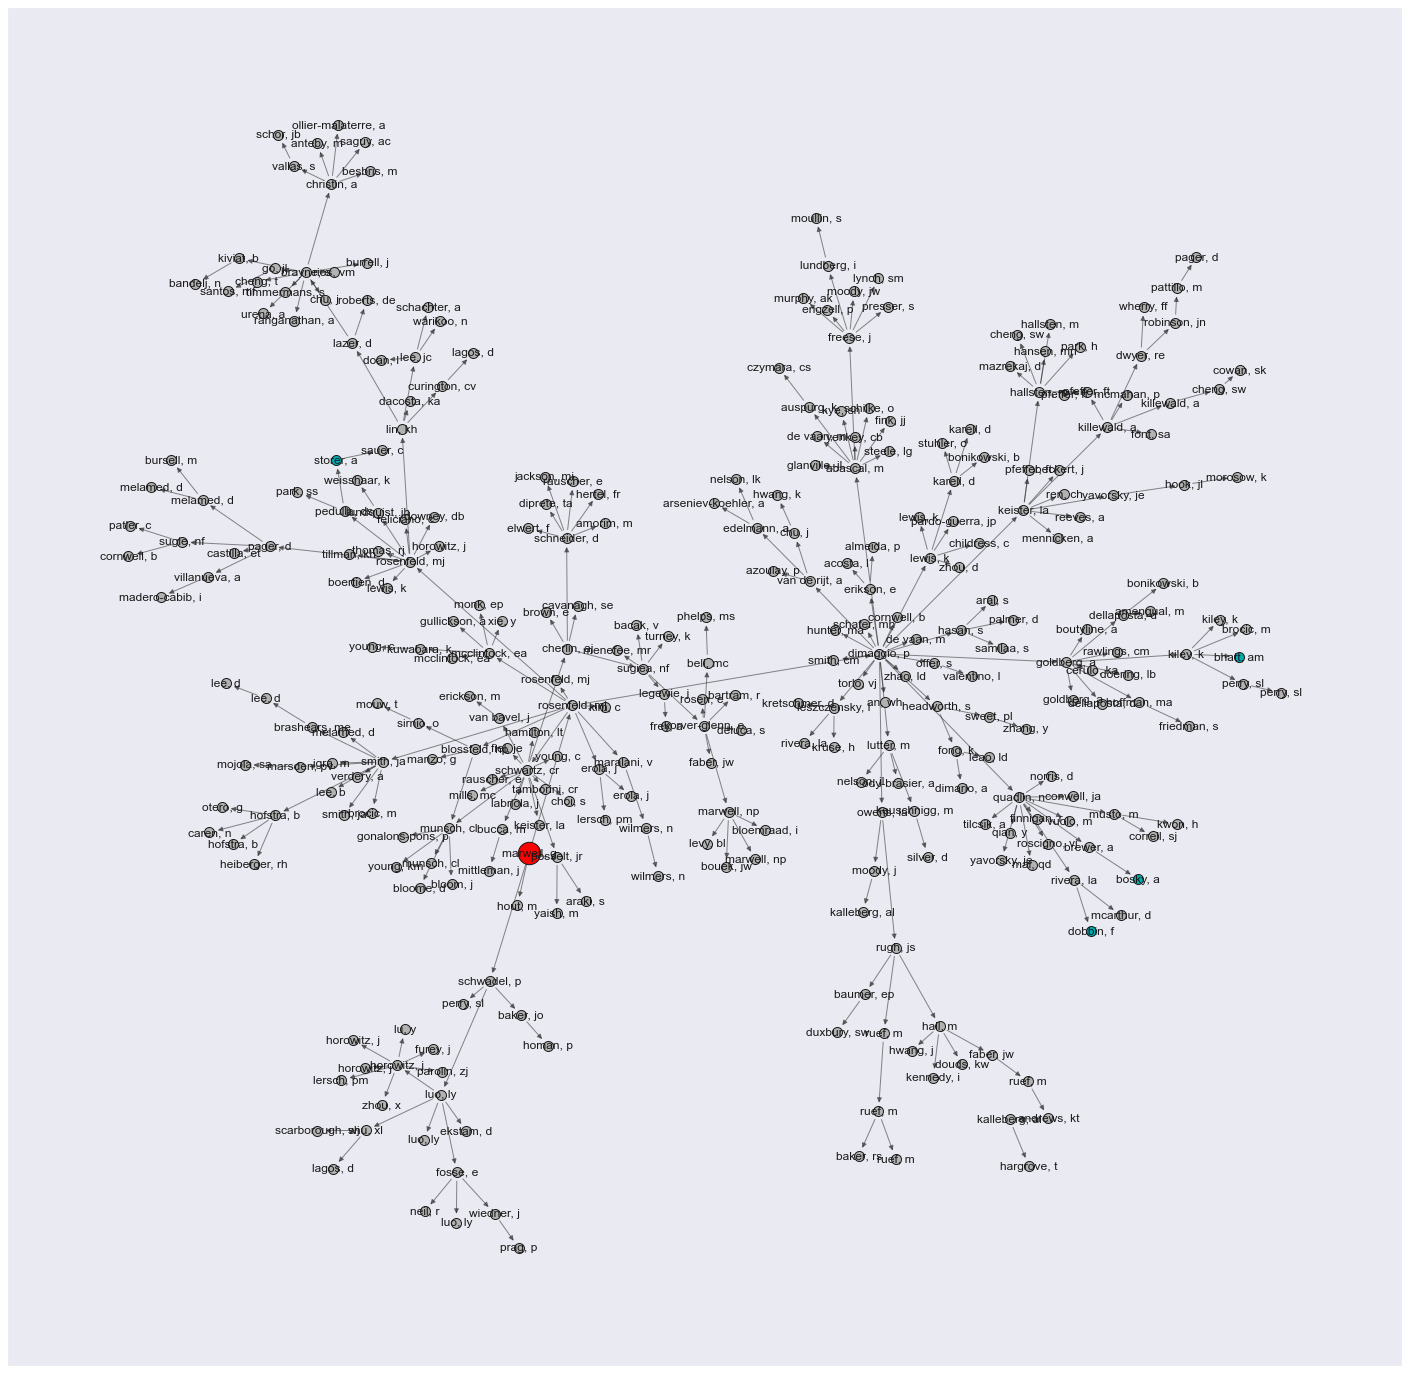

In [73]:

# pos = nx.nx_pydot.graphviz_layout(G_sub, prog="dot", root=root) # dot, twopi, fdp, sfdp, circo
pos = nx.nx_pydot.graphviz_layout(G_sub, prog="sfdp", root=root) # dot, twopi, fdp, sfdp, circo
# pos = nx.nx_pydot.graphviz_layout(G_sub, prog="circo") # dot, twopi, fdp, sfdp, circo
# pos = nx.kamada_kawai_layout(G_sub) # dot, twopi, fdp, sfdp, circo
# pos = nx.spring_layout(G_sub) # dot, twopi, fdp, sfdp, circo
pos = nx.rescale_layout_dict(pos, scale=0.5)

plt.figure(figsize=(25, 25))

root_node = nx.draw_networkx_nodes(
    G_sub, 
    pos, 
    nodelist=[root],
    node_size=500,
    node_color='red',
    node_shape='o',
    alpha=None,
    cmap=None,
    vmin=None,
    vmax=None,
    ax=None,
    linewidths=1.0, 
    edgecolors='k',
    margins=None
)
root_node.set_zorder(1)

nodes_with_term = nx.draw_networkx_nodes(
    G_sub, 
    pos, 
    nodelist=nodes_with_term,
    node_size=100,
    node_color='#00ABB3',
    node_shape='o',
    alpha=None,
    cmap=None,
    vmin=None,
    vmax=None,
    ax=None,
    linewidths=1.0, 
    edgecolors='k', 
    margins=None
)
nodes_with_term.set_zorder(1)

without_term_collection = nx.draw_networkx_nodes(
    G_sub, 
    pos, 
    nodelist=nodes_without_term, 
    node_size=100,
    node_color='#B2B2B2', 
    node_shape='o', 
    alpha=None, 
    cmap=None, 
    vmin=None, 
    vmax=None, 
    ax=None, 
    linewidths=1.0, 
    edgecolors='k',
    margins=None
)
without_term_collection.set_zorder(0)

edge_collection = nx.draw_networkx_edges(
    G_sub, 
    pos,
    width=1.0,
    edge_color='k',
    style='solid',
    alpha=0.5,
    arrowstyle=None,
    arrowsize=10,
    edge_cmap=None,
    edge_vmin=None,
    edge_vmax=None,
    ax=None,
    arrows=None,
    label=None,
    node_size=300,
    nodelist=None,
    node_shape='o',
    connectionstyle='arc3',
    min_source_margin=0,
    min_target_margin=0,
)

nx.draw_networkx_labels(
    G_sub, 
    pos, 
    labels=node_labels, 
    font_size=12, 
    font_color='k', 
    font_family='sans-serif', 
    font_weight='normal', 
    alpha=1.0, 
    bbox=None
)

for c in edge_collection:
    c.set_zorder(-1)

plt.grid(False)
plt.show()

## Mutliple Genealogy

In [24]:
field_name = 'organizations'
corpus = corpora[field_name]
centrality = sorted(nx.in_degree_centrality(corpus.citation_graph).items(), key=lambda kv: kv[1], reverse=True)

n = 4001
root = centrality[n][0]
print(root)

10.2307/259139


In [25]:
term = 'organizaion'

roots = [
    '10.1146/annurev-soc-081309-150054', 
    '10.2307/259139',
]

G = corpus.citation_graph
df = corpus.citation_df

edges = set()
for root in roots:
    ancestors = nx.ancestors(G, root)
    shortest_paths = [nx.shortest_path(G, ancestor, root) for ancestor in ancestors]
    edges_sub = set((shortest_path[i+1], shortest_path[i]) for shortest_path in shortest_paths for i in range(len(shortest_path)-1))
    edges.update(edges_sub)


In [26]:
G_sub = nx.DiGraph(edges)

df_sub = (
    df
    .filter(pl.col('Doi').is_in(list(G_sub.nodes())))
    .groupby(pl.col('Text').str.split(' ').arr.contains(term))
    .agg(pl.col('Doi'))
)

nodes_with_term = (
    df_sub
    .filter(pl.col('Text') == True)
    .explode('Doi')
    .filter(pl.col('Doi') != root)
    .get_column('Doi')
    .to_list()
)

nodes_without_term = (
    df_sub
    .filter(pl.col('Text') == False)
    .explode('Doi')
    .filter(pl.col('Doi') != root)
    .get_column('Doi')
    .to_list()
)

dois, authors = df.filter(pl.col('Doi').is_in(list(G_sub.nodes()))).select([pl.col('Doi'), pl.col('Authors').arr.first()])
node_labels = dict(zip(dois.to_list(), authors.to_list()))
print(G_sub)

# pos = nx.nx_pydot.graphviz_layout(G_sub, prog="dot", root=root) # dot, twopi, fdp, sfdp, circo
pos = nx.nx_pydot.graphviz_layout(G_sub, prog="sfdp", root=root) # dot, twopi, fdp, sfdp, circo
# pos = nx.nx_pydot.graphviz_layout(G_sub, prog="circo") # dot, twopi, fdp, sfdp, circo
# pos = nx.kamada_kawai_layout(G_sub) # dot, twopi, fdp, sfdp, circo
# pos = nx.spring_layout(G_sub) # dot, twopi, fdp, sfdp, circo
pos = nx.rescale_layout_dict(pos, scale=0.5)

plt.figure(figsize=(25, 25))

root_node = nx.draw_networkx_nodes(
    G_sub, 
    pos, 
    nodelist=[root],
    node_size=500,
    node_color='red',
    node_shape='o',
    alpha=None,
    cmap=None,
    vmin=None,
    vmax=None,
    ax=None,
    linewidths=1.0, 
    edgecolors='k',
    margins=None
)
root_node.set_zorder(1)

nodes_with_term = nx.draw_networkx_nodes(
    G_sub, 
    pos, 
    nodelist=nodes_with_term,
    node_size=100,
    node_color='#00ABB3',
    node_shape='o',
    alpha=None,
    cmap=None,
    vmin=None,
    vmax=None,
    ax=None,
    linewidths=1.0, 
    edgecolors='k', 
    margins=None
)
nodes_with_term.set_zorder(1)

without_term_collection = nx.draw_networkx_nodes(
    G_sub, 
    pos, 
    nodelist=nodes_without_term, 
    node_size=100,
    node_color='#B2B2B2', 
    node_shape='o', 
    alpha=None, 
    cmap=None, 
    vmin=None, 
    vmax=None, 
    ax=None, 
    linewidths=1.0, 
    edgecolors='k',
    margins=None
)
without_term_collection.set_zorder(0)

edge_collection = nx.draw_networkx_edges(
    G_sub, 
    pos,
    width=1.0,
    edge_color='k',
    style='solid',
    alpha=0.5,
    arrowstyle=None,
    arrowsize=10,
    edge_cmap=None,
    edge_vmin=None,
    edge_vmax=None,
    ax=None,
    arrows=None,
    label=None,
    node_size=300,
    nodelist=None,
    node_shape='o',
    connectionstyle='arc3',
    min_source_margin=0,
    min_target_margin=0,
)

nx.draw_networkx_labels(
    G_sub, 
    pos, 
    labels=node_labels, 
    font_size=12, 
    font_color='k', 
    font_family='sans-serif', 
    font_weight='normal', 
    alpha=1.0, 
    bbox=None
)

for c in edge_collection:
    c.set_zorder(-1)

plt.grid(False)
plt.show()

DiGraph with 7712 nodes and 8022 edges


KeyboardInterrupt: 

## Maximal Cliques

In [116]:
field_name = 'organizations'

corpus = corpora[field_name]

centrality = sorted(nx.in_degree_centrality(corpus.citation_graph).items(), key=lambda kv: kv[1], reverse=True)

n = 20_000

[id for (id, _) in centrality[:n]][-1]

'10.1086/210433'

In [79]:
cliques = nx.find_cliques_recursive(corpora['organizations'].citation_graph.to_undirected(), nodes=['10.1177/014920639101700108'])

cliques = filter(lambda x: len(x) >= 7, cliques)

cliques = iter(sorted(cliques, key=len, reverse=True))

In [80]:
len(list(cliques))

120

In [76]:
maximal_cliques = [next(cliques)]

for clique in cliques:

    if not all(set(clique).issubset(set(maximal_clique)) for maximal_clique in maximal_cliques):
        maximal_cliques.append(clique)

        

StopIteration: 

In [68]:
len(maximal_cliques)

10585

In [7]:
corpus = corpora['organizations']
G = corpus.citation_graph
df = corpus.citation_df

In [13]:
levels = community.girvan_newman(G)

In [14]:
func = lambda x: len(x) == 10
filtered = filter(func, levels)
filtered

In [ ]:
levels[:2]

In [ ]:
tv = TfidfVectorizer()
tv_matrix = tv.fit_transform(texts).toarray()
vocab = tv.get_feature_names_out()

In [8]:
df.sort('InCentrality', reverse=True)

shape: (34164, 13)
┌───────────┬───────────┬───────────┬──────────┬─────┬──────────┬──────────┬──────────┬────────────┐
│ Doi       ┆ Authors   ┆ Title     ┆ Abstract ┆ ... ┆ Date     ┆ Text     ┆ Referenc ┆ InCentrali │
│ ---       ┆ ---       ┆ ---       ┆ ---      ┆     ┆ ---      ┆ ---      ┆ es       ┆ ty         │
│ str       ┆ list[str] ┆ str       ┆ str      ┆     ┆ date     ┆ str      ┆ ---      ┆ ---        │
│           ┆           ┆           ┆          ┆     ┆          ┆          ┆ list[str ┆ f32        │
│           ┆           ┆           ┆          ┆     ┆          ┆          ┆ ]        ┆            │
╞═══════════╪═══════════╪═══════════╪══════════╪═════╪══════════╪══════════╪══════════╪════════════╡
│ 10.1177/0 ┆ ["barney, ┆ firm      ┆ null     ┆ ... ┆ 1991-03- ┆ firm     ┆ ["10.230 ┆ 0.091734   │
│ 149206391 ┆ j"]       ┆ resources ┆          ┆     ┆ 01       ┆ resource ┆ 7/258014 ┆            │
│ 01700108  ┆           ┆ and       ┆          ┆     ┆          ┆ sustaine ┆ ", "10.2 ┆            │
│           ┆           ┆ sustained ┆          ┆     ┆          ┆ d compet ┆ 307/2583 ┆            │
│           ┆           ┆ com...    ┆          ┆     ┆          ┆ it...    ┆ ...      ┆            │
├╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 10.2307/2 ┆ ["eisenha ┆ building  ┆ null     ┆ ... ┆ 1989-10- ┆ building ┆ ["10.230 ┆ 0.05004    │
│ 58557     ┆ rdt, km"] ┆ theories  ┆          ┆     ┆ 01       ┆ theory   ┆ 7/239261 ┆            │
│           ┆           ┆ from case ┆          ┆     ┆          ┆ case     ┆ 8", "10. ┆            │
│           ┆           ┆ -stud...  ┆          ┆     ┆          ┆ study    ┆ 2307/239 ┆            │
│           ┆           ┆           ┆          ┆     ┆          ┆ resea... ┆ ...      ┆            │
├╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 10.2307/2 ┆ ["dimaggi ┆ the iron  ┆ null     ┆ ... ┆ 1983-01- ┆ iron     ┆ ["10.230 ┆ 0.048985   │
│ 095101    ┆ o, pj",   ┆ cage      ┆          ┆     ┆ 01       ┆ cage rev ┆ 7/239229 ┆            │
│           ┆ "powell,  ┆ revisited ┆          ┆     ┆          ┆ isited   ┆ 9", "10. ┆            │
│           ┆ ww"]      ┆ -         ┆          ┆     ┆          ┆ institut ┆ 2307/239 ┆            │
│           ┆           ┆ instit... ┆          ┆     ┆          ┆ iona...  ┆ ...      ┆            │
├╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 10.2307/2 ┆ ["cohen,  ┆ absorptiv ┆ null     ┆ ... ┆ 1990-03- ┆ absorpti ┆ ["10.230 ┆ 0.048517   │
│ 393553    ┆ wm", "lev ┆ e-capacit ┆          ┆     ┆ 01       ┆ ve       ┆ 7/239135 ┆            │
│           ┆ inthal,   ┆ y - a new ┆          ┆     ┆          ┆ capacity ┆ 7", "10. ┆            │
│           ┆ da"]      ┆ pers...   ┆          ┆     ┆          ┆ new pers ┆ 2307/239 ┆            │
│           ┆           ┆           ┆          ┆     ┆          ┆ pect...  ┆ ...      ┆            │
├╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ ...       ┆ ...       ┆ ...       ┆ ...      ┆ ... ┆ ...      ┆ ...      ┆ ...      ┆ ...        │
├╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 10.1002/( ┆ ["barkema ┆ foreign   ┆ This     ┆ ... ┆ 1996-02- ┆ foreign  ┆ ["10.100 ┆ 0.0        │
│ SICI)1097 ┆ , hg",    ┆ entry,    ┆ paper    ┆     ┆ 01       ┆ entry    ┆ 2/smj.42 ┆            │
│ -0266(199 ┆ "bell,    ┆ cultural  ┆ examines ┆     ┆          ┆ cultural ┆ 50110204 ┆            │
│ 602)1...  ┆ jhj",     ┆ barriers. ┆ the long ┆     ┆          ┆ barrier  ┆ ",       ┆            │
│           ┆ "pe...    ┆ ..        ┆ evit...  ┆     ┆          ┆ l...     ┆ "10.1... ┆            │
├╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 10.1002/( ┆ ["khanna, ┆ the       ┆ We s

In [13]:
dois, authors = df.sort('InCentrality', reverse=True).filter(pl.col('Abstract').is_null()).head(25).select(['Doi', 'Authors'])
for (d, a) in zip(dois.to_list(), authors.to_list()):
    print(d, a)

10.1177/014920639101700108 ['barney, j']
10.2307/258557 ['eisenhardt, km']
10.2307/2095101 ['dimaggio, pj', 'powell, ww']
10.2307/2393553 ['cohen, wm', 'levinthal, da']
10.1086/226550 ['meyer, jw', 'rowan, b']
10.2307/258434 ['hambrick, dc', 'mason, pa']
10.1086/228311 ['granovetter, m']
10.1086/225469 ['granovetter, ms']
10.1177/014920638601200408 ['podsakoff, pm', 'organ, dw']
10.2307/2095567 ['hannan, mt', 'freeman, j']
10.1086/226424 ['hannan, mt', 'freeman, j']
10.1086/228943 ['coleman, js']
10.2307/258610 ['oliver, c']
10.2307/2393549 ['henderson, rm', 'clark, kb']
10.2307/2392832 ['tushman, ml', 'anderson, p']
10.2307/2393080 ['dess, gg', 'beard, dw']
10.1002/smj.4250100107 ['covin, jg', 'slevin, dp']
10.1002/smj.4250120908 ['hamel, g']
10.2307/2393356 ['williamson, oe']
10.2307/256434 ['eisenhardt, km']
10.2307/258441 ['daft, rl', 'weick, ke']
10.1002/smj.4250090403 ['kogut, b']
10.2307/258189 ['ashforth, be', 'mael, f']
10.1002/smj.4250120604 ['gioia, da', 'chittipeddi, k']
10

In [32]:
import spacy
import string
import en_core_web_lg


texts, = corpus_orgs.citation_df.select('Text')

text = texts[0]
text = text.lower()
text = text.translate(str.maketrans('', '', string.punctuation))
text = text.replace('\n', ' ')
text = ' '.join(text.split())

tokens = text.split(' ')

nlp = spacy.load('en_core_web_lg')

lexemes = (nlp.vocab[token] for token in tokens)

vectors = np.asarray([
    lexeme.vector
    for lexeme in lexemes
    if lexeme.has_vector
    and not lexeme.is_stop
    and len(lexeme.text) > 1
])

vectors.shape

# if len(vectors) > 0:
#     centroid = vectors.mean(axis=0)
# else:
#     width = nlp.meta['vectors']['width']  # typically 300
#     centroid = np.zeros(width)

# centroid.shape

(77, 300)

In [31]:
len(list(lexemes))
# len()

83